# Случайные процессы. Прикладной поток
## Практическое задание 9*

In [458]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import statsmodels.api as sm
import scipy.stats as sps

import matplotlib.pyplot as plt
%matplotlib inline

In [459]:
import warnings
warnings.filterwarnings('ignore')

Загрузка таблицы продаж. Параметр `parse_dates=[3]` указывает на то, что в третьем столбце (с нуля) нужно распарсить даты.

In [460]:
train = pd.read_csv('./train.csv', sep='\t', parse_dates=[3])
train.head(5)

TRANSACTIONID      ITEMID  PRICE  TRANSDATE
0              6  80275632.0  149.0 2016-02-26
1             10  80275632.0  149.0 2016-02-26
2             12  80088007.0    8.0 2016-02-26
3             13  80088007.0    8.0 2016-02-26
4             14  80088007.0    8.0 2016-02-26

Есть записи, где не указан номер товара

In [461]:
train.iloc[2195]

TRANSACTIONID                   2063
ITEMID                           NaN
PRICE                           3000
TRANSDATE        2016-04-17 00:00:00
Name: 2195, dtype: object

Когда преобразовываем `ITEMID` к int, пропуск заменяется на какую-то хрень, в общем-то, не важно.

In [462]:
train['ITEMID'] = np.array(train['ITEMID'], dtype=int)
train.iloc[2195]

TRANSACTIONID                    2063
ITEMID           -9223372036854775808
PRICE                            3000
TRANSDATE         2016-04-17 00:00:00
Name: 2195, dtype: object

Товары, продажи которых нужно предсказать

In [463]:
items_for_predictions = [80090775, 80088007, 80021669, 80018235, 80100848, 
                         80018236, 80007817, 80100859, 80073968, 80071318, 
                         80101583, 80100849, 80074450, 80100860, 80049805, 
                         80106282, 80101584, 80258337, 80105188, 80071390]

Составим для них временные ряды. Заметим так же, что теперь все товары упорядочены по возрастанию `ITEMID`, как и требуется.

In [464]:
# Найдем все строки таблицы, в которых указаны нужные нам товары
true_lines = np.in1d(train['ITEMID'], items_for_predictions)
# Оставим только их
train = train.iloc[true_lines]

# Таблица [дата, товар] -> количество проданного товара за день
timeseries = pd.crosstab(train['TRANSDATE'], train['ITEMID'])
timeseries

ITEMID      80007817  80018235  80018236  80021669  80049805  80071318  \
TRANSDATE                                                                
2015-08-01        31        39        16        40        21         9   
2015-08-02        40        35        11        59        14        13   
2015-08-03        10         5         2        30         2         1   
2015-08-04        12        17         9        37         6         3   
2015-08-05        12        20         6        38         9        10   
2015-08-06        18        14        13        18        12         2   
2015-08-07         8        16        12        43         5        10   
2015-08-08        33        28        16        59        18        15   
2015-08-09        53        27        16        54        11        13   
2015-08-10        23        21        22        26        12         2   
2015-08-11        15        27        13        60        19         6   
2015-08-12        27        28        14        53        13        13   
2015-08-13        19        21        17        61        18         6   
2015-08-14        19        19        14        39        16         6   
2015-08-15        39        57        38        95        27        12   
2015-08-16        49        56        41        96        24         7   
2015-08-17        15        27        17        47        12         5   
2015-08-18        33        30        24        67        15        11   
2015-08-19        20        39        20        42         9         9   
2015-08-20        37        39        27        41        10         5   
2015-08-21        15        28        12        57        10         8   
2015-08-22        44        48        39        88        20         9   
2015-08-23        53        39        32        63        15        20   
2015-08-24        20        26        18        62        10         9   
2015-08-25        66        45        25        74         8         3   
2015-08-26        38        22        15        53        24        11   
2015-08-27        26        37        16        61        24         9   
2015-08-28        32        47        25        51        15        12   
2015-08-29        76        54        30       119        26        17   
2015-08-30        71        50        29       129        23        10   
...              ...       ...       ...       ...       ...       ...   
2016-05-02        14        68        39       109         7        43   
2016-05-03        15        51        45       121        30        18   
2016-05-04        16        23        18        58        11        22   
2016-05-05        16        24        19        70        10        13   
2016-05-06        11        41        25        57        14        24   
2016-05-07        13        86        47       144        13        37   
2016-05-08        18        70        53        90        28        37   
2016-05-09         9        58        39        51        14        21   
2016-05-10         7        39        24        34        14        20   
2016-05-11        13        13        11        50        13        35   
2016-05-12        12        33        26        51         6        18   
2016-05-13        15        25        21        44        12        37   
2016-05-14        26        53        46       141        15        75   
2016-05-15        24        61        48       137        37        66   
2016-05-16         5        36        30        55        15        30   
2016-05-17        13        26        15        43        10        30   
2016-05-18        22        27        16        21        12        15   
2016-05-19        13        18        19        80        11        26   
2016-05-20        16        40        21        78         9        20   
2016-05-21        22        74        41       170        38        57   
2016-05-22        22        74        45       192        21        46   
2016

Изобразим все полученные временные ряды на графике. Видим, что среди данных 20 товаров есть 2 самых популярных товара, причем для них наблюдается "яма" в конце 2015 года.

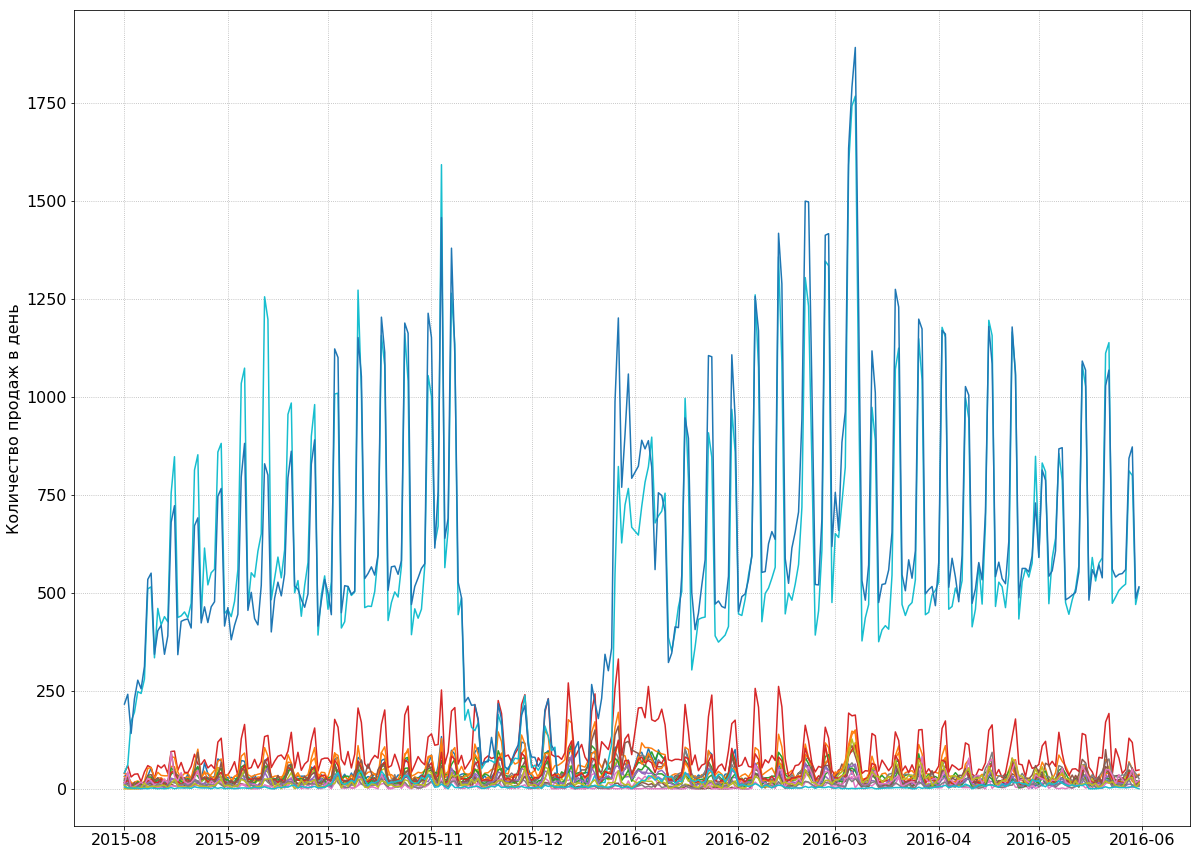

In [465]:
plt.figure(figsize=(20, 15))
plt.plot(timeseries)
plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

Изобразим все временные ряды на графике еще раз, убрав два самых популярных товара.

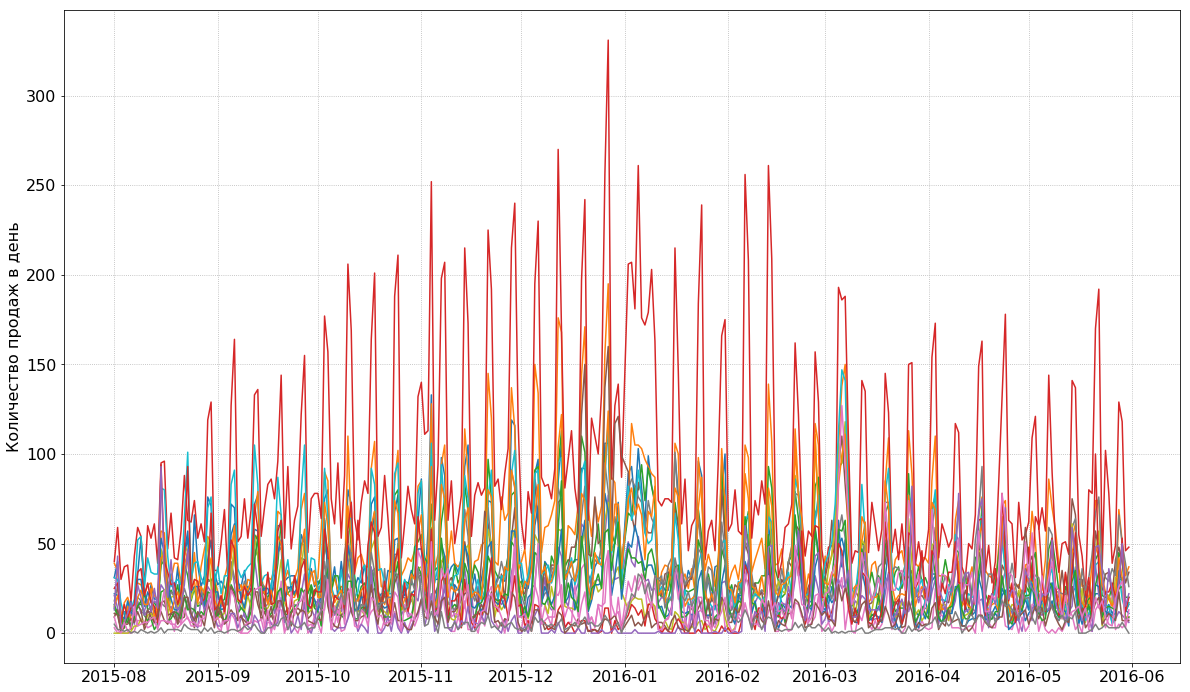

In [466]:
plt.figure(figsize=(20, 12))
plt.plot(timeseries.iloc[:, (np.arange(20) > 10) | (np.arange(20) < 9)])
plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

<br><br><br><br><br>
Заметим, что пропущено первое января. Из-за этого сезонности и другие зависимости могут сдвинуться. Для этого сначала поставим частоту в датах равную одному дню. <br>
Заведем новый массив с датами, в котрое уже будет добавлена дата первое января.

In [467]:
timeseries = timeseries.asfreq('1D')
my_time = [timeseries.index[0] + i for i in range(305)]

In [475]:
timeseries[30*5:30*5 + 10]

ITEMID      80007817  80018235  80018236  80021669  80049805  80071318  \
TRANSDATE                                                                
2015-12-29      50.0      84.0      50.0     127.0      30.0     117.0   
2015-12-30      73.0      49.0      67.0     139.0      31.0     121.0   
2015-12-31      33.0      40.0      38.0      87.0      31.0      99.0   
2016-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2016-01-02      89.0      70.0      67.0     206.0      51.0      90.0   
2016-01-03      93.0     117.0      65.0     207.0      40.0      66.0   
2016-01-04      72.0     105.0      82.0     181.0      37.0      57.0   
2016-01-05     103.0     105.0      80.0     261.0      54.0      84.0   
2016-01-06      81.0     103.0      94.0     176.0      41.0      78.0   
2016-01-07      61.0      97.0      74.0     172.0      29.0      60.0   

ITEMID      80071390  80073968  80074450  80088007  80090775  80100848  \
TRANSDATE                                                                
2015-12-29       3.0      65.0      33.0     724.0     904.0      51.0   
2015-12-30      20.0      50.0      37.0     766.0    1058.0      66.0   
2015-12-31       3.0      34.0      23.0     667.0     792.0      28.0   
2016-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2016-01-02      29.0      80.0      13.0     647.0     823.0      82.0   
2016-01-03      23.0      86.0      18.0     720.0     889.0      63.0   
2016-01-04      32.0      82.0      20.0     782.0     867.0      70.0   
2016-01-05      24.0      76.0      19.0     821.0     888.0      91.0   
2016-01-06      29.0      73.0      19.0     897.0     821.0      75.0   
2016-01-07      26.0      56.0       8.0     678.0     559.0      56.0   

ITEMID      80100849  80100859  80100860  80101583  80101584  80105188  \
TRANSDATE                                                                
2015-12-29      32.0      72.0      51.0       7.0       3.0      10.0   
2015-12-30      48.0      72.0      62.0       2.0       0.0       5.0   
2015-12-31      19.0      36.0      25.0       4.0       0.0       1.0   
2016-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2016-01-02      50.0      75.0      47.0      10.0       0.0       7.0   
2016-01-03      48.0      81.0      42.0      16.0       0.0      10.0   
2016-01-04      60.0      66.0      42.0      14.0       2.0       4.0   
2016-01-05      52.0      72.0      39.0      10.0       0.0       6.0   
2016-01-06      43.0      66.0      40.0      13.0       0.0       4.0   
2016-01-07      35.0      41.0      29.0       4.0       0.0       9.0   

ITEMID      80106282  80258337  
TRANSDATE                       
2015-12-29      10.0       4.0  
2015-12-30      12.0       6.0  
2015-12-31       2.0       0.0  
2016-01-01       NaN       NaN  
2016-01-02      17.0      14.0  
2016-01-03      19.0      22.0  
2016-01-04      22.0      20.0  
2016-01-05      28.0      33.0  
2016-01-06      33.0      31.0  
2016-01-07      29.0      22.0

Как видим в таблице появилась строка из NaN, соответствующая первому января. <br>
Также отсюда видим, что индекс первого января (индекс вхождения в timeseries) - $30*5 + 3$

Сделаем для каждого ряда преобразование Бокса-Кокса, дополнительно заметив, что в некоторые дни кол-во проданных товаров может равнятся 0, что плохо для преобразования Бокса-Кокса при оптимальном $\lambda = 0$. Поэтому поднимем каждый ряд на 2 вверх. Кроме этого, добавляем значение на первое января, равное среднему двух соседних чисел.

In [485]:
series = []
for i in range(20):
    #i-ый временной ряд
    y = np.array(timeseries.iloc[:, i], dtype=float)
    #добавляем значение на первое января
    y[30*5 + 3] = (y[30*5 + 2] + y[30*5 + 4]) / 2
    y += 2
    series.append(y)

Делаем преобразование Бокса-Кокса

In [486]:
lambdas = []
for i in range(20):
    series[i], lambd = sps.boxcox(series[i])
    lambdas.append(lambd)

Посмотрим, что получилось

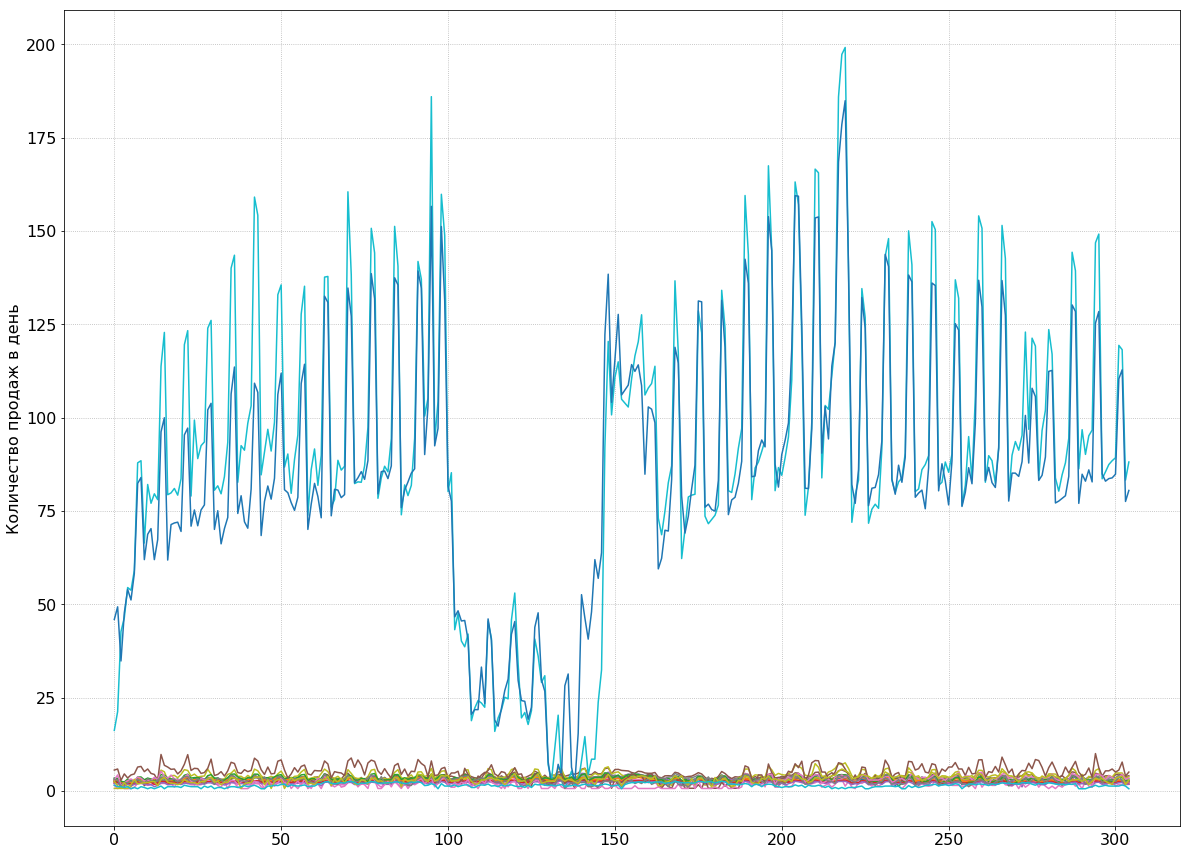

In [487]:
plt.figure(figsize=(20, 15))

for i in range(20):
    plt.plot(series[i])

plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

In [143]:
# Эта функция вам уже встречалась в одном задании.
# Позволяем получать argmin в виде мультииндекса.
def cool_argmin(array):
    return np.unravel_index(np.argmin(array), array.shape)

Для каждого ряда переберем вручную кучу вариантов модели и выберем лучшую модель по AIC.

# Работает часов 7.

In [144]:
D = 1
ps, ds, qs, Ps, Qs = 5, 2, 4, 4, 3  # количество параметров каждого типа для перебора
optim_params = np.zeros((20, 5), dtype=int)  # тут будут оптимальные параметры для каждого ряда
results = []
for i in tqdm_notebook(range(20)):  # цикл по товарам
    
    # временной ряд
    y = series[i]
    
    # Тут будут значения AIC для всех моделей. Некоторые модели могут по разным причинам не рассчитатья,
    # поэтому значением по умолчанию будет 10^10 (значения нужно минимизировать).
    aic = np.zeros((ps,ds, qs, Ps, Qs)) + 10**10
    
    # Перебор параметров
    for p in tqdm_notebook(range(ps), leave=False):
        for d in tqdm_notebook(range(ds), leave=False):
            for q in tqdm_notebook(range(qs), leave=False):
                for P in tqdm_notebook(range(Ps), leave=False):
                    for Q in tqdm_notebook(range(Qs), leave=False):
                        
                        try:
                            
                            # Задаем модель (период сезонности = 7, т.е. неделя)
                            model = sm.tsa.statespace.SARIMAX(y, order=(p, d, q), 
                                                              seasonal_order=(P, D, Q, 7), 
                                                              enforce_stationarity=False, 
                                                              enforce_invertibility=False)
                            # Обучаем модель
                            model = model.fit()
                            # Запоминаем AIC
                            aic[p, d, q, P, Q] = model.aic
                            print("({}-{}-{})x({}-1-{}) {}".format(p, d, q, P, Q, model.aic))
                        # Если модель не рассчиталась, то пропускаем ее
                        except Exception:
                            pass
    results.append(aic)  
    # Запоминаем параметры (индексы) у лучшей модели по AIC
    optim_params[i] = cool_argmin(aic)

(0-0-0)x(0-1-1) 66.00194583699232
(0-0-0)x(0-1-2) 58.927849674472164


(0-0-0)x(1-1-0) 80.4913771495086
(0-0-0)x(1-1-1) 62.892089723625645
(0-0-0)x(1-1-2) 61.86096748021196


(0-0-0)x(2-1-0) 67.71082123401942
(0-0-0)x(2-1-1) 60.596951077819945
(0-0-0)x(2-1-2) 63.86112454248941


(0-0-0)x(3-1-0) 57.45338857088418
(0-0-0)x(3-1-1) 58.96448798319619
(0-0-0)x(3-1-2) 59.51400592184862


(0-0-1)x(0-1-0) 128.71183563451706
(0-0-1)x(0-1-1) 43.6358574181458
(0-0-1)x(0-1-2) 35.40451356936201


(0-0-1)x(1-1-0) 64.67278558132006
(0-0-1)x(1-1-1) 43.68370016687827
(0-0-1)x(1-1-2) 38.509009479037275


(0-0-1)x(2-1-0) 47.466965772933854
(0-0-1)x(2-1-1) 41.29747391309914
(0-0-1)x(2-1-2) 40.50907345921358


(0-0-1)x(3-1-0) 39.07100098856016
(0-0-1)x(3-1-1) 38.97634493629701
(0-0-1)x(3-1-2) 37.87028995898382


(0-0-2)x(0-1-0) 127.14744002644296
(0-0-2)x(0-1-1) 40.530959836703154
(0-0-2)x(0-1-2) 34.04380504976529


(0-0-2)x(1-1-0) 64.80993347302783
(0-0-2)x(1-1-1) 38.976564291951895
(0-0-2)x(1-1-2) 37.006861425251536


(0-0-2)x(2-1-0) 46.82842949485805
(0-0-2)x(2-1-1) 33.738601462520585
(0-0-2)x(2-1-2) 39.007064672963374


(0-0-2)x(3-1-0) 37.59170834421772
(0-0-2)x(3-1-1) 36.687751996082085
(0-0-2)x(3-1-2) 34.510814802420605


(0-0-3)x(0-1-0) 129.72294710950163
(0-0-3)x(0-1-1) 33.208645411082955
(0-0-3)x(0-1-2) 31.938085468808325


(0-0-3)x(1-1-0) 66.1772090910007
(0-0-3)x(1-1-1) 35.04782624693608
(0-0-3)x(1-1-2) 30.863699357284048


(0-0-3)x(2-1-0) 48.09198274250097
(0-0-3)x(2-1-1) 33.307383505008154
(0-0-3)x(2-1-2) 32.86427412716749


(0-0-3)x(3-1-0) 39.23563336225788
(0-0-3)x(3-1-1) 37.4179068995829
(0-0-3)x(3-1-2) 35.09964794699484


(0-1-0)x(0-1-1) 121.54923507290911
(0-1-0)x(0-1-2) 109.43022420741434


(0-1-0)x(1-1-0) 194.11177624741006
(0-1-0)x(1-1-1) 125.65538666988445
(0-1-0)x(1-1-2) 111.42363915834687


(0-1-0)x(2-1-0) 163.30795899572308
(0-1-0)x(2-1-1) 111.43482493558903
(0-1-0)x(2-1-2) 120.29202497072697


(0-1-0)x(3-1-0) 150.92507973031204
(0-1-0)x(3-1-1) 118.97130869716517
(0-1-0)x(3-1-2) 119.75856566718073


(0-1-1)x(0-1-0) 143.30113200970658
(0-1-1)x(0-1-1) 12.992974469031083
(0-1-1)x(0-1-2) 7.1876766811904105


(0-1-1)x(1-1-0) 79.84697587616378
(0-1-1)x(1-1-1) 12.184780874766638
(0-1-1)x(1-1-2) 9.430917974579934


(0-1-1)x(2-1-0) 56.37356885888394
(0-1-1)x(2-1-1) 8.70193758748394
(0-1-1)x(2-1-2) 15.398654424921688


(0-1-1)x(3-1-0) 45.02276741734486
(0-1-1)x(3-1-1) 15.203888107673706
(0-1-1)x(3-1-2) 17.378930017741595


(0-1-2)x(0-1-0) 133.8320328358709
(0-1-2)x(0-1-1) 8.299687389055116
(0-1-2)x(0-1-2) -2.9128794212088067


(0-1-2)x(1-1-0) 69.10507492261853
(0-1-2)x(1-1-1) 4.7912503601399195
(0-1-2)x(1-1-2) -0.9676424742017247


(0-1-2)x(2-1-0) 47.31643452929001
(0-1-2)x(2-1-1) 2.4515321051574475
(0-1-2)x(2-1-2) 5.287972481297324


(0-1-2)x(3-1-0) 37.17724383710138
(0-1-2)x(3-1-1) 9.819156084704467
(0-1-2)x(3-1-2) 11.419761418763446


(0-1-3)x(0-1-0) 134.25805195350102
(0-1-3)x(0-1-1) 8.96889894720502
(0-1-3)x(0-1-2) 4.3441139670243345


(0-1-3)x(1-1-0) 70.1170613189897
(0-1-3)x(1-1-1) 4.841107742506253
(0-1-3)x(1-1-2) 4.693535555422798


(0-1-3)x(2-1-0) 48.62034953964772
(0-1-3)x(2-1-1) 14.794820712906542
(0-1-3)x(2-1-2) 7.367778220225517


(0-1-3)x(3-1-0) 38.21137532832975
(0-1-3)x(3-1-1) 12.20001043016223
(0-1-3)x(3-1-2) 12.95410542996244


(1-0-0)x(0-1-0) 127.60628832675917
(1-0-0)x(0-1-1) 34.95080958581124
(1-0-0)x(0-1-2) 27.751423181475225


(1-0-0)x(1-1-0) 63.00103224200319
(1-0-0)x(1-1-1) 36.81961026561035
(1-0-0)x(1-1-2) 28.735318215048927


(1-0-0)x(2-1-0) 44.65385830301962
(1-0-0)x(2-1-1) 29.392146945462144
(1-0-0)x(2-1-2) 32.721505334199506


(1-0-0)x(3-1-0) 33.438694022871424
(1-0-0)x(3-1-1) 32.92214940308197
(1-0-0)x(3-1-2) 31.296984871505643


(1-0-1)x(0-1-0) 129.77696522307258
(1-0-1)x(0-1-1) 11.857369986982441
(1-0-1)x(0-1-2) 7.9779663938607825


(1-0-1)x(1-1-0) 64.46608259769675
(1-0-1)x(1-1-1) 14.397351134978535
(1-0-1)x(1-1-2) 9.701610937324432


(1-0-1)x(2-1-0) 45.773402169884896
(1-0-1)x(2-1-1) 10.057503124785633
(1-0-1)x(2-1-2) 11.746972311124907


(1-0-1)x(3-1-0) 34.22085441258234
(1-0-1)x(3-1-1) 17.304758992906283
(1-0-1)x(3-1-2) 18.84521752223372


(1-0-2)x(0-1-0) 129.19217059994116
(1-0-2)x(0-1-1) 7.947654648064322
(1-0-2)x(0-1-2) 2.816075991961256


(1-0-2)x(1-1-0) 64.39519506296581
(1-0-2)x(1-1-1) 9.91086373229188
(1-0-2)x(1-1-2) 5.13801635803042


(1-0-2)x(2-1-0) 41.30903164094685
(1-0-2)x(2-1-1) 14.318823333561497
(1-0-2)x(2-1-2) 11.445360718416453


(1-0-2)x(3-1-0) 33.47598005825251
(1-0-2)x(3-1-1) 11.28320255351177
(1-0-2)x(3-1-2) 9.749221727569577


(1-0-3)x(0-1-0) 122.15199152916026
(1-0-3)x(0-1-1) 8.603057070285942
(1-0-3)x(0-1-2) 33.24728970862269


(1-0-3)x(1-1-0) 69.61703227730413
(1-0-3)x(1-1-1) 37.922172368360805
(1-0-3)x(1-1-2) 33.550144449719625


(1-0-3)x(2-1-0) 43.17414141597336
(1-0-3)x(2-1-1) 40.52991602415112
(1-0-3)x(2-1-2) 35.55638939004929


(1-0-3)x(3-1-0) 39.06099892486527
(1-0-3)x(3-1-1) 38.5013741926898
(1-0-3)x(3-1-2) 37.99337315528924


(1-1-0)x(0-1-0) 223.7823412686019
(1-1-0)x(0-1-1) 73.40667218713034
(1-1-0)x(0-1-2) 68.43704598092312


(1-1-0)x(1-1-0) 147.40106320212593
(1-1-0)x(1-1-1) 75.20406526847808
(1-1-0)x(1-1-2) 68.88838908727473


(1-1-0)x(2-1-0) 121.3504088990254
(1-1-0)x(2-1-1) 69.0819330366439
(1-1-0)x(2-1-2) 71.02605514780143


(1-1-0)x(3-1-0) 107.65921070595893
(1-1-0)x(3-1-1) 77.29981561202516
(1-1-0)x(3-1-2) 71.82206121537789


(1-1-1)x(0-1-0) 133.04092324106614
(1-1-1)x(0-1-1) 9.017230056316698
(1-1-1)x(0-1-2) 0.733369938365179


(1-1-1)x(1-1-0) 68.24102044001013
(1-1-1)x(1-1-1) 8.07111232795637
(1-1-1)x(1-1-2) 2.3554691224177233


(1-1-1)x(2-1-0) 46.988764569281685
(1-1-1)x(2-1-1) 13.091134301626603
(1-1-1)x(2-1-2) 9.79290317408745


(1-1-1)x(3-1-0) 36.384173216486545
(1-1-1)x(3-1-1) 10.761225288647761
(1-1-1)x(3-1-2) 11.303701655549585


(1-1-2)x(0-1-0) 135.11117539982138
(1-1-2)x(0-1-1) 10.193464394183124
(1-1-2)x(0-1-2) -0.9128818460285331


(1-1-2)x(1-1-0) 70.13654750441549
(1-1-2)x(1-1-1) 6.505128854754801
(1-1-2)x(1-1-2) 1.0404317810778139


(1-1-2)x(2-1-0) 48.98850527185032
(1-1-2)x(2-1-1) 15.082512361651702
(1-1-2)x(2-1-2) 7.083856719009177


(1-1-2)x(3-1-0) 38.30927243834931
(1-1-2)x(3-1-1) 12.252435495748948
(1-1-2)x(3-1-2) 14.545777751104112


(1-1-3)x(0-1-0) 127.39278860111884
(1-1-3)x(0-1-1) 10.571242356758503
(1-1-3)x(0-1-2) 4.830137701247672


(1-1-3)x(1-1-0) 72.53626743225198
(1-1-3)x(1-1-1) 6.471667702341634
(1-1-3)x(1-1-2) 6.567933412311


(1-1-3)x(2-1-0) 50.983714455534404
(1-1-3)x(2-1-1) 14.598169264318571
(1-1-3)x(2-1-2) 9.274720384848678


(1-1-3)x(3-1-0) 38.84838166123677
(1-1-3)x(3-1-1) 13.415695406902465
(1-1-3)x(3-1-2) 12.530977183627193


(2-0-0)x(0-1-0) 129.77583713583405
(2-0-0)x(0-1-1) 32.99535045251898
(2-0-0)x(0-1-2) 26.90812318070042


(2-0-0)x(1-1-0) 65.38864171251868
(2-0-0)x(1-1-1) 34.289920857251204
(2-0-0)x(1-1-2) 28.970266565688966


(2-0-0)x(2-1-0) 46.96831088425445
(2-0-0)x(2-1-1) 35.265152692263584
(2-0-0)x(2-1-2) 34.87130759491443


(2-0-0)x(3-1-0) 35.4655194398042
(2-0-0)x(3-1-1) 33.524741549741194
(2-0-0)x(3-1-2) 33.379384497111616


(2-0-1)x(0-1-0) 124.51104505349832
(2-0-1)x(0-1-1) 8.168425315150841
(2-0-1)x(0-1-2) 1.83965135245559


(2-0-1)x(1-1-0) 67.3419068366266
(2-0-1)x(1-1-1) 10.50250018598721
(2-0-1)x(1-1-2) 3.6198813085068977


(2-0-1)x(2-1-0) 41.82794308680597
(2-0-1)x(2-1-1) 38.686400088700815
(2-0-1)x(2-1-2) 37.69985031890103


(2-0-1)x(3-1-0) 36.25647330840739
(2-0-1)x(3-1-1) 35.26628156921324
(2-0-1)x(3-1-2) 34.593304224972584


(2-0-2)x(0-1-0) 127.11061074118165
(2-0-2)x(0-1-1) 9.913146813988682
(2-0-2)x(0-1-2) 4.776845398904101


(2-0-2)x(1-1-0) 66.11097391759225
(2-0-2)x(1-1-1) 11.996555319218892
(2-0-2)x(1-1-2) 7.120572945427476


(2-0-2)x(2-1-0) 43.68030090657601
(2-0-2)x(2-1-1) 5.904001252491128
(2-0-2)x(2-1-2) 9.937850212925973


(2-0-2)x(3-1-0) 35.46630502844606
(2-0-2)x(3-1-1) 13.59243916303354
(2-0-2)x(3-1-2) 14.967650345508016


(2-0-3)x(0-1-0) 133.60671486798725
(2-0-3)x(0-1-1) 32.483433398044504
(2-0-3)x(0-1-2) 34.41448127770662


(2-0-3)x(1-1-0) 71.56778310762833
(2-0-3)x(1-1-1) 38.640995159257876
(2-0-3)x(1-1-2) 33.77379261486076


(2-0-3)x(2-1-0) 53.14035305184201
(2-0-3)x(2-1-1) 38.89646970916939
(2-0-3)x(2-1-2) 38.007313110198524


(2-0-3)x(3-1-0) 42.32534848515519
(2-0-3)x(3-1-1) 41.44621147631231
(2-0-3)x(3-1-2) 40.52173535089537


(2-1-0)x(0-1-0) 201.21004659382112
(2-1-0)x(0-1-1) 61.17604761504676
(2-1-0)x(0-1-2) 51.97287822155876


(2-1-0)x(1-1-0) 126.50495571582465
(2-1-0)x(1-1-1) 60.07595038996108
(2-1-0)x(1-1-2) 53.52486738860333


(2-1-0)x(2-1-0) 102.3600297910694
(2-1-0)x(2-1-1) 54.02010884539502
(2-1-0)x(2-1-2) 60.99000878253129


(2-1-0)x(3-1-0) 91.97964298463991
(2-1-0)x(3-1-1) 61.93081480995632
(2-1-0)x(3-1-2) 63.76327428020757


(2-1-1)x(0-1-0) 135.02446100549233
(2-1-1)x(0-1-1) 11.390330883388678
(2-1-1)x(0-1-2) 2.5117178053976374


(2-1-1)x(1-1-0) 70.53058092782138
(2-1-1)x(1-1-1) 10.062443743433505
(2-1-1)x(1-1-2) 4.834212672103256


(2-1-1)x(2-1-0) 49.50981594706059
(2-1-1)x(2-1-1) 4.888631528361039
(2-1-1)x(2-1-2) 11.672788817807785


(2-1-1)x(3-1-0) 38.80843704653514
(2-1-1)x(3-1-1) 12.525948320337442
(2-1-1)x(3-1-2) 13.339371912279525


(2-1-2)x(0-1-0) 135.5076665908552
(2-1-2)x(0-1-1) 7.45700097430916
(2-1-2)x(0-1-2) 1.2302602254598654


(2-1-2)x(1-1-0) 74.11797465842257
(2-1-2)x(1-1-1) 7.052979217338418
(2-1-2)x(1-1-2) 1.240915901924673


(2-1-2)x(2-1-0) 51.94711657268
(2-1-2)x(2-1-1) 16.27245903891879
(2-1-2)x(2-1-2) 9.383267088556082


(2-1-2)x(3-1-0) 38.85744516719293
(2-1-2)x(3-1-1) 13.907637109723947
(2-1-2)x(3-1-2) 11.583562277765896


(2-1-3)x(0-1-0) 107.26049549126378
(2-1-3)x(0-1-1) 7.837941018617791
(2-1-3)x(0-1-2) 8.510793464181013


(2-1-3)x(1-1-0) 67.62762995135563
(2-1-3)x(1-1-1) 8.461125005629036
(2-1-3)x(1-1-2) 10.498862719926862


(2-1-3)x(2-1-0) 56.16428658430584
(2-1-3)x(2-1-1) 13.377245280684527
(2-1-3)x(2-1-2) 11.325479707287677


(2-1-3)x(3-1-0) 41.04405973360625
(2-1-3)x(3-1-1) 16.382878135463912
(2-1-3)x(3-1-2) 14.814178053653897


(3-0-0)x(0-1-0) 129.17323360624792
(3-0-0)x(0-1-1) 32.88601046534372
(3-0-0)x(0-1-2) 26.343126979090705


(3-0-0)x(1-1-0) 67.83207099389064
(3-0-0)x(1-1-1) 34.146952498384636
(3-0-0)x(1-1-2) 29.457022293681604


(3-0-0)x(2-1-0) 48.98637666720228
(3-0-0)x(2-1-1) 35.88523680824994
(3-0-0)x(2-1-2) 35.43509398081364


(3-0-0)x(3-1-0) 36.21738619915245
(3-0-0)x(3-1-1) 34.33878931694215
(3-0-0)x(3-1-2) 33.81163488484586


(3-0-1)x(0-1-0) 123.19218094896206
(3-0-1)x(0-1-1) 10.682957151056357
(3-0-1)x(0-1-2) 3.5804080304345405


(3-0-1)x(1-1-0) 66.5642646012225
(3-0-1)x(1-1-1) 11.690951514347482
(3-0-1)x(1-1-2) 5.580774257850088


(3-0-1)x(2-1-0) 44.181614355301335
(3-0-1)x(2-1-1) 16.683545919980347
(3-0-1)x(2-1-2) 9.81554209820957


(3-0-1)x(3-1-0) 35.780635553311704
(3-0-1)x(3-1-1) 14.176145949785877
(3-0-1)x(3-1-2) 15.077192156918176


(3-0-2)x(0-1-0) 129.06802552130827
(3-0-2)x(0-1-1) 10.255607164067676
(3-0-2)x(0-1-2) 6.767588436004203


(3-0-2)x(1-1-0) 68.56247998447606
(3-0-2)x(1-1-1) 13.698149644704685
(3-0-2)x(1-1-2) 9.118048359188116


(3-0-2)x(2-1-0) 44.69912114411047
(3-0-2)x(2-1-1) 8.635708552910941
(3-0-2)x(2-1-2) 25.147742063486717


(3-0-2)x(3-1-0) 36.895648096334796
(3-0-2)x(3-1-1) 16.126038345932862
(3-0-2)x(3-1-2) 17.22437436558647


(3-0-3)x(0-1-0) 112.90219733877807
(3-0-3)x(0-1-1) 22.621266904793906
(3-0-3)x(0-1-2) 23.428757319170458


(3-0-3)x(1-1-0) 72.06095569052027
(3-0-3)x(1-1-1) 91.92181933193724
(3-0-3)x(1-1-2) 5.409056140373437


(3-0-3)x(2-1-0) 45.58961040810305
(3-0-3)x(2-1-1) 40.98335793457688
(3-0-3)x(2-1-2) 101.93510957151264


(3-0-3)x(3-1-0) 43.17446381215258
(3-0-3)x(3-1-1) 16.804821408904314
(3-0-3)x(3-1-2) 40.228853960753675


(3-1-0)x(0-1-0) 185.03700204389366
(3-1-0)x(0-1-1) 49.855525063718886
(3-1-0)x(0-1-2) 41.92779531404968


(3-1-0)x(1-1-0) 111.72323544649359
(3-1-0)x(1-1-1) 47.83258456756964
(3-1-0)x(1-1-2) 46.464403798583476


(3-1-0)x(2-1-0) 83.8401103264753
(3-1-0)x(2-1-1) 52.262138465125474
(3-1-0)x(2-1-2) 44.71103215940076


(3-1-0)x(3-1-0) 77.21417270878177
(3-1-0)x(3-1-1) 42.38418717136622
(3-1-0)x(3-1-2) 42.33766714815967


(3-1-1)x(0-1-0) 137.11960348721783
(3-1-1)x(0-1-1) 10.861155708035625
(3-1-1)x(0-1-2) 3.283331259669545


(3-1-1)x(1-1-0) 69.21198699830363
(3-1-1)x(1-1-1) 6.031441917558823
(3-1-1)x(1-1-2) 7.571954477397455


(3-1-1)x(2-1-0) 46.63581686611396
(3-1-1)x(2-1-1) 14.516773735244847
(3-1-1)x(2-1-2) 5.64459124491092


(3-1-1)x(3-1-0) 37.70363601761935
(3-1-1)x(3-1-1) 4.114216635454078
(3-1-1)x(3-1-2) 4.888036979622399


(3-1-2)x(0-1-0) 136.76623209844564
(3-1-2)x(0-1-1) 8.61093178196414
(3-1-2)x(0-1-2) 3.4517284753893733


(3-1-2)x(1-1-0) 72.23772923045134
(3-1-2)x(1-1-1) 8.8341758592655
(3-1-2)x(1-1-2) 2.704818857618392


(3-1-2)x(2-1-0) 51.19265635719158
(3-1-2)x(2-1-1) 7.630512644474706
(3-1-2)x(2-1-2) 11.148214756231475


(3-1-2)x(3-1-0) 39.11456168031887
(3-1-2)x(3-1-1) 7.411351854757683
(3-1-2)x(3-1-2) 7.171190411936564


(3-1-3)x(0-1-0) 132.82568524559042
(3-1-3)x(0-1-1) 9.326631658968957
(3-1-3)x(0-1-2) 2.6164922512172524


(3-1-3)x(1-1-0) 69.99779121785954
(3-1-3)x(1-1-1) 10.965012539096463
(3-1-3)x(1-1-2) 5.988673338214063


(3-1-3)x(2-1-0) 47.34656229432613
(3-1-3)x(2-1-1) 18.4179202332275
(3-1-3)x(2-1-2) 12.104154609285743


(3-1-3)x(3-1-0) 41.52360993454381
(3-1-3)x(3-1-1) 9.831263243062658
(3-1-3)x(3-1-2) 8.561661750495354


(4-0-0)x(0-1-0) 131.46971419867936
(4-0-0)x(0-1-1) 30.285639628083338
(4-0-0)x(0-1-2) 25.79044183299245


(4-0-0)x(1-1-0) 65.08835495447946
(4-0-0)x(1-1-1) 30.04545325689429
(4-0-0)x(1-1-2) 29.53606443054533


(4-0-0)x(2-1-0) 42.498443897612724
(4-0-0)x(2-1-1) 30.230933016732628
(4-0-0)x(2-1-2) 28.071472795561505


(4-0-0)x(3-1-0) 37.18311606988302
(4-0-0)x(3-1-1) 28.461524664695
(4-0-0)x(3-1-2) 27.572275108808896


(4-0-1)x(0-1-0) 133.4493337923518
(4-0-1)x(0-1-1) 11.024367946035667
(4-0-1)x(0-1-2) 4.232694306713938


(4-0-1)x(1-1-0) 65.00598456058546
(4-0-1)x(1-1-1) 8.058666434548982
(4-0-1)x(1-1-2) 8.578730847782587


(4-0-1)x(2-1-0) 39.90064386164116
(4-0-1)x(2-1-1) 32.64611910357427
(4-0-1)x(2-1-2) 6.386387056292939


(4-0-1)x(3-1-0) 34.780901045784816
(4-0-1)x(3-1-1) 5.6369771091902585
(4-0-1)x(3-1-2) 6.758252825667043


(4-0-2)x(0-1-0) 130.47465365709786
(4-0-2)x(0-1-1) 9.161725307369053
(4-0-2)x(0-1-2) 7.132937536856616


(4-0-2)x(1-1-0) 67.00698596702293
(4-0-2)x(1-1-1) 9.732868337835718
(4-0-2)x(1-1-2) 8.672484880286156


(4-0-2)x(2-1-0) 41.834747390540926
(4-0-2)x(2-1-1) 8.463682493984294
(4-0-2)x(2-1-2) 7.368371691665459


(4-0-2)x(3-1-0) 36.64031233503932
(4-0-2)x(3-1-1) 7.7099647169393855
(4-0-2)x(3-1-2) 8.200528336597792


(4-0-3)x(0-1-0) 132.7346188200838
(4-0-3)x(0-1-1) 102.42465019761096
(4-0-3)x(0-1-2) 187.66873163598595


(4-0-3)x(1-1-0) 148.99039372167928
(4-0-3)x(1-1-1) 181.08735728942565
(4-0-3)x(1-1-2) 224.99800340298657


(4-0-3)x(2-1-0) 140.02187791047027
(4-0-3)x(2-1-1) 190.43187878711637
(4-0-3)x(2-1-2) 229.32886483665456


(4-0-3)x(3-1-0) 155.65645598907528
(4-0-3)x(3-1-1) 194.0520758679269
(4-0-3)x(3-1-2) 212.21363404103965


(4-1-0)x(0-1-0) 173.01713833181597
(4-1-0)x(0-1-1) 35.86493937036815
(4-1-0)x(0-1-2) 24.416082672557316


(4-1-0)x(1-1-0) 98.92888261521442
(4-1-0)x(1-1-1) 29.977530213209135
(4-1-0)x(1-1-2) 27.966974294284697


(4-1-0)x(2-1-0) 73.6399695667765
(4-1-0)x(2-1-1) 35.15210106374283
(4-1-0)x(2-1-2) 28.12648139721754


(4-1-0)x(3-1-0) 64.85537797812131
(4-1-0)x(3-1-1) 26.336155823369015
(4-1-0)x(3-1-2) 26.266597300032906


(4-1-1)x(0-1-0) 137.9519669924755
(4-1-1)x(0-1-1) 10.39081065408336
(4-1-1)x(0-1-2) 3.447583387678037


(4-1-1)x(1-1-0) 70.98666641171121
(4-1-1)x(1-1-1) 5.886341576175518
(4-1-1)x(1-1-2) 8.799022904499076


(4-1-1)x(2-1-0) 53.21464596237416
(4-1-1)x(2-1-1) 9.218649904476095
(4-1-1)x(2-1-2) 8.043893368381923


(4-1-1)x(3-1-0) 39.58357427861294
(4-1-1)x(3-1-1) 4.769098523294495
(4-1-1)x(3-1-2) 6.3629053267206785


(4-1-2)x(0-1-0) 138.24219717900817
(4-1-2)x(0-1-1) 10.528982413822582
(4-1-2)x(0-1-2) 4.88396006904901


(4-1-2)x(1-1-0) 74.20681193224989
(4-1-2)x(1-1-1) 8.056433461835098
(4-1-2)x(1-1-2) 4.726277169367066


(4-1-2)x(2-1-0) 52.27978213983586
(4-1-2)x(2-1-1) 8.948968598975966
(4-1-2)x(2-1-2) 11.43195170143484


(4-1-2)x(3-1-0) 42.63471713646183
(4-1-2)x(3-1-1) 19.66710921790753
(4-1-2)x(3-1-2) 9.687077963559535


(4-1-3)x(0-1-0) 122.58833267318562
(4-1-3)x(0-1-1) 11.180172045218143
(4-1-3)x(0-1-2) 5.421955385039425


(4-1-3)x(1-1-0) 63.27320260630698
(4-1-3)x(1-1-1) 12.700893156354518
(4-1-3)x(1-1-2) 9.484992427373719


(4-1-3)x(2-1-0) 50.353428325560095
(4-1-3)x(2-1-1) 14.729521315764153
(4-1-3)x(2-1-2) 12.613892800823386


(4-1-3)x(3-1-0) 42.701173272635295
(4-1-3)x(3-1-1) 14.719332069200696
(4-1-3)x(3-1-2) 13.11429056983048


(0-0-0)x(0-1-1) -198.0749545443192
(0-0-0)x(0-1-2) -210.31189142792465


(0-0-0)x(1-1-0) -171.02659672148366
(0-0-0)x(1-1-1) -211.63340679683304
(0-0-0)x(1-1-2) -208.9025007104894


(0-0-0)x(2-1-0) -197.48995788123406
(0-0-0)x(2-1-1) -210.8442852099076
(0-0-0)x(2-1-2) -207.4714679274377


(0-0-0)x(3-1-0) -204.51525857646297
(0-0-0)x(3-1-1) -203.72900576939736
(0-0-0)x(3-1-2) -201.86426088013638


(0-0-1)x(0-1-0) -126.55913932607345
(0-0-1)x(0-1-1) -241.43271559509722
(0-0-1)x(0-1-2) -246.4962860639625


(0-0-1)x(1-1-0) -201.73532726219028
(0-0-1)x(1-1-1) -252.42763613866845
(0-0-1)x(1-1-2) -245.30528494337995


(0-0-1)x(2-1-0) -227.76285079773749
(0-0-1)x(2-1-1) -248.17197290242854
(0-0-1)x(2-1-2) -243.76974245380796


(0-0-1)x(3-1-0) -237.62412711760115
(0-0-1)x(3-1-1) -239.734350242268
(0-0-1)x(3-1-2) -238.7403460569894


(0-0-2)x(0-1-0) -146.72278235674096
(0-0-2)x(0-1-1) -255.43553933083638
(0-0-2)x(0-1-2) -250.4653699553836


(0-0-2)x(1-1-0) -206.31649919964627
(0-0-2)x(1-1-1) -256.8935874462264
(0-0-2)x(1-1-2) -248.94141918679452


(0-0-2)x(2-1-0) -229.8962200542968
(0-0-2)x(2-1-1) -253.595015511888
(0-0-2)x(2-1-2) -247.86072303304758


(0-0-2)x(3-1-0) -241.20853727682152
(0-0-2)x(3-1-1) -245.04638601889826
(0-0-2)x(3-1-2) -244.80989793096916


(0-0-3)x(0-1-0) -143.24438104059402
(0-0-3)x(0-1-1) -254.66387699487348
(0-0-3)x(0-1-2) -250.11013979690313


(0-0-3)x(1-1-0) -204.89627646419018
(0-0-3)x(1-1-1) -254.5495559481895
(0-0-3)x(1-1-2) -248.1723876870301


(0-0-3)x(2-1-0) -228.7896649216575
(0-0-3)x(2-1-1) -253.16490124636874
(0-0-3)x(2-1-2) -246.7370835766066


(0-0-3)x(3-1-0) -239.55621096943852
(0-0-3)x(3-1-1) -243.8274442725616
(0-0-3)x(3-1-2) -243.69407865138822


(0-1-0)x(0-1-1) -181.87324725647352
(0-1-0)x(0-1-2) -179.65256990020004


(0-1-0)x(1-1-0) -99.68424764815884
(0-1-0)x(1-1-1) -183.5389572287633
(0-1-0)x(1-1-2) -178.33765858853405


(0-1-0)x(2-1-0) -125.3917901552104
(0-1-0)x(2-1-1) -176.23672894376563
(0-1-0)x(2-1-2) -176.33229763042158


(0-1-0)x(3-1-0) -144.64628769403765
(0-1-0)x(3-1-1) -166.10028921084063
(0-1-0)x(3-1-2) -169.07829819149634


(0-1-1)x(0-1-0) -97.09734546132576
(0-1-1)x(0-1-1) -256.8253064974367
(0-1-1)x(0-1-2) -255.21425119442284


(0-1-1)x(1-1-0) -177.2667998686
(0-1-1)x(1-1-1) -258.9694097852804
(0-1-1)x(1-1-2) -253.30509914279554


(0-1-1)x(2-1-0) -205.38506839997143
(0-1-1)x(2-1-1) -255.6283937158072
(0-1-1)x(2-1-2) -252.44662543740952


(0-1-1)x(3-1-0) -223.36017948342038
(0-1-1)x(3-1-1) -245.02308878368967
(0-1-1)x(3-1-2) -245.5019019368056


(0-1-2)x(0-1-0) -132.0419323485081
(0-1-2)x(0-1-1) -266.3163941037827
(0-1-2)x(0-1-2) -271.0515692588182


(0-1-2)x(1-1-0) -195.87009041072994
(0-1-2)x(1-1-1) -273.7959796640442
(0-1-2)x(1-1-2) -269.38043139597056


(0-1-2)x(2-1-0) -222.67859353862312
(0-1-2)x(2-1-1) -269.8051406378433
(0-1-2)x(2-1-2) -266.513338063691


(0-1-2)x(3-1-0) -237.2530293512121
(0-1-2)x(3-1-1) -257.9383657033398
(0-1-2)x(3-1-2) -259.5721301032733


(0-1-3)x(0-1-0) -136.9662872491149
(0-1-3)x(0-1-1) -273.38369219292025
(0-1-3)x(0-1-2) -271.8348318466083


(0-1-3)x(1-1-0) -199.50463952588262
(0-1-3)x(1-1-1) -271.5387971956372
(0-1-3)x(1-1-2) -270.10329983314864


(0-1-3)x(2-1-0) -223.67349211808002
(0-1-3)x(2-1-1) -268.1536679013853
(0-1-3)x(2-1-2) -267.54906330801725


(0-1-3)x(3-1-0) -237.14220511876042
(0-1-3)x(3-1-1) -256.2550759638657
(0-1-3)x(3-1-2) -258.12139156777766


(1-0-0)x(0-1-0) -133.64919564540924
(1-0-0)x(0-1-1) -256.91723483067517
(1-0-0)x(0-1-2) -259.8646433663489


(1-0-0)x(1-1-0) -209.79989783362402
(1-0-0)x(1-1-1) -265.21389301987244
(1-0-0)x(1-1-2) -258.1277512257598


(1-0-0)x(2-1-0) -232.17799623650163
(1-0-0)x(2-1-1) -258.94192606406955
(1-0-0)x(2-1-2) -256.79093939354277


(1-0-0)x(3-1-0) -243.83439716497077
(1-0-0)x(3-1-1) -249.1185857002664
(1-0-0)x(3-1-2) -249.06604946941184


(1-0-1)x(0-1-0) -130.41573041722427
(1-0-1)x(0-1-1) -269.5296771097895
(1-0-1)x(0-1-2) -263.72436810800644


(1-0-1)x(1-1-0) -210.00946405547313
(1-0-1)x(1-1-1) -271.4444671136658
(1-0-1)x(1-1-2) -262.08318103207466


(1-0-1)x(2-1-0) -231.16236188420527
(1-0-1)x(2-1-1) -263.5448407884446
(1-0-1)x(2-1-2) -260.5778185131147


(1-0-1)x(3-1-0) -243.2918202557567
(1-0-1)x(3-1-1) -251.93490182417224
(1-0-1)x(3-1-2) -252.27922824257712


(1-0-2)x(0-1-0) -144.7403477653727
(1-0-2)x(0-1-1) -274.68913181371386
(1-0-2)x(0-1-2) -273.0227219093656


(1-0-2)x(1-1-0) -209.47971660356973
(1-0-2)x(1-1-1) -277.1674789486963
(1-0-2)x(1-1-2) -271.0230526856656


(1-0-2)x(2-1-0) -230.3785367887607
(1-0-2)x(2-1-1) -270.5133757520655
(1-0-2)x(2-1-2) -255.48261013385815


(1-0-2)x(3-1-0) -237.9569012031259
(1-0-2)x(3-1-1) -258.98928407628887
(1-0-2)x(3-1-2) -259.33711261814324


(1-0-3)x(0-1-0) -141.21181961167733
(1-0-3)x(0-1-1) -278.76343357480755
(1-0-3)x(0-1-2) -270.01608089871763


(1-0-3)x(1-1-0) -209.1027492532035
(1-0-3)x(1-1-1) -272.1143183863861
(1-0-3)x(1-1-2) -268.32452850013976


(1-0-3)x(2-1-0) -228.3785795125762
(1-0-3)x(2-1-1) -264.1948220813425
(1-0-3)x(2-1-2) -265.5370626385341


(1-0-3)x(3-1-0) -241.4228460605285
(1-0-3)x(3-1-1) -252.00009355072018
(1-0-3)x(3-1-2) -256.09142648404094


(1-1-0)x(0-1-0) -51.64537878436028
(1-1-0)x(0-1-1) -212.39944310589854
(1-1-0)x(0-1-2) -210.6452468952661


(1-1-0)x(1-1-0) -137.0670251640837
(1-1-0)x(1-1-1) -216.9524076816656
(1-1-0)x(1-1-2) -208.63835836262635


(1-1-0)x(2-1-0) -158.83004197669743
(1-1-0)x(2-1-1) -208.53826351326825
(1-1-0)x(2-1-2) -207.1341586074949


(1-1-0)x(3-1-0) -175.09647382788742
(1-1-0)x(3-1-1) -196.9936196456928
(1-1-0)x(3-1-2) -198.33871552100294


(1-1-1)x(0-1-0) -137.1627435980064
(1-1-1)x(0-1-1) -269.3465974154525
(1-1-1)x(0-1-2) -270.7608817702413


(1-1-1)x(1-1-0) -201.15939853365256
(1-1-1)x(1-1-1) -275.11522652167093
(1-1-1)x(1-1-2) -268.7615168899464


(1-1-1)x(2-1-0) -225.6239569626119
(1-1-1)x(2-1-1) -268.81704779424246
(1-1-1)x(2-1-2) -267.03781680339125


(1-1-1)x(3-1-0) -238.5036833184732
(1-1-1)x(3-1-1) -256.93937549475754
(1-1-1)x(3-1-2) -258.477234955546


(1-1-2)x(0-1-0) -135.08485162474184
(1-1-2)x(0-1-1) -266.7168880798931
(1-1-2)x(0-1-2) -269.90605759573884


(1-1-2)x(1-1-0) -200.48057021740846
(1-1-2)x(1-1-1) -272.5073608724644
(1-1-2)x(1-1-2) -267.99035752577953


(1-1-2)x(2-1-0) -223.69922258270796
(1-1-2)x(2-1-1) -267.184392097697
(1-1-2)x(2-1-2) -264.9499716640974


(1-1-2)x(3-1-0) -236.5771504027997
(1-1-2)x(3-1-1) -255.2068757183688
(1-1-2)x(3-1-2) -256.71801810543684


(1-1-3)x(0-1-0) -141.34074780755788
(1-1-3)x(0-1-1) -265.05337529429045
(1-1-3)x(0-1-2) -271.82687324265083


(1-1-3)x(1-1-0) -197.46510554061035
(1-1-3)x(1-1-1) -270.69854739802764
(1-1-3)x(1-1-2) -269.9567401180931


(1-1-3)x(2-1-0) -221.36618575910305
(1-1-3)x(2-1-1) -267.45102977514404
(1-1-3)x(2-1-2) -265.9634361735108


(1-1-3)x(3-1-0) -236.66961255857348
(1-1-3)x(3-1-1) -254.513472222884
(1-1-3)x(3-1-2) -257.2474181369648


(2-0-0)x(0-1-0) -130.45013768611864
(2-0-0)x(0-1-1) -257.8893896929024
(2-0-0)x(0-1-2) -260.64825666775477


(2-0-0)x(1-1-0) -208.4584676190449
(2-0-0)x(1-1-1) -266.4169760400089
(2-0-0)x(1-1-2) -258.7843149028654


(2-0-0)x(2-1-0) -228.93716921104226
(2-0-0)x(2-1-1) -258.4679948225001
(2-0-0)x(2-1-2) -256.4053071205851


(2-0-0)x(3-1-0) -240.89236238124272
(2-0-0)x(3-1-1) -247.5772782993115
(2-0-0)x(3-1-2) -247.5899761825209


(2-0-1)x(0-1-0) -136.06795920228132
(2-0-1)x(0-1-1) -254.66110243320787
(2-0-1)x(0-1-2) -256.64992696533136


(2-0-1)x(1-1-0) -206.59427519047404
(2-0-1)x(1-1-1) -262.9679636695035
(2-0-1)x(1-1-2) -255.40823343171218


(2-0-1)x(2-1-0) -226.72143348344352
(2-0-1)x(2-1-1) -255.2389064285751
(2-0-1)x(2-1-2) -253.19654441224424


(2-0-1)x(3-1-0) -239.69457433297612
(2-0-1)x(3-1-1) -244.7010108192004
(2-0-1)x(3-1-2) -244.65560555133715


(2-0-2)x(0-1-0) -148.23124794249696
(2-0-2)x(0-1-1) -272.99348705068087
(2-0-2)x(0-1-2) -270.80283860635893


(2-0-2)x(1-1-0) -205.7015130337237
(2-0-2)x(1-1-1) -274.616979644189
(2-0-2)x(1-1-2) -267.2791788433291


(2-0-2)x(2-1-0) -226.2789016890983
(2-0-2)x(2-1-1) -262.1938575146875
(2-0-2)x(2-1-2) -264.3093124853092


(2-0-2)x(3-1-0) -238.01105930350315
(2-0-2)x(3-1-1) -248.58516314417648
(2-0-2)x(3-1-2) -251.6877738363458


(2-0-3)x(0-1-0) -151.10970475818692
(2-0-3)x(0-1-1) -276.28631028198276
(2-0-3)x(0-1-2) -267.63685990867225


(2-0-3)x(1-1-0) -207.37412658716804
(2-0-3)x(1-1-1) -270.66036723769827
(2-0-3)x(1-1-2) -265.37127628122596


(2-0-3)x(2-1-0) -225.03439280632819
(2-0-3)x(2-1-1) -267.7365374933112
(2-0-3)x(2-1-2) -263.1177636702633


(2-0-3)x(3-1-0) -237.7708484592778
(2-0-3)x(3-1-1) -252.31504565235628
(2-0-3)x(3-1-2) -255.02162009674618


(2-1-0)x(0-1-0) -77.7327572289218
(2-1-0)x(0-1-1) -238.20827252386442
(2-1-0)x(0-1-2) -231.98119869044973


(2-1-0)x(1-1-0) -153.30543480867934
(2-1-0)x(1-1-1) -236.45577116235498
(2-1-0)x(1-1-2) -230.74014206123334


(2-1-0)x(2-1-0) -182.40853962804022
(2-1-0)x(2-1-1) -229.57686464820114
(2-1-0)x(2-1-2) -227.37032473193344


(2-1-0)x(3-1-0) -197.24292524681405
(2-1-0)x(3-1-1) -222.48468974070573
(2-1-0)x(3-1-2) -218.90183770953098


(2-1-1)x(0-1-0) -136.77465432036828
(2-1-1)x(0-1-1) -264.09369857282223
(2-1-1)x(0-1-2) -268.8309249345483


(2-1-1)x(1-1-0) -199.74042621314874
(2-1-1)x(1-1-1) -273.0426657102936
(2-1-1)x(1-1-2) -268.7839878944097


(2-1-1)x(2-1-0) -223.77417963674577
(2-1-1)x(2-1-1) -266.3474122205856
(2-1-1)x(2-1-2) -265.27408016272136


(2-1-1)x(3-1-0) -235.7514832792392
(2-1-1)x(3-1-1) -253.91352572012102
(2-1-1)x(3-1-2) -255.46727705733406


(2-1-2)x(0-1-0) -134.23197288784195
(2-1-2)x(0-1-1) -273.1267641208269
(2-1-2)x(0-1-2) -267.91766815012824


(2-1-2)x(1-1-0) -199.3186364725436
(2-1-2)x(1-1-1) -273.42169291361785
(2-1-2)x(1-1-2) -265.99215745430655


(2-1-2)x(2-1-0) -221.96186098569424
(2-1-2)x(2-1-1) -264.4156645382632
(2-1-2)x(2-1-2) -262.94647582917594


(2-1-2)x(3-1-0) -235.36101978554103
(2-1-2)x(3-1-1) -258.1040181143937
(2-1-2)x(3-1-2) -253.49465143146756


(2-1-3)x(0-1-0) -170.13796560333358
(2-1-3)x(0-1-1) -270.4468975580512
(2-1-3)x(0-1-2) -269.89132107792756


(2-1-3)x(1-1-0) -210.58636161091852
(2-1-3)x(1-1-1) -270.1142545161237
(2-1-3)x(1-1-2) -267.98417238148744


(2-1-3)x(2-1-0) -226.84024376425322
(2-1-3)x(2-1-1) -263.646893832873
(2-1-3)x(2-1-2) -264.66853104727943


(2-1-3)x(3-1-0) -235.04489777466802
(2-1-3)x(3-1-1) -253.2023439902805
(2-1-3)x(3-1-2) -254.8726502866266


(3-0-0)x(0-1-0) -144.23642761117728
(3-0-0)x(0-1-1) -272.01615893652473
(3-0-0)x(0-1-2) -263.21303420483923


(3-0-0)x(1-1-0) -209.6148120442491
(3-0-0)x(1-1-1) -268.12144052556596
(3-0-0)x(1-1-2) -260.8787517656209


(3-0-0)x(2-1-0) -229.82788274411055
(3-0-0)x(2-1-1) -259.18852206950845
(3-0-0)x(2-1-2) -257.28453183637646


(3-0-0)x(3-1-0) -241.4552349516629
(3-0-0)x(3-1-1) -248.49905338350652
(3-0-0)x(3-1-2) -248.20296725650212


(3-0-1)x(0-1-0) -146.13335363851405
(3-0-1)x(0-1-1) -273.60012906950885
(3-0-1)x(0-1-2) -271.3298735555482


(3-0-1)x(1-1-0) -208.95616053931704
(3-0-1)x(1-1-1) -275.61052781305625
(3-0-1)x(1-1-2) -271.0634486110567


(3-0-1)x(2-1-0) -228.29823158205244
(3-0-1)x(2-1-1) -266.99177971592286
(3-0-1)x(2-1-2) -265.9544567957877


(3-0-1)x(3-1-0) -240.2574466783052
(3-0-1)x(3-1-1) -254.93325296443146
(3-0-1)x(3-1-2) -259.6332181922329


(3-0-2)x(0-1-0) -172.53784273738728
(3-0-2)x(0-1-1) -255.10978158782189
(3-0-2)x(0-1-2) -261.21575778763844


(3-0-2)x(1-1-0) -229.2235532032299
(3-0-2)x(1-1-1) -257.9567575612647
(3-0-2)x(1-1-2) -257.6992945939509


(3-0-2)x(2-1-0) -240.90599981506546
(3-0-2)x(2-1-1) -257.83957387858766
(3-0-2)x(2-1-2) -249.69628486677385


(3-0-2)x(3-1-0) -250.27403628976379
(3-0-2)x(3-1-1) -250.93746927150437
(3-0-2)x(3-1-2) -250.3494331438783


(3-0-3)x(0-1-0) -149.0957406789227
(3-0-3)x(0-1-1) -275.7115098590167
(3-0-3)x(0-1-2) -265.8379123281222


(3-0-3)x(1-1-0) -205.22083584915117
(3-0-3)x(1-1-1) -272.37221099989137
(3-0-3)x(1-1-2) -263.6558349837703


(3-0-3)x(2-1-0) -224.1420493572598
(3-0-3)x(2-1-1) -257.4582198105142
(3-0-3)x(2-1-2) 138.37305009920902


(3-0-3)x(3-1-0) -236.39132818417102
(3-0-3)x(3-1-1) -251.2733802683789
(3-0-3)x(3-1-2) -251.02088805828208


(3-1-0)x(0-1-0) -96.65287842316427
(3-1-0)x(0-1-1) -254.26911060339398
(3-1-0)x(0-1-2) -243.41130553130867


(3-1-0)x(1-1-0) -164.57677380347457
(3-1-0)x(1-1-1) -248.75461607761247
(3-1-0)x(1-1-2) -244.2553368806541


(3-1-0)x(2-1-0) -191.76981424849242
(3-1-0)x(2-1-1) -241.41884705414114
(3-1-0)x(2-1-2) -239.83672932528776


(3-1-0)x(3-1-0) -214.16782168685674
(3-1-0)x(3-1-1) -236.19580362404298
(3-1-0)x(3-1-2) -235.3405131155904


(3-1-1)x(0-1-0) -132.21242327038624
(3-1-1)x(0-1-1) -275.2681884869502
(3-1-1)x(0-1-2) -267.1598422348884


(3-1-1)x(1-1-0) -198.97863954450173
(3-1-1)x(1-1-1) -270.56385868978543
(3-1-1)x(1-1-2) -266.63286045719246


(3-1-1)x(2-1-0) -220.38190259831381
(3-1-1)x(2-1-1) -265.89919070596267
(3-1-1)x(2-1-2) -261.5965815123177


(3-1-1)x(3-1-0) -237.10428254916815
(3-1-1)x(3-1-1) -254.7124551581586
(3-1-1)x(3-1-2) -254.6633764425593


(3-1-2)x(0-1-0) -116.46058520197926
(3-1-2)x(0-1-1) -272.5865324156258
(3-1-2)x(0-1-2) -266.127934418553


(3-1-2)x(1-1-0) -199.21327083515786
(3-1-2)x(1-1-1) -270.8993184135531
(3-1-2)x(1-1-2) -264.07930514985514


(3-1-2)x(2-1-0) -218.67530171782673
(3-1-2)x(2-1-1) -262.528110655553
(3-1-2)x(2-1-2) -260.64179342905754


(3-1-2)x(3-1-0) -234.14343250468968
(3-1-2)x(3-1-1) -252.67746206879633
(3-1-2)x(3-1-2) -252.55870993622887


(3-1-3)x(0-1-0) -174.51944761744738
(3-1-3)x(0-1-1) -268.5501004700668
(3-1-3)x(0-1-2) -275.04879659262156


(3-1-3)x(1-1-0) -217.85979335909917
(3-1-3)x(1-1-1) -268.31091527317915
(3-1-3)x(1-1-2) -266.2757470770016


(3-1-3)x(2-1-0) -237.05374771716475
(3-1-3)x(2-1-1) -266.69729013651886
(3-1-3)x(2-1-2) -264.3892049586614


(3-1-3)x(3-1-0) -235.0087475403732
(3-1-3)x(3-1-1) -257.4854995166628
(3-1-3)x(3-1-2) -257.3945202139595


(4-0-0)x(0-1-0) -142.55241277505806
(4-0-0)x(0-1-1) -276.0653092337085
(4-0-0)x(0-1-2) -265.6073168554672


(4-0-0)x(1-1-0) -206.65068753365694
(4-0-0)x(1-1-1) -270.5931432942629
(4-0-0)x(1-1-2) -264.6178346469595


(4-0-0)x(2-1-0) -228.43570158396233
(4-0-0)x(2-1-1) -261.3424963164441
(4-0-0)x(2-1-2) -258.94494282722945


(4-0-0)x(3-1-0) -243.10347956894958
(4-0-0)x(3-1-1) -254.08334320264908
(4-0-0)x(3-1-2) -253.23673765895046


(4-0-1)x(0-1-0) -146.91961503127703
(4-0-1)x(0-1-1) -274.60242062472855
(4-0-1)x(0-1-2) -265.1105137213735


(4-0-1)x(1-1-0) -206.6412445692457
(4-0-1)x(1-1-1) -269.09812160704575
(4-0-1)x(1-1-2) -262.7285561791274


(4-0-1)x(2-1-0) -230.8724506514682
(4-0-1)x(2-1-1) -260.3787900927018
(4-0-1)x(2-1-2) -257.46127018770403


(4-0-1)x(3-1-0) -242.0116822581308
(4-0-1)x(3-1-1) -253.57804827450047
(4-0-1)x(3-1-2) -252.13607753076985


(4-0-2)x(0-1-0) -185.29162795885912
(4-0-2)x(0-1-1) -271.5673421476779
(4-0-2)x(0-1-2) -264.8831536108189


(4-0-2)x(1-1-0) -232.66335224229695
(4-0-2)x(1-1-1) -267.7840340420091
(4-0-2)x(1-1-2) -262.2839046114739


(4-0-2)x(2-1-0) -244.95181951408648
(4-0-2)x(2-1-1) -257.8781506644185
(4-0-2)x(2-1-2) -255.76639250686645


(4-0-2)x(3-1-0) -248.73343416692103
(4-0-2)x(3-1-1) -253.82430138048483
(4-0-2)x(3-1-2) -249.95662948370472


(4-0-3)x(0-1-0) -145.49623868454623
(4-0-3)x(0-1-1) -271.042499756629
(4-0-3)x(0-1-2) -263.3559881147431


(4-0-3)x(1-1-0) -203.50539285467033
(4-0-3)x(1-1-1) -270.7113598154526
(4-0-3)x(1-1-2) -261.3611183517325


(4-0-3)x(2-1-0) -218.36218284889964
(4-0-3)x(2-1-1) -261.2914350025739
(4-0-3)x(2-1-2) -259.99905588444204


(4-0-3)x(3-1-0) -232.99062916461452
(4-0-3)x(3-1-1) -250.4677343939196
(4-0-3)x(3-1-2) -249.41155484226272


(4-1-0)x(0-1-0) -95.09344497894638
(4-1-0)x(0-1-1) -253.3194566112719
(4-1-0)x(0-1-2) -241.91011987702012


(4-1-0)x(1-1-0) -162.30209504984714
(4-1-0)x(1-1-1) -246.99323709488067
(4-1-0)x(1-1-2) -243.37772753698692


(4-1-0)x(2-1-0) -192.1040175976386
(4-1-0)x(2-1-1) -242.0327618577054
(4-1-0)x(2-1-2) -240.6653789719586


(4-1-0)x(3-1-0) -214.63620277365646
(4-1-0)x(3-1-1) -233.181628424871
(4-1-0)x(3-1-2) -233.34940491887045


(4-1-1)x(0-1-0) -133.57593522632982
(4-1-1)x(0-1-1) -273.28610278918165
(4-1-1)x(0-1-2) -265.5032714787735


(4-1-1)x(1-1-0) -196.7200816020742
(4-1-1)x(1-1-1) -268.40237490368577
(4-1-1)x(1-1-2) -264.7350373980059


(4-1-1)x(2-1-0) -222.4999627766595
(4-1-1)x(2-1-1) -265.8949344361849
(4-1-1)x(2-1-2) -263.85554951332404


(4-1-1)x(3-1-0) -234.09095999019215
(4-1-1)x(3-1-1) -251.43602550181765
(4-1-1)x(3-1-2) -258.5238299869786


(4-1-2)x(0-1-0) -126.26273288692789
(4-1-2)x(0-1-1) -248.94003209665902
(4-1-2)x(0-1-2) -218.16346624451214


(4-1-2)x(1-1-0) -161.33958353102818
(4-1-2)x(1-1-1) -113.8000784970651
(4-1-2)x(1-1-2) -176.28913572659687


(4-1-2)x(2-1-0) -191.292996454082
(4-1-2)x(2-1-1) -239.41362428131862
(4-1-2)x(2-1-2) -238.85959968164036


(4-1-2)x(3-1-0) -212.62641596446772
(4-1-2)x(3-1-1) -207.55304139444036
(4-1-2)x(3-1-2) 16.785297975735382


(4-1-3)x(0-1-0) -134.06328130660702
(4-1-3)x(0-1-1) -270.0985055390645
(4-1-3)x(0-1-2) -245.1818654132544


(4-1-3)x(1-1-0) -189.82564351514398
(4-1-3)x(1-1-1) -251.76918909692438
(4-1-3)x(1-1-2) -246.25841866841023


(4-1-3)x(2-1-0) -194.62478545553984
(4-1-3)x(2-1-1) -236.45188416184692
(4-1-3)x(2-1-2) -232.7914924203701


(4-1-3)x(3-1-0) -218.74413240527446
(4-1-3)x(3-1-1) -233.64196767432685
(4-1-3)x(3-1-2) -233.64722471380395


(0-0-0)x(0-1-1) 167.4117475653159
(0-0-0)x(0-1-2) 143.9986861634735


(0-0-0)x(1-1-0) 193.64451479926805
(0-0-0)x(1-1-1) 155.31419539779208
(0-0-0)x(1-1-2) 144.88780207185954


(0-0-0)x(2-1-0) 153.78238145143607
(0-0-0)x(2-1-1) 145.5017856231981
(0-0-0)x(2-1-2) 147.9495012810051


(0-0-0)x(3-1-0) 150.0622485867663
(0-0-0)x(3-1-1) 141.52281706077878
(0-0-0)x(3-1-2) 139.48935983831618


(0-0-1)x(0-1-0) 233.27663682617975
(0-0-1)x(0-1-1) 120.67428493159551
(0-0-1)x(0-1-2) 105.323659462737


(0-0-1)x(1-1-0) 164.56084132629206
(0-0-1)x(1-1-1) 114.44803104259168
(0-0-1)x(1-1-2) 106.74419013228743


(0-0-1)x(2-1-0) 123.00467113750895
(0-0-1)x(2-1-1) 109.43939461379883
(0-0-1)x(2-1-2) 108.74731302351114


(0-0-1)x(3-1-0) 119.10974617762213
(0-0-1)x(3-1-1) 104.89505894767419
(0-0-1)x(3-1-2) 102.39022593427748


(0-0-2)x(0-1-0) 213.7220242724281
(0-0-2)x(0-1-1) 114.47250585976323
(0-0-2)x(0-1-2) 105.6595113861636


(0-0-2)x(1-1-0) 165.16730735875274
(0-0-2)x(1-1-1) 110.15172464122462
(0-0-2)x(1-1-2) 107.54736578738205


(0-0-2)x(2-1-0) 122.50600300738397
(0-0-2)x(2-1-1) 108.37204189612632
(0-0-2)x(2-1-2) 111.06262313043581


(0-0-2)x(3-1-0) 117.94404980204938
(0-0-2)x(3-1-1) 103.51315595659369
(0-0-2)x(3-1-2) 100.45396679912952


(0-0-3)x(0-1-0) 210.96320661238423
(0-0-3)x(0-1-1) 102.21090195826177
(0-0-3)x(0-1-2) 98.5510447172484


(0-0-3)x(1-1-0) 160.16094272872732
(0-0-3)x(1-1-1) 99.67494506799083
(0-0-3)x(1-1-2) 100.37037674845192


(0-0-3)x(2-1-0) 119.3372954538931
(0-0-3)x(2-1-1) 99.77081631980374
(0-0-3)x(2-1-2) 102.3704859536233


(0-0-3)x(3-1-0) 116.49670843497125
(0-0-3)x(3-1-1) 96.94276317629048
(0-0-3)x(3-1-2) 94.93534835586857


(0-1-0)x(0-1-1) 177.9733226920199
(0-1-0)x(0-1-2) 175.9571177983605


(0-1-0)x(1-1-0) 271.6665205498701
(0-1-0)x(1-1-1) 179.71453900241812
(0-1-0)x(1-1-2) 175.6418850068867


(0-1-0)x(2-1-0) 222.1167770973526
(0-1-0)x(2-1-1) 181.8462197729815
(0-1-0)x(2-1-2) 179.67956826306602


(0-1-0)x(3-1-0) 215.61855328420876
(0-1-0)x(3-1-1) 170.55920787691798
(0-1-0)x(3-1-2) 172.76426460822725


(0-1-1)x(0-1-0) 247.17791236535567
(0-1-1)x(0-1-1) 95.26061213991011
(0-1-1)x(0-1-2) 86.40969803729399


(0-1-1)x(1-1-0) 183.92395436896715
(0-1-1)x(1-1-1) 91.27551150875868
(0-1-1)x(1-1-2) 88.40116215358655


(0-1-1)x(2-1-0) 136.10212045019298
(0-1-1)x(2-1-1) 91.04894795709026
(0-1-1)x(2-1-2) 89.90608631999449


(0-1-1)x(3-1-0) 131.44551983668507
(0-1-1)x(3-1-1) 90.33951702209076
(0-1-1)x(3-1-2) 88.11791359118905


(0-1-2)x(0-1-0) 222.54404900330525
(0-1-2)x(0-1-1) 88.9323348329791
(0-1-2)x(0-1-2) 73.65895557161222


(0-1-2)x(1-1-0) 168.61773595064537
(0-1-2)x(1-1-1) 81.35317772784396
(0-1-2)x(1-1-2) 75.17187216585562


(0-1-2)x(2-1-0) 124.26625619228307
(0-1-2)x(2-1-1) 79.58169972086091
(0-1-2)x(2-1-2) 80.70050236030592


(0-1-2)x(3-1-0) 120.6241960568099
(0-1-2)x(3-1-1) 78.22049567079824
(0-1-2)x(3-1-2) 76.94077041620083


(0-1-3)x(0-1-0) 223.18058444559236
(0-1-3)x(0-1-1) 82.39142016157987
(0-1-3)x(0-1-2) 76.69271295567204


(0-1-3)x(1-1-0) 169.6028446519305
(0-1-3)x(1-1-1) 82.92885653706729
(0-1-3)x(1-1-2) 77.50779133978793


(0-1-3)x(2-1-0) 125.34548120817644
(0-1-3)x(2-1-1) 84.00484429815188
(0-1-3)x(2-1-2) 82.2951794641897


(0-1-3)x(3-1-0) 121.92070481693418
(0-1-3)x(3-1-1) 78.36159705397523
(0-1-3)x(3-1-2) 78.90007835667066


(1-0-0)x(0-1-0) 231.38017733684916
(1-0-0)x(0-1-1) 108.42889102937374
(1-0-0)x(0-1-2) 95.47111470384996


(1-0-0)x(1-1-0) 155.93332914668798
(1-0-0)x(1-1-1) 105.61576585721487
(1-0-0)x(1-1-2) 97.47105169992614


(1-0-0)x(2-1-0) 116.26638002691294
(1-0-0)x(2-1-1) 97.7341854944782
(1-0-0)x(2-1-2) 101.51587935147889


(1-0-0)x(3-1-0) 113.75723069739297
(1-0-0)x(3-1-1) 95.10939425800632
(1-0-0)x(3-1-2) 92.3902816085498


(1-0-1)x(0-1-0) 231.90419127922223
(1-0-1)x(0-1-1) 80.4649853330748
(1-0-1)x(0-1-2) 81.50406210158448


(1-0-1)x(1-1-0) 153.15526293846233
(1-0-1)x(1-1-1) 82.31431741319282
(1-0-1)x(1-1-2) 81.58494633148018


(1-0-1)x(2-1-0) 115.86107388130793
(1-0-1)x(2-1-1) 87.78510427317642
(1-0-1)x(2-1-2) 85.92445311680949


(1-0-1)x(3-1-0) 114.06264479906504
(1-0-1)x(3-1-1) 86.03967598943939
(1-0-1)x(3-1-2) 84.5525302841637


(1-0-2)x(0-1-0) 212.7403766444823
(1-0-2)x(0-1-1) 77.74649909324755
(1-0-2)x(0-1-2) 71.91636552349382


(1-0-2)x(1-1-0) 152.33979647459284
(1-0-2)x(1-1-1) 77.94273977762845
(1-0-2)x(1-1-2) 72.19731779491369


(1-0-2)x(2-1-0) 114.49167818518954
(1-0-2)x(2-1-1) 80.36070721555024
(1-0-2)x(2-1-2) 78.3177302458128


(1-0-2)x(3-1-0) 113.48974037550552
(1-0-2)x(3-1-1) 77.62720082637503
(1-0-2)x(3-1-2) 76.3232141482963


(1-0-3)x(0-1-0) 211.85900788675616
(1-0-3)x(0-1-1) 76.00836380187555
(1-0-3)x(0-1-2) 75.0174355722007


(1-0-3)x(1-1-0) 154.1713630612333
(1-0-3)x(1-1-1) 79.10483546281026
(1-0-3)x(1-1-2) 75.14427048453184


(1-0-3)x(2-1-0) 116.46529630933011
(1-0-3)x(2-1-1) 82.29134729961407
(1-0-3)x(2-1-2) 77.15345665011904


(1-0-3)x(3-1-0) 115.47286957221456
(1-0-3)x(3-1-1) 79.36654050179409
(1-0-3)x(3-1-2) 78.26945605178012


(1-1-0)x(0-1-0) 314.0907043617458
(1-1-0)x(0-1-1) 140.28945011762642
(1-1-0)x(0-1-2) 139.64456157267915


(1-1-0)x(1-1-0) 230.6349021678277
(1-1-0)x(1-1-1) 142.03052097083904
(1-1-0)x(1-1-2) 140.02889782220467


(1-1-0)x(2-1-0) 185.7089972943979
(1-1-0)x(2-1-1) 144.17074512450085
(1-1-0)x(2-1-2) 143.1280584087373


(1-1-0)x(3-1-0) 179.78927029032286
(1-1-0)x(3-1-1) 141.52969164848068
(1-1-0)x(3-1-2) 139.37319182633678


(1-1-1)x(0-1-0) 223.50936643791397
(1-1-1)x(0-1-1) 88.2052003966309
(1-1-1)x(0-1-2) 76.60898635888266


(1-1-1)x(1-1-0) 165.1556260371779
(1-1-1)x(1-1-1) 82.51844666825652
(1-1-1)x(1-1-2) 78.33179201555464


(1-1-1)x(2-1-0) 121.55860458771741
(1-1-1)x(2-1-1) 82.1568742363952
(1-1-1)x(2-1-2) 81.11080062511729


(1-1-1)x(3-1-0) 118.24728436955458
(1-1-1)x(3-1-1) 77.71479942334503
(1-1-1)x(3-1-2) 78.89258699236146


(1-1-2)x(0-1-0) 222.58804654673372
(1-1-2)x(0-1-1) 83.9535794203396
(1-1-2)x(0-1-2) 75.58476380730949


(1-1-2)x(1-1-0) 161.9256346333009
(1-1-2)x(1-1-1) 83.28795448964291
(1-1-2)x(1-1-2) 77.17058258407451


(1-1-2)x(2-1-0) 122.8085869770579
(1-1-2)x(2-1-1) 83.53705442393364
(1-1-2)x(2-1-2) 82.61242186951772


(1-1-2)x(3-1-0) 119.59328335955624
(1-1-2)x(3-1-1) 81.27983419587255
(1-1-2)x(3-1-2) 79.93062495882106


(1-1-3)x(0-1-0) 221.46357637993532
(1-1-3)x(0-1-1) 81.12910136864129
(1-1-3)x(0-1-2) 79.25336937715676


(1-1-3)x(1-1-0) 172.81839806789347
(1-1-3)x(1-1-1) 86.46974621996965
(1-1-3)x(1-1-2) 78.52073971034582


(1-1-3)x(2-1-0) 128.61092209763922
(1-1-3)x(2-1-1) 84.31910573810559
(1-1-3)x(2-1-2) 83.25913666871018


(1-1-3)x(3-1-0) 112.74530331141649
(1-1-3)x(3-1-1) 80.32580359800238
(1-1-3)x(3-1-2) 74.44664400639442


(2-0-0)x(0-1-0) 232.46936025458336
(2-0-0)x(0-1-1) 99.78876901961334
(2-0-0)x(0-1-2) 93.27316987286076


(2-0-0)x(1-1-0) 152.8824818465817
(2-0-0)x(1-1-1) 100.24613191131644
(2-0-0)x(1-1-2) 93.80218674308982


(2-0-0)x(2-1-0) 117.57334762910374
(2-0-0)x(2-1-1) 95.14835429423385
(2-0-0)x(2-1-2) 98.9816223753172


(2-0-0)x(3-1-0) 115.38570912671088
(2-0-0)x(3-1-1) 94.73536634838965
(2-0-0)x(3-1-2) 92.45151921255712


(2-0-1)x(0-1-0) 223.4663274111566
(2-0-1)x(0-1-1) 77.00304157256342
(2-0-1)x(0-1-2) 74.40304942653398


(2-0-1)x(1-1-0) 151.82093341175926
(2-0-1)x(1-1-1) 78.63089879030008
(2-0-1)x(1-1-2) 75.0458441443738


(2-0-1)x(2-1-0) 115.22581617295917
(2-0-1)x(2-1-1) 89.97101452322477
(2-0-1)x(2-1-2) 81.55639401965452


(2-0-1)x(3-1-0) 114.37720124244295
(2-0-1)x(3-1-1) 79.55401067008728
(2-0-1)x(3-1-2) 79.60290645888624


(2-0-2)x(0-1-0) 213.58195414792294
(2-0-2)x(0-1-1) 79.16313535557288
(2-0-2)x(0-1-2) 73.49065608367889


(2-0-2)x(1-1-0) 152.1832251669899
(2-0-2)x(1-1-1) 79.64991070228241
(2-0-2)x(1-1-2) 74.11099812365825


(2-0-2)x(2-1-0) 116.79996478972072
(2-0-2)x(2-1-1) 81.8169335514464
(2-0-2)x(2-1-2) 80.12154076440632


(2-0-2)x(3-1-0) 107.00626773332931
(2-0-2)x(3-1-1) 84.32350243520506
(2-0-2)x(3-1-2) 77.7068777259055


(2-0-3)x(0-1-0) 214.72420643816918
(2-0-3)x(0-1-1) 77.12264800584538
(2-0-3)x(0-1-2) 78.11769647111495


(2-0-3)x(1-1-0) 155.1057159304582
(2-0-3)x(1-1-1) 80.92185077239753
(2-0-3)x(1-1-2) 75.80610790839235


(2-0-3)x(2-1-0) 118.27141415231769
(2-0-3)x(2-1-1) 82.83826947906088
(2-0-3)x(2-1-2) 81.16346338346429


(2-0-3)x(3-1-0) 106.08702712684376
(2-0-3)x(3-1-1) 77.48418827694238
(2-0-3)x(3-1-2) 72.28711495015305


(2-1-0)x(0-1-0) 267.68814280347976
(2-1-0)x(0-1-1) 120.67087479083773
(2-1-0)x(0-1-2) 110.5261071592208


(2-1-0)x(1-1-0) 201.24908585236798
(2-1-0)x(1-1-1) 114.51030694168216
(2-1-0)x(1-1-2) 108.83549922141002


(2-1-0)x(2-1-0) 162.09465428473277
(2-1-0)x(2-1-1) 115.99294379770195
(2-1-0)x(2-1-2) 114.90921222571103


(2-1-0)x(3-1-0) 156.24848965456258
(2-1-0)x(3-1-1) 108.50164278544236
(2-1-0)x(3-1-2) 109.18095902059201


(2-1-1)x(0-1-0) 225.47207563425002
(2-1-1)x(0-1-1) 88.14919049129719
(2-1-1)x(0-1-2) 78.48131734889876


(2-1-1)x(1-1-0) 161.95540284562833
(2-1-1)x(1-1-1) 83.14034711803643
(2-1-1)x(1-1-2) 77.29849596202314


(2-1-1)x(2-1-0) 122.92495799499329
(2-1-1)x(2-1-1) 83.18405949458807
(2-1-1)x(2-1-2) 82.80569884299676


(2-1-1)x(3-1-0) 118.1414988993094
(2-1-1)x(3-1-1) 76.05291650804452
(2-1-1)x(3-1-2) 78.00351786852326


(2-1-2)x(0-1-0) 222.0647956124083
(2-1-2)x(0-1-1) 80.03592302797674
(2-1-2)x(0-1-2) 77.51393584040248


(2-1-2)x(1-1-0) 160.73605347984085
(2-1-2)x(1-1-1) 84.94944335611125
(2-1-2)x(1-1-2) 79.12370137850642


(2-1-2)x(2-1-0) 123.85505620890211
(2-1-2)x(2-1-1) 84.64679327159253
(2-1-2)x(2-1-2) 84.33917033458705


(2-1-2)x(3-1-0) 120.14036123735082
(2-1-2)x(3-1-1) 78.5085718544579
(2-1-2)x(3-1-2) 79.3710731128452


(2-1-3)x(0-1-0) 219.4818438569989
(2-1-3)x(0-1-1) 89.96399774800045
(2-1-3)x(0-1-2) 79.8816531266064


(2-1-3)x(1-1-0) 173.37589348190184
(2-1-3)x(1-1-1) 84.19580510894332
(2-1-3)x(1-1-2) 81.83840817428178


(2-1-3)x(2-1-0) 133.7576025811715
(2-1-3)x(2-1-1) 86.16213528510085
(2-1-3)x(2-1-2) 81.0280416319948


(2-1-3)x(3-1-0) 121.35073968377469
(2-1-3)x(3-1-1) 80.09840484232403
(2-1-3)x(3-1-2) 79.98741203287908


(3-0-0)x(0-1-0) 210.35494767011812
(3-0-0)x(0-1-1) 91.88183245741428
(3-0-0)x(0-1-2) 84.23706682612621


(3-0-0)x(1-1-0) 151.28600841665127
(3-0-0)x(1-1-1) 86.683573869405
(3-0-0)x(1-1-2) 84.20360107658405


(3-0-0)x(2-1-0) 115.87459161155445
(3-0-0)x(2-1-1) 86.20217760674853
(3-0-0)x(2-1-2) 90.61459363843491


(3-0-0)x(3-1-0) 112.34939699766822
(3-0-0)x(3-1-1) 85.33938112029185
(3-0-0)x(3-1-2) 84.99707559726774


(3-0-1)x(0-1-0) 210.74884086321157
(3-0-1)x(0-1-1) 79.497599995287
(3-0-1)x(0-1-2) 76.09871955021909


(3-0-1)x(1-1-0) 152.6111361338119
(3-0-1)x(1-1-1) 80.27019978754782
(3-0-1)x(1-1-2) 74.5245559723916


(3-0-1)x(2-1-0) 117.84547010012926
(3-0-1)x(2-1-1) 88.61606347906401
(3-0-1)x(2-1-2) 88.78150809078535


(3-0-1)x(3-1-0) 113.6949272384569
(3-0-1)x(3-1-1) 76.55109362024598
(3-0-1)x(3-1-2) 79.50424970836403


(3-0-2)x(0-1-0) 201.35020268606175
(3-0-2)x(0-1-1) 76.96832261744154
(3-0-2)x(0-1-2) 85.50129697063859


(3-0-2)x(1-1-0) 138.68498666354907
(3-0-2)x(1-1-1) 82.19972421205648
(3-0-2)x(1-1-2) 85.98736887377716


(3-0-2)x(2-1-0) 114.00826497250864
(3-0-2)x(2-1-1) 86.71501596986664
(3-0-2)x(2-1-2) 94.30439252631999


(3-0-2)x(3-1-0) 112.93306198096138
(3-0-2)x(3-1-1) 90.02498557579531
(3-0-2)x(3-1-2) 89.6461304396375


(3-0-3)x(0-1-0) 210.42272334824347
(3-0-3)x(0-1-1) 80.63086785012054
(3-0-3)x(0-1-2) 83.04596371631058


(3-0-3)x(1-1-0) 154.41965033875573
(3-0-3)x(1-1-1) 83.1801084011345
(3-0-3)x(1-1-2) 78.23466336540609


(3-0-3)x(2-1-0) 121.43951958422285
(3-0-3)x(2-1-1) 96.37129639448264
(3-0-3)x(2-1-2) 87.15914853765815


(3-0-3)x(3-1-0) 105.31670139027675
(3-0-3)x(3-1-1) 85.38719813772
(3-0-3)x(3-1-2) 72.11437445933379


(3-1-0)x(0-1-0) 263.8478154264018
(3-1-0)x(0-1-1) 115.01081619797685
(3-1-0)x(0-1-2) 108.13757372619125


(3-1-0)x(1-1-0) 200.7799938643222
(3-1-0)x(1-1-1) 112.16197734730076
(3-1-0)x(1-1-2) 107.29045601474529


(3-1-0)x(2-1-0) 158.20901403372505
(3-1-0)x(2-1-1) 110.27011962208225
(3-1-0)x(2-1-2) 112.23054518688764


(3-1-0)x(3-1-0) 140.9669627645257
(3-1-0)x(3-1-1) 97.43249485067518
(3-1-0)x(3-1-2) 95.45016207399956


(3-1-1)x(0-1-0) 224.21141699791636
(3-1-1)x(0-1-1) 82.4291165643148
(3-1-1)x(0-1-2) 79.19265263027927


(3-1-1)x(1-1-0) 168.0215779503205
(3-1-1)x(1-1-1) 84.04679627874532
(3-1-1)x(1-1-2) 78.42436069505567


(3-1-1)x(2-1-0) 122.93106555208371
(3-1-1)x(2-1-1) 84.6560063899626
(3-1-1)x(2-1-2) 84.04319378209368


(3-1-1)x(3-1-0) 110.41178158143389
(3-1-1)x(3-1-1) 69.1595655413522
(3-1-1)x(3-1-2) 68.80476832666473


(3-1-2)x(0-1-0) 226.8468073092708
(3-1-2)x(0-1-1) 83.0673680562413
(3-1-2)x(0-1-2) 78.10927321368622


(3-1-2)x(1-1-0) 159.68414532981313
(3-1-2)x(1-1-1) 84.95415178878201
(3-1-2)x(1-1-2) 80.32964431411452


(3-1-2)x(2-1-0) 124.8463465426745
(3-1-2)x(2-1-1) 86.45837218768193
(3-1-2)x(2-1-2) 85.67717176289833


(3-1-2)x(3-1-0) 112.34045976396266
(3-1-2)x(3-1-1) 70.73477838839682
(3-1-2)x(3-1-2) 71.33602875993847


(3-1-3)x(0-1-0) 192.75990984233837
(3-1-3)x(0-1-1) 89.24464365099091
(3-1-3)x(0-1-2) 76.03783391331484


(3-1-3)x(1-1-0) 148.59775579495263
(3-1-3)x(1-1-1) 84.20533725900177
(3-1-3)x(1-1-2) 73.02291899219816


(3-1-3)x(2-1-0) 120.06582613690077
(3-1-3)x(2-1-1) 74.04718759146715
(3-1-3)x(2-1-2) 76.03720822528703


(3-1-3)x(3-1-0) 113.57941695214282
(3-1-3)x(3-1-1) 70.2405105299991
(3-1-3)x(3-1-2) 68.47068885598279


(4-0-0)x(0-1-0) 210.73330278741625
(4-0-0)x(0-1-1) 93.3414255359001
(4-0-0)x(0-1-2) 85.8094060503035


(4-0-0)x(1-1-0) 150.86194657105148
(4-0-0)x(1-1-1) 87.12920786649498
(4-0-0)x(1-1-2) 85.74429800920797


(4-0-0)x(2-1-0) 118.01831478810703
(4-0-0)x(2-1-1) 89.42782488965521
(4-0-0)x(2-1-2) 89.40650521343355


(4-0-0)x(3-1-0) 106.82209003522215
(4-0-0)x(3-1-1) 80.04181275314184
(4-0-0)x(3-1-2) 77.53359919293044


(4-0-1)x(0-1-0) 211.67396565975366
(4-0-1)x(0-1-1) 79.16829280612687
(4-0-1)x(0-1-2) 85.92195736519825


(4-0-1)x(1-1-0) 152.79143104961906
(4-0-1)x(1-1-1) 79.12921220296647
(4-0-1)x(1-1-2) 76.3845796915889


(4-0-1)x(2-1-0) 119.95261698758841
(4-0-1)x(2-1-1) 91.67106723272741
(4-0-1)x(2-1-2) 91.81057143973662


(4-0-1)x(3-1-0) 100.41196401258576
(4-0-1)x(3-1-1) 79.1930477120744
(4-0-1)x(3-1-2) 69.25185420943465


(4-0-2)x(0-1-0) 196.47039409678328
(4-0-2)x(0-1-1) 78.05926507826162
(4-0-2)x(0-1-2) 76.47642436788678


(4-0-2)x(1-1-0) 138.568640598762
(4-0-2)x(1-1-1) 81.24990026964602
(4-0-2)x(1-1-2) 77.62765609592762


(4-0-2)x(2-1-0) 115.96184110425503
(4-0-2)x(2-1-1) 94.3213321228825
(4-0-2)x(2-1-2) 80.93688644356097


(4-0-2)x(3-1-0) 101.35409143080886
(4-0-2)x(3-1-1) 78.19309580796727
(4-0-2)x(3-1-2) 70.8577019194227


(4-0-3)x(0-1-0) 210.34915676815552
(4-0-3)x(0-1-1) 188.51130724429606
(4-0-3)x(0-1-2) 96.42346335254366


(4-0-3)x(1-1-0) 153.66726583180665
(4-0-3)x(1-1-1) 205.14770142306824
(4-0-3)x(1-1-2) 105.364966064994


(4-0-3)x(2-1-0) 131.01724025006118
(4-0-3)x(2-1-1) 110.36560968767789
(4-0-3)x(2-1-2) 141.0716131220077


(4-0-3)x(3-1-0) 115.38154278340777
(4-0-3)x(3-1-1) 162.5846305968637
(4-0-3)x(3-1-2) 1278.1523065784877


(4-1-0)x(0-1-0) 257.9236104800685
(4-1-0)x(0-1-1) 112.86220877928355
(4-1-0)x(0-1-2) 103.58963829321392


(4-1-0)x(1-1-0) 194.88212745744616
(4-1-0)x(1-1-1) 105.29600498888209
(4-1-0)x(1-1-2) 102.56531801266748


(4-1-0)x(2-1-0) 151.3039308026489
(4-1-0)x(2-1-1) 105.0242228550643
(4-1-0)x(2-1-2) 106.74482360569104


(4-1-0)x(3-1-0) 137.18243220570437
(4-1-0)x(3-1-1) 93.66323764546746
(4-1-0)x(3-1-2) 92.27304618235806


(4-1-1)x(0-1-0) 218.08939716714707
(4-1-1)x(0-1-1) 85.51523345210126
(4-1-1)x(0-1-2) 79.79714958644286


(4-1-1)x(1-1-0) 159.10330420929924
(4-1-1)x(1-1-1) 80.80125286791775
(4-1-1)x(1-1-2) 79.84855979699574


(4-1-1)x(2-1-0) 124.61047791017711
(4-1-1)x(2-1-1) 86.02096675101124
(4-1-1)x(2-1-2) 84.36064594011046


(4-1-1)x(3-1-0) 111.14705217303228
(4-1-1)x(3-1-1) 71.62655995543315
(4-1-1)x(3-1-2) 70.698334112397


(4-1-2)x(0-1-0) 215.8618102694024
(4-1-2)x(0-1-1) 86.2407509839408
(4-1-2)x(0-1-2) 80.52514036675744


(4-1-2)x(1-1-0) 161.0619248805237
(4-1-2)x(1-1-1) 84.69642347640061
(4-1-2)x(1-1-2) 81.8291829200606


(4-1-2)x(2-1-0) 127.03449376931825
(4-1-2)x(2-1-1) 88.90397467977306
(4-1-2)x(2-1-2) 84.38085311322389


(4-1-2)x(3-1-0) 113.31522792555788
(4-1-2)x(3-1-1) 75.73650092843079
(4-1-2)x(3-1-2) 71.85720724192336


(4-1-3)x(0-1-0) 185.3421057749344
(4-1-3)x(0-1-1) 92.37027915348267
(4-1-3)x(0-1-2) 78.02935092069629


(4-1-3)x(1-1-0) 148.50279426242838
(4-1-3)x(1-1-1) 93.41133162803487
(4-1-3)x(1-1-2) 75.39874653042433


(4-1-3)x(2-1-0) 128.7370006469023
(4-1-3)x(2-1-1) 87.10759804403108
(4-1-3)x(2-1-2) 79.29836696173624


(4-1-3)x(3-1-0) 110.92060677481066
(4-1-3)x(3-1-1) 76.14028701715807
(4-1-3)x(3-1-2) 74.41854015202392


(0-0-0)x(0-1-1) -466.7032432205358
(0-0-0)x(0-1-2) -461.2670433518839


(0-0-0)x(1-1-0) -429.98604659177863
(0-0-0)x(1-1-1) -469.22848609010134
(0-0-0)x(1-1-2) -463.19416346930643


(0-0-0)x(2-1-0) -441.772202892811
(0-0-0)x(2-1-1) -462.13988784956416
(0-0-0)x(2-1-2) -458.5806126109069


(0-0-0)x(3-1-0) -438.4733802298377
(0-0-0)x(3-1-1) -446.04376922046515
(0-0-0)x(3-1-2) -445.1828638511499


(0-0-1)x(0-1-0) -379.2086670695438
(0-0-1)x(0-1-1) -493.3206169473466
(0-0-1)x(0-1-2) -485.0559086198301


(0-0-1)x(1-1-0) -445.5476836814624
(0-0-1)x(1-1-1) -494.15163485803146
(0-0-1)x(1-1-2) -484.6541153366012


(0-0-1)x(2-1-0) -458.3473039064968
(0-0-1)x(2-1-1) -486.85374297792276
(0-0-1)x(2-1-2) -481.3724556641012


(0-0-1)x(3-1-0) -457.2621093398841
(0-0-1)x(3-1-1) -469.99318554084095
(0-0-1)x(3-1-2) -469.0527209572717


(0-0-2)x(0-1-0) -375.05971192722603
(0-0-2)x(0-1-1) -491.91171433643296
(0-0-2)x(0-1-2) -485.89152292255187


(0-0-2)x(1-1-0) -443.84071808095746
(0-0-2)x(1-1-1) -492.38195105002626
(0-0-2)x(1-1-2) -484.020563233228


(0-0-2)x(2-1-0) -456.3587126014643
(0-0-2)x(2-1-1) -485.53839285388676
(0-0-2)x(2-1-2) -480.2828212992765


(0-0-2)x(3-1-0) -455.3129555285781
(0-0-2)x(3-1-1) -470.76141251314607
(0-0-2)x(3-1-2) -467.7424263414371


(0-0-3)x(0-1-0) -372.77239464909286
(0-0-3)x(0-1-1) -492.90114027257454
(0-0-3)x(0-1-2) -485.4733643309038


(0-0-3)x(1-1-0) -443.514354972033
(0-0-3)x(1-1-1) -492.9425758753399
(0-0-3)x(1-1-2) -483.5951484297542


(0-0-3)x(2-1-0) -457.2666516736733
(0-0-3)x(2-1-1) -488.3042779954754
(0-0-3)x(2-1-2) -479.91324514431597


(0-0-3)x(3-1-0) -455.4969317633148
(0-0-3)x(3-1-1) -471.09910553640225
(0-0-3)x(3-1-2) -470.0827235828999


(0-1-0)x(0-1-1) -407.51047562926374
(0-1-0)x(0-1-2) -393.6187494477033


(0-1-0)x(1-1-0) -310.81332954174604
(0-1-0)x(1-1-1) -406.24594885143216
(0-1-0)x(1-1-2) -392.83013016316204


(0-1-0)x(2-1-0) -326.21900631834217
(0-1-0)x(2-1-1) -391.58003737064405
(0-1-0)x(2-1-2) -390.33352146970077


(0-1-0)x(3-1-0) -330.7337760578734
(0-1-0)x(3-1-1) -378.8878542432975
(0-1-0)x(3-1-2) -377.17408548726667


(0-1-1)x(0-1-0) -357.58319791370593
(0-1-1)x(0-1-1) -511.24444002145333
(0-1-1)x(0-1-2) -498.37485493476436


(0-1-1)x(1-1-0) -423.7013616834902
(0-1-1)x(1-1-1) -504.6866868795879
(0-1-1)x(1-1-2) -496.4120217827761


(0-1-1)x(2-1-0) -438.2233858204239
(0-1-1)x(2-1-1) -500.20054572282527
(0-1-1)x(2-1-2) -496.0188150601538


(0-1-1)x(3-1-0) -440.0043572039484
(0-1-1)x(3-1-1) -479.83079751832065
(0-1-1)x(3-1-2) -479.1703805527374


(0-1-2)x(0-1-0) -369.95722880222036
(0-1-2)x(0-1-1) -517.2069057893259
(0-1-2)x(0-1-2) -506.75513141936176


(0-1-2)x(1-1-0) -437.475734798863
(0-1-2)x(1-1-1) -515.9940115772932
(0-1-2)x(1-1-2) -505.37859035498434


(0-1-2)x(2-1-0) -451.3956575841383
(0-1-2)x(2-1-1) -506.48209129908355
(0-1-2)x(2-1-2) -502.6424710515223


(0-1-2)x(3-1-0) -452.2976009657266
(0-1-2)x(3-1-1) -488.6282612277176
(0-1-2)x(3-1-2) -488.08715137193536


(0-1-3)x(0-1-0) -365.9457231257727
(0-1-3)x(0-1-1) -514.1768219244673
(0-1-3)x(0-1-2) -503.52192866646624


(0-1-3)x(1-1-0) -435.65646104642576
(0-1-3)x(1-1-1) -511.0942019030018
(0-1-3)x(1-1-2) -502.7908658767633


(0-1-3)x(2-1-0) -449.43277583586746
(0-1-3)x(2-1-1) -505.7489030949946
(0-1-3)x(2-1-2) -499.2658174111068


(0-1-3)x(3-1-0) -451.0126413921372
(0-1-3)x(3-1-1) -487.50541309442184
(0-1-3)x(3-1-2) -487.3638370598321


(1-0-0)x(0-1-0) -381.05759918028633
(1-0-0)x(0-1-1) -500.5457254682482
(1-0-0)x(0-1-2) -490.50175525546723


(1-0-0)x(1-1-0) -446.77613653937055
(1-0-0)x(1-1-1) -498.7333621429225
(1-0-0)x(1-1-2) -489.2212716967791


(1-0-0)x(2-1-0) -456.54770799507185
(1-0-0)x(2-1-1) -489.02035817121384
(1-0-0)x(2-1-2) -487.53485305892286


(1-0-0)x(3-1-0) -455.5449766883914
(1-0-0)x(3-1-1) -473.4221279296505
(1-0-0)x(3-1-2) -469.76565803866623


(1-0-1)x(0-1-0) -377.2670893380083
(1-0-1)x(0-1-1) -520.6757200426762
(1-0-1)x(0-1-2) -502.69880014778266


(1-0-1)x(1-1-0) -445.51141449435875
(1-0-1)x(1-1-1) -512.0158393735788
(1-0-1)x(1-1-2) -501.79876490384174


(1-0-1)x(2-1-0) -454.6104917083311
(1-0-1)x(2-1-1) -500.3413403989125
(1-0-1)x(2-1-2) -499.6934002754481


(1-0-1)x(3-1-0) -454.8708705492568
(1-0-1)x(3-1-1) -482.50045696612165
(1-0-1)x(3-1-2) -481.47758553487046


(1-0-2)x(0-1-0) -381.875445826548
(1-0-2)x(0-1-1) -524.8175659855099
(1-0-2)x(0-1-2) -510.7308649762522


(1-0-2)x(1-1-0) -445.5387534293789
(1-0-2)x(1-1-1) -517.7033417862391
(1-0-2)x(1-1-2) -510.25264142673666


(1-0-2)x(2-1-0) -455.6505475387638
(1-0-2)x(2-1-1) -510.36517957075284
(1-0-2)x(2-1-2) -507.2498244046369


(1-0-2)x(3-1-0) -455.5180010802419
(1-0-2)x(3-1-1) -490.71203026744115
(1-0-2)x(3-1-2) -493.3313049717002


(1-0-3)x(0-1-0) -370.7512073142108
(1-0-3)x(0-1-1) -519.257153779503
(1-0-3)x(0-1-2) -505.0224615858


(1-0-3)x(1-1-0) -443.5567453791615
(1-0-3)x(1-1-1) -509.9294541462666
(1-0-3)x(1-1-2) -501.9667432772701


(1-0-3)x(2-1-0) -454.2438391065864
(1-0-3)x(2-1-1) -503.41348158928815
(1-0-3)x(2-1-2) -497.32598789876226


(1-0-3)x(3-1-0) -454.5534768543061
(1-0-3)x(3-1-1) -487.1310653833606
(1-0-3)x(3-1-2) -482.3638484898609


(1-1-0)x(0-1-0) -278.7734573806467
(1-1-0)x(0-1-1) -443.65019881483573
(1-1-0)x(0-1-2) -429.4363671221353


(1-1-0)x(1-1-0) -352.8989980850915
(1-1-0)x(1-1-1) -441.79226882123476
(1-1-0)x(1-1-2) -428.0409072897992


(1-1-0)x(2-1-0) -364.6563501802813
(1-1-0)x(2-1-1) -425.0706028861647
(1-1-0)x(2-1-2) -426.8673129250181


(1-1-0)x(3-1-0) -362.26783663430234
(1-1-0)x(3-1-1) -411.99264639278954
(1-1-0)x(3-1-2) -410.00576565620884


(1-1-1)x(0-1-0) -370.63368588699205
(1-1-1)x(0-1-1) -518.8198861389498
(1-1-1)x(0-1-2) -506.4812694774405


(1-1-1)x(1-1-0) -435.9329792428325
(1-1-1)x(1-1-1) -516.8989240143508
(1-1-1)x(1-1-2) -504.86462461358144


(1-1-1)x(2-1-0) -449.5932289429298
(1-1-1)x(2-1-1) -503.25437984790676
(1-1-1)x(2-1-2) -503.18437400468656


(1-1-1)x(3-1-0) -448.10942845791885
(1-1-1)x(3-1-1) -488.2834418052149
(1-1-1)x(3-1-2) -484.3545406107454


(1-1-2)x(0-1-0) -368.0344343230489
(1-1-2)x(0-1-1) -516.8816576867716
(1-1-2)x(0-1-2) -504.7856101128616


(1-1-2)x(1-1-0) -435.2633825083234
(1-1-2)x(1-1-1) -515.1885639296878
(1-1-2)x(1-1-2) -503.37870577291994


(1-1-2)x(2-1-0) -448.2836837371118
(1-1-2)x(2-1-1) -504.6220246641925
(1-1-2)x(2-1-2) -501.75804354750665


(1-1-2)x(3-1-0) -449.1002327904259
(1-1-2)x(3-1-1) -486.2162744204253
(1-1-2)x(3-1-2) -485.5902549325949


(1-1-3)x(0-1-0) -365.7412618350554
(1-1-3)x(0-1-1) -511.1138760300703
(1-1-3)x(0-1-2) -503.3720481005354


(1-1-3)x(1-1-0) -430.69826429771126
(1-1-3)x(1-1-1) -511.2263136487634
(1-1-3)x(1-1-2) -501.59771772623617


(1-1-3)x(2-1-0) -447.0870504517153
(1-1-3)x(2-1-1) -502.60873559487186
(1-1-3)x(2-1-2) -496.8544804136385


(1-1-3)x(3-1-0) -446.72760462661665
(1-1-3)x(3-1-1) -483.2795411032442
(1-1-3)x(3-1-2) -483.49933120037474


(2-0-0)x(0-1-0) -377.17161593252007
(2-0-0)x(0-1-1) -499.9343513879278
(2-0-0)x(0-1-2) -489.6723664225428


(2-0-0)x(1-1-0) -443.21804358490306
(2-0-0)x(1-1-1) -497.80019054499576
(2-0-0)x(1-1-2) -489.3648027955705


(2-0-0)x(2-1-0) -452.181881736362
(2-0-0)x(2-1-1) -484.9329629941731
(2-0-0)x(2-1-2) -483.51753638728843


(2-0-0)x(3-1-0) -453.25883553819335
(2-0-0)x(3-1-1) -470.21052360022986
(2-0-0)x(3-1-2) -468.4662660553879


(2-0-1)x(0-1-0) -374.394205562802
(2-0-1)x(0-1-1) -494.87009168678975
(2-0-1)x(0-1-2) -484.2691649913174


(2-0-1)x(1-1-0) -441.63076215454487
(2-0-1)x(1-1-1) -494.29035967551533
(2-0-1)x(1-1-2) -482.65053382884355


(2-0-1)x(2-1-0) -451.96031570587235
(2-0-1)x(2-1-1) -483.1849845920375
(2-0-1)x(2-1-2) -480.8999795403362


(2-0-1)x(3-1-0) -452.6885569400181
(2-0-1)x(3-1-1) -467.6455905901687
(2-0-1)x(3-1-2) -465.70170191736975


(2-0-2)x(0-1-0) -380.4230517103035
(2-0-2)x(0-1-1) -524.9083680972448
(2-0-2)x(0-1-2) -508.740679741544


(2-0-2)x(1-1-0) -441.33342506125257
(2-0-2)x(1-1-1) -516.7248259467568
(2-0-2)x(1-1-2) -508.39736161407586


(2-0-2)x(2-1-0) -453.14550552927386
(2-0-2)x(2-1-1) -506.5912985934676
(2-0-2)x(2-1-2) -506.5245706789856


(2-0-2)x(3-1-0) -452.0000072710421
(2-0-2)x(3-1-1) -490.191062313813
(2-0-2)x(3-1-2) -487.1949805666711


(2-0-3)x(0-1-0) -380.0856067314545
(2-0-3)x(0-1-1) -516.8075420549346
(2-0-3)x(0-1-2) -502.18432548856686


(2-0-3)x(1-1-0) -438.5991389838531
(2-0-3)x(1-1-1) -513.8511436756658
(2-0-3)x(1-1-2) -502.9289309216575


(2-0-3)x(2-1-0) -450.6339499383012
(2-0-3)x(2-1-1) -505.1018616650424
(2-0-3)x(2-1-2) -500.9322494809494


(2-0-3)x(3-1-0) -450.0077352259411
(2-0-3)x(3-1-1) -475.16548859850195
(2-0-3)x(3-1-2) -484.8698317014729


(2-1-0)x(0-1-0) -306.24685737145853
(2-1-0)x(0-1-1) -480.05090928535685
(2-1-0)x(0-1-2) -465.1172862727871


(2-1-0)x(1-1-0) -381.41885684836683
(2-1-0)x(1-1-1) -476.59920960690414
(2-1-0)x(1-1-2) -462.10695959828433


(2-1-0)x(2-1-0) -402.8731559013423
(2-1-0)x(2-1-1) -459.8184058789001
(2-1-0)x(2-1-2) -461.6629259795095


(2-1-0)x(3-1-0) -405.29417915226736
(2-1-0)x(3-1-1) -449.6938376168255
(2-1-0)x(3-1-2) -447.27801873523066


(2-1-1)x(0-1-0) -368.84374400547034
(2-1-1)x(0-1-1) -516.376251195464
(2-1-1)x(0-1-2) -505.8177927021353


(2-1-1)x(1-1-0) -432.92262737349955
(2-1-1)x(1-1-1) -511.9174984375061
(2-1-1)x(1-1-2) -506.5408277612278


(2-1-1)x(2-1-0) -447.39774866021907
(2-1-1)x(2-1-1) -502.7433283883154
(2-1-1)x(2-1-2) -502.9891625475002


(2-1-1)x(3-1-0) -448.34410951750635
(2-1-1)x(3-1-1) -488.8451361793487
(2-1-1)x(3-1-2) -487.29864970791914


(2-1-2)x(0-1-0) -365.99967095483953
(2-1-2)x(0-1-1) -513.8437845854155
(2-1-2)x(0-1-2) -504.11544069021556


(2-1-2)x(1-1-0) -432.23033235609415
(2-1-2)x(1-1-1) -511.5098843103856
(2-1-2)x(1-1-2) -502.6198491294193


(2-1-2)x(2-1-0) -446.84887770131496
(2-1-2)x(2-1-1) -500.74745094270213
(2-1-2)x(2-1-2) -497.7330770268436


(2-1-2)x(3-1-0) -445.4701268464491
(2-1-2)x(3-1-1) -486.54459282688913
(2-1-2)x(3-1-2) -484.6621289234277


(2-1-3)x(0-1-0) -366.9925235329095
(2-1-3)x(0-1-1) -510.3719285484974
(2-1-3)x(0-1-2) -498.81773722231776


(2-1-3)x(1-1-0) -427.092463397752
(2-1-3)x(1-1-1) -504.85533494633376
(2-1-3)x(1-1-2) -496.0320092110496


(2-1-3)x(2-1-0) -438.8013772513356
(2-1-3)x(2-1-1) -497.6726684725718
(2-1-3)x(2-1-2) -495.4767810796785


(2-1-3)x(3-1-0) -444.89594681200106
(2-1-3)x(3-1-1) -481.1111136215088
(2-1-3)x(3-1-2) -484.00718712490027


(3-0-0)x(0-1-0) -373.4319319759803
(3-0-0)x(0-1-1) -512.5338162432672
(3-0-0)x(0-1-2) -499.13873087020454


(3-0-0)x(1-1-0) -442.05295896852164
(3-0-0)x(1-1-1) -507.26171596595714
(3-0-0)x(1-1-2) -498.1256773374753


(3-0-0)x(2-1-0) -455.5340029880341
(3-0-0)x(2-1-1) -494.3658874956515
(3-0-0)x(2-1-2) -492.9576880720309


(3-0-0)x(3-1-0) -454.9444667631333
(3-0-0)x(3-1-1) -479.78021620522566
(3-0-0)x(3-1-2) -478.2014356685704


(3-0-1)x(0-1-0) -371.4712484607485
(3-0-1)x(0-1-1) -524.6881120995341
(3-0-1)x(0-1-2) -508.5940649184081


(3-0-1)x(1-1-0) -440.0715365207564
(3-0-1)x(1-1-1) -520.3726119071221
(3-0-1)x(1-1-2) -501.99556776360055


(3-0-1)x(2-1-0) -453.6188750470087
(3-0-1)x(2-1-1) -491.7834100679475
(3-0-1)x(2-1-2) -505.3567841179731


(3-0-1)x(3-1-0) -453.74196935796965
(3-0-1)x(3-1-1) -490.75273338666
(3-0-1)x(3-1-2) -486.078540099352


(3-0-2)x(0-1-0) -399.7977863490719
(3-0-2)x(0-1-1) -518.8577390934539
(3-0-2)x(0-1-2) -491.5842826508831


(3-0-2)x(1-1-0) -441.89957843220765
(3-0-2)x(1-1-1) -520.944227020138
(3-0-2)x(1-1-2) -507.06847214288973


(3-0-2)x(2-1-0) -451.130768754977
(3-0-2)x(2-1-1) -484.0456737683289
(3-0-2)x(2-1-2) -485.4653117279049


(3-0-2)x(3-1-0) -454.6927209279775
(3-0-2)x(3-1-1) -488.7794713052788
(3-0-2)x(3-1-2) -486.30683253242114


(3-0-3)x(0-1-0) -378.1870746896816
(3-0-3)x(0-1-1) -514.4988051470773
(3-0-3)x(0-1-2) -500.45258845407875


(3-0-3)x(1-1-0) -434.3128052604262
(3-0-3)x(1-1-1) -513.4625488988778
(3-0-3)x(1-1-2) -501.3832923879156


(3-0-3)x(2-1-0) -445.44751283115227
(3-0-3)x(2-1-1) -498.63098700241846
(3-0-3)x(2-1-2) -497.838962082689


(3-0-3)x(3-1-0) -443.8056324247044
(3-0-3)x(3-1-1) -484.8449290634426
(3-0-3)x(3-1-2) -481.5270330926751


(3-1-0)x(0-1-0) -316.91184500180776
(3-1-0)x(0-1-1) -487.51399251882094
(3-1-0)x(0-1-2) -472.71242895784513


(3-1-0)x(1-1-0) -387.01214613372446
(3-1-0)x(1-1-1) -479.040345597004
(3-1-0)x(1-1-2) -473.21266911149434


(3-1-0)x(2-1-0) -407.7526678119118
(3-1-0)x(2-1-1) -466.20731740270213
(3-1-0)x(2-1-2) -466.07143255934363


(3-1-0)x(3-1-0) -416.2029131722377
(3-1-0)x(3-1-1) -456.6257200374249
(3-1-0)x(3-1-2) -456.0889690650926


(3-1-1)x(0-1-0) -366.1595021800998
(3-1-1)x(0-1-1) -513.8367913298121
(3-1-1)x(0-1-2) -505.1731935252004


(3-1-1)x(1-1-0) -431.8989461822766
(3-1-1)x(1-1-1) -512.6535604699815
(3-1-1)x(1-1-2) -505.24317912658694


(3-1-1)x(2-1-0) -446.0873632853916
(3-1-1)x(2-1-1) -499.5070078443173
(3-1-1)x(2-1-2) -499.47419770205533


(3-1-1)x(3-1-0) -449.30266163563726
(3-1-1)x(3-1-1) -487.788548193437
(3-1-1)x(3-1-2) -486.40541969272516


(3-1-2)x(0-1-0) -364.06384465250505
(3-1-2)x(0-1-1) -512.2626438896558
(3-1-2)x(0-1-2) -502.8581429940473


(3-1-2)x(1-1-0) -429.9800192922608
(3-1-2)x(1-1-1) -510.04251778839944
(3-1-2)x(1-1-2) -499.49553221183567


(3-1-2)x(2-1-0) -443.1999863707834
(3-1-2)x(2-1-1) -498.6212357285908
(3-1-2)x(2-1-2) -496.6983002216043


(3-1-2)x(3-1-0) -444.62456636469506
(3-1-2)x(3-1-1) -441.6284893369655
(3-1-2)x(3-1-2) -482.10424617755336


(3-1-3)x(0-1-0) -395.65140079654384
(3-1-3)x(0-1-1) -513.4281100526559
(3-1-3)x(0-1-2) -497.2403561925696


(3-1-3)x(1-1-0) -430.22521563011395
(3-1-3)x(1-1-1) -508.8278584069502
(3-1-3)x(1-1-2) -495.6280040909802


(3-1-3)x(2-1-0) -443.14078467191575
(3-1-3)x(2-1-1) -492.48138962600717
(3-1-3)x(2-1-2) -496.66351652168044


(3-1-3)x(3-1-0) -447.8696912390096
(3-1-3)x(3-1-1) -481.9097381814647
(3-1-3)x(3-1-2) -485.00720004439034


(4-0-0)x(0-1-0) -370.84396298860304
(4-0-0)x(0-1-1) -512.2585032122611
(4-0-0)x(0-1-2) -499.2137624908463


(4-0-0)x(1-1-0) -437.73704472030414
(4-0-0)x(1-1-1) -504.73955224993324
(4-0-0)x(1-1-2) -498.6331010359497


(4-0-0)x(2-1-0) -450.99862911746993
(4-0-0)x(2-1-1) -492.53633011220546
(4-0-0)x(2-1-2) -490.4410164852939


(4-0-0)x(3-1-0) -453.33985255013647
(4-0-0)x(3-1-1) -479.1332077489503
(4-0-0)x(3-1-2) -477.8404489362522


(4-0-1)x(0-1-0) -368.84356226205296
(4-0-1)x(0-1-1) -522.3032537897493
(4-0-1)x(0-1-2) -507.51146625658384


(4-0-1)x(1-1-0) -435.71476992480046
(4-0-1)x(1-1-1) -514.7600216984765
(4-0-1)x(1-1-2) -507.21786595585866


(4-0-1)x(2-1-0) -449.0012312603458
(4-0-1)x(2-1-1) -490.36793719008836
(4-0-1)x(2-1-2) -491.43520268667896


(4-0-1)x(3-1-0) -451.3604327833141
(4-0-1)x(3-1-1) -477.0425438208322
(4-0-1)x(3-1-2) -475.800181285512


(4-0-2)x(0-1-0) 4567.878902417804
(4-0-2)x(0-1-1) 4371.366807932042
(4-0-2)x(0-1-2) 4242.7230016019075


(4-0-2)x(1-1-0) 4390.202753606201
(4-0-2)x(1-1-1) 4336.869840577921
(4-0-2)x(1-1-2) 4247.613390318929


(4-0-2)x(2-1-0) 4256.6646240550845
(4-0-2)x(2-1-1) 4239.672307769125
(4-0-2)x(2-1-2) 4232.420669285982


(4-0-2)x(3-1-0) 4140.6191128825485
(4-0-2)x(3-1-1) 4153.800138762648
(4-0-2)x(3-1-2) 4131.881746292978


(4-0-3)x(0-1-0) -381.24391822554617
(4-0-3)x(0-1-1) -512.8053078621533
(4-0-3)x(0-1-2) -498.3888668990694


(4-0-3)x(1-1-0) -431.51924956226947
(4-0-3)x(1-1-1) -509.70488715114845
(4-0-3)x(1-1-2) -499.2228835668707


(4-0-3)x(2-1-0) -444.568299428052
(4-0-3)x(2-1-1) -495.08440925222965
(4-0-3)x(2-1-2) -495.7037353364134


(4-0-3)x(3-1-0) -445.43283861629993
(4-0-3)x(3-1-1) -485.211689578545
(4-0-3)x(3-1-2) -478.54040001410493


(4-1-0)x(0-1-0) -321.74963894303255
(4-1-0)x(0-1-1) -489.6395317693655
(4-1-0)x(0-1-2) -475.30989773252315


(4-1-0)x(1-1-0) -388.5337070310087
(4-1-0)x(1-1-1) -481.1076037918863
(4-1-0)x(1-1-2) -476.17869250230063


(4-1-0)x(2-1-0) -407.59286654054233
(4-1-0)x(2-1-1) -467.2100668181497
(4-1-0)x(2-1-2) -467.005534276489


(4-1-0)x(3-1-0) -415.6929838801839
(4-1-0)x(3-1-1) -457.8474461854266
(4-1-0)x(3-1-2) -456.85814540480965


(4-1-1)x(0-1-0) -362.26012749505014
(4-1-1)x(0-1-1) -511.85098084978074
(4-1-1)x(0-1-2) -503.3863612848884


(4-1-1)x(1-1-0) -428.825750643343
(4-1-1)x(1-1-1) -509.9924993733339
(4-1-1)x(1-1-2) -503.3928526883276


(4-1-1)x(2-1-0) -442.0329037976104
(4-1-1)x(2-1-1) -497.38026260264405
(4-1-1)x(2-1-2) -495.49666927516125


(4-1-1)x(3-1-0) -446.06661678650386
(4-1-1)x(3-1-1) -485.4034540519396
(4-1-1)x(3-1-2) -480.6968934385107


(4-1-2)x(0-1-0) -328.16200716011866
(4-1-2)x(0-1-1) -497.80650790478614
(4-1-2)x(0-1-2) -501.2104955257661


(4-1-2)x(1-1-0) -382.7666006082095
(4-1-2)x(1-1-1) -509.3298915814664
(4-1-2)x(1-1-2) -498.6846516109716


(4-1-2)x(2-1-0) -438.4828214678799
(4-1-2)x(2-1-1) -495.0322018932195
(4-1-2)x(2-1-2) -492.2084201637672


(4-1-2)x(3-1-0) -443.1212980088162
(4-1-2)x(3-1-1) -482.0359187070662
(4-1-2)x(3-1-2) -479.6422198378262


(4-1-3)x(0-1-0) -341.07618859358877
(4-1-3)x(0-1-1) -507.3203089302939
(4-1-3)x(0-1-2) -465.4254527683015


(4-1-3)x(1-1-0) -424.5488349198998
(4-1-3)x(1-1-1) -481.78797866694777
(4-1-3)x(1-1-2) -492.6334190259872


(4-1-3)x(2-1-0) -410.18855158147346
(4-1-3)x(2-1-1) -463.38177982257923
(4-1-3)x(2-1-2) -485.97828170134994


(4-1-3)x(3-1-0) -426.3054587245907
(4-1-3)x(3-1-1) -455.96512960873775
(4-1-3)x(3-1-2) -455.27441414917695


(0-0-0)x(0-1-1) 434.5951270578862
(0-0-0)x(0-1-2) 417.55980167591224


(0-0-0)x(1-1-0) 469.3600148949767
(0-0-0)x(1-1-1) 429.13174077769986
(0-0-0)x(1-1-2) 418.58749543585867


(0-0-0)x(2-1-0) 451.05977545590827
(0-0-0)x(2-1-1) 419.6954063014722
(0-0-0)x(2-1-2) 420.5874885091967


(0-0-0)x(3-1-0) 434.4563951928169
(0-0-0)x(3-1-1) 418.8086429065852
(0-0-0)x(3-1-2) 410.458454541185


(0-0-1)x(0-1-0) 525.7702000909416
(0-0-1)x(0-1-1) 412.47102178988825
(0-0-1)x(0-1-2) 398.32737573851773


(0-0-1)x(1-1-0) 458.68597514234443
(0-0-1)x(1-1-1) 408.6654663394988
(0-0-1)x(1-1-2) 399.87198310369547


(0-0-1)x(2-1-0) 438.34473254262866
(0-0-1)x(2-1-1) 406.6572943804833
(0-0-1)x(2-1-2) 402.9744720245923


(0-0-1)x(3-1-0) 420.3291766799698
(0-0-1)x(3-1-1) 403.33641966796864
(0-0-1)x(3-1-2) 394.93434787006925


(0-0-2)x(0-1-0) 508.7929454009814
(0-0-2)x(0-1-1) 375.47064434937363
(0-0-2)x(0-1-2) 367.5736854530296


(0-0-2)x(1-1-0) 441.993339914181
(0-0-2)x(1-1-1) 377.5795566704743
(0-0-2)x(1-1-2) 369.5712288244122


(0-0-2)x(2-1-0) 413.5577366558586
(0-0-2)x(2-1-1) 373.97120988627614
(0-0-2)x(2-1-2) 373.29452583414184


(0-0-2)x(3-1-0) 395.1949802365559
(0-0-2)x(3-1-1) 364.4542156291478
(0-0-2)x(3-1-2) 365.0603163463832


(0-0-3)x(0-1-0) 507.05322759299975
(0-0-3)x(0-1-1) 376.4208386582188
(0-0-3)x(0-1-2) 367.6594869506543


(0-0-3)x(1-1-0) 443.9283115320808
(0-0-3)x(1-1-1) 377.4510709467557
(0-0-3)x(1-1-2) 369.65898256085904


(0-0-3)x(2-1-0) 415.4289019309631
(0-0-3)x(2-1-1) 375.4570109013981
(0-0-3)x(2-1-2) 372.83584177907994


(0-0-3)x(3-1-0) 397.1143769462845
(0-0-3)x(3-1-1) 365.92633227406156
(0-0-3)x(3-1-2) 371.92506654956344


(0-1-0)x(0-1-1) 492.4332071473586
(0-1-0)x(0-1-2) 485.3688626087631


(0-1-0)x(1-1-0) 585.0487367709684
(0-1-0)x(1-1-1) 496.109832270816
(0-1-0)x(1-1-2) 487.0850667438426


(0-1-0)x(2-1-0) 548.257826280559
(0-1-0)x(2-1-1) 488.45377847236455
(0-1-0)x(2-1-2) 488.01822324237025


(0-1-0)x(3-1-0) 518.6897376355541
(0-1-0)x(3-1-1) 483.9685401813899
(0-1-0)x(3-1-2) 480.3088015468719


(0-1-1)x(0-1-0) 534.4261450421467
(0-1-1)x(0-1-1) 367.3628178582346
(0-1-1)x(0-1-2) 359.51283970354893


(0-1-1)x(1-1-0) 458.85702657094913
(0-1-1)x(1-1-1) 368.28817949656764
(0-1-1)x(1-1-2) 361.05658777893007


(0-1-1)x(2-1-0) 423.7659633566807
(0-1-1)x(2-1-1) 362.3022577105414
(0-1-1)x(2-1-2) 360.2084472179952


(0-1-1)x(3-1-0) 402.16882584343756
(0-1-1)x(3-1-1) 350.2321673426655
(0-1-1)x(3-1-2) 352.3968509959876


(0-1-2)x(0-1-0) 524.2983972427724
(0-1-2)x(0-1-1) 370.3758214634193
(0-1-2)x(0-1-2) 358.0547555622504


(0-1-2)x(1-1-0) 460.1108076628925
(0-1-2)x(1-1-1) 367.9865997889882
(0-1-2)x(1-1-2) 358.13590284913266


(0-1-2)x(2-1-0) 425.7617898744942
(0-1-2)x(2-1-1) 365.49492179377467
(0-1-2)x(2-1-2) 360.15378930441284


(0-1-2)x(3-1-0) 404.0811235344077
(0-1-2)x(3-1-1) 364.1441357498819
(0-1-2)x(3-1-2) 353.08229460513826


(0-1-3)x(0-1-0) 512.3698766547601
(0-1-3)x(0-1-1) 355.6222749657878
(0-1-3)x(0-1-2) 344.4321364123375


(0-1-3)x(1-1-0) 448.3550369013815
(0-1-3)x(1-1-1) 357.6102182215137
(0-1-3)x(1-1-2) 345.84573978392797


(0-1-3)x(2-1-0) 419.5017050768255
(0-1-3)x(2-1-1) 358.31475384542887
(0-1-3)x(2-1-2) 347.84593596862044


(0-1-3)x(3-1-0) 398.28416890503456
(0-1-3)x(3-1-1) 345.9465055940466
(0-1-3)x(3-1-2) 347.22367668559946


(1-0-0)x(0-1-0) 523.1694335370629
(1-0-0)x(0-1-1) 397.5875562583658
(1-0-0)x(0-1-2) 387.4417107649192


(1-0-0)x(1-1-0) 451.6509389522177
(1-0-0)x(1-1-1) 397.18274264651836
(1-0-0)x(1-1-2) 389.3684638985254


(1-0-0)x(2-1-0) 428.86854611563257
(1-0-0)x(2-1-1) 391.34207918914365
(1-0-0)x(2-1-2) 390.8277130057304


(1-0-0)x(3-1-0) 409.6122812960833
(1-0-0)x(3-1-1) 389.64948370621465
(1-0-0)x(3-1-2) 381.68081699894833


(1-0-1)x(0-1-0) 520.3712500083467
(1-0-1)x(0-1-1) 360.7735214807577
(1-0-1)x(0-1-2) 356.5242042960285


(1-0-1)x(1-1-0) 442.7028751818266
(1-0-1)x(1-1-1) 366.1809058696175
(1-0-1)x(1-1-2) 357.84994266949275


(1-0-1)x(2-1-0) 412.161578815235
(1-0-1)x(2-1-1) 357.86960940700226
(1-0-1)x(2-1-2) 357.66071142844964


(1-0-1)x(3-1-0) 391.703726896567
(1-0-1)x(3-1-1) 347.38538042028745
(1-0-1)x(3-1-2) 348.32666295276147


(1-0-2)x(0-1-0) 510.3765488642398
(1-0-2)x(0-1-1) 366.0213042055426
(1-0-2)x(0-1-2) 355.7234813592967


(1-0-2)x(1-1-0) 442.8152833568056
(1-0-2)x(1-1-1) 366.22799427136243
(1-0-2)x(1-1-2) 356.8106735523202


(1-0-2)x(2-1-0) 414.7346674857089
(1-0-2)x(2-1-1) 359.88492341316527
(1-0-2)x(2-1-2) 358.72181458067655


(1-0-2)x(3-1-0) 396.33779440865146
(1-0-2)x(3-1-1) 365.60032678012396
(1-0-2)x(3-1-2) 350.36961826939466


(1-0-3)x(0-1-0) 506.40949068691964
(1-0-3)x(0-1-1) 355.2752060477411
(1-0-3)x(0-1-2) 350.2312789538944


(1-0-3)x(1-1-0) 446.1093651924814
(1-0-3)x(1-1-1) 358.56964893309055
(1-0-3)x(1-1-2) 349.9350226520659


(1-0-3)x(2-1-0) 409.95737759748613
(1-0-3)x(2-1-1) 356.52915806387625
(1-0-3)x(2-1-2) 352.4978066849608


(1-0-3)x(3-1-0) 389.5835587433268
(1-0-3)x(3-1-1) 344.1974892765316
(1-0-3)x(3-1-2) 345.1172897219353


(1-1-0)x(0-1-0) 591.4967644204927
(1-1-0)x(0-1-1) 400.20155084855924
(1-1-0)x(0-1-2) 395.5226948551696


(1-1-0)x(1-1-0) 500.05962121460385
(1-1-0)x(1-1-1) 401.3712861115277
(1-1-0)x(1-1-2) 396.820103660041


(1-1-0)x(2-1-0) 453.98797146275484
(1-1-0)x(2-1-1) 396.41881988845853
(1-1-0)x(2-1-2) 396.9611597838192


(1-1-0)x(3-1-0) 432.42435920732834
(1-1-0)x(3-1-1) 384.79509787439633
(1-1-0)x(3-1-2) 385.5323652633152


(1-1-1)x(0-1-0) 522.3330627335388
(1-1-1)x(0-1-1) 369.3133511251312
(1-1-1)x(0-1-2) 361.29220356298055


(1-1-1)x(1-1-0) 458.4913039908997
(1-1-1)x(1-1-1) 369.0144522947512
(1-1-1)x(1-1-2) 362.8191642769799


(1-1-1)x(2-1-0) 424.8392390196147
(1-1-1)x(2-1-1) 364.09506984630775
(1-1-1)x(2-1-2) 362.1770591928729


(1-1-1)x(3-1-0) 403.07705533309826
(1-1-1)x(3-1-1) 362.6990621392052
(1-1-1)x(3-1-2) 353.12405769504124


(1-1-2)x(0-1-0) 521.9768266336905
(1-1-2)x(0-1-1) 365.54812680792156
(1-1-2)x(0-1-2) 360.04754098286


(1-1-2)x(1-1-0) 451.2965846998826
(1-1-2)x(1-1-1) 368.5681255701659
(1-1-2)x(1-1-2) 358.81956335748924


(1-1-2)x(2-1-0) 424.6947930550202
(1-1-2)x(2-1-1) 365.018714036721
(1-1-2)x(2-1-2) 361.48090549159343


(1-1-2)x(3-1-0) 404.5142083848385
(1-1-2)x(3-1-1) 363.6919718213733
(1-1-2)x(3-1-2) 355.95788692790546


(1-1-3)x(0-1-0) 511.94949194798755
(1-1-3)x(0-1-1) 356.4590425884042
(1-1-3)x(0-1-2) 344.80934114181224


(1-1-3)x(1-1-0) 449.0153253120062
(1-1-3)x(1-1-1) 358.1011874690952
(1-1-3)x(1-1-2) 346.2440060778548


(1-1-3)x(2-1-0) 419.6176145861949
(1-1-3)x(2-1-1) 357.2035169772208
(1-1-3)x(2-1-2) 348.2533515084692


(1-1-3)x(3-1-0) 397.71715379949933
(1-1-3)x(3-1-1) 347.3499306389499
(1-1-3)x(3-1-2) 350.59656191054705


(2-0-0)x(0-1-0) 517.8254986939978
(2-0-0)x(0-1-1) 366.7648210389073
(2-0-0)x(0-1-2) 361.32441065430055


(2-0-0)x(1-1-0) 438.9614494185263
(2-0-0)x(1-1-1) 369.0332461732403
(2-0-0)x(1-1-2) 361.88074903987376


(2-0-0)x(2-1-0) 408.27230721028377
(2-0-0)x(2-1-1) 361.91481028814815
(2-0-0)x(2-1-2) 363.1528543683732


(2-0-0)x(3-1-0) 389.8382593499881
(2-0-0)x(3-1-1) 353.5905461343289
(2-0-0)x(3-1-2) 358.9557578272118


(2-0-1)x(0-1-0) 512.6235081832646
(2-0-1)x(0-1-1) 362.5489536471275
(2-0-1)x(0-1-2) 358.5237142494763


(2-0-1)x(1-1-0) 440.68179117008214
(2-0-1)x(1-1-1) 368.180696696919
(2-0-1)x(1-1-2) 359.8482450161765


(2-0-1)x(2-1-0) 410.24350052297007
(2-0-1)x(2-1-1) 359.56298191452555
(2-0-1)x(2-1-2) 360.12285911323045


(2-0-1)x(3-1-0) 391.71396493817826
(2-0-1)x(3-1-1) 349.7623065188673
(2-0-1)x(3-1-2) 350.33401757308


(2-0-2)x(0-1-0) 509.1707772711301
(2-0-2)x(0-1-1) 361.8536523840006
(2-0-2)x(0-1-2) 357.7091624912541


(2-0-2)x(1-1-0) 442.6736170075993
(2-0-2)x(1-1-1) 363.8535364771692
(2-0-2)x(1-1-2) 359.28084581844934


(2-0-2)x(2-1-0) 410.9346129248803
(2-0-2)x(2-1-1) 359.15279098334497
(2-0-2)x(2-1-2) 359.26391073317404


(2-0-2)x(3-1-0) 391.5582227996973
(2-0-2)x(3-1-1) 349.04678185441236
(2-0-2)x(3-1-2) 350.1133409170183


(2-0-3)x(0-1-0) 508.2721732047509
(2-0-3)x(0-1-1) 356.0506820456517
(2-0-3)x(0-1-2) 349.7962355743322


(2-0-3)x(1-1-0) 442.092768768838
(2-0-3)x(1-1-1) 358.85841308135883
(2-0-3)x(1-1-2) 349.7087820896021


(2-0-3)x(2-1-0) 409.83424721499426
(2-0-3)x(2-1-1) 355.21656592811416
(2-0-3)x(2-1-2) 352.6309713198564


(2-0-3)x(3-1-0) 388.8206022904087
(2-0-3)x(3-1-1) 344.57443500542934
(2-0-3)x(3-1-2) 344.772679972221


(2-1-0)x(0-1-0) 576.3752148327826
(2-1-0)x(0-1-1) 398.75756739929716
(2-1-0)x(0-1-2) 391.5910548237124


(2-1-0)x(1-1-0) 492.61604355240746
(2-1-0)x(1-1-1) 397.36726444281584
(2-1-0)x(1-1-2) 392.9039577256287


(2-1-0)x(2-1-0) 447.84735899928853
(2-1-0)x(2-1-1) 391.82512338187263
(2-1-0)x(2-1-2) 392.1894087756357


(2-1-0)x(3-1-0) 428.17921907108445
(2-1-0)x(3-1-1) 380.6975944440458
(2-1-0)x(3-1-2) 381.2962872736167


(2-1-1)x(0-1-0) 520.7535187209219
(2-1-1)x(0-1-1) 367.78305945919215
(2-1-1)x(0-1-2) 357.6835808931717


(2-1-1)x(1-1-0) 446.434983457989
(2-1-1)x(1-1-1) 365.783486444627
(2-1-1)x(1-1-2) 356.5125629088228


(2-1-1)x(2-1-0) 415.0402636797371
(2-1-1)x(2-1-1) 359.1963273605294
(2-1-1)x(2-1-2) 358.4519240757709


(2-1-1)x(3-1-0) 399.69711303817786
(2-1-1)x(3-1-1) 348.88400157346564
(2-1-1)x(3-1-2) 349.6490609739373


(2-1-2)x(0-1-0) 510.6711576328182
(2-1-2)x(0-1-1) 366.5112959724196
(2-1-2)x(0-1-2) 355.44029798567817


(2-1-2)x(1-1-0) 447.4895965290915
(2-1-2)x(1-1-1) 364.02062758125976
(2-1-2)x(1-1-2) 355.629470085531


(2-1-2)x(2-1-0) 417.00885499639776
(2-1-2)x(2-1-1) 359.2978034925342
(2-1-2)x(2-1-2) 357.3434004098797


(2-1-2)x(3-1-0) 399.4710301249604
(2-1-2)x(3-1-1) 358.30745697605147
(2-1-2)x(3-1-2) 351.379571961619


(2-1-3)x(0-1-0) 496.40229616261973
(2-1-3)x(0-1-1) 358.24936711437135
(2-1-3)x(0-1-2) 342.3330500268512


(2-1-3)x(1-1-0) 449.33900155699257
(2-1-3)x(1-1-1) 354.7709135420119
(2-1-3)x(1-1-2) 344.13926360950654


(2-1-3)x(2-1-0) 398.3819107733626
(2-1-3)x(2-1-1) 360.5722891763721
(2-1-3)x(2-1-2) 345.42817668261193


(2-1-3)x(3-1-0) 382.6046451232271
(2-1-3)x(3-1-1) 348.81566836177547
(2-1-3)x(3-1-2) 350.734090662636


(3-0-0)x(0-1-0) 511.0036367604721
(3-0-0)x(0-1-1) 366.9232616849554
(3-0-0)x(0-1-2) 363.2287482067443


(3-0-0)x(1-1-0) 439.45643925188017
(3-0-0)x(1-1-1) 369.3010281243223
(3-0-0)x(1-1-2) 363.78687412716334


(3-0-0)x(2-1-0) 409.41570352565833
(3-0-0)x(2-1-1) 363.38699366528266
(3-0-0)x(2-1-2) 364.7303540130992


(3-0-0)x(3-1-0) 391.40833817878246
(3-0-0)x(3-1-1) 355.04317141613467
(3-0-0)x(3-1-2) 359.9944299097391


(3-0-1)x(0-1-0) 509.1982878317977
(3-0-1)x(0-1-1) 366.7495631722332
(3-0-1)x(0-1-2) 356.14263966097354


(3-0-1)x(1-1-0) 441.1776437711866
(3-0-1)x(1-1-1) 371.0253740702848
(3-0-1)x(1-1-2) 355.0908534212021


(3-0-1)x(2-1-0) 410.8134267064985
(3-0-1)x(2-1-1) 361.3560008697542
(3-0-1)x(2-1-2) 365.9410385326879


(3-0-1)x(3-1-0) 393.163237091973
(3-0-1)x(3-1-1) 357.4590209810918
(3-0-1)x(3-1-2) 348.0003365077285


(3-0-2)x(0-1-0) 506.7989074727688
(3-0-2)x(0-1-1) 362.4179630360236
(3-0-2)x(0-1-2) 354.4386568567671


(3-0-2)x(1-1-0) 442.35147488861014
(3-0-2)x(1-1-1) 363.6304360196416
(3-0-2)x(1-1-2) 355.3932995705264


(3-0-2)x(2-1-0) 410.30268258014223
(3-0-2)x(2-1-1) 359.2201772350305
(3-0-2)x(2-1-2) 356.72402163708387


(3-0-2)x(3-1-0) 390.31958761676356
(3-0-2)x(3-1-1) 349.111412548222
(3-0-2)x(3-1-2) 347.4255361589999


(3-0-3)x(0-1-0) 507.3555102923956
(3-0-3)x(0-1-1) 359.73425832489033
(3-0-3)x(0-1-2) 349.72657738524754


(3-0-3)x(1-1-0) 410.4616536921234
(3-0-3)x(1-1-1) 356.09483861804586
(3-0-3)x(1-1-2) 349.75808113169035


(3-0-3)x(2-1-0) 412.98586540600695
(3-0-3)x(2-1-1) 355.85623524200116
(3-0-3)x(2-1-2) 361.32997849569347


(3-0-3)x(3-1-0) 389.2959352016197
(3-0-3)x(3-1-1) 362.1998770874292
(3-0-3)x(3-1-2) 354.9735980148814


(3-1-0)x(0-1-0) 553.7954350619709
(3-1-0)x(0-1-1) 389.94258238364364
(3-1-0)x(0-1-2) 381.21555326626344


(3-1-0)x(1-1-0) 477.1392950629205
(3-1-0)x(1-1-1) 386.179703951893
(3-1-0)x(1-1-2) 380.46060707282606


(3-1-0)x(2-1-0) 437.3086277163578
(3-1-0)x(2-1-1) 378.84726851050016
(3-1-0)x(2-1-2) 380.03169171692906


(3-1-0)x(3-1-0) 416.0159162737496
(3-1-0)x(3-1-1) 368.58671559443144
(3-1-0)x(3-1-2) 369.25864962521507


(3-1-1)x(0-1-0) 518.0859267161804
(3-1-1)x(0-1-1) 359.4528418856578
(3-1-1)x(0-1-2) 355.06346690133216


(3-1-1)x(1-1-0) 446.38582769186286
(3-1-1)x(1-1-1) 360.2459723084711
(3-1-1)x(1-1-2) 353.3193198411195


(3-1-1)x(2-1-0) 417.6878828210647
(3-1-1)x(2-1-1) 355.587078010985
(3-1-1)x(2-1-2) 353.3510106356183


(3-1-1)x(3-1-0) 396.3590681806914
(3-1-1)x(3-1-1) 352.63389374187017
(3-1-1)x(3-1-2) 345.5322303069864


(3-1-2)x(0-1-0) 539.4045554073749
(3-1-2)x(0-1-1) 358.76679984079004
(3-1-2)x(0-1-2) 353.3179271827438


(3-1-2)x(1-1-0) 454.5005796559657
(3-1-2)x(1-1-1) 360.3540014615369
(3-1-2)x(1-1-2) 351.8441702505638


(3-1-2)x(2-1-0) 419.7990100526591
(3-1-2)x(2-1-1) 355.4357894317507
(3-1-2)x(2-1-2) 353.9733391623912


(3-1-2)x(3-1-0) 398.7271682400793
(3-1-2)x(3-1-1) 350.04253875627785
(3-1-2)x(3-1-2) 347.0530971154815


(3-1-3)x(0-1-0) 467.8046899722388
(3-1-3)x(0-1-1) 361.93453786546263
(3-1-3)x(0-1-2) 344.2593074868404


(3-1-3)x(1-1-0) 450.01641877051713
(3-1-3)x(1-1-1) 356.75184379763743
(3-1-3)x(1-1-2) 346.07450300782205


(3-1-3)x(2-1-0) 398.6077390049794
(3-1-3)x(2-1-1) 356.6714604388778
(3-1-3)x(2-1-2) 347.6221202971057


(3-1-3)x(3-1-0) 382.43899458238786
(3-1-3)x(3-1-1) 347.52226346245203
(3-1-3)x(3-1-2) 351.7634469708278


(4-0-0)x(0-1-0) 508.03544369732884
(4-0-0)x(0-1-1) 368.7797572398059
(4-0-0)x(0-1-2) 361.6136840549724


(4-0-0)x(1-1-0) 439.46137797114625
(4-0-0)x(1-1-1) 366.48205618667987
(4-0-0)x(1-1-2) 361.708054894607


(4-0-0)x(2-1-0) 408.6577567476562
(4-0-0)x(2-1-1) 359.5702988150084
(4-0-0)x(2-1-2) 360.879397016808


(4-0-0)x(3-1-0) 389.0169693265051
(4-0-0)x(3-1-1) 350.9000899231389
(4-0-0)x(3-1-2) 351.17244941740273


(4-0-1)x(0-1-0) 510.03211064027175
(4-0-1)x(0-1-1) 357.45881198419164
(4-0-1)x(0-1-2) 352.8136333141624


(4-0-1)x(1-1-0) 440.0042637109216
(4-0-1)x(1-1-1) 357.87370289196673
(4-0-1)x(1-1-2) 351.3529551980838


(4-0-1)x(2-1-0) 407.56058250339004
(4-0-1)x(2-1-1) 353.07164199917463
(4-0-1)x(2-1-2) 352.5412549549259


(4-0-1)x(3-1-0) 386.8854715572211
(4-0-1)x(3-1-1) 344.6011538404134
(4-0-1)x(3-1-2) 343.7001816194107


(4-0-2)x(0-1-0) 460.61208331184827
(4-0-2)x(0-1-1) 356.7167821945159
(4-0-2)x(0-1-2) 357.9870403613696


(4-0-2)x(1-1-0) 411.5394619172014
(4-0-2)x(1-1-1) 368.31528897927967
(4-0-2)x(1-1-2) 359.98702547002733


(4-0-2)x(2-1-0) 391.65574067726607
(4-0-2)x(2-1-1) 359.543800366582
(4-0-2)x(2-1-2) 361.8123375231446


(4-0-2)x(3-1-0) 376.8193292634944
(4-0-2)x(3-1-1) 353.046734621684
(4-0-2)x(3-1-2) 353.7506896531919


(4-0-3)x(0-1-0) 509.2125098942811
(4-0-3)x(0-1-1) 359.1298867569974
(4-0-3)x(0-1-2) 356.09847846638695


(4-0-3)x(1-1-0) 443.5707991731797
(4-0-3)x(1-1-1) 369.2764185687365
(4-0-3)x(1-1-2) 354.619951894132


(4-0-3)x(2-1-0) 412.83516486071676
(4-0-3)x(2-1-1) 400.07893363426626
(4-0-3)x(2-1-2) 364.28629744460727


(4-0-3)x(3-1-0) 391.2525572622035
(4-0-3)x(3-1-1) 354.6919585836216
(4-0-3)x(3-1-2) 354.3677211817694


(4-1-0)x(0-1-0) 546.7022504054562
(4-1-0)x(0-1-1) 368.06647334548984
(4-1-0)x(0-1-2) 361.03496238641736


(4-1-0)x(1-1-0) 462.18380124137445
(4-1-0)x(1-1-1) 364.8283320018579
(4-1-0)x(1-1-2) 361.9976865421511


(4-1-0)x(2-1-0) 421.01781561752654
(4-1-0)x(2-1-1) 354.8863594138514
(4-1-0)x(2-1-2) 356.0424062657723


(4-1-0)x(3-1-0) 399.6883771024043
(4-1-0)x(3-1-1) 353.6233950320181
(4-1-0)x(3-1-2) 352.47221482263825


(4-1-1)x(0-1-0) 517.5954476848783
(4-1-1)x(0-1-1) 360.5177798567279
(4-1-1)x(0-1-2) 354.38874087570366


(4-1-1)x(1-1-0) 445.0961697068551
(4-1-1)x(1-1-1) 358.01143677481093
(4-1-1)x(1-1-2) 353.17454933719887


(4-1-1)x(2-1-0) 414.86250936490364
(4-1-1)x(2-1-1) 346.62305988595676
(4-1-1)x(2-1-2) 349.5707931200228


(4-1-1)x(3-1-0) 395.9608336870391
(4-1-1)x(3-1-1) 344.0504649396437
(4-1-1)x(3-1-2) 345.7800462288507


(4-1-2)x(0-1-0) 517.880712108933
(4-1-2)x(0-1-1) 361.29193910075116
(4-1-2)x(0-1-2) 354.6302860916693


(4-1-2)x(1-1-0) 447.1835896905232
(4-1-2)x(1-1-1) 360.85876137141724
(4-1-2)x(1-1-2) 354.01438488743196


(4-1-2)x(2-1-0) 412.3489140239586
(4-1-2)x(2-1-1) 349.64295044080586
(4-1-2)x(2-1-2) 354.03502538922714


(4-1-2)x(3-1-0) 398.80869244822
(4-1-2)x(3-1-1) 346.34699869299453
(4-1-2)x(3-1-2) 349.45874132849576


(4-1-3)x(0-1-0) 488.1354318318206
(4-1-3)x(0-1-1) 357.8669359510901
(4-1-3)x(0-1-2) 346.6608357931848


(4-1-3)x(1-1-0) 450.15977849139836
(4-1-3)x(1-1-1) 364.4699706680966
(4-1-3)x(1-1-2) 347.9809286188034


(4-1-3)x(2-1-0) 409.558071436883
(4-1-3)x(2-1-1) 353.481849535362
(4-1-3)x(2-1-2) 355.52424657070026


(4-1-3)x(3-1-0) 383.1578529990544
(4-1-3)x(3-1-1) 349.9620388606438
(4-1-3)x(3-1-2) 352.57471755862525


(0-0-0)x(0-1-1) 493.4162949679485
(0-0-0)x(0-1-2) 484.5231648772184


(0-0-0)x(1-1-0) 497.08702745652477
(0-0-0)x(1-1-1) 494.07482844182954
(0-0-0)x(1-1-2) 485.40387164314154


(0-0-0)x(2-1-0) 486.810588067863
(0-0-0)x(2-1-1) 486.4857394833043
(0-0-0)x(2-1-2) 485.27244942495133


(0-0-0)x(3-1-0) 473.9755612612945
(0-0-0)x(3-1-1) 475.9437641857355
(0-0-0)x(3-1-2) 467.60487778814206


(0-0-1)x(0-1-0) 539.3644638277531
(0-0-1)x(0-1-1) 451.10286451602326
(0-0-1)x(0-1-2) 439.11754775753394


(0-0-1)x(1-1-0) 467.15993602944644
(0-0-1)x(1-1-1) 451.35096382539336
(0-0-1)x(1-1-2) 441.07472276969725


(0-0-1)x(2-1-0) 450.0204688263213
(0-0-1)x(2-1-1) 446.3156840539251
(0-0-1)x(2-1-2) 441.1981178374752


(0-0-1)x(3-1-0) 437.16391766785813
(0-0-1)x(3-1-1) 439.1305115300627
(0-0-1)x(3-1-2) 433.96178173456155


(0-0-2)x(0-1-0) 539.8698556933059
(0-0-2)x(0-1-1) 439.9619442961002
(0-0-2)x(0-1-2) 428.1697986310332


(0-0-2)x(1-1-0) 464.47790264078884
(0-0-2)x(1-1-1) 440.6280340579423
(0-0-2)x(1-1-2) 429.9636475490913


(0-0-2)x(2-1-0) 443.64118873899304
(0-0-2)x(2-1-1) 437.302465258731
(0-0-2)x(2-1-2) 430.8808021885213


(0-0-2)x(3-1-0) 428.5159788403903
(0-0-2)x(3-1-1) 430.5146582708046
(0-0-2)x(3-1-2) 425.6692106836341


(0-0-3)x(0-1-0) 538.8750237847479
(0-0-3)x(0-1-1) 428.9138767582519
(0-0-3)x(0-1-2) 414.50018697799374


(0-0-3)x(1-1-0) 459.8314019569649
(0-0-3)x(1-1-1) 430.3975853310626
(0-0-3)x(1-1-2) 415.3809071881798


(0-0-3)x(2-1-0) 437.923355424577
(0-0-3)x(2-1-1) 428.68929888756986
(0-0-3)x(2-1-2) 415.9848077156066


(0-0-3)x(3-1-0) 421.9191306682711
(0-0-3)x(3-1-1) 412.2705853207083
(0-0-3)x(3-1-2) 415.6376457917048


(0-1-0)x(0-1-1) 477.9414409441358
(0-1-0)x(0-1-2) 454.86316198565663


(0-1-0)x(1-1-0) 564.7794941481719
(0-1-0)x(1-1-1) 472.35473757745126
(0-1-0)x(1-1-2) 456.65542409590864


(0-1-0)x(2-1-0) 518.7736571187202
(0-1-0)x(2-1-1) 460.77919261815845
(0-1-0)x(2-1-2) 458.3755670279162


(0-1-0)x(3-1-0) 494.4488773364876
(0-1-0)x(3-1-1) 444.7534331206442
(0-1-0)x(3-1-2) 444.45360483232156


(0-1-1)x(0-1-0) 563.372936842355
(0-1-1)x(0-1-1) 370.5377463087989
(0-1-1)x(0-1-2) 359.83611172955


(0-1-1)x(1-1-0) 458.88045160439526
(0-1-1)x(1-1-1) 370.1704559385763
(0-1-1)x(1-1-2) 360.6817118632637


(0-1-1)x(2-1-0) 426.37807444729094
(0-1-1)x(2-1-1) 364.99558992050856
(0-1-1)x(2-1-2) 361.34178530050565


(0-1-1)x(3-1-0) 405.44833988856936
(0-1-1)x(3-1-1) 359.98492796377906
(0-1-1)x(3-1-2) 355.4238266942877


(0-1-2)x(0-1-0) 542.9215844773596
(0-1-2)x(0-1-1) 370.1840051025945
(0-1-2)x(0-1-2) 353.0447849186443


(0-1-2)x(1-1-0) 457.86558576133467
(0-1-2)x(1-1-1) 367.6738063172171
(0-1-2)x(1-1-2) 355.04265309004955


(0-1-2)x(2-1-0) 425.3023096182093
(0-1-2)x(2-1-1) 367.08272713781787
(0-1-2)x(2-1-2) 353.96076108131325


(0-1-2)x(3-1-0) 404.48611169005784
(0-1-2)x(3-1-1) 360.6454384593941
(0-1-2)x(3-1-2) 353.47968086250154


(0-1-3)x(0-1-0) 543.5572590575489
(0-1-3)x(0-1-1) 366.8686546428609
(0-1-3)x(0-1-2) 354.8300720369088


(0-1-3)x(1-1-0) 459.7697654691358
(0-1-3)x(1-1-1) 367.57870725544547
(0-1-3)x(1-1-2) 356.3821161346245


(0-1-3)x(2-1-0) 427.24319456218035
(0-1-3)x(2-1-1) 368.84159146826875
(0-1-3)x(2-1-2) 355.80169264736486


(0-1-3)x(3-1-0) 406.48154190793787
(0-1-3)x(3-1-1) 362.40827517190843
(0-1-3)x(3-1-2) 355.2866453069705


(1-0-0)x(0-1-0) 539.1615660120133
(1-0-0)x(0-1-1) 431.85582161707634
(1-0-0)x(0-1-2) 418.7625992890355


(1-0-0)x(1-1-0) 457.5764440758328
(1-0-0)x(1-1-1) 429.80302355890865
(1-0-0)x(1-1-2) 420.72543620414683


(1-0-0)x(2-1-0) 433.08017374031806
(1-0-0)x(2-1-1) 420.5888875512089
(1-0-0)x(2-1-2) 420.8359023949273


(1-0-0)x(3-1-0) 416.7124580230528
(1-0-0)x(3-1-1) 403.79169374064367
(1-0-0)x(3-1-2) 403.6215999451091


(1-0-1)x(0-1-0) 539.8910633424032
(1-0-1)x(0-1-1) 370.7863489938551
(1-0-1)x(0-1-2) 358.4774461881417


(1-0-1)x(1-1-0) 445.7755945096801
(1-0-1)x(1-1-1) 371.03348579770295
(1-0-1)x(1-1-2) 360.3185741172049


(1-0-1)x(2-1-0) 416.1386261583207
(1-0-1)x(2-1-1) 363.48704580376375
(1-0-1)x(2-1-2) 359.2964434609472


(1-0-1)x(3-1-0) 396.8866151608207
(1-0-1)x(3-1-1) 356.47040044429
(1-0-1)x(3-1-2) 351.43606265451535


(1-0-2)x(0-1-0) 539.1423355667803
(1-0-2)x(0-1-1) 367.8279054313269
(1-0-2)x(0-1-2) 357.69404724305105


(1-0-2)x(1-1-0) 446.9719412005931
(1-0-2)x(1-1-1) 366.6531615687868
(1-0-2)x(1-1-2) 359.2162532702839


(1-0-2)x(2-1-0) 416.8483517125054
(1-0-2)x(2-1-1) 361.6298042509002
(1-0-2)x(2-1-2) 357.6655175464532


(1-0-2)x(3-1-0) 397.5389364637232
(1-0-2)x(3-1-1) 357.27591890656333
(1-0-2)x(3-1-2) 349.24516283678395


(1-0-3)x(0-1-0) 541.4366733288784
(1-0-3)x(0-1-1) 366.4592329999472
(1-0-3)x(0-1-2) 353.4327994894147


(1-0-3)x(1-1-0) 447.54078393108034
(1-0-3)x(1-1-1) 366.60910393241187
(1-0-3)x(1-1-2) 354.63139115665


(1-0-3)x(2-1-0) 418.22709076342255
(1-0-3)x(2-1-1) 365.34473450987946
(1-0-3)x(2-1-2) 352.8597948656204


(1-0-3)x(3-1-0) 399.4055008080386
(1-0-3)x(3-1-1) 358.986119656871
(1-0-3)x(3-1-2) 351.1834351862317


(1-1-0)x(0-1-0) 627.708501960575
(1-1-0)x(0-1-1) 429.5681942680867
(1-1-0)x(0-1-2) 408.85376824054975


(1-1-0)x(1-1-0) 511.61595096695254
(1-1-0)x(1-1-1) 424.9857963286297
(1-1-0)x(1-1-2) 410.85375828172164


(1-1-0)x(2-1-0) 469.42689382079664
(1-1-0)x(2-1-1) 409.757229654282
(1-1-0)x(2-1-2) 410.51489812276566


(1-1-0)x(3-1-0) 446.2925904374698
(1-1-0)x(3-1-1) 401.5816976811943
(1-1-0)x(3-1-2) 396.79571672720766


(1-1-1)x(0-1-0) 543.1633790271842
(1-1-1)x(0-1-1) 370.2721340488514
(1-1-1)x(0-1-2) 359.4861470440119


(1-1-1)x(1-1-0) 455.9973097645617
(1-1-1)x(1-1-1) 369.5805599562231
(1-1-1)x(1-1-2) 360.7711711975535


(1-1-1)x(2-1-0) 421.9815111394512
(1-1-1)x(2-1-1) 362.42969814266434
(1-1-1)x(2-1-2) 361.107902789289


(1-1-1)x(3-1-0) 402.5518414157003
(1-1-1)x(3-1-1) 356.0916316747706
(1-1-1)x(3-1-2) 354.1570380070748


(1-1-2)x(0-1-0) 543.8890595367747
(1-1-2)x(0-1-1) 373.07921329027386
(1-1-2)x(0-1-2) 355.0382130712362


(1-1-2)x(1-1-0) 458.05466846923775
(1-1-2)x(1-1-1) 369.32723050121996
(1-1-2)x(1-1-2) 357.03524197069356


(1-1-2)x(2-1-0) 423.73798134133233
(1-1-2)x(2-1-1) 364.0386452864632
(1-1-2)x(2-1-2) 356.5007317473272


(1-1-2)x(3-1-0) 404.5213224549975
(1-1-2)x(3-1-1) 357.7525228443042
(1-1-2)x(3-1-2) 353.47178120635294


(1-1-3)x(0-1-0) 543.7163044539559
(1-1-3)x(0-1-1) 371.29039699461936
(1-1-3)x(0-1-2) 356.5057126331694


(1-1-3)x(1-1-0) 459.6739681215065
(1-1-3)x(1-1-1) 369.48572589667685
(1-1-3)x(1-1-2) 358.41977161240754


(1-1-3)x(2-1-0) 425.7374755264087
(1-1-3)x(2-1-1) 364.28081681656977
(1-1-3)x(2-1-2) 357.72531288251474


(1-1-3)x(3-1-0) 406.5221399791394
(1-1-3)x(3-1-1) 359.5498166656364
(1-1-3)x(3-1-2) 355.5963741428802


(2-0-0)x(0-1-0) 540.2456452229527
(2-0-0)x(0-1-1) 415.7041719100724
(2-0-0)x(0-1-2) 399.0788913412923


(2-0-0)x(1-1-0) 452.47165045807697
(2-0-0)x(1-1-1) 410.27174948554864
(2-0-0)x(1-1-2) 400.6533555477107


(2-0-0)x(2-1-0) 423.8018148707798
(2-0-0)x(2-1-1) 392.613814261621
(2-0-0)x(2-1-2) 394.3258549307068


(2-0-0)x(3-1-0) 407.010419666775
(2-0-0)x(3-1-1) 384.54788134757496
(2-0-0)x(3-1-2) 379.4288557905737


(2-0-1)x(0-1-0) 542.0695466503978
(2-0-1)x(0-1-1) 388.45884612779196
(2-0-1)x(0-1-2) 391.26954210569147


(2-0-1)x(1-1-0) 452.85433344407875
(2-0-1)x(1-1-1) 406.2523750917396
(2-0-1)x(1-1-2) 392.6775390677773


(2-0-1)x(2-1-0) 422.1711350021504
(2-0-1)x(2-1-1) 383.35143390536666
(2-0-1)x(2-1-2) 390.562101759409


(2-0-1)x(3-1-0) 405.6783306349066
(2-0-1)x(3-1-1) 381.1878126620357
(2-0-1)x(3-1-2) 377.98458859415894


(2-0-2)x(0-1-0) 540.2696924275075
(2-0-2)x(0-1-1) 368.62999846906405
(2-0-2)x(0-1-2) 359.11988694723306


(2-0-2)x(1-1-0) 446.38581578777155
(2-0-2)x(1-1-1) 368.24002679965815
(2-0-2)x(1-1-2) 360.41603732345413


(2-0-2)x(2-1-0) 414.9458788489383
(2-0-2)x(2-1-1) 360.01610211215683
(2-0-2)x(2-1-2) 359.4817046672649


(2-0-2)x(3-1-0) 397.61548384929296
(2-0-2)x(3-1-1) 354.3858323599583
(2-0-2)x(3-1-2) 350.7543644730049


(2-0-3)x(0-1-0) 540.5192925234566
(2-0-3)x(0-1-1) 368.3206288797997
(2-0-3)x(0-1-2) 355.590611111187


(2-0-3)x(1-1-0) 447.4892291335889
(2-0-3)x(1-1-1) 368.85996341032353
(2-0-3)x(1-1-2) 359.2920142015301


(2-0-3)x(2-1-0) 416.5955149611215
(2-0-3)x(2-1-1) 362.8064392485599
(2-0-3)x(2-1-2) 355.3572660679796


(2-0-3)x(3-1-0) 399.4477694092211
(2-0-3)x(3-1-1) 389.2050872175464
(2-0-3)x(3-1-2) 353.30769895475635


(2-1-0)x(0-1-0) 591.350983398786
(2-1-0)x(0-1-1) 397.9557937586394
(2-1-0)x(0-1-2) 384.9160791846125


(2-1-0)x(1-1-0) 476.4760006218208
(2-1-0)x(1-1-1) 395.1641664912547
(2-1-0)x(1-1-2) 387.1644760576476


(2-1-0)x(2-1-0) 442.00329049588515
(2-1-0)x(2-1-1) 385.68961144421337
(2-1-0)x(2-1-2) 385.97018179355996


(2-1-0)x(3-1-0) 425.25129485630526
(2-1-0)x(3-1-1) 376.641219628185
(2-1-0)x(3-1-2) 374.5534307614683


(2-1-1)x(0-1-0) 545.1308701471019
(2-1-1)x(0-1-1) 373.063562687592
(2-1-1)x(0-1-2) 360.79557454929727


(2-1-1)x(1-1-0) 453.17230490081266
(2-1-1)x(1-1-1) 370.7841101173284
(2-1-1)x(1-1-2) 362.79508771709595


(2-1-1)x(2-1-0) 421.0884101764742
(2-1-1)x(2-1-1) 362.49927378430993
(2-1-1)x(2-1-2) 362.47765768356487


(2-1-1)x(3-1-0) 403.38653893083705
(2-1-1)x(3-1-1) 356.6905551713168
(2-1-1)x(3-1-2) 352.07418876183806


(2-1-2)x(0-1-0) 554.2031838250222
(2-1-2)x(0-1-1) 372.6877779772214
(2-1-2)x(0-1-2) 356.46700720985655


(2-1-2)x(1-1-0) 449.8584401635193
(2-1-2)x(1-1-1) 370.98295475549855
(2-1-2)x(1-1-2) 358.40933066528515


(2-1-2)x(2-1-0) 423.18376608390196
(2-1-2)x(2-1-1) 364.6264694069823
(2-1-2)x(2-1-2) 357.69420041343585


(2-1-2)x(3-1-0) 403.15321898140417
(2-1-2)x(3-1-1) 358.4011163144422
(2-1-2)x(3-1-2) 354.9336594565897


(2-1-3)x(0-1-0) 559.213035858932
(2-1-3)x(0-1-1) 365.0899660400488
(2-1-3)x(0-1-2) 351.22813577769796


(2-1-3)x(1-1-0) 451.0063565960072
(2-1-3)x(1-1-1) 366.34768496736353
(2-1-3)x(1-1-2) 351.8158878427764


(2-1-3)x(2-1-0) 421.4831518989392
(2-1-3)x(2-1-1) 364.3643684759079
(2-1-3)x(2-1-2) 359.7635184958301


(2-1-3)x(3-1-0) 403.381747533652
(2-1-3)x(3-1-1) 353.22864779483393
(2-1-3)x(3-1-2) 357.36466677880173


(3-0-0)x(0-1-0) 537.3807391333364
(3-0-0)x(0-1-1) 390.3145423011747
(3-0-0)x(0-1-2) 380.3508034643585


(3-0-0)x(1-1-0) 442.0012530645881
(3-0-0)x(1-1-1) 385.3257248549326
(3-0-0)x(1-1-2) 382.1018884719205


(3-0-0)x(2-1-0) 414.16386974212935
(3-0-0)x(2-1-1) 375.87238515777165
(3-0-0)x(2-1-2) 377.16996012344896


(3-0-0)x(3-1-0) 400.7084256052502
(3-0-0)x(3-1-1) 367.65641352685526
(3-0-0)x(3-1-2) 364.8348583668445


(3-0-1)x(0-1-0) 538.6686859332378
(3-0-1)x(0-1-1) 371.9196448999455
(3-0-1)x(0-1-2) 359.2629028163944


(3-0-1)x(1-1-0) 440.9952287903018
(3-0-1)x(1-1-1) 368.1358795141233
(3-0-1)x(1-1-2) 361.26283997650273


(3-0-1)x(2-1-0) 411.6503705178228
(3-0-1)x(2-1-1) 359.42420340330614
(3-0-1)x(2-1-2) 359.37325090100865


(3-0-1)x(3-1-0) 396.4825253732771
(3-0-1)x(3-1-1) 348.2684515382556
(3-0-1)x(3-1-2) 351.6500251765047


(3-0-2)x(0-1-0) 491.3271100723709
(3-0-2)x(0-1-1) 370.45064747789274
(3-0-2)x(0-1-2) 360.59512826354535


(3-0-2)x(1-1-0) 442.9437903806277
(3-0-2)x(1-1-1) 369.8148828786989
(3-0-2)x(1-1-2) 362.41519864624854


(3-0-2)x(2-1-0) 413.6503782011198
(3-0-2)x(2-1-1) 361.0343025096822
(3-0-2)x(2-1-2) 361.0636460340375


(3-0-2)x(3-1-0) 398.10150990617865
(3-0-2)x(3-1-1) 355.31965426444594
(3-0-2)x(3-1-2) 351.66525837225333


(3-0-3)x(0-1-0) 540.1158621567895
(3-0-3)x(0-1-1) 370.39144768668325
(3-0-3)x(0-1-2) 364.32828145981966


(3-0-3)x(1-1-0) 445.0985830252976
(3-0-3)x(1-1-1) 380.13198583393967
(3-0-3)x(1-1-2) 358.64341991579073


(3-0-3)x(2-1-0) 415.6596408508821
(3-0-3)x(2-1-1) 364.1428561935126
(3-0-3)x(2-1-2) 369.62297918697493


(3-0-3)x(3-1-0) 400.59713655590036
(3-0-3)x(3-1-1) 369.79524705958437
(3-0-3)x(3-1-2) 364.03733568100296


(3-1-0)x(0-1-0) 579.1418234926
(3-1-0)x(0-1-1) 389.77378373006644
(3-1-0)x(0-1-2) 375.5037005293344


(3-1-0)x(1-1-0) 465.82932591232725
(3-1-0)x(1-1-1) 384.96664788081273
(3-1-0)x(1-1-2) 379.53360399334406


(3-1-0)x(2-1-0) 428.40193927128195
(3-1-0)x(2-1-1) 369.88982758705527
(3-1-0)x(2-1-2) 369.9264296891781


(3-1-0)x(3-1-0) 415.82662108688953
(3-1-0)x(3-1-1) 363.92047970718556
(3-1-0)x(3-1-2) 365.2606669377659


(3-1-1)x(0-1-0) 542.8729814416283
(3-1-1)x(0-1-1) 372.1638148705323
(3-1-1)x(0-1-2) 362.76370755829555


(3-1-1)x(1-1-0) 452.77727236855924
(3-1-1)x(1-1-1) 371.1265828329963
(3-1-1)x(1-1-2) 364.0257075786406


(3-1-1)x(2-1-0) 417.47422670974584
(3-1-1)x(2-1-1) 358.1315277483381
(3-1-1)x(2-1-2) 357.8188936490002


(3-1-1)x(3-1-0) 403.9436844976341
(3-1-1)x(3-1-1) 353.47191229642806
(3-1-1)x(3-1-2) 353.018098170224


(3-1-2)x(0-1-0) 544.746444540863
(3-1-2)x(0-1-1) 374.5965123032333
(3-1-2)x(0-1-2) 358.42692483678155


(3-1-2)x(1-1-0) 448.6323961457665
(3-1-2)x(1-1-1) 372.98291850443263
(3-1-2)x(1-1-2) 360.47974770633607


(3-1-2)x(2-1-0) 414.15315466863126
(3-1-2)x(2-1-1) 359.85201071198577
(3-1-2)x(2-1-2) 359.9940262222399


(3-1-2)x(3-1-0) 403.0051047804477
(3-1-2)x(3-1-1) 354.0689029930168
(3-1-2)x(3-1-2) 355.2667879216864


(3-1-3)x(0-1-0) 507.90978393366447
(3-1-3)x(0-1-1) 360.64416959164566
(3-1-3)x(0-1-2) 352.22318682503726


(3-1-3)x(1-1-0) 445.39663052694846
(3-1-3)x(1-1-1) 364.69921701174303
(3-1-3)x(1-1-2) 353.3695289731738


(3-1-3)x(2-1-0) 421.42029089836444
(3-1-3)x(2-1-1) 360.4491134189245
(3-1-3)x(2-1-2) 360.8122573388158


(3-1-3)x(3-1-0) 402.67556801782956
(3-1-3)x(3-1-1) 354.84655942230853
(3-1-3)x(3-1-2) 356.7814010175112


(4-0-0)x(0-1-0) 537.5688070379271
(4-0-0)x(0-1-1) 384.6945636779293
(4-0-0)x(0-1-2) 373.80206520366204


(4-0-0)x(1-1-0) 439.9016571101786
(4-0-0)x(1-1-1) 378.1102664112706
(4-0-0)x(1-1-2) 377.20969958517196


(4-0-0)x(2-1-0) 408.75953374101164
(4-0-0)x(2-1-1) 363.8906627560999
(4-0-0)x(2-1-2) 364.0711458563876


(4-0-0)x(3-1-0) 397.6773763054217
(4-0-0)x(3-1-1) 356.7496319149629
(4-0-0)x(3-1-2) 357.6011889332431


(4-0-1)x(0-1-0) 539.3571352345133
(4-0-1)x(0-1-1) 372.2060778465967
(4-0-1)x(0-1-2) 361.2260214859043


(4-0-1)x(1-1-0) 440.94580470324394
(4-0-1)x(1-1-1) 368.8006572022831
(4-0-1)x(1-1-2) 362.79979368595184


(4-0-1)x(2-1-0) 408.72966040981106
(4-0-1)x(2-1-1) 355.49699541690427
(4-0-1)x(2-1-2) 354.7580048650516


(4-0-1)x(3-1-0) 396.79837256439737
(4-0-1)x(3-1-1) 349.94156517705295
(4-0-1)x(3-1-2) 351.50760213551337


(4-0-2)x(0-1-0) 538.8423550736923
(4-0-2)x(0-1-1) 372.1702180739868
(4-0-2)x(0-1-2) 362.79890472654984


(4-0-2)x(1-1-0) 442.76229560056396
(4-0-2)x(1-1-1) 370.474618183507
(4-0-2)x(1-1-2) 364.1600128948659


(4-0-2)x(2-1-0) 410.63640433496136
(4-0-2)x(2-1-1) 356.5690864337016
(4-0-2)x(2-1-2) 357.8492335423034


(4-0-2)x(3-1-0) 398.6942325444835
(4-0-2)x(3-1-1) 351.2157919977857
(4-0-2)x(3-1-2) 360.0356653279567


(4-0-3)x(0-1-0) 542.5004820122473
(4-0-3)x(0-1-1) 375.51386565858786
(4-0-3)x(0-1-2) 360.21753499718426


(4-0-3)x(1-1-0) 444.8576402073302
(4-0-3)x(1-1-1) 374.92331271787134
(4-0-3)x(1-1-2) 392.3558924339272


(4-0-3)x(2-1-0) 412.76634912294605
(4-0-3)x(2-1-1) 359.0652256775468
(4-0-3)x(2-1-2) 363.05607641168405


(4-0-3)x(3-1-0) 407.25279395356574
(4-0-3)x(3-1-1) 353.49661674921305
(4-0-3)x(3-1-2) 363.9497943583432


(4-1-0)x(0-1-0) 569.2450407271267
(4-1-0)x(0-1-1) 380.23168521725546
(4-1-0)x(0-1-2) 371.02231410249135


(4-1-0)x(1-1-0) 460.9990172222588
(4-1-0)x(1-1-1) 376.8924354753874
(4-1-0)x(1-1-2) 370.8833084366108


(4-1-0)x(2-1-0) 425.59732401093396
(4-1-0)x(2-1-1) 364.36357416525516
(4-1-0)x(2-1-2) 364.23656110166246


(4-1-0)x(3-1-0) 410.061156439011
(4-1-0)x(3-1-1) 357.94521952921554
(4-1-0)x(3-1-2) 359.9487836920167


(4-1-1)x(0-1-0) 570.9036635601503
(4-1-1)x(0-1-1) 374.01050079148695
(4-1-1)x(0-1-2) 364.5416146624961


(4-1-1)x(1-1-0) 445.3481254610041
(4-1-1)x(1-1-1) 371.36876114220354
(4-1-1)x(1-1-2) 366.0351925824523


(4-1-1)x(2-1-0) 414.9753579788659
(4-1-1)x(2-1-1) 358.3389768134549
(4-1-1)x(2-1-2) 359.0396882401484


(4-1-1)x(3-1-0) 403.7988269721902
(4-1-1)x(3-1-1) 352.8726658886866
(4-1-1)x(3-1-2) 355.46342772096074


(4-1-2)x(0-1-0) 545.5883200022636
(4-1-2)x(0-1-1) 375.76286495755784
(4-1-2)x(0-1-2) 360.3379890501508


(4-1-2)x(1-1-0) 446.43709395036115
(4-1-2)x(1-1-1) 373.5447147410563
(4-1-2)x(1-1-2) 362.3783711428892


(4-1-2)x(2-1-0) 415.1542192944834
(4-1-2)x(2-1-1) 361.45299067041225
(4-1-2)x(2-1-2) 361.48617558311645


(4-1-2)x(3-1-0) 401.9816819731731
(4-1-2)x(3-1-1) 354.4747088401987
(4-1-2)x(3-1-2) 356.1413218714177


(4-1-3)x(0-1-0) 510.8874431326701
(4-1-3)x(0-1-1) 370.94516612274634
(4-1-3)x(0-1-2) 356.81182030363885


(4-1-3)x(1-1-0) 446.7589251833543
(4-1-3)x(1-1-1) 373.6430599374497
(4-1-3)x(1-1-2) 359.88291212925685


(4-1-3)x(2-1-0) 424.6959746622957
(4-1-3)x(2-1-1) 358.1631663471095
(4-1-3)x(2-1-2) 361.9586049826312


(4-1-3)x(3-1-0) 407.14194854367065
(4-1-3)x(3-1-1) 356.9716300602065
(4-1-3)x(3-1-2) 365.3138234357104


(0-0-0)x(0-1-1) 558.4762443428724
(0-0-0)x(0-1-2) 544.7520407686166


(0-0-0)x(1-1-0) 625.878717719808
(0-0-0)x(1-1-1) 555.7311146674758
(0-0-0)x(1-1-2) 545.9778368993739


(0-0-0)x(2-1-0) 579.5184961892201
(0-0-0)x(2-1-1) 551.6751082439163
(0-0-0)x(2-1-2) 548.2523200524665


(0-0-0)x(3-1-0) 549.7381405000582
(0-0-0)x(3-1-1) 541.3243072594732
(0-0-0)x(3-1-2) 540.0525320508182


(0-0-1)x(0-1-0) 710.4579980417552
(0-0-1)x(0-1-1) 551.3882942590644
(0-0-1)x(0-1-2) 541.7753971475252


(0-0-1)x(1-1-0) 626.2794766771486
(0-0-1)x(1-1-1) 552.4006699888666
(0-0-1)x(1-1-2) 542.1466297541691


(0-0-1)x(2-1-0) 580.2609998207874
(0-0-1)x(2-1-1) 550.5289058180961
(0-0-1)x(2-1-2) 544.1467885889713


(0-0-1)x(3-1-0) 550.3072750659601
(0-0-1)x(3-1-1) 539.5980228005826
(0-0-1)x(3-1-2) 537.675765246104


(0-0-2)x(0-1-0) 706.7153769457407
(0-0-2)x(0-1-1) 550.7971131883864
(0-0-2)x(0-1-2) 541.1219737095871


(0-0-2)x(1-1-0) 624.8623526832642
(0-0-2)x(1-1-1) 551.8065244161705
(0-0-2)x(1-1-2) 541.8090079160856


(0-0-2)x(2-1-0) 580.9883981938184
(0-0-2)x(2-1-1) 551.3244313077952
(0-0-2)x(2-1-2) 543.8157066573847


(0-0-2)x(3-1-0) 551.4255481246789
(0-0-2)x(3-1-1) 540.3196900261573
(0-0-2)x(3-1-2) 538.3080330053547


(0-0-3)x(0-1-0) 701.3107308458748
(0-0-3)x(0-1-1) 542.5968215123274
(0-0-3)x(0-1-2) 535.1308763257712


(0-0-3)x(1-1-0) 622.2973836397274
(0-0-3)x(1-1-1) 544.1425086833556
(0-0-3)x(1-1-2) 536.051080801155


(0-0-3)x(2-1-0) 577.3748163194
(0-0-3)x(2-1-1) 545.7755443283974
(0-0-3)x(2-1-2) 538.1010362383889


(0-0-3)x(3-1-0) 547.0833047240378
(0-0-3)x(3-1-1) 535.0497225113842
(0-0-3)x(3-1-2) 533.8116479870258


(0-1-0)x(0-1-1) 710.3672798069188
(0-1-0)x(0-1-2) 696.9859710226444


(0-1-0)x(1-1-0) 799.9269483307106
(0-1-0)x(1-1-1) 713.8598823376747
(0-1-0)x(1-1-2) 692.6983636462716


(0-1-0)x(2-1-0) 752.7089244241334
(0-1-0)x(2-1-1) 706.3509515362723
(0-1-0)x(2-1-2) 694.69822368978


(0-1-0)x(3-1-0) 715.778160846412
(0-1-0)x(3-1-1) 690.4085674828643
(0-1-0)x(3-1-2) 682.7630023108243


(0-1-1)x(0-1-0) 719.2539051110975
(0-1-1)x(0-1-1) 554.1165071959628
(0-1-1)x(0-1-2) 538.5606841983301


(0-1-1)x(1-1-0) 632.2659560155787
(0-1-1)x(1-1-1) 549.8401841632233
(0-1-1)x(1-1-2) 539.6796579667323


(0-1-1)x(2-1-0) 586.0838981856919
(0-1-1)x(2-1-1) 543.0120993066298
(0-1-1)x(2-1-2) 541.1683348478616


(0-1-1)x(3-1-0) 556.2579426099707
(0-1-1)x(3-1-1) 535.6369073634717
(0-1-1)x(3-1-2) 535.4374014392203


(0-1-2)x(0-1-0) 716.2527749437048
(0-1-2)x(0-1-1) 548.9570343897062
(0-1-2)x(0-1-2) 538.4024979920622


(0-1-2)x(1-1-0) 632.5521544486094
(0-1-2)x(1-1-1) 548.5552368878032
(0-1-2)x(1-1-2) 538.475114803065


(0-1-2)x(2-1-0) 586.7113185029459
(0-1-2)x(2-1-1) 550.3332085800143
(0-1-2)x(2-1-2) 540.6984955062605


(0-1-2)x(3-1-0) 556.80239475805
(0-1-2)x(3-1-1) 536.7792057908262
(0-1-2)x(3-1-2) 535.9752527320749


(0-1-3)x(0-1-0) 713.1466808492087
(0-1-3)x(0-1-1) 548.1330948534725
(0-1-3)x(0-1-2) 538.9991842349157


(0-1-3)x(1-1-0) 630.984902704824
(0-1-3)x(1-1-1) 547.9638643535393
(0-1-3)x(1-1-2) 539.508275801154


(0-1-3)x(2-1-0) 587.3429651276076
(0-1-3)x(2-1-1) 545.9142159660234
(0-1-3)x(2-1-2) 541.6307005576543


(0-1-3)x(3-1-0) 557.8681431604687
(0-1-3)x(3-1-1) 538.8007024706592
(0-1-3)x(3-1-2) 537.8871778688822


(1-0-0)x(0-1-0) 713.9737316577011
(1-0-0)x(0-1-1) 555.3859335059019
(1-0-0)x(0-1-2) 542.462845073434


(1-0-0)x(1-1-0) 624.6755331416009
(1-0-0)x(1-1-1) 553.704841007235
(1-0-0)x(1-1-2) 543.6596851728833


(1-0-0)x(2-1-0) 578.9889603278395
(1-0-0)x(2-1-1) 548.6340655631909
(1-0-0)x(2-1-2) 545.2165479346545


(1-0-0)x(3-1-0) 546.4911159502556
(1-0-0)x(3-1-1) 536.66787375176
(1-0-0)x(3-1-2) 534.0958940272322


(1-0-1)x(0-1-0) 706.5989321827676
(1-0-1)x(0-1-1) 545.5120641354588
(1-0-1)x(0-1-2) 538.3832805725962


(1-0-1)x(1-1-0) 623.7423067860191
(1-0-1)x(1-1-1) 547.512064299541
(1-0-1)x(1-1-2) 538.5326836674324


(1-0-1)x(2-1-0) 578.6597914580143
(1-0-1)x(2-1-1) 541.2786190913266
(1-0-1)x(2-1-2) 541.0175313316225


(1-0-1)x(3-1-0) 544.7542585707786
(1-0-1)x(3-1-1) 535.3459014467373
(1-0-1)x(3-1-2) 531.5367393542201


(1-0-2)x(0-1-0) 706.1239234212379
(1-0-2)x(0-1-1) 545.8711827657937
(1-0-2)x(0-1-2) 538.8148839941632


(1-0-2)x(1-1-0) 623.2504323937691
(1-0-2)x(1-1-1) 547.8711884816018
(1-0-2)x(1-1-2) 538.409028477417


(1-0-2)x(2-1-0) 579.360116269804
(1-0-2)x(2-1-1) 543.310992679867
(1-0-2)x(2-1-2) 540.5888629966498


(1-0-2)x(3-1-0) 545.6548237639286
(1-0-2)x(3-1-1) 535.5027134434904
(1-0-2)x(3-1-2) 533.3162500182414


(1-0-3)x(0-1-0) 695.7249825458965
(1-0-3)x(0-1-1) 544.2572844601541
(1-0-3)x(0-1-2) 539.1814777676685


(1-0-3)x(1-1-0) 624.5009266580314
(1-0-3)x(1-1-1) 545.8370534509052
(1-0-3)x(1-1-2) 539.3982722242123


(1-0-3)x(2-1-0) 577.965313422322
(1-0-3)x(2-1-1) 541.8691268056021
(1-0-3)x(2-1-2) 541.2790204432164


(1-0-3)x(3-1-0) 545.941521559626
(1-0-3)x(3-1-1) 534.2641670317573
(1-0-3)x(3-1-2) 532.3476147788011


(1-1-0)x(0-1-0) 797.954673387897
(1-1-0)x(0-1-1) 634.243808683244
(1-1-0)x(0-1-2) 624.32638196651


(1-1-0)x(1-1-0) 709.4982943356098
(1-1-0)x(1-1-1) 636.2434359561752
(1-1-0)x(1-1-2) 625.4925379011697


(1-1-0)x(2-1-0) 669.588710212975
(1-1-0)x(2-1-1) 626.9815330387012
(1-1-0)x(2-1-2) 626.728596289739


(1-1-0)x(3-1-0) 637.1039492721798
(1-1-0)x(3-1-1) 616.2224587264468
(1-1-0)x(3-1-2) 612.9808829508951


(1-1-1)x(0-1-0) 717.242383871255
(1-1-1)x(0-1-1) 554.6924812966838
(1-1-1)x(0-1-2) 539.6342305660928


(1-1-1)x(1-1-0) 630.248616502321
(1-1-1)x(1-1-1) 551.047820319634
(1-1-1)x(1-1-2) 540.6205400365216


(1-1-1)x(2-1-0) 584.60153569356
(1-1-1)x(2-1-1) 548.2391772762119
(1-1-1)x(2-1-2) 541.8258379897809


(1-1-1)x(3-1-0) 554.971983533971
(1-1-1)x(3-1-1) 535.5052738314419
(1-1-1)x(3-1-2) 533.9293237502462


(1-1-2)x(0-1-0) 713.68087505947
(1-1-2)x(0-1-1) 548.268567478443
(1-1-2)x(0-1-2) 540.0781322335611


(1-1-2)x(1-1-0) 630.3936462900448
(1-1-2)x(1-1-1) 550.5673961573714
(1-1-2)x(1-1-2) 540.4818231129368


(1-1-2)x(2-1-0) 585.1862335334363
(1-1-2)x(2-1-1) 549.9614395299129
(1-1-2)x(2-1-2) 542.7469361451739


(1-1-2)x(3-1-0) 552.6372652119816
(1-1-2)x(3-1-1) 537.4319925305842
(1-1-2)x(3-1-2) 535.3023234738037


(1-1-3)x(0-1-0) 717.0413386383559
(1-1-3)x(0-1-1) 545.4997957243177
(1-1-3)x(0-1-2) 535.9633288235046


(1-1-3)x(1-1-0) 629.7441900664405
(1-1-3)x(1-1-1) 545.6477531175896
(1-1-3)x(1-1-2) 535.9564533912669


(1-1-3)x(2-1-0) 586.1869253119089
(1-1-3)x(2-1-1) 541.6473167420467
(1-1-3)x(2-1-2) 537.9769709658706


(1-1-3)x(3-1-0) 555.885614343257
(1-1-3)x(3-1-1) 533.9920320289644
(1-1-3)x(3-1-2) 537.6104037480081


(2-0-0)x(0-1-0) 708.3133524953862
(2-0-0)x(0-1-1) 550.5994709063666
(2-0-0)x(0-1-2) 542.0011608174013


(2-0-0)x(1-1-0) 621.144657838972
(2-0-0)x(1-1-1) 551.0086161795542
(2-0-0)x(1-1-2) 542.317579275662


(2-0-0)x(2-1-0) 577.4062025055721
(2-0-0)x(2-1-1) 547.0485837675369
(2-0-0)x(2-1-2) 543.1476468331382


(2-0-0)x(3-1-0) 544.7640845784194
(2-0-0)x(3-1-1) 534.9707099141488
(2-0-0)x(3-1-2) 532.4089894173472


(2-0-1)x(0-1-0) 701.0604443691147
(2-0-1)x(0-1-1) 547.3075443363289
(2-0-1)x(0-1-2) 539.9101245886552


(2-0-1)x(1-1-0) 624.7672180818554
(2-0-1)x(1-1-1) 549.3069946806938
(2-0-1)x(1-1-2) 540.4740723364594


(2-0-1)x(2-1-0) 578.0109966813068
(2-0-1)x(2-1-1) 546.6666170313757
(2-0-1)x(2-1-2) 542.7537930797835


(2-0-1)x(3-1-0) 544.6815887658969
(2-0-1)x(3-1-1) 535.5976675789284
(2-0-1)x(3-1-2) 532.1022128253435


(2-0-2)x(0-1-0) 670.8996753040419
(2-0-2)x(0-1-1) 547.3382068098313
(2-0-2)x(0-1-2) 539.973183286168


(2-0-2)x(1-1-0) 604.3801034275542
(2-0-2)x(1-1-1) 549.367723179326
(2-0-2)x(1-1-2) 540.126701762571


(2-0-2)x(2-1-0) 570.6921020134082
(2-0-2)x(2-1-1) 543.689336306288
(2-0-2)x(2-1-2) 540.9147205261683


(2-0-2)x(3-1-0) 545.8364046113047
(2-0-2)x(3-1-1) 536.6501497890448
(2-0-2)x(3-1-2) 533.8623587691511


(2-0-3)x(0-1-0) 681.5342413264121
(2-0-3)x(0-1-1) 547.8264693133432
(2-0-3)x(0-1-2) 540.8384478482166


(2-0-3)x(1-1-0) 618.7793074939461
(2-0-3)x(1-1-1) 550.1076277962425
(2-0-3)x(1-1-2) 541.0300972775581


(2-0-3)x(2-1-0) 580.7260368921789
(2-0-3)x(2-1-1) 550.3266494528557
(2-0-3)x(2-1-2) 543.8903819002636


(2-0-3)x(3-1-0) 547.6534128091075
(2-0-3)x(3-1-1) 537.259335615691
(2-0-3)x(3-1-2) 534.935190280371


(2-1-0)x(0-1-0) 760.4197857482759
(2-1-0)x(0-1-1) 593.6932594354746
(2-1-0)x(0-1-2) 585.5303387398062


(2-1-0)x(1-1-0) 676.1722593849487
(2-1-0)x(1-1-1) 594.0493820466232
(2-1-0)x(1-1-2) 586.070216751184


(2-1-0)x(2-1-0) 629.1073095607597
(2-1-0)x(2-1-1) 590.1195414002354
(2-1-0)x(2-1-2) 586.3209549614324


(2-1-0)x(3-1-0) 595.7654663573447
(2-1-0)x(3-1-1) 577.45320994006
(2-1-0)x(3-1-2) 576.2612627335525


(2-1-1)x(0-1-0) 715.4796557878484
(2-1-1)x(0-1-1) 551.4620852436409
(2-1-1)x(0-1-2) 541.420696978347


(2-1-1)x(1-1-0) 627.0813099066299
(2-1-1)x(1-1-1) 552.3022167683124
(2-1-1)x(1-1-2) 541.576736171101


(2-1-1)x(2-1-0) 583.222074672462
(2-1-1)x(2-1-1) 548.188766163938
(2-1-1)x(2-1-2) 543.1377016522799


(2-1-1)x(3-1-0) 554.1431040078696
(2-1-1)x(3-1-1) 535.8990859344138
(2-1-1)x(3-1-2) 534.6186416132696


(2-1-2)x(0-1-0) 714.2140803630259
(2-1-2)x(0-1-1) 550.1992478548544
(2-1-2)x(0-1-2) 542.0578285291563


(2-1-2)x(1-1-0) 628.7805099818578
(2-1-2)x(1-1-1) 552.5162680498041
(2-1-2)x(1-1-2) 542.3315379805952


(2-1-2)x(2-1-0) 584.5271004466907
(2-1-2)x(2-1-1) 550.084561016943
(2-1-2)x(2-1-2) 544.6943630824792


(2-1-2)x(3-1-0) 557.073610029877
(2-1-2)x(3-1-1) 538.0388570831676
(2-1-2)x(3-1-2) 536.2351652887089


(2-1-3)x(0-1-0) 682.9127441686426
(2-1-3)x(0-1-1) 547.7379538766011
(2-1-3)x(0-1-2) 540.3154334152568


(2-1-3)x(1-1-0) 614.6364210313036
(2-1-3)x(1-1-1) 552.0345047168805
(2-1-3)x(1-1-2) 541.4704411145202


(2-1-3)x(2-1-0) 583.5475597767888
(2-1-3)x(2-1-1) 546.0965162429053
(2-1-3)x(2-1-2) 543.9058841380861


(2-1-3)x(3-1-0) 558.0471393345167
(2-1-3)x(3-1-1) 539.5777720231783
(2-1-3)x(3-1-2) 536.760777718446


(3-0-0)x(0-1-0) 704.4163058033769
(3-0-0)x(0-1-1) 546.8725665570544
(3-0-0)x(0-1-2) 538.2867155094193


(3-0-0)x(1-1-0) 619.4574311843701
(3-0-0)x(1-1-1) 545.9184520118241
(3-0-0)x(1-1-2) 539.0090096404845


(3-0-0)x(2-1-0) 574.4317931798988
(3-0-0)x(2-1-1) 541.6107441851102
(3-0-0)x(2-1-2) 538.4998465700205


(3-0-0)x(3-1-0) 540.3187420631785
(3-0-0)x(3-1-1) 529.947564574003
(3-0-0)x(3-1-2) 528.388353494486


(3-0-1)x(0-1-0) 704.8870062245289
(3-0-1)x(0-1-1) 547.3950299293874
(3-0-1)x(0-1-2) 539.3420330174005


(3-0-1)x(1-1-0) 621.1188946445079
(3-0-1)x(1-1-1) 547.9183845445316
(3-0-1)x(1-1-2) 539.8178005133476


(3-0-1)x(2-1-0) 576.3633287788932
(3-0-1)x(2-1-1) 543.5647360226884
(3-0-1)x(2-1-2) 540.4825504670912


(3-0-1)x(3-1-0) 542.3167361745636
(3-0-1)x(3-1-1) 531.9408800994106
(3-0-1)x(3-1-2) 530.3872081623913


(3-0-2)x(0-1-0) 692.8436720260579
(3-0-2)x(0-1-1) 547.9306110516518
(3-0-2)x(0-1-2) 539.3930420941998


(3-0-2)x(1-1-0) 622.3524394140429
(3-0-2)x(1-1-1) 549.6268132644591
(3-0-2)x(1-1-2) 540.0737636551795


(3-0-2)x(2-1-0) 570.1839585768333
(3-0-2)x(2-1-1) 544.144402154429
(3-0-2)x(2-1-2) 542.9394887094403


(3-0-2)x(3-1-0) 541.9053799775031
(3-0-2)x(3-1-1) 532.6625848019571
(3-0-2)x(3-1-2) 530.808398483164


(3-0-3)x(0-1-0) 672.2388866471206
(3-0-3)x(0-1-1) 547.4041402722713
(3-0-3)x(0-1-2) 541.0558172984693


(3-0-3)x(1-1-0) 619.6398073616883
(3-0-3)x(1-1-1) 550.3165849046459
(3-0-3)x(1-1-2) 541.185524790289


(3-0-3)x(2-1-0) 580.2050765511461
(3-0-3)x(2-1-1) 546.2314092552795
(3-0-3)x(2-1-2) 543.5213473125857


(3-0-3)x(3-1-0) 544.5974875159479
(3-0-3)x(3-1-1) 534.2869676409595
(3-0-3)x(3-1-2) 529.8995454501846


(3-1-0)x(0-1-0) 759.377276106328
(3-1-0)x(0-1-1) 588.8220609955046
(3-1-0)x(0-1-2) 580.8726094669717


(3-1-0)x(1-1-0) 671.8994662766756
(3-1-0)x(1-1-1) 589.2208597759434
(3-1-0)x(1-1-2) 581.7406849292756


(3-1-0)x(2-1-0) 622.0280254172551
(3-1-0)x(2-1-1) 581.9801484663318
(3-1-0)x(2-1-2) 580.2009500179154


(3-1-0)x(3-1-0) 586.2910370075856
(3-1-0)x(3-1-1) 569.0715329484713
(3-1-0)x(3-1-2) 566.9608204149405


(3-1-1)x(0-1-0) 710.6427367036662
(3-1-1)x(0-1-1) 549.9927489270692
(3-1-1)x(0-1-2) 540.6910776568345


(3-1-1)x(1-1-0) 625.5732077541295
(3-1-1)x(1-1-1) 549.7605015022223
(3-1-1)x(1-1-2) 541.0592006519228


(3-1-1)x(2-1-0) 580.4885833203142
(3-1-1)x(2-1-1) 541.7458278033769
(3-1-1)x(2-1-2) 541.8037599900348


(3-1-1)x(3-1-0) 546.4863146294887
(3-1-1)x(3-1-1) 533.22282942507
(3-1-1)x(3-1-2) 530.7982440779099


(3-1-2)x(0-1-0) 710.6230717131095
(3-1-2)x(0-1-1) 550.2317970112719
(3-1-2)x(0-1-2) 541.2804044513748


(3-1-2)x(1-1-0) 626.7155712324009
(3-1-2)x(1-1-1) 551.6215594220249
(3-1-2)x(1-1-2) 541.4836432732588


(3-1-2)x(2-1-0) 582.3834285570047
(3-1-2)x(2-1-1) 543.373772063486
(3-1-2)x(2-1-2) 543.5643223324463


(3-1-2)x(3-1-0) 548.4837509852819
(3-1-2)x(3-1-1) 535.1827933511212
(3-1-2)x(3-1-2) 532.6912179234898


(3-1-3)x(0-1-0) 684.1613103814516
(3-1-3)x(0-1-1) 549.1543324263918
(3-1-3)x(0-1-2) 541.7522703106105


(3-1-3)x(1-1-0) 614.1858936158283
(3-1-3)x(1-1-1) 553.5759675666352
(3-1-3)x(1-1-2) 542.9242149629459


(3-1-3)x(2-1-0) 575.7783074392354
(3-1-3)x(2-1-1) 549.4155248899693
(3-1-3)x(2-1-2) 544.3896092263597


(3-1-3)x(3-1-0) 555.7204904399193
(3-1-3)x(3-1-1) 534.8738629056332
(3-1-3)x(3-1-2) 538.6568800311851


(4-0-0)x(0-1-0) 699.6777192325519
(4-0-0)x(0-1-1) 548.8709206064043
(4-0-0)x(0-1-2) 540.2178577090629


(4-0-0)x(1-1-0) 617.4121181332617
(4-0-0)x(1-1-1) 546.3587887977953
(4-0-0)x(1-1-2) 540.9287514850154


(4-0-0)x(2-1-0) 575.174383926993
(4-0-0)x(2-1-1) 542.1766606089232
(4-0-0)x(2-1-2) 540.7979504838288


(4-0-0)x(3-1-0) 541.3614108123654
(4-0-0)x(3-1-1) 529.9765691140535
(4-0-0)x(3-1-2) 528.5351290788683


(4-0-1)x(0-1-0) 679.1380636048082
(4-0-1)x(0-1-1) 549.3941670291206
(4-0-1)x(0-1-2) 541.348131044144


(4-0-1)x(1-1-0) 613.32935081534
(4-0-1)x(1-1-1) 547.6873522192361
(4-0-1)x(1-1-2) 541.8138794164192


(4-0-1)x(2-1-0) 574.0896255234759
(4-0-1)x(2-1-1) 543.9364044339088
(4-0-1)x(2-1-2) 542.3980411537302


(4-0-1)x(3-1-0) 542.4127809101403
(4-0-1)x(3-1-1) 531.5402176799587
(4-0-1)x(3-1-2) 530.2010592648322


(4-0-2)x(0-1-0) 681.1351445530545
(4-0-2)x(0-1-1) 549.2458272160115
(4-0-2)x(0-1-2) 541.4910075756858


(4-0-2)x(1-1-0) 615.1654781767835
(4-0-2)x(1-1-1) 550.2251335967907
(4-0-2)x(1-1-2) 541.7129037077393


(4-0-2)x(2-1-0) 575.6591378294437
(4-0-2)x(2-1-1) 542.9579518091437
(4-0-2)x(2-1-2) 542.435355371086


(4-0-2)x(3-1-0) 543.49651544217
(4-0-2)x(3-1-1) 534.3376819627229
(4-0-2)x(3-1-2) 531.7500755253108


(4-0-3)x(0-1-0) 677.0138037971276
(4-0-3)x(0-1-1) 548.8752173328949
(4-0-3)x(0-1-2) 542.7521631941148


(4-0-3)x(1-1-0) 619.0858393071509
(4-0-3)x(1-1-1) 551.974469674748
(4-0-3)x(1-1-2) 542.825980550603


(4-0-3)x(2-1-0) 580.9374265136903
(4-0-3)x(2-1-1) 546.729336308897
(4-0-3)x(2-1-2) 545.3604167338221


(4-0-3)x(3-1-0) 545.6705333094789
(4-0-3)x(3-1-1) 534.4370179743371
(4-0-3)x(3-1-2) 533.8360461184684


(4-1-0)x(0-1-0) 752.9653701585905
(4-1-0)x(0-1-1) 588.3510046882095
(4-1-0)x(0-1-2) 579.6905417172816


(4-1-0)x(1-1-0) 668.4802490353709
(4-1-0)x(1-1-1) 584.3644210675542
(4-1-0)x(1-1-2) 581.3764909610784


(4-1-0)x(2-1-0) 620.2922377665373
(4-1-0)x(2-1-1) 578.5912930463157
(4-1-0)x(2-1-2) 577.8534234883364


(4-1-0)x(3-1-0) 584.1886049653425
(4-1-0)x(3-1-1) 564.927939385928
(4-1-0)x(3-1-2) 564.5243366934202


(4-1-1)x(0-1-0) 705.9406922302774
(4-1-1)x(0-1-1) 551.8529843324063
(4-1-1)x(0-1-2) 542.059851167065


(4-1-1)x(1-1-0) 623.0855609184931
(4-1-1)x(1-1-1) 549.1565244213011
(4-1-1)x(1-1-2) 542.7788722661298


(4-1-1)x(2-1-0) 580.562023733427
(4-1-1)x(2-1-1) 544.7297506232046
(4-1-1)x(2-1-2) 542.1502652594477


(4-1-1)x(3-1-0) 547.7993161227312
(4-1-1)x(3-1-1) 533.7226357089844
(4-1-1)x(3-1-2) 530.8418379356322


(4-1-2)x(0-1-0) 739.5557394633236
(4-1-2)x(0-1-1) 549.1507550097804
(4-1-2)x(0-1-2) 541.7892668112167


(4-1-2)x(1-1-0) 676.654978843863
(4-1-2)x(1-1-1) 550.3255585813494
(4-1-2)x(1-1-2) 542.190863899365


(4-1-2)x(2-1-0) 624.1609080535314
(4-1-2)x(2-1-1) 577.7160593724104
(4-1-2)x(2-1-2) 543.0789932756919


(4-1-2)x(3-1-0) 589.3333548620694
(4-1-2)x(3-1-1) 562.4409429107181
(4-1-2)x(3-1-2) 532.6325551914454


(4-1-3)x(0-1-0) 669.6591003414026
(4-1-3)x(0-1-1) 552.5673459464342
(4-1-3)x(0-1-2) 541.1790545031719


(4-1-3)x(1-1-0) 603.9332970894654
(4-1-3)x(1-1-1) 558.9890083436705
(4-1-3)x(1-1-2) 541.6009611648924


(4-1-3)x(2-1-0) 581.2589983980827
(4-1-3)x(2-1-1) 554.1966201425807
(4-1-3)x(2-1-2) 546.0647467742203


(4-1-3)x(3-1-0) 548.9394010967285
(4-1-3)x(3-1-1) 533.6179828062153
(4-1-3)x(3-1-2) 535.2515260772303


(0-0-0)x(0-1-1) 267.0740249237951
(0-0-0)x(0-1-2) 255.03611607095036


(0-0-0)x(1-1-0) 279.45651895155606
(0-0-0)x(1-1-1) 258.7133435877579
(0-0-0)x(1-1-2) 250.047552184673


(0-0-0)x(2-1-0) 268.2990973280831
(0-0-0)x(2-1-1) 249.92880072482518
(0-0-0)x(2-1-2) 249.33255220255748


(0-0-0)x(3-1-0) 252.9260382496246
(0-0-0)x(3-1-1) 239.27291805579
(0-0-0)x(3-1-2) 237.59860245710595


(0-0-1)x(0-1-0) 318.8803385027617
(0-0-1)x(0-1-1) 226.00151062741193
(0-0-1)x(0-1-2) 215.61627612538683


(0-0-1)x(1-1-0) 246.74120811458587
(0-0-1)x(1-1-1) 220.99369568766224
(0-0-1)x(1-1-2) 210.58475563608326


(0-0-1)x(2-1-0) 233.1391111843839
(0-0-1)x(2-1-1) 213.68575417806125
(0-0-1)x(2-1-2) 211.93437227840963


(0-0-1)x(3-1-0) 218.53840802589468
(0-0-1)x(3-1-1) 202.30011023895713
(0-0-1)x(3-1-2) 200.94805032921874


(0-0-2)x(0-1-0) 316.80676919319615
(0-0-2)x(0-1-1) 209.96526689940455
(0-0-2)x(0-1-2) 199.54498137437196


(0-0-2)x(1-1-0) 238.69125320772832
(0-0-2)x(1-1-1) 206.4785601801234
(0-0-2)x(1-1-2) 197.27617497274855


(0-0-2)x(2-1-0) 221.38716758736956
(0-0-2)x(2-1-1) 202.11313593152528
(0-0-2)x(2-1-2) 198.2946054859777


(0-0-2)x(3-1-0) 205.16216344504107
(0-0-2)x(3-1-1) 188.12190640294847
(0-0-2)x(3-1-2) 186.58179033135008


(0-0-3)x(0-1-0) 313.89953081421993
(0-0-3)x(0-1-1) 198.26541188936022
(0-0-3)x(0-1-2) 192.0025143527737


(0-0-3)x(1-1-0) 234.64553309060204
(0-0-3)x(1-1-1) 198.89169520900612
(0-0-3)x(1-1-2) 191.27341250363824


(0-0-3)x(2-1-0) 214.49895814452094
(0-0-3)x(2-1-1) 201.30524620822678
(0-0-3)x(2-1-2) 189.55659397094126


(0-0-3)x(3-1-0) 197.2732748223772
(0-0-3)x(3-1-1) 179.2228174552274
(0-0-3)x(3-1-2) 177.15456623049351


(0-1-0)x(0-1-1) 262.20164588360296
(0-1-0)x(0-1-2) 257.0231177738825


(0-1-0)x(1-1-0) 333.9165625371061
(0-1-0)x(1-1-1) 264.2016539930801
(0-1-0)x(1-1-2) 248.3498490422175


(0-1-0)x(2-1-0) 304.7954949221473
(0-1-0)x(2-1-1) 266.2028468947027
(0-1-0)x(2-1-2) 258.9644801686252


(0-1-0)x(3-1-0) 285.0657990259629
(0-1-0)x(3-1-1) 249.8408423324557
(0-1-0)x(3-1-2) 247.3334748149229


(0-1-1)x(0-1-0) 344.0651278301328
(0-1-1)x(0-1-1) 174.26643287616903
(0-1-1)x(0-1-2) 174.2170559296836


(0-1-1)x(1-1-0) 245.972059850542
(0-1-1)x(1-1-1) 176.26704355615175
(0-1-1)x(1-1-2) 165.97178519111316


(0-1-1)x(2-1-0) 219.0027779789873
(0-1-1)x(2-1-1) 184.08584926552854
(0-1-1)x(2-1-2) 176.43988257170503


(0-1-1)x(3-1-0) 200.81146774673073
(0-1-1)x(3-1-1) 169.5672322791669
(0-1-1)x(3-1-2) 167.4478675405861


(0-1-2)x(0-1-0) 321.4624035140382
(0-1-2)x(0-1-1) 170.09510686532437
(0-1-2)x(0-1-2) 169.30863538124416


(0-1-2)x(1-1-0) 243.15364109645884
(0-1-2)x(1-1-1) 172.09426396385786
(0-1-2)x(1-1-2) 166.13081596732655


(0-1-2)x(2-1-0) 217.81494981597456
(0-1-2)x(2-1-1) 179.8652082701389
(0-1-2)x(2-1-2) 171.6216392376528


(0-1-2)x(3-1-0) 199.53387038820637
(0-1-2)x(3-1-1) 166.24986289170513
(0-1-2)x(3-1-2) 164.76235026001524


(0-1-3)x(0-1-0) 319.1878058042108
(0-1-3)x(0-1-1) 172.3960005553247
(0-1-3)x(0-1-2) 169.08422939749642


(0-1-3)x(1-1-0) 243.98672697485813
(0-1-3)x(1-1-1) 174.28616921720118
(0-1-3)x(1-1-2) 166.40918735117768


(0-1-3)x(2-1-0) 218.7714270929242
(0-1-3)x(2-1-1) 180.74213637175058
(0-1-3)x(2-1-2) 170.99230318509666


(0-1-3)x(3-1-0) 199.86287971054998
(0-1-3)x(3-1-1) 166.3570838581773
(0-1-3)x(3-1-2) 164.3577614553115


(1-0-0)x(0-1-0) 315.85788257506664
(1-0-0)x(0-1-1) 199.5246341249747
(1-0-0)x(0-1-2) 190.36739871668567


(1-0-0)x(1-1-0) 233.86128069620594
(1-0-0)x(1-1-1) 198.42766168416063
(1-0-0)x(1-1-2) 188.74641208876633


(1-0-0)x(2-1-0) 215.38496220294462
(1-0-0)x(2-1-1) 192.52876748931868
(1-0-0)x(2-1-2) 188.2326201294329


(1-0-0)x(3-1-0) 199.75700995751754
(1-0-0)x(3-1-1) 179.50417576438022
(1-0-0)x(3-1-2) 175.43308925133175


(1-0-1)x(0-1-0) 314.7492764259149
(1-0-1)x(0-1-1) 168.98176905467756
(1-0-1)x(0-1-2) 167.58847064165042


(1-0-1)x(1-1-0) 226.6109489116749
(1-0-1)x(1-1-1) 174.75005104730226
(1-0-1)x(1-1-2) 159.8958615650344


(1-0-1)x(2-1-0) 203.62239039552867
(1-0-1)x(2-1-1) 172.90857582608143
(1-0-1)x(2-1-2) 168.36536934497886


(1-0-1)x(3-1-0) 186.56621366550328
(1-0-1)x(3-1-1) 158.9001754651698
(1-0-1)x(3-1-2) 158.34110013043235


(1-0-2)x(0-1-0) 316.23211191925964
(1-0-2)x(0-1-1) 165.86114844192093
(1-0-2)x(0-1-2) 164.45467362158405


(1-0-2)x(1-1-0) 228.28749964212903
(1-0-2)x(1-1-1) 167.86118156885868
(1-0-2)x(1-1-2) 160.6284769750934


(1-0-2)x(2-1-0) 205.2329471337315
(1-0-2)x(2-1-1) 171.93479121442982
(1-0-2)x(2-1-2) 165.19040212979718


(1-0-2)x(3-1-0) 188.2360637487305
(1-0-2)x(3-1-1) 158.77607731267165
(1-0-2)x(3-1-2) 158.3123838826442


(1-0-3)x(0-1-0) 314.66167823057276
(1-0-3)x(0-1-1) 165.59067033937754
(1-0-3)x(0-1-2) 165.39895801756546


(1-0-3)x(1-1-0) 230.27305319561614
(1-0-3)x(1-1-1) 167.5906963005608
(1-0-3)x(1-1-2) 161.81600921340004


(1-0-3)x(2-1-0) 207.11947295577528
(1-0-3)x(2-1-1) 167.73161075338106
(1-0-3)x(2-1-2) 165.66395164619382


(1-0-3)x(3-1-0) 189.81612975863692
(1-0-3)x(3-1-1) 159.92276228908514
(1-0-3)x(3-1-2) 159.18973623756548


(1-1-0)x(0-1-0) 393.2498563952304
(1-1-0)x(0-1-1) 219.08299985162432
(1-1-0)x(0-1-2) 213.4680975726268


(1-1-0)x(1-1-0) 284.339621722486
(1-1-0)x(1-1-1) 221.0018547872891
(1-1-0)x(1-1-2) 203.84486423736013


(1-1-0)x(2-1-0) 253.82431280551086
(1-1-0)x(2-1-1) 221.15814311116162
(1-1-0)x(2-1-2) 214.51384791875938


(1-1-0)x(3-1-0) 234.19551676250762
(1-1-0)x(3-1-1) 203.11266266962468
(1-1-0)x(3-1-2) 200.7738610282056


(1-1-1)x(0-1-0) 320.1941246761379
(1-1-1)x(0-1-1) 168.86512458980002
(1-1-1)x(0-1-2) 168.4700213832559


(1-1-1)x(1-1-0) 241.55625608234135
(1-1-1)x(1-1-1) 170.86560747251596
(1-1-1)x(1-1-2) 161.71659047578152


(1-1-1)x(2-1-0) 216.82331984333092
(1-1-1)x(2-1-1) 178.55615605702383
(1-1-1)x(2-1-2) 163.72090382435607


(1-1-1)x(3-1-0) 198.7660822785009
(1-1-1)x(3-1-1) 164.53247372346098
(1-1-1)x(3-1-2) 163.30299905891405


(1-1-2)x(0-1-0) 318.51704073883667
(1-1-2)x(0-1-1) 171.99295600353148
(1-1-2)x(0-1-2) 170.09137506486096


(1-1-2)x(1-1-0) 234.97944101488076
(1-1-2)x(1-1-1) 173.9647511981249
(1-1-2)x(1-1-2) 166.04253942339517


(1-1-2)x(2-1-0) 218.20646562152643
(1-1-2)x(2-1-1) 177.4940287448223
(1-1-2)x(2-1-2) 172.06035485360985


(1-1-2)x(3-1-0) 195.47633196390387
(1-1-2)x(3-1-1) 166.01975177552586
(1-1-2)x(3-1-2) 165.33537384792658


(1-1-3)x(0-1-0) 315.1497261916547
(1-1-3)x(0-1-1) 173.12392468348602
(1-1-3)x(0-1-2) 171.24506381062113


(1-1-3)x(1-1-0) 246.56173018714742
(1-1-3)x(1-1-1) 175.12357130477585
(1-1-3)x(1-1-2) 168.10222960761908


(1-1-3)x(2-1-0) 214.28477762286607
(1-1-3)x(2-1-1) 182.94856661178642
(1-1-3)x(2-1-2) 174.9727104993358


(1-1-3)x(3-1-0) 201.07472883390784
(1-1-3)x(3-1-1) 167.45645095020748
(1-1-3)x(3-1-2) 167.76407061159708


(2-0-0)x(0-1-0) 315.30494976938314
(2-0-0)x(0-1-1) 187.806497258559
(2-0-0)x(0-1-2) 178.36786984597768


(2-0-0)x(1-1-0) 228.89487069021277
(2-0-0)x(1-1-1) 186.554101110729
(2-0-0)x(1-1-2) 174.50099136466048


(2-0-0)x(2-1-0) 207.5974388142619
(2-0-0)x(2-1-1) 179.69916116171441
(2-0-0)x(2-1-2) 176.67711647948505


(2-0-0)x(3-1-0) 190.26664505869385
(2-0-0)x(3-1-1) 166.35337890473738
(2-0-0)x(3-1-2) 164.8412838397054


(2-0-1)x(0-1-0) 316.7301008142912
(2-0-1)x(0-1-1) 164.69924031346352
(2-0-1)x(0-1-2) 164.32264412768345


(2-0-1)x(1-1-0) 227.87879617512598
(2-0-1)x(1-1-1) 166.6993092945579
(2-0-1)x(1-1-2) 157.12320172752695


(2-0-1)x(2-1-0) 204.997187889459
(2-0-1)x(2-1-1) 171.12612327157856
(2-0-1)x(2-1-2) 165.69643232021065


(2-0-1)x(3-1-0) 188.18417956481076
(2-0-1)x(3-1-1) 157.7541150490637
(2-0-1)x(3-1-2) 157.3835996202893


(2-0-2)x(0-1-0) 318.1798551301449
(2-0-2)x(0-1-1) 167.1900518419449
(2-0-2)x(0-1-2) 165.78395181210044


(2-0-2)x(1-1-0) 230.03273482872945
(2-0-2)x(1-1-1) 169.71419365261937
(2-0-2)x(1-1-2) 160.95080744178648


(2-0-2)x(2-1-0) 206.94697863487403
(2-0-2)x(2-1-1) 175.55397621580028
(2-0-2)x(2-1-2) 166.37270175667533


(2-0-2)x(3-1-0) 190.3493016783341
(2-0-2)x(3-1-1) 159.62166743585615
(2-0-2)x(3-1-2) 160.32092446753944


(2-0-3)x(0-1-0) 316.8196559866429
(2-0-3)x(0-1-1) 181.0936865820222
(2-0-3)x(0-1-2) 188.20791289146754


(2-0-3)x(1-1-0) 231.9034350234732
(2-0-3)x(1-1-1) 175.57801728817725
(2-0-3)x(1-1-2) 165.87735808406887


(2-0-3)x(2-1-0) 208.97817447374024
(2-0-3)x(2-1-1) 175.25116228243172
(2-0-3)x(2-1-2) 177.44803526713537


(2-0-3)x(3-1-0) 192.06203629808329
(2-0-3)x(3-1-1) 163.19450905628565
(2-0-3)x(3-1-2) 161.855404411984


(2-1-0)x(0-1-0) 371.0668125758747
(2-1-0)x(0-1-1) 206.33122961567796
(2-1-0)x(0-1-2) 201.89597420509526


(2-1-0)x(1-1-0) 264.21611595217905
(2-1-0)x(1-1-1) 207.21761228706674
(2-1-0)x(1-1-2) 195.40908046991956


(2-1-0)x(2-1-0) 238.618320595816
(2-1-0)x(2-1-1) 206.07844964527757
(2-1-0)x(2-1-2) 197.29420946789224


(2-1-0)x(3-1-0) 221.1190048240615
(2-1-0)x(3-1-1) 191.22547085065327
(2-1-0)x(3-1-2) 190.92520392777578


(2-1-1)x(0-1-0) 321.3735494762561
(2-1-1)x(0-1-1) 170.8652693983699
(2-1-1)x(0-1-2) 170.20687808669425


(2-1-1)x(1-1-0) 233.70742082817026
(2-1-1)x(1-1-1) 177.9381128942103
(2-1-1)x(1-1-2) 163.71671912685935


(2-1-1)x(2-1-0) 217.60132482312008
(2-1-1)x(2-1-1) 177.36448015945803
(2-1-1)x(2-1-2) 172.37717626378304


(2-1-1)x(3-1-0) 199.68477484922758
(2-1-1)x(3-1-1) 165.3996606262897
(2-1-1)x(3-1-2) 165.07810528353937


(2-1-2)x(0-1-0) 320.506114500609
(2-1-2)x(0-1-1) 171.80453975453253
(2-1-2)x(0-1-2) 172.37648924252318


(2-1-2)x(1-1-0) 233.87986953191376
(2-1-2)x(1-1-1) 173.56666705838413
(2-1-2)x(1-1-2) 165.91471045269287


(2-1-2)x(2-1-0) 213.35842472528213
(2-1-2)x(2-1-1) 179.59297121067664
(2-1-2)x(2-1-2) 169.30076959977993


(2-1-2)x(3-1-0) 196.43509595464562
(2-1-2)x(3-1-1) 168.0893707506227
(2-1-2)x(3-1-2) 167.75273763762556


(2-1-3)x(0-1-0) 289.5660909762179
(2-1-3)x(0-1-1) 172.56020344470687
(2-1-3)x(0-1-2) 175.78778661350125


(2-1-3)x(1-1-0) 245.93861354483533
(2-1-3)x(1-1-1) 178.48586434170556
(2-1-3)x(1-1-2) 173.34588037374328


(2-1-3)x(2-1-0) 222.96811217466177
(2-1-3)x(2-1-1) 182.6851852894186
(2-1-3)x(2-1-2) 176.9283220605093


(2-1-3)x(3-1-0) 207.16357733242808
(2-1-3)x(3-1-1) 169.12128922796552
(2-1-3)x(3-1-2) 176.02510672336183


(3-0-0)x(0-1-0) 316.063531606478
(3-0-0)x(0-1-1) 184.12226584458
(3-0-0)x(0-1-2) 176.67668240567448


(3-0-0)x(1-1-0) 226.43617719885475
(3-0-0)x(1-1-1) 183.39442359609745
(3-0-0)x(1-1-2) 173.05720344639954


(3-0-0)x(2-1-0) 206.62191416224897
(3-0-0)x(2-1-1) 175.51417362012262
(3-0-0)x(2-1-2) 173.83610092784866


(3-0-0)x(3-1-0) 190.0846538346425
(3-0-0)x(3-1-1) 161.01939092003568
(3-0-0)x(3-1-2) 163.3383956110923


(3-0-1)x(0-1-0) 318.01286608101964
(3-0-1)x(0-1-1) 166.66179527535627
(3-0-1)x(0-1-2) 166.20940233411613


(3-0-1)x(1-1-0) 227.8157113465708
(3-0-1)x(1-1-1) 172.1449689685654
(3-0-1)x(1-1-2) 162.36130303938398


(3-0-1)x(2-1-0) 206.56999908216483
(3-0-1)x(2-1-1) 177.51178220380348
(3-0-1)x(2-1-2) 166.28241788458686


(3-0-1)x(3-1-0) 191.64227497979323
(3-0-1)x(3-1-1) 166.38939910098279
(3-0-1)x(3-1-2) 159.01169848272272


(3-0-2)x(0-1-0) 316.95901007453824
(3-0-2)x(0-1-1) 166.96733613605096
(3-0-2)x(0-1-2) 167.23992649135218


(3-0-2)x(1-1-0) 229.60220506468153
(3-0-2)x(1-1-1) 174.37788279841212
(3-0-2)x(1-1-2) 162.99498974334318


(3-0-2)x(2-1-0) 208.83361209648743
(3-0-2)x(2-1-1) 186.00726621193863
(3-0-2)x(2-1-2) 168.87781589562803


(3-0-2)x(3-1-0) 192.62307209163419
(3-0-2)x(3-1-1) 162.17135455006473
(3-0-2)x(3-1-2) 162.0010207140596


(3-0-3)x(0-1-0) 314.9530732312069
(3-0-3)x(0-1-1) 167.75779706877074
(3-0-3)x(0-1-2) 159.878272957665


(3-0-3)x(1-1-0) 225.96560638745814
(3-0-3)x(1-1-1) 173.21274902411085
(3-0-3)x(1-1-2) 186.10792842107324


(3-0-3)x(2-1-0) 216.99099957425855
(3-0-3)x(2-1-1) 188.11927262168135
(3-0-3)x(2-1-2) 167.7187381068336


(3-0-3)x(3-1-0) 208.52717180767587
(3-0-3)x(3-1-1) 157.8599619571592
(3-0-3)x(3-1-2) 159.57920076133954


(3-1-0)x(0-1-0) 359.83995553130046
(3-1-0)x(0-1-1) 199.71766291892766
(3-1-0)x(0-1-2) 196.44521850571178


(3-1-0)x(1-1-0) 254.48631023112796
(3-1-0)x(1-1-1) 199.58020314110934
(3-1-0)x(1-1-2) 196.12082054656818


(3-1-0)x(2-1-0) 235.91082794588516
(3-1-0)x(2-1-1) 199.05072824855802
(3-1-0)x(2-1-2) 194.34722134516784


(3-1-0)x(3-1-0) 218.51704599990785
(3-1-0)x(3-1-1) 245.7143364622408
(3-1-0)x(3-1-2) 182.75134715295252


(3-1-1)x(0-1-0) 320.29169264903635
(3-1-1)x(0-1-1) 175.49890608144943
(3-1-1)x(0-1-2) 171.5191025904653


(3-1-1)x(1-1-0) 232.03181413643665
(3-1-1)x(1-1-1) 175.5320442468302
(3-1-1)x(1-1-2) 168.46321396145797


(3-1-1)x(2-1-0) 219.84504211540835
(3-1-1)x(2-1-1) 177.21684893837016
(3-1-1)x(2-1-2) 173.93746030860856


(3-1-1)x(3-1-0) 196.10729729760612
(3-1-1)x(3-1-1) 166.25723439416424
(3-1-1)x(3-1-2) 164.79982604019878


(3-1-2)x(0-1-0) 322.5985033412776
(3-1-2)x(0-1-1) 173.96482577091712
(3-1-2)x(0-1-2) 171.73342738804166


(3-1-2)x(1-1-0) 234.08394039486421
(3-1-2)x(1-1-1) 176.0189803886803
(3-1-2)x(1-1-2) 168.1626084524659


(3-1-2)x(2-1-0) 222.3118738603751
(3-1-2)x(2-1-1) 179.6364712348182
(3-1-2)x(2-1-2) 172.41580986538824


(3-1-2)x(3-1-0) 197.23462717138983
(3-1-2)x(3-1-1) 166.11497736848673
(3-1-2)x(3-1-2) 163.42376681195628


(3-1-3)x(0-1-0) 279.8109132130836
(3-1-3)x(0-1-1) 167.74632293289847
(3-1-3)x(0-1-2) 169.03527280341194


(3-1-3)x(1-1-0) 242.2495043112272
(3-1-3)x(1-1-1) 177.41931766883175
(3-1-3)x(1-1-2) 167.22715109009613


(3-1-3)x(2-1-0) 223.442091224631
(3-1-3)x(2-1-1) 178.72661895389462
(3-1-3)x(2-1-2) 176.60374107681986


(3-1-3)x(3-1-0) 201.18638269931031
(3-1-3)x(3-1-1) 170.03553728322487
(3-1-3)x(3-1-2) 166.12107790804512


(4-0-0)x(0-1-0) 314.6209931160121
(4-0-0)x(0-1-1) 180.92484600821365
(4-0-0)x(0-1-2) 176.93319737178228


(4-0-0)x(1-1-0) 222.58340004435127
(4-0-0)x(1-1-1) 180.50249442468066
(4-0-0)x(1-1-2) 174.99619613217226


(4-0-0)x(2-1-0) 208.82164856001515
(4-0-0)x(2-1-1) 175.10414652213345
(4-0-0)x(2-1-2) 174.785332039732


(4-0-0)x(3-1-0) 191.73578422394985
(4-0-0)x(3-1-1) 164.40045238434752
(4-0-0)x(3-1-2) 163.2442991211017


(4-0-1)x(0-1-0) 316.53202648322946
(4-0-1)x(0-1-1) 169.15448229265854
(4-0-1)x(0-1-2) 167.197658062714


(4-0-1)x(1-1-0) 223.7472754437584
(4-0-1)x(1-1-1) 169.00629432099936
(4-0-1)x(1-1-2) 161.7183833641434


(4-0-1)x(2-1-0) 208.84458175492364
(4-0-1)x(2-1-1) 177.10293532174344
(4-0-1)x(2-1-2) 167.6750063195463


(4-0-1)x(3-1-0) 193.3747410931818
(4-0-1)x(3-1-1) 167.01698779285286
(4-0-1)x(3-1-2) 159.19303649871557


(4-0-2)x(0-1-0) 318.50090032091845
(4-0-2)x(0-1-1) 433.367326469337
(4-0-2)x(0-1-2) 453.85603049213836


(4-0-2)x(1-1-0) 476.98957584191487
(4-0-2)x(1-1-1) 1074.0946138567133
(4-0-2)x(1-1-2) 1314.7978915909641


(4-0-2)x(2-1-0) 404.8087814449497
(4-0-2)x(2-1-1) 624.5922050347542
(4-0-2)x(2-1-2) 1425.449989854661


(4-0-2)x(3-1-0) 469.95913897060456
(4-0-2)x(3-1-1) 1608.8051983837017
(4-0-2)x(3-1-2) 1492.9254680119918


(4-0-3)x(0-1-0) 332.6048323182509
(4-0-3)x(0-1-1) 177.9040640827438
(4-0-3)x(0-1-2) 173.85714895385593


(4-0-3)x(1-1-0) 236.93591833040165
(4-0-3)x(1-1-1) 195.98173414274623
(4-0-3)x(1-1-2) 186.96871128278138


(4-0-3)x(2-1-0) 227.29281096228908
(4-0-3)x(2-1-1) 177.51434805083306
(4-0-3)x(2-1-2) 192.70067964932917


(4-0-3)x(3-1-0) 210.86993695458017
(4-0-3)x(3-1-1) 189.51642480515085
(4-0-3)x(3-1-2) 179.1599761924694


(4-1-0)x(0-1-0) 351.38691333114485
(4-1-0)x(0-1-1) 185.42821490305144
(4-1-0)x(0-1-2) 181.34403663053894


(4-1-0)x(1-1-0) 245.77767595032515
(4-1-0)x(1-1-1) 185.66994986654595
(4-1-0)x(1-1-2) 180.80551595018358


(4-1-0)x(2-1-0) 223.88208475323017
(4-1-0)x(2-1-1) 247.0422677644079
(4-1-0)x(2-1-2) 180.75080959794087


(4-1-0)x(3-1-0) 206.0096160907916
(4-1-0)x(3-1-1) 171.1892735099438
(4-1-0)x(3-1-2) 169.38169647619264


(4-1-1)x(0-1-0) 352.98026799837317
(4-1-1)x(0-1-1) 173.8190425123841
(4-1-1)x(0-1-2) 169.44748130314588


(4-1-1)x(1-1-0) 233.09604336991873
(4-1-1)x(1-1-1) 174.9496771449353
(4-1-1)x(1-1-2) 165.8759267658665


(4-1-1)x(2-1-0) 218.49093092919864
(4-1-1)x(2-1-1) 173.1457088429417
(4-1-1)x(2-1-2) 170.16001454836817


(4-1-1)x(3-1-0) 200.54868284326244
(4-1-1)x(3-1-1) 161.25377672334102
(4-1-1)x(3-1-2) 160.3665444986066


(4-1-2)x(0-1-0) 325.119288365467
(4-1-2)x(0-1-1) 175.94459983490546
(4-1-2)x(0-1-2) 170.52070355128768


(4-1-2)x(1-1-0) 235.4569762152177
(4-1-2)x(1-1-1) 179.1696296022509
(4-1-2)x(1-1-2) 170.73367735951814


(4-1-2)x(2-1-0) 220.9335719950583
(4-1-2)x(2-1-1) 172.13356768785115
(4-1-2)x(2-1-2) 170.96700591838908


(4-1-2)x(3-1-0) 203.80443494798118
(4-1-2)x(3-1-1) 162.82839739411233
(4-1-2)x(3-1-2) 162.20181924341966


(4-1-3)x(0-1-0) 280.41848726496823
(4-1-3)x(0-1-1) 173.71802159869117
(4-1-3)x(0-1-2) 175.1878049675356


(4-1-3)x(1-1-0) 236.87023814998463
(4-1-3)x(1-1-1) 197.51878251085122
(4-1-3)x(1-1-2) 169.71127455864723


(4-1-3)x(2-1-0) 222.03616172118586
(4-1-3)x(2-1-1) 183.25751498193756
(4-1-3)x(2-1-2) 185.90914225111038


(4-1-3)x(3-1-0) 191.0905184794542
(4-1-3)x(3-1-1) 168.78935739072915
(4-1-3)x(3-1-2) 171.26104977004945


(0-0-0)x(0-1-1) 818.0936076944201
(0-0-0)x(0-1-2) 758.5165811993385


(0-0-0)x(1-1-0) 834.2367733080409
(0-0-0)x(1-1-1) 761.2703380243961
(0-0-0)x(1-1-2) 748.1053904666576


(0-0-0)x(2-1-0) 786.3521558615432
(0-0-0)x(2-1-1) 748.069145842943
(0-0-0)x(2-1-2) 741.52749233371


(0-0-0)x(3-1-0) 764.168317682402
(0-0-0)x(3-1-1) 721.0140203129744
(0-0-0)x(3-1-2) 722.7079736919236


(0-0-1)x(0-1-0) 830.9970948547827
(0-0-1)x(0-1-1) 717.2331487968108
(0-0-1)x(0-1-2) 675.5525310636243


(0-0-1)x(1-1-0) 768.3342300773213
(0-0-1)x(1-1-1) 687.658041324888
(0-0-1)x(1-1-2) 675.9125593194931


(0-0-1)x(2-1-0) 727.1739540837932
(0-0-1)x(2-1-1) 681.9300183798173
(0-0-1)x(2-1-2) 669.0371955178937


(0-0-1)x(3-1-0) 703.3794380632407
(0-0-1)x(3-1-1) 663.1922361414386
(0-0-1)x(3-1-2) 661.6618439382735


(0-0-2)x(0-1-0) 820.7033302651294
(0-0-2)x(0-1-1) 677.1309105409889
(0-0-2)x(0-1-2) 648.7437312072258


(0-0-2)x(1-1-0) 747.0545846803254
(0-0-2)x(1-1-1) 665.4399489308857
(0-0-2)x(1-1-2) 650.7204918730065


(0-0-2)x(2-1-0) 706.169366382376
(0-0-2)x(2-1-1) 658.5670582796749
(0-0-2)x(2-1-2) 645.1807336915899


(0-0-2)x(3-1-0) 682.4046257229049
(0-0-2)x(3-1-1) 640.9206327031839
(0-0-2)x(3-1-2) 640.9634861982854


(0-0-3)x(0-1-0) 813.2817068377173
(0-0-3)x(0-1-1) 654.2925398822641
(0-0-3)x(0-1-2) 634.4141538997688


(0-0-3)x(1-1-0) 736.805944975988
(0-0-3)x(1-1-1) 651.0819475049212
(0-0-3)x(1-1-2) 635.0966779057228


(0-0-3)x(2-1-0) 696.918118836044
(0-0-3)x(2-1-1) 644.7245259191503
(0-0-3)x(2-1-2) 631.2561833650626


(0-0-3)x(3-1-0) 671.3960725242795
(0-0-3)x(3-1-1) 630.340781579689
(0-0-3)x(3-1-2) 627.2439571748928


(0-1-0)x(0-1-1) 682.9698543151833
(0-1-0)x(0-1-2) 664.5923166633024


(0-1-0)x(1-1-0) 777.6430999776444
(0-1-0)x(1-1-1) 680.099274194809
(0-1-0)x(1-1-2) 662.9158217368515


(0-1-0)x(2-1-0) 733.0121942351866
(0-1-0)x(2-1-1) 667.4946241426782
(0-1-0)x(2-1-2) 665.658062682768


(0-1-0)x(3-1-0) 696.7036294170107
(0-1-0)x(3-1-1) 656.3297786336592
(0-1-0)x(3-1-2) 653.3106300166128


(0-1-1)x(0-1-0) 837.6786602279037
(0-1-1)x(0-1-1) 629.3271124712988
(0-1-1)x(0-1-2) 614.1561120449088


(0-1-1)x(1-1-0) 718.1016318140632
(0-1-1)x(1-1-1) 630.1191536015699
(0-1-1)x(1-1-2) 614.1659150542275


(0-1-1)x(2-1-0) 681.79773395639
(0-1-1)x(2-1-1) 614.5286224683337
(0-1-1)x(2-1-2) 612.8046449117614


(0-1-1)x(3-1-0) 647.6791054771079
(0-1-1)x(3-1-1) 603.1756180977146
(0-1-1)x(3-1-2) 599.9338242288784


(0-1-2)x(0-1-0) 823.852317876796
(0-1-2)x(0-1-1) 617.5562577863359
(0-1-2)x(0-1-2) 602.3535208171152


(0-1-2)x(1-1-0) 714.807458372608
(0-1-2)x(1-1-1) 621.8782761693376
(0-1-2)x(1-1-2) 601.2297782218427


(0-1-2)x(2-1-0) 677.1871916317734
(0-1-2)x(2-1-1) 607.9680436195706
(0-1-2)x(2-1-2) 603.2234138321232


(0-1-2)x(3-1-0) 641.2929189642141
(0-1-2)x(3-1-1) 596.9146550424496
(0-1-2)x(3-1-2) 593.0541944989122


(0-1-3)x(0-1-0) 821.4373489951272
(0-1-3)x(0-1-1) 619.6490648639539
(0-1-3)x(0-1-2) 599.2864123963478


(0-1-3)x(1-1-0) 716.3592992485849
(0-1-3)x(1-1-1) 621.3743062592392
(0-1-3)x(1-1-2) 599.8585541971813


(0-1-3)x(2-1-0) 678.7979475857562
(0-1-3)x(2-1-1) 609.9620221503341
(0-1-3)x(2-1-2) 602.962330678437


(0-1-3)x(3-1-0) 643.2798539788732
(0-1-3)x(3-1-1) 598.8370532562286
(0-1-3)x(3-1-2) 595.0541405596455


(1-0-0)x(0-1-0) 819.0731751740816
(1-0-0)x(0-1-1) 633.3859585996288
(1-0-0)x(0-1-2) 620.4562316381632


(1-0-0)x(1-1-0) 708.1781478625928
(1-0-0)x(1-1-1) 633.5683797812358
(1-0-0)x(1-1-2) 615.0568582086532


(1-0-0)x(2-1-0) 677.292764583485
(1-0-0)x(2-1-1) 625.3331885959024
(1-0-0)x(2-1-2) 617.0567588978054


(1-0-0)x(3-1-0) 651.4339268035475
(1-0-0)x(3-1-1) 613.5735570375828
(1-0-0)x(3-1-2) 610.4635206780808


(1-0-1)x(0-1-0) 811.590387719328
(1-0-1)x(0-1-1) 613.6699224244517
(1-0-1)x(0-1-2) 604.7854979855915


(1-0-1)x(1-1-0) 693.4678184357293
(1-0-1)x(1-1-1) 618.3732475685117
(1-0-1)x(1-1-2) 599.5816024981743


(1-0-1)x(2-1-0) 663.7768408145043
(1-0-1)x(2-1-1) 607.508292103663
(1-0-1)x(2-1-2) 603.2535872755277


(1-0-1)x(3-1-0) 637.6839644991674
(1-0-1)x(3-1-1) 595.6523389757352
(1-0-1)x(3-1-2) 592.6729405901467


(1-0-2)x(0-1-0) 809.9073901484533
(1-0-2)x(0-1-1) 605.9536767845326
(1-0-2)x(0-1-2) 598.2454469364316


(1-0-2)x(1-1-0) 693.7557605606751
(1-0-2)x(1-1-1) 612.5582819138574
(1-0-2)x(1-1-2) 593.3067059822718


(1-0-2)x(2-1-0) 663.1442951455438
(1-0-2)x(2-1-1) 603.8758193163264
(1-0-2)x(2-1-2) 599.5162746994288


(1-0-2)x(3-1-0) 634.4895543481082
(1-0-2)x(3-1-1) 592.160477505288
(1-0-2)x(3-1-2) 588.4184620046321


(1-0-3)x(0-1-0) 807.5548808581117
(1-0-3)x(0-1-1) 609.0453603599797
(1-0-3)x(0-1-2) 596.9078541494489


(1-0-3)x(1-1-0) 695.6389795072474
(1-0-3)x(1-1-1) 612.625662666017
(1-0-3)x(1-1-2) 595.56802692153


(1-0-3)x(2-1-0) 665.1276456394387
(1-0-3)x(2-1-1) 606.6791910079778
(1-0-3)x(2-1-2) 599.4804615757294


(1-0-3)x(3-1-0) 636.4847665057292
(1-0-3)x(3-1-1) 594.1426806600622
(1-0-3)x(3-1-2) 590.3994098205276


(1-1-0)x(0-1-0) 873.1282039002575
(1-1-0)x(0-1-1) 658.3765794375295
(1-1-0)x(0-1-2) 639.817726044756


(1-1-0)x(1-1-0) 739.8137093613079
(1-1-0)x(1-1-1) 656.2466486938009
(1-1-0)x(1-1-2) 639.0872018410489


(1-1-0)x(2-1-0) 702.0581087468443
(1-1-0)x(2-1-1) 639.9580081475924
(1-1-0)x(2-1-2) 638.4900804185288


(1-1-0)x(3-1-0) 668.5437014491391
(1-1-0)x(3-1-1) 626.4879963618579
(1-1-0)x(3-1-2) 624.7591066817868


(1-1-1)x(0-1-0) 822.688586476917
(1-1-1)x(0-1-1) 623.060046882446
(1-1-1)x(0-1-2) 605.5110332897934


(1-1-1)x(1-1-0) 712.078187676877
(1-1-1)x(1-1-1) 624.5799777801668
(1-1-1)x(1-1-2) 606.3376638150711


(1-1-1)x(2-1-0) 675.1444753390733
(1-1-1)x(2-1-1) 607.6407857452066
(1-1-1)x(2-1-2) 606.9282341993146


(1-1-1)x(3-1-0) 638.1419613688997
(1-1-1)x(3-1-1) 594.4361316061422
(1-1-1)x(3-1-2) 591.1035234359092


(1-1-2)x(0-1-0) 815.2190923833806
(1-1-2)x(0-1-1) 618.8667450414857
(1-1-2)x(0-1-2) 603.2460762510489


(1-1-2)x(1-1-0) 700.8516379354628
(1-1-2)x(1-1-1) 618.0073195129725
(1-1-2)x(1-1-2) 602.4824048149196


(1-1-2)x(2-1-0) 674.766151639953
(1-1-2)x(2-1-1) 608.1806961136671
(1-1-2)x(2-1-2) 607.1661243364317


(1-1-2)x(3-1-0) 640.6806499481905
(1-1-2)x(3-1-1) 596.0675292549886
(1-1-2)x(3-1-2) 592.3942416501022


(1-1-3)x(0-1-0) 818.7692888822248
(1-1-3)x(0-1-1) 618.6442866056905
(1-1-3)x(0-1-2) 602.076018571112


(1-1-3)x(1-1-0) 715.9790998231863
(1-1-3)x(1-1-1) 620.6007777164051
(1-1-3)x(1-1-2) 601.0252001130311


(1-1-3)x(2-1-0) 678.7222503773164
(1-1-3)x(2-1-1) 609.4710667772213
(1-1-3)x(2-1-2) 603.0249321798176


(1-1-3)x(3-1-0) 641.4928332816353
(1-1-3)x(3-1-1) 598.0481115400675
(1-1-3)x(3-1-2) 593.9074045570845


(2-0-0)x(0-1-0) 813.8575204076399
(2-0-0)x(0-1-1) 622.5264128847143
(2-0-0)x(0-1-2) 613.1129571989355


(2-0-0)x(1-1-0) 696.7592141029877
(2-0-0)x(1-1-1) 624.1574790840209
(2-0-0)x(1-1-2) 607.4680065368754


(2-0-0)x(2-1-0) 667.5808839310872
(2-0-0)x(2-1-1) 614.7306880434592
(2-0-0)x(2-1-2) 607.9126053799514


(2-0-0)x(3-1-0) 642.0392934909092
(2-0-0)x(3-1-1) 601.7372629990236
(2-0-0)x(3-1-2) 599.5975612677332


(2-0-1)x(0-1-0) 809.6776185083959
(2-0-1)x(0-1-1) 612.3056450168975
(2-0-1)x(0-1-2) 601.2280793150039


(2-0-1)x(1-1-0) 692.104006248695
(2-0-1)x(1-1-1) 617.3807684876308
(2-0-1)x(1-1-2) 596.9210047266483


(2-0-1)x(2-1-0) 661.793295836092
(2-0-1)x(2-1-1) 602.4529031001646
(2-0-1)x(2-1-2) 601.6006805058771


(2-0-1)x(3-1-0) 631.7856502289059
(2-0-1)x(3-1-1) 589.745850389304
(2-0-1)x(3-1-2) 586.4941041948657


(2-0-2)x(0-1-0) 806.4916937484256
(2-0-2)x(0-1-1) 607.9499773634684
(2-0-2)x(0-1-2) 599.6749792597141


(2-0-2)x(1-1-0) 694.1006878841624
(2-0-2)x(1-1-1) 614.4906115058666
(2-0-2)x(1-1-2) 595.1990945128828


(2-0-2)x(2-1-0) 663.6588187165814
(2-0-2)x(2-1-1) 603.9713114390589
(2-0-2)x(2-1-2) 601.4863445554687


(2-0-2)x(3-1-0) 633.2273989771437
(2-0-2)x(3-1-1) 591.3887692149542
(2-0-2)x(3-1-2) 587.8026133658941


(2-0-3)x(0-1-0) 800.9469357420124
(2-0-3)x(0-1-1) 603.9294257429268
(2-0-3)x(0-1-2) 592.9121738613356


(2-0-3)x(1-1-0) 692.4275879535971
(2-0-3)x(1-1-1) 610.3038813467183
(2-0-3)x(1-1-2) 591.7737821206609


(2-0-3)x(2-1-0) 659.7719036249857
(2-0-3)x(2-1-1) 598.9305424308009
(2-0-3)x(2-1-2) 596.7620227778991


(2-0-3)x(3-1-0) 626.1914990429766
(2-0-3)x(3-1-1) 591.9821044980436
(2-0-3)x(3-1-2) 591.5555975023785


(2-1-0)x(0-1-0) 852.266884133868
(2-1-0)x(0-1-1) 640.2035148261009
(2-1-0)x(0-1-2) 626.8060708747751


(2-1-0)x(1-1-0) 721.0942094109714
(2-1-0)x(1-1-1) 638.5441589286324
(2-1-0)x(1-1-2) 624.6440727256677


(2-1-0)x(2-1-0) 689.4453207752778
(2-1-0)x(2-1-1) 624.5254893242995
(2-1-0)x(2-1-2) 623.9215160722267


(2-1-0)x(3-1-0) 652.583883110362
(2-1-0)x(3-1-1) 611.7139065297862
(2-1-0)x(3-1-2) 608.8340484782912


(2-1-1)x(0-1-0) 820.1662144600775
(2-1-1)x(0-1-1) 620.3059032815111
(2-1-1)x(0-1-2) 607.2816339741266


(2-1-1)x(1-1-0) 701.8365511695022
(2-1-1)x(1-1-1) 625.9601290650733
(2-1-1)x(1-1-2) 604.5284278852994


(2-1-1)x(2-1-0) 674.9190356767803
(2-1-1)x(2-1-1) 606.7952224191228
(2-1-1)x(2-1-2) 606.5210254171388


(2-1-1)x(3-1-0) 636.0539282551154
(2-1-1)x(3-1-1) 593.646517749869
(2-1-1)x(3-1-2) 590.4960756707517


(2-1-2)x(0-1-0) 814.523452538124
(2-1-2)x(0-1-1) 616.1351685622778
(2-1-2)x(0-1-2) 602.8559441096254


(2-1-2)x(1-1-0) 698.1883645187037
(2-1-2)x(1-1-1) 611.0625205599524
(2-1-2)x(1-1-2) 601.3440710784894


(2-1-2)x(2-1-0) 671.0364943800329
(2-1-2)x(2-1-1) 602.7883747781224
(2-1-2)x(2-1-2) 602.3873135407481


(2-1-2)x(3-1-0) 636.7802386309259
(2-1-2)x(3-1-1) 594.9569624688766
(2-1-2)x(3-1-2) 591.3994015738192


(2-1-3)x(0-1-0) 778.3550182156762
(2-1-3)x(0-1-1) 628.5815874514369
(2-1-3)x(0-1-2) 608.1614154313461


(2-1-3)x(1-1-0) 694.4072522341921
(2-1-3)x(1-1-1) 629.2940436407633
(2-1-3)x(1-1-2) 604.4208144827301


(2-1-3)x(2-1-0) 668.1782567299028
(2-1-3)x(2-1-1) 612.6042986218691
(2-1-3)x(2-1-2) 607.4261786186024


(2-1-3)x(3-1-0) 639.1430310194946
(2-1-3)x(3-1-1) 598.0803670580908
(2-1-3)x(3-1-2) 596.8950204252351


(3-0-0)x(0-1-0) 811.2282358129357
(3-0-0)x(0-1-1) 616.6061428629753
(3-0-0)x(0-1-2) 608.7755403200963


(3-0-0)x(1-1-0) 692.5662514287153
(3-0-0)x(1-1-1) 616.7684099577058
(3-0-0)x(1-1-2) 603.3543437727787


(3-0-0)x(2-1-0) 664.5136417608725
(3-0-0)x(2-1-1) 607.843886996483
(3-0-0)x(2-1-2) 602.3638092686109


(3-0-0)x(3-1-0) 635.9062593405421
(3-0-0)x(3-1-1) 595.7752286378388
(3-0-0)x(3-1-2) 593.1699872702076


(3-0-1)x(0-1-0) 811.7414384995358
(3-0-1)x(0-1-1) 611.4645966518883
(3-0-1)x(0-1-2) 602.709740406288


(3-0-1)x(1-1-0) 689.3227986821889
(3-0-1)x(1-1-1) 614.2986274702212
(3-0-1)x(1-1-2) 596.275726580411


(3-0-1)x(2-1-0) 662.0803008325368
(3-0-1)x(2-1-1) 601.5335746508207
(3-0-1)x(2-1-2) 596.7768788105177


(3-0-1)x(3-1-0) 630.086661780933
(3-0-1)x(3-1-1) 588.9547177180116
(3-0-1)x(3-1-2) 585.9566386899503


(3-0-2)x(0-1-0) 771.6772141294786
(3-0-2)x(0-1-1) 608.18998644554
(3-0-2)x(0-1-2) 592.3428035694674


(3-0-2)x(1-1-0) 689.8092104207747
(3-0-2)x(1-1-1) 609.7766135462035
(3-0-2)x(1-1-2) 592.47417309659


(3-0-2)x(2-1-0) 658.7133251934607
(3-0-2)x(2-1-1) 621.224021927444
(3-0-2)x(2-1-2) 594.2337885634086


(3-0-2)x(3-1-0) 628.373284004084
(3-0-2)x(3-1-1) 585.5942380740338
(3-0-2)x(3-1-2) 620.2522880111743


(3-0-3)x(0-1-0) 768.2245734654163
(3-0-3)x(0-1-1) 611.7074098252151
(3-0-3)x(0-1-2) 600.1755612453113


(3-0-3)x(1-1-0) 683.9433845240126
(3-0-3)x(1-1-1) 611.0343031082083
(3-0-3)x(1-1-2) 594.7781444786782


(3-0-3)x(2-1-0) 663.3385690094642
(3-0-3)x(2-1-1) 605.2177378295521
(3-0-3)x(2-1-2) 599.4769238328331


(3-0-3)x(3-1-0) 632.1270508001876
(3-0-3)x(3-1-1) 593.6087489980896
(3-0-3)x(3-1-2) 590.4245410569198


(3-1-0)x(0-1-0) 840.985270489831
(3-1-0)x(0-1-1) 636.2456733453062
(3-1-0)x(0-1-2) 621.4418896136267


(3-1-0)x(1-1-0) 715.362557439144
(3-1-0)x(1-1-1) 631.587296276784
(3-1-0)x(1-1-2) 618.4840441458691


(3-1-0)x(2-1-0) 682.7275858969816
(3-1-0)x(2-1-1) 616.9597552799352
(3-1-0)x(2-1-2) 616.2791093169653


(3-1-0)x(3-1-0) 643.8881030885939
(3-1-0)x(3-1-1) 604.5067239790246
(3-1-0)x(3-1-2) 601.0135899544134


(3-1-1)x(0-1-0) 816.5795968873218
(3-1-1)x(0-1-1) 622.2514390826808
(3-1-1)x(0-1-2) 609.270414272369


(3-1-1)x(1-1-0) 697.4093955910093
(3-1-1)x(1-1-1) 621.0495601595015
(3-1-1)x(1-1-2) 606.3662388131921


(3-1-1)x(2-1-0) 672.8548521335761
(3-1-1)x(2-1-1) 606.2355603602432
(3-1-1)x(2-1-2) 606.2386025653509


(3-1-1)x(3-1-0) 633.67775045888
(3-1-1)x(3-1-1) 592.8641230749654
(3-1-1)x(3-1-2) 589.2620912690322


(3-1-2)x(0-1-0) 815.3974703887635
(3-1-2)x(0-1-1) 618.5993968911254
(3-1-2)x(0-1-2) 601.9959217363996


(3-1-2)x(1-1-0) 696.1667416976218
(3-1-2)x(1-1-1) 612.9942190924576
(3-1-2)x(1-1-2) 601.3194643358925


(3-1-2)x(2-1-0) 669.5980307076806
(3-1-2)x(2-1-1) 605.2623975224817
(3-1-2)x(2-1-2) 600.7604395061171


(3-1-2)x(3-1-0) 633.1283029654353
(3-1-2)x(3-1-1) 594.7478297047626
(3-1-2)x(3-1-2) 589.1134560253931


(3-1-3)x(0-1-0) 798.549215748449
(3-1-3)x(0-1-1) 621.5098863398086
(3-1-3)x(0-1-2) 604.491753982237


(3-1-3)x(1-1-0) 692.6999422095882
(3-1-3)x(1-1-1) 623.3136457040672
(3-1-3)x(1-1-2) 606.555886434837


(3-1-3)x(2-1-0) 673.7952818829493
(3-1-3)x(2-1-1) 607.9918075302103
(3-1-3)x(2-1-2) 606.3452670008265


(3-1-3)x(3-1-0) 636.8965932480878
(3-1-3)x(3-1-1) 596.9544062381395
(3-1-3)x(3-1-2) 589.1625814801273


(4-0-0)x(0-1-0) 807.4097444744019
(4-0-0)x(0-1-1) 617.2699016511484
(4-0-0)x(0-1-2) 607.6722446680169


(4-0-0)x(1-1-0) 690.9801867424759
(4-0-0)x(1-1-1) 614.1430940922437
(4-0-0)x(1-1-2) 603.5455512148325


(4-0-0)x(2-1-0) 663.1553949345994
(4-0-0)x(2-1-1) 605.0397174348301
(4-0-0)x(2-1-2) 600.9632210607238


(4-0-0)x(3-1-0) 632.2243593500116
(4-0-0)x(3-1-1) 592.9247611393511
(4-0-0)x(3-1-2) 589.0359508842749


(4-0-1)x(0-1-0) 809.0342821316924
(4-0-1)x(0-1-1) 614.7999572728995
(4-0-1)x(0-1-2) 604.4759044005807


(4-0-1)x(1-1-0) 689.5676667643286
(4-0-1)x(1-1-1) 611.380552391957
(4-0-1)x(1-1-2) 599.8926649122488


(4-0-1)x(2-1-0) 661.7592308920696
(4-0-1)x(2-1-1) 601.1150957958993
(4-0-1)x(2-1-2) 600.7964505859832


(4-0-1)x(3-1-0) 628.4341519057772
(4-0-1)x(3-1-1) 586.8201277221046
(4-0-1)x(3-1-2) 584.1042661932822


(4-0-2)x(0-1-0) 802.1411311851156
(4-0-2)x(0-1-1) 611.6735334935214
(4-0-2)x(0-1-2) 601.8703052606319


(4-0-2)x(1-1-0) 689.5929917673493
(4-0-2)x(1-1-1) 614.2925802847551
(4-0-2)x(1-1-2) 602.9597854477054


(4-0-2)x(2-1-0) 663.0453393584138
(4-0-2)x(2-1-1) 606.5934644208523
(4-0-2)x(2-1-2) 603.7484944038316


(4-0-2)x(3-1-0) 631.5866126802541
(4-0-2)x(3-1-1) 620.4704911006604
(4-0-2)x(3-1-2) 598.9023726663657


(4-0-3)x(0-1-0) 764.2261188213004
(4-0-3)x(0-1-1) 612.819131154256
(4-0-3)x(0-1-2) 602.456324953901


(4-0-3)x(1-1-0) 679.6584398342098
(4-0-3)x(1-1-1) 613.321063203523
(4-0-3)x(1-1-2) 596.7518163201246


(4-0-3)x(2-1-0) 658.1108745828587
(4-0-3)x(2-1-1) 604.6402341865837
(4-0-3)x(2-1-2) 603.1840135666974


(4-0-3)x(3-1-0) 630.8697815844646
(4-0-3)x(3-1-1) 594.0393394553046
(4-0-3)x(3-1-2) 589.9128241063372


(4-1-0)x(0-1-0) 832.4653759696048
(4-1-0)x(0-1-1) 629.4921226757613
(4-1-0)x(0-1-2) 612.615020026189


(4-1-0)x(1-1-0) 700.7893319056219
(4-1-0)x(1-1-1) 616.5406387705928
(4-1-0)x(1-1-2) 609.1062743924645


(4-1-0)x(2-1-0) 666.3244420961795
(4-1-0)x(2-1-1) 602.7917659451989
(4-1-0)x(2-1-2) 602.4312600590647


(4-1-0)x(3-1-0) 629.0739149617391
(4-1-0)x(3-1-1) 592.5478466816788
(4-1-0)x(3-1-2) 587.6981301691131


(4-1-1)x(0-1-0) 834.282572732289
(4-1-1)x(0-1-1) 626.7255023758846
(4-1-1)x(0-1-2) 611.2543369593162


(4-1-1)x(1-1-0) 702.7886650771914
(4-1-1)x(1-1-1) 615.1253584274889
(4-1-1)x(1-1-2) 608.3893727207916


(4-1-1)x(2-1-0) 668.2407769853535
(4-1-1)x(2-1-1) 602.705761209319
(4-1-1)x(2-1-2) 602.2874635150621


(4-1-1)x(3-1-0) 630.2596066264637
(4-1-1)x(3-1-1) 592.3238749286919
(4-1-1)x(3-1-2) 587.7471318460455


(4-1-2)x(0-1-0) 814.9266973985931
(4-1-2)x(0-1-1) 626.8293850854342
(4-1-2)x(0-1-2) 607.6150018429906


(4-1-2)x(1-1-0) 704.214631946901
(4-1-2)x(1-1-1) 617.6031128664531
(4-1-2)x(1-1-2) 608.611623672507


(4-1-2)x(2-1-0) 672.3805254028425
(4-1-2)x(2-1-1) 605.0059699442184
(4-1-2)x(2-1-2) 605.8117456266733


(4-1-2)x(3-1-0) 632.9739281445776
(4-1-2)x(3-1-1) 594.7819891244992
(4-1-2)x(3-1-2) 590.2971548328005


(4-1-3)x(0-1-0) 771.3782998105124
(4-1-3)x(0-1-1) 619.2911204224454
(4-1-3)x(0-1-2) 605.3207644473495


(4-1-3)x(1-1-0) 690.8152639088694
(4-1-3)x(1-1-1) 619.6824539581054
(4-1-3)x(1-1-2) 597.2241462726959


(4-1-3)x(2-1-0) 668.8476022519965
(4-1-3)x(2-1-1) 603.9028913401864
(4-1-3)x(2-1-2) 606.3570927131101


(4-1-3)x(3-1-0) 631.8980446310911
(4-1-3)x(3-1-1) 591.1433783471175
(4-1-3)x(3-1-2) 588.5407387531457


(0-0-0)x(0-1-1) 2765.7839556150175
(0-0-0)x(0-1-2) 2699.767758140074


(0-0-0)x(1-1-0) 2780.9184517530166
(0-0-0)x(1-1-1) 2767.106053530719
(0-0-0)x(1-1-2) 2694.5593593636886


(0-0-0)x(2-1-0) 2712.930624759847
(0-0-0)x(2-1-1) 2703.9675487251466
(0-0-0)x(2-1-2) 2695.4138016434563


(0-0-0)x(3-1-0) 2648.912230322213
(0-0-0)x(3-1-1) 2650.444232552173
(0-0-0)x(3-1-2) 2651.854805670952


(0-0-1)x(0-1-0) 2710.5225988065113
(0-0-1)x(0-1-1) 2596.2245823177823
(0-0-1)x(0-1-2) 2539.3107882887366


(0-0-1)x(1-1-0) 2632.2349801837363
(0-0-1)x(1-1-1) 2597.1205398336706
(0-0-1)x(1-1-2) 2535.894996561065


(0-0-1)x(2-1-0) 2563.5585224070137
(0-0-1)x(2-1-1) 2554.0376432660532
(0-0-1)x(2-1-2) 2536.5737283352214


(0-0-1)x(3-1-0) 2501.5901068314747
(0-0-1)x(3-1-1) 2503.478335364519
(0-0-1)x(3-1-2) 2496.6343504724327


(0-0-2)x(0-1-0) 2681.0634513185914
(0-0-2)x(0-1-1) 2541.905295291244
(0-0-2)x(0-1-2) 2486.8415442773526


(0-0-2)x(1-1-0) 2591.768737985649
(0-0-2)x(1-1-1) 2543.8945711710835
(0-0-2)x(1-1-2) 2488.3895711254486


(0-0-2)x(2-1-0) 2522.1933371683785
(0-0-2)x(2-1-1) 2513.166108492556
(0-0-2)x(2-1-2) 2483.3578927919525


(0-0-2)x(3-1-0) 2458.0347353459915
(0-0-2)x(3-1-1) 2460.021880264143
(0-0-2)x(3-1-2) 2452.140591782657


(0-0-3)x(0-1-0) 2662.8030286989297
(0-0-3)x(0-1-1) 2516.735804040113
(0-0-3)x(0-1-2) 2461.5690142110698


(0-0-3)x(1-1-0) 2575.87591199997
(0-0-3)x(1-1-1) 2518.731172068078
(0-0-3)x(1-1-2) 2463.148057802346


(0-0-3)x(2-1-0) 2504.503013512256
(0-0-3)x(2-1-1) 2489.8624303022607
(0-0-3)x(2-1-2) 2456.8408333623725


(0-0-3)x(3-1-0) 2442.8248375132907
(0-0-3)x(3-1-1) 2432.0987174876414
(0-0-3)x(3-1-2) 2434.031014953872


(0-1-0)x(0-1-1) 2508.013279570987
(0-1-0)x(0-1-2) 2444.5355364978764


(0-1-0)x(1-1-0) 2556.177166605975
(0-1-0)x(1-1-1) 2505.6428360067025
(0-1-0)x(1-1-2) 2445.754418838522


(0-1-0)x(2-1-0) 2474.002443330587
(0-1-0)x(2-1-1) 2447.4964634468433
(0-1-0)x(2-1-2) 2450.449188151795


(0-1-0)x(3-1-0) 2407.4218839748455
(0-1-0)x(3-1-1) 2390.9910320595172
(0-1-0)x(3-1-2) 2392.9830942335066


(0-1-1)x(0-1-0) 2695.0408721978592
(0-1-1)x(0-1-1) 2493.078303867519
(0-1-1)x(0-1-2) 2432.2147659857374


(0-1-1)x(1-1-0) 2547.1776901206495
(0-1-1)x(1-1-1) 2489.1261368252417
(0-1-1)x(1-1-2) 2432.4097860500005


(0-1-1)x(2-1-0) 2465.6769730970955
(0-1-1)x(2-1-1) 2441.351059822724
(0-1-1)x(2-1-2) 2426.3977316375226


(0-1-1)x(3-1-0) 2400.4863320197114
(0-1-1)x(3-1-1) 2384.964148345699
(0-1-1)x(3-1-2) 2387.908730418589


(0-1-2)x(0-1-0) 2673.463577567177
(0-1-2)x(0-1-1) 2453.98907904203
(0-1-2)x(0-1-2) 2401.0556008751464


(0-1-2)x(1-1-0) 2540.018722721171
(0-1-2)x(1-1-1) 2455.9284274262714
(0-1-2)x(1-1-2) 2402.4694136729195


(0-1-2)x(2-1-0) 2455.3936606659927
(0-1-2)x(2-1-1) 2426.5439800092063
(0-1-2)x(2-1-2) 2401.123245486464


(0-1-2)x(3-1-0) 2384.739982746098
(0-1-2)x(3-1-1) 2369.2620425908885
(0-1-2)x(3-1-2) 2371.1838012598746


(0-1-3)x(0-1-0) 2666.360911490847
(0-1-3)x(0-1-1) 2448.056041484753
(0-1-3)x(0-1-2) 2394.503669946123


(0-1-3)x(1-1-0) 2541.7634735040447
(0-1-3)x(1-1-1) 2449.9754899847717
(0-1-3)x(1-1-2) 2395.738224281781


(0-1-3)x(2-1-0) 2457.0458269609426
(0-1-3)x(2-1-1) 2427.038882743886
(0-1-3)x(2-1-2) 2394.8743720440743


(0-1-3)x(3-1-0) 2386.713654076808
(0-1-3)x(3-1-1) 2371.1260095721086
(0-1-3)x(3-1-2) 2372.996806017914


(1-0-0)x(0-1-0) 2674.9160453478307
(1-0-0)x(0-1-1) 2492.7137761820595
(1-0-0)x(0-1-2) 2433.4328044308813


(1-0-0)x(1-1-0) 2523.371162343732
(1-0-0)x(1-1-1) 2490.691353416475
(1-0-0)x(1-1-2) 2434.8119208526514


(1-0-0)x(2-1-0) 2447.906853721091
(1-0-0)x(2-1-1) 2426.534900414412
(1-0-0)x(2-1-2) 2427.8210379005695


(1-0-0)x(3-1-0) 2384.339157004496
(1-0-0)x(3-1-1) 2370.888007055967
(1-0-0)x(3-1-2) 2372.887983305066


(1-0-1)x(0-1-0) 2668.1085864163288
(1-0-1)x(0-1-1) 2485.8487687610636
(1-0-1)x(0-1-2) 2427.671852095865


(1-0-1)x(1-1-0) 2524.1124495579015
(1-0-1)x(1-1-1) 2483.467222252031
(1-0-1)x(1-1-2) 2428.4563408376935


(1-0-1)x(2-1-0) 2448.385985285224
(1-0-1)x(2-1-1) 2427.2699626459794
(1-0-1)x(2-1-2) 2420.659221102111


(1-0-1)x(3-1-0) 2385.2517670002258
(1-0-1)x(3-1-1) 2371.561795245097
(1-0-1)x(3-1-2) 2373.560272035322


(1-0-2)x(0-1-0) 2656.297883308571
(1-0-2)x(0-1-1) 2457.2116372714945
(1-0-2)x(0-1-2) 2404.926505040534


(1-0-2)x(1-1-0) 2522.354571202779
(1-0-2)x(1-1-1) 2459.1612833258964
(1-0-2)x(1-1-2) 2405.9247748127555


(1-0-2)x(2-1-0) 2443.6588883878367
(1-0-2)x(2-1-1) 2418.6830973083047
(1-0-2)x(2-1-2) 2403.614269629774


(1-0-2)x(3-1-0) 2376.4955685803757
(1-0-2)x(3-1-1) 2363.177060262431
(1-0-2)x(3-1-2) 2365.172655069812


(1-0-3)x(0-1-0) 2647.7886998596937
(1-0-3)x(0-1-1) 2451.6233326347087
(1-0-3)x(0-1-2) 2398.484725915436


(1-0-3)x(1-1-0) 2522.1052100464112
(1-0-3)x(1-1-1) 2453.549664441952
(1-0-3)x(1-1-2) 2399.9565455986963


(1-0-3)x(2-1-0) 2444.1235121793334
(1-0-3)x(2-1-1) 2420.6464342364015
(1-0-3)x(2-1-2) 2397.3327316362383


(1-0-3)x(3-1-0) 2378.0098178623075
(1-0-3)x(3-1-1) 2365.1409532144335
(1-0-3)x(3-1-2) 2367.1395977299135


(1-1-0)x(0-1-0) 2714.655972734357
(1-1-0)x(0-1-1) 2508.210411712927
(1-1-0)x(0-1-2) 2443.746633313468


(1-1-0)x(1-1-0) 2543.634770812022
(1-1-0)x(1-1-1) 2504.260232435662
(1-1-0)x(1-1-2) 2444.577890535226


(1-1-0)x(2-1-0) 2462.597254969415
(1-1-0)x(2-1-1) 2437.162742197461
(1-1-0)x(2-1-2) 2438.475847331295


(1-1-0)x(3-1-0) 2397.412835720984
(1-1-0)x(3-1-1) 2380.998066906851
(1-1-0)x(3-1-2) 2382.998020966376


(1-1-1)x(0-1-0) 2664.0395201197343
(1-1-1)x(0-1-1) 2473.703580098932
(1-1-1)x(0-1-2) 2416.3769201601926


(1-1-1)x(1-1-0) 2523.2709673484237
(1-1-1)x(1-1-1) 2482.4346998014007
(1-1-1)x(1-1-2) 2418.175401824649


(1-1-1)x(2-1-0) 2447.670276161437
(1-1-1)x(2-1-1) 2422.6924188653966
(1-1-1)x(2-1-2) 2414.9292427805417


(1-1-1)x(3-1-0) 2383.9391787874065
(1-1-1)x(3-1-1) 2367.4054673335177
(1-1-1)x(3-1-2) 2369.0743424946004


(1-1-2)x(0-1-0) 2675.446184462936
(1-1-2)x(0-1-1) 2455.467788779343
(1-1-2)x(0-1-2) 2402.5613947579945


(1-1-2)x(1-1-0) 2533.967576970025
(1-1-2)x(1-1-1) 2457.4032505880296
(1-1-2)x(1-1-2) 2403.774237039014


(1-1-2)x(2-1-0) 2449.4375856335932
(1-1-2)x(2-1-1) 2418.821130723748
(1-1-2)x(2-1-2) 2402.8858007655163


(1-1-2)x(3-1-0) 2378.9982139215017
(1-1-2)x(3-1-1) 2363.1881102896405
(1-1-2)x(3-1-2) 2365.1097265293065


(1-1-3)x(0-1-0) 2659.7721563560744
(1-1-3)x(0-1-1) 2448.524327952636
(1-1-3)x(0-1-2) 2394.932839600951


(1-1-3)x(1-1-0) 2534.3120957690903
(1-1-3)x(1-1-1) 2450.376609089595
(1-1-3)x(1-1-2) 2396.3664596649733


(1-1-3)x(2-1-0) 2444.2531532821354
(1-1-3)x(2-1-1) 2419.2881878349463
(1-1-3)x(2-1-2) 2395.2133935185984


(1-1-3)x(3-1-0) 2380.9124377797407
(1-1-3)x(3-1-1) 2363.6977337326252
(1-1-3)x(3-1-2) 2365.5233921366234


(2-0-0)x(0-1-0) 2668.111262905259
(2-0-0)x(0-1-1) 2494.368434823537
(2-0-0)x(0-1-2) 2435.0636457185956


(2-0-0)x(1-1-0) 2515.8017953204276
(2-0-0)x(1-1-1) 2483.9320875783683
(2-0-0)x(1-1-2) 2436.4404360662247


(2-0-0)x(2-1-0) 2441.268216811204
(2-0-0)x(2-1-1) 2419.6943585468953
(2-0-0)x(2-1-2) 2421.2289033694656


(2-0-0)x(3-1-0) 2378.1837355677353
(2-0-0)x(3-1-1) 2364.2631342761542
(2-0-0)x(3-1-2) 2366.259525423348


(2-0-1)x(0-1-0) 2670.100146968114
(2-0-1)x(0-1-1) 2487.983976098634
(2-0-1)x(0-1-2) 2430.7718724591077


(2-0-1)x(1-1-0) 2517.9093706217573
(2-0-1)x(1-1-1) 2486.061073075076
(2-0-1)x(1-1-2) 2429.718437380396


(2-0-1)x(2-1-0) 2443.4208455818275
(2-0-1)x(2-1-1) 2421.8347516448816
(2-0-1)x(2-1-2) 3037.378681765132


(2-0-1)x(3-1-0) 2380.32101917358
(2-0-1)x(3-1-1) 2382.2647519741195
(2-0-1)x(3-1-2) 2409.162887980545


(2-0-2)x(0-1-0) 2657.7254749313706
(2-0-2)x(0-1-1) 2459.1127666114226
(2-0-2)x(0-1-2) 2406.8595142136855


(2-0-2)x(1-1-0) 2515.25114484175
(2-0-2)x(1-1-1) 2461.0519344252116
(2-0-2)x(1-1-2) 2407.876965857617


(2-0-2)x(2-1-0) 2437.2920319743216
(2-0-2)x(2-1-1) 2412.51803755501
(2-0-2)x(2-1-2) 2405.614167271782


(2-0-2)x(3-1-0) 2370.634347457619
(2-0-2)x(3-1-1) 2357.314601796209
(2-0-2)x(3-1-2) 2359.3306669005156


(2-0-3)x(0-1-0) 2650.2274292447537
(2-0-3)x(0-1-1) 2460.4019548549218
(2-0-3)x(0-1-2) 2408.5233922868047


(2-0-3)x(1-1-0) 2513.5615186277223
(2-0-3)x(1-1-1) 2464.3259773985
(2-0-3)x(1-1-2) 2447.4120129061234


(2-0-3)x(2-1-0) 2440.6643261456666
(2-0-3)x(2-1-1) 2447.379948840271
(2-0-3)x(2-1-2) 2409.8752401788697


(2-0-3)x(3-1-0) 2377.448581380906
(2-0-3)x(3-1-1) 2391.3153591149803
(2-0-3)x(3-1-2) 2377.2048349914057


(2-1-0)x(0-1-0) 2682.2695201517213
(2-1-0)x(0-1-1) 2477.5572712881103
(2-1-0)x(0-1-2) 2422.69271643936


(2-1-0)x(1-1-0) 2517.8634490023096
(2-1-0)x(1-1-1) 2470.5039641040808
(2-1-0)x(1-1-2) 2423.631589129701


(2-1-0)x(2-1-0) 2436.540467808254
(2-1-0)x(2-1-1) 2411.647262603784
(2-1-0)x(2-1-2) 2412.9460236182626


(2-1-0)x(3-1-0) 2368.151019139792
(2-1-0)x(3-1-1) 2356.380390620643
(2-1-0)x(3-1-2) 2359.246833755309


(2-1-1)x(0-1-0) 2682.8624498506806
(2-1-1)x(0-1-1) 2465.2844876957743
(2-1-1)x(0-1-2) 2411.9418719671785


(2-1-1)x(1-1-0) 2519.7895777437143
(2-1-1)x(1-1-1) 2467.1391867384245
(2-1-1)x(1-1-2) 2412.727894100921


(2-1-1)x(2-1-0) 2438.4152571715913
(2-1-1)x(2-1-1) 2411.6399466267985
(2-1-1)x(2-1-2) 2412.103315613755


(2-1-1)x(3-1-0) 2369.558839558778
(2-1-1)x(3-1-1) 2356.6907052698507
(2-1-1)x(3-1-2) 2358.652288899956


(2-1-2)x(0-1-0) 2652.2134788937174
(2-1-2)x(0-1-1) 2457.4478811013496
(2-1-2)x(0-1-2) 2404.4964769161807


(2-1-2)x(1-1-0) 2521.722648436616
(2-1-2)x(1-1-1) 2459.3831353612914
(2-1-2)x(1-1-2) 2405.588614583379


(2-1-2)x(2-1-0) 2440.3681634418654
(2-1-2)x(2-1-1) 2412.548311843504
(2-1-2)x(2-1-2) 2404.845492546053


(2-1-2)x(3-1-0) 2371.041287391533
(2-1-2)x(3-1-1) 2357.4284360648726
(2-1-2)x(3-1-2) 2364.170206231126


(2-1-3)x(0-1-0) 2611.236686704956
(2-1-3)x(0-1-1) 2452.001705781481
(2-1-3)x(0-1-2) 2396.0377030715963


(2-1-3)x(1-1-0) 2502.119460927185
(2-1-3)x(1-1-1) 2451.9470244419917
(2-1-3)x(1-1-2) 2397.6101060882334


(2-1-3)x(2-1-0) 2430.36210795369
(2-1-3)x(2-1-1) 2414.0959469291174
(2-1-3)x(2-1-2) 2398.90254388099


(2-1-3)x(3-1-0) 2366.9519078669105
(2-1-3)x(3-1-1) 2357.01575608315
(2-1-3)x(3-1-2) 2358.341363426375


(3-0-0)x(0-1-0) 2653.960473023093
(3-0-0)x(0-1-1) 2475.173666306352
(3-0-0)x(0-1-2) 2421.5915475792126


(3-0-0)x(1-1-0) 2500.803145570989
(3-0-0)x(1-1-1) 2460.367900633305
(3-0-0)x(1-1-2) 2421.650474910905


(3-0-0)x(2-1-0) 2424.1618191419266
(3-0-0)x(2-1-1) 2401.8309578866547
(3-0-0)x(2-1-2) 2403.4102749107824


(3-0-0)x(3-1-0) 2357.975320591472
(3-0-0)x(3-1-1) 2347.0102029637856
(3-0-0)x(3-1-2) 2349.6988422061877


(3-0-1)x(0-1-0) 2655.883659221723
(3-0-1)x(0-1-1) 2468.8392777490217
(3-0-1)x(0-1-2) 2415.4047460034326


(3-0-1)x(1-1-0) 2502.554337329422
(3-0-1)x(1-1-1) 2462.127071286205
(3-0-1)x(1-1-2) 2415.8410373704783


(3-0-1)x(2-1-0) 2426.023099672527
(3-0-1)x(2-1-1) 2403.8152312727334
(3-0-1)x(2-1-2) 2405.3401839126955


(3-0-1)x(3-1-0) 2359.9722658552487
(3-0-1)x(3-1-1) 2349.003015588727
(3-0-1)x(3-1-2) 2350.9348430670284


(3-0-2)x(0-1-0) 2631.2202280692854
(3-0-2)x(0-1-1) 2460.832422940188
(3-0-2)x(0-1-2) 2408.5611839354224


(3-0-2)x(1-1-0) 2503.7282996243043
(3-0-2)x(1-1-1) 2462.7718825333814
(3-0-2)x(1-1-2) 2409.2602211715507


(3-0-2)x(2-1-0) 2427.6588595095
(3-0-2)x(2-1-1) 2405.7765733379756
(3-0-2)x(2-1-2) 2407.154081207232


(3-0-2)x(3-1-0) 2361.85739820604
(3-0-2)x(3-1-1) 2350.96125929168
(3-0-2)x(3-1-2) 2353.663613159688


(3-0-3)x(0-1-0) 2657.4634320377622
(3-0-3)x(0-1-1) 2455.439532316861
(3-0-3)x(0-1-2) 2409.5555002695382


(3-0-3)x(1-1-0) 2519.453983163695
(3-0-3)x(1-1-1) 2492.36490901663
(3-0-3)x(1-1-2) 2426.317627718751


(3-0-3)x(2-1-0) 2449.600031545654
(3-0-3)x(2-1-1) 2435.5013390777867
(3-0-3)x(2-1-2) 2431.072657008711


(3-0-3)x(3-1-0) 2383.4129254805166
(3-0-3)x(3-1-1) 2381.0060635408054
(3-0-3)x(3-1-2) 2387.882617244708


(3-1-0)x(0-1-0) 2674.7739544662963
(3-1-0)x(0-1-1) 2478.422373479203
(3-1-0)x(0-1-2) 2423.463124252011


(3-1-0)x(1-1-0) 2511.373838607258
(3-1-0)x(1-1-1) 2463.341770323576
(3-1-0)x(1-1-2) 2424.576862461436


(3-1-0)x(2-1-0) 2430.636654593507
(3-1-0)x(2-1-1) 2404.200105923982
(3-1-0)x(2-1-2) 2405.765870028589


(3-1-0)x(3-1-0) 2361.6668317004833
(3-1-0)x(3-1-1) 2349.6794127758885
(3-1-0)x(3-1-2) 2351.6423773274737


(3-1-1)x(0-1-0) 2676.7052168130886
(3-1-1)x(0-1-1) 2466.5222763468914
(3-1-1)x(0-1-2) 2412.233216290853


(3-1-1)x(1-1-0) 2511.8373117677666
(3-1-1)x(1-1-1) 2459.9872137465372
(3-1-1)x(1-1-2) 2413.969683710179


(3-1-1)x(2-1-0) 2422.9863686055396
(3-1-1)x(2-1-1) 2403.3481991087647
(3-1-1)x(2-1-2) 2403.913251965537


(3-1-1)x(3-1-0) 2362.429978730929
(3-1-1)x(3-1-1) 2348.371900237426
(3-1-1)x(3-1-2) 2350.2826067275064


(3-1-2)x(0-1-0) 2654.71471483583
(3-1-2)x(0-1-1) 2459.418771359657
(3-1-2)x(0-1-2) 2408.0859328857796


(3-1-2)x(1-1-0) 2502.2210748110374
(3-1-2)x(1-1-1) 2466.164571986958
(3-1-2)x(1-1-2) 2409.8007646064016


(3-1-2)x(2-1-0) 2440.046321372697
(3-1-2)x(2-1-1) 2414.644928921662
(3-1-2)x(2-1-2) 2409.903077081021


(3-1-2)x(3-1-0) 2386.131576405006
(3-1-2)x(3-1-1) 2389.4395403037925
(3-1-2)x(3-1-2) 2357.7561954657594


(3-1-3)x(0-1-0) 2660.7054989927638
(3-1-3)x(0-1-1) 2450.597011765891
(3-1-3)x(0-1-2) 2393.8588966866337


(3-1-3)x(1-1-0) 2492.0813932680076
(3-1-3)x(1-1-1) 2451.2651546885127
(3-1-3)x(1-1-2) 2395.747430627712


(3-1-3)x(2-1-0) 2424.5647642708273
(3-1-3)x(2-1-1) 2403.6912901245155
(3-1-3)x(2-1-2) 2396.6267465120663


(3-1-3)x(3-1-0) 2363.01433432955
(3-1-3)x(3-1-1) 2349.2202240430997
(3-1-3)x(3-1-2) 2352.9745508396763


(4-0-0)x(0-1-0) 2647.2402143342006
(4-0-0)x(0-1-1) 2477.1269603241144
(4-0-0)x(0-1-2) 2423.4407298614183


(4-0-0)x(1-1-0) 2494.47906671131
(4-0-0)x(1-1-1) 2454.698432726093
(4-0-0)x(1-1-2) 2423.5908179396083


(4-0-0)x(2-1-0) 2417.8972755259892
(4-0-0)x(2-1-1) 2395.1660287555883
(4-0-0)x(2-1-2) 2396.9720811700827


(4-0-0)x(3-1-0) 2352.15486752976
(4-0-0)x(3-1-1) 2341.4457234477977
(4-0-0)x(3-1-2) 2343.554765387027


(4-0-1)x(0-1-0) 2643.6764342999486
(4-0-1)x(0-1-1) 2470.2650884324657
(4-0-1)x(0-1-2) 2416.6612549210504


(4-0-1)x(1-1-0) 2493.7317854524663
(4-0-1)x(1-1-1) 2455.579420757843
(4-0-1)x(1-1-2) 2417.9025089243532


(4-0-1)x(2-1-0) 2418.111786906809
(4-0-1)x(2-1-1) 2396.6715352796728
(4-0-1)x(2-1-2) 2398.453169924161


(4-0-1)x(3-1-0) 2353.463236962362
(4-0-1)x(3-1-1) 2342.609191512671
(4-0-1)x(3-1-2) 2344.4888870740047


(4-0-2)x(0-1-0) 2651.491442055367
(4-0-2)x(0-1-1) 2464.821161072964
(4-0-2)x(0-1-2) 2412.8916449405588


(4-0-2)x(1-1-0) 2498.9566961192995
(4-0-2)x(1-1-1) 2459.622766167143
(4-0-2)x(1-1-2) 2438.998520394182


(4-0-2)x(2-1-0) 2422.0246239874277
(4-0-2)x(2-1-1) 2419.562800085355
(4-0-2)x(2-1-2) 3446.1798600614147


(4-0-2)x(3-1-0) 2356.3105437152726
(4-0-2)x(3-1-1) 2354.3596926023006
(4-0-2)x(3-1-2) 3720.3498378509003


(4-0-3)x(0-1-0) 2660.6753029392803
(4-0-3)x(0-1-1) 2480.5471537888725
(4-0-3)x(0-1-2) 2411.979736946982


(4-0-3)x(1-1-0) 2500.8347195268198
(4-0-3)x(1-1-1) 2480.599744937397
(4-0-3)x(1-1-2) 2412.9582681186585


(4-0-3)x(2-1-0) 2426.3613766822873
(4-0-3)x(2-1-1) 2419.0408284001396
(4-0-3)x(2-1-2) 2422.307681448201


(4-0-3)x(3-1-0) 2366.359831894403
(4-0-3)x(3-1-1) 2372.5819176730347
(4-0-3)x(3-1-2) 2376.5208722067664


(4-1-0)x(0-1-0) 2667.397186171107
(4-1-0)x(0-1-1) 2477.399930621714
(4-1-0)x(0-1-2) 2423.1179444385807


(4-1-0)x(1-1-0) 2504.9945862121676
(4-1-0)x(1-1-1) 2454.533460264271
(4-1-0)x(1-1-2) 2424.68465455351


(4-1-0)x(2-1-0) 2424.1651997999843
(4-1-0)x(2-1-1) 2397.199421779417
(4-1-0)x(2-1-2) 2398.7422924432753


(4-1-0)x(3-1-0) 2355.6332438766544
(4-1-0)x(3-1-1) 2343.5807021925066
(4-1-0)x(3-1-2) 2345.5634727585643


(4-1-1)x(0-1-0) 2669.2867353927013
(4-1-1)x(0-1-1) 2467.1213108586044
(4-1-1)x(0-1-2) 2416.4381665565315


(4-1-1)x(1-1-0) 2504.767319387928
(4-1-1)x(1-1-1) 2452.8822852664234
(4-1-1)x(1-1-2) 2414.485927946106


(4-1-1)x(2-1-0) 2416.5202464096296
(4-1-1)x(2-1-1) 2396.9432623616767
(4-1-1)x(2-1-2) 2398.1481244023203


(4-1-1)x(3-1-0) 2356.4487092431673
(4-1-1)x(3-1-1) 2342.5370699006644
(4-1-1)x(3-1-2) 2344.4985169042407


(4-1-2)x(0-1-0) 2646.042086183175
(4-1-2)x(0-1-1) 2458.4831274837948
(4-1-2)x(0-1-2) 2407.6346743338363


(4-1-2)x(1-1-0) 2496.2872625505315
(4-1-2)x(1-1-1) 2456.2292177240147
(4-1-2)x(1-1-2) 2403.3256654450333


(4-1-2)x(2-1-0) 2418.0600170566067
(4-1-2)x(2-1-1) 2407.5931761417137
(4-1-2)x(2-1-2) 2399.4181466184423


(4-1-2)x(3-1-0) 2355.7531281941933
(4-1-2)x(3-1-1) 2345.8366997352623
(4-1-2)x(3-1-2) 2349.85769718239


(4-1-3)x(0-1-0) 2617.493346752429
(4-1-3)x(0-1-1) 2467.7434334055492
(4-1-3)x(0-1-2) 2415.0515878197616


(4-1-3)x(1-1-0) 2513.6406461559554
(4-1-3)x(1-1-1) 2464.000562242893
(4-1-3)x(1-1-2) 2411.5038070058317


(4-1-3)x(2-1-0) 2437.181783587806
(4-1-3)x(2-1-1) 2414.663238708427
(4-1-3)x(2-1-2) 2416.0512781496295


(4-1-3)x(3-1-0) 2370.461768088995
(4-1-3)x(3-1-1) 2373.636339414585
(4-1-3)x(3-1-2) 2358.842294795397


(0-0-0)x(0-1-1) 2671.5662450716877
(0-0-0)x(0-1-2) 2611.254074615495


(0-0-0)x(1-1-0) 2683.142725384041
(0-0-0)x(1-1-1) 2656.137284213721
(0-0-0)x(1-1-2) 2596.6993588518676


(0-0-0)x(2-1-0) 2622.2014619055185
(0-0-0)x(2-1-1) 2605.0758988429966
(0-0-0)x(2-1-2) 2598.7677880527626


(0-0-0)x(3-1-0) 2563.400297307022
(0-0-0)x(3-1-1) 2564.7189483018965
(0-0-0)x(3-1-2) 2564.507241461505


(0-0-1)x(0-1-0) 2570.370730273807
(0-0-1)x(0-1-1) 2479.6627921606123
(0-0-1)x(0-1-2) 2423.900055932101


(0-0-1)x(1-1-0) 2506.819502738883
(0-0-1)x(1-1-1) 2468.162303640418
(0-0-1)x(1-1-2) 2412.2424106028448


(0-0-1)x(2-1-0) 2445.169528275867
(0-0-1)x(2-1-1) 2428.551954890089
(0-0-1)x(2-1-2) 2413.645968915809


(0-0-1)x(3-1-0) 2390.7920162078694
(0-0-1)x(3-1-1) 2392.759723719908
(0-0-1)x(3-1-2) 2376.0755341043878


(0-0-2)x(0-1-0) 2530.3918451333275
(0-0-2)x(0-1-1) 2418.2053559419946
(0-0-2)x(0-1-2) 2362.6802443219167


(0-0-2)x(1-1-0) 2460.2230690503475
(0-0-2)x(1-1-1) 2408.4688622507683
(0-0-2)x(1-1-2) 2354.085623631451


(0-0-2)x(2-1-0) 2397.7348792446637
(0-0-2)x(2-1-1) 2378.2715272676123
(0-0-2)x(2-1-2) 2354.0165026198983


(0-0-2)x(3-1-0) 2342.0257508526447
(0-0-2)x(3-1-1) 2323.888209177482
(0-0-2)x(3-1-2) 2325.0111508022874


(0-0-3)x(0-1-0) 2521.460718322268
(0-0-3)x(0-1-1) 2401.877217005003
(0-0-3)x(0-1-2) 2346.4633632715218


(0-0-3)x(1-1-0) 2454.5897408933306
(0-0-3)x(1-1-1) 2392.346944293631
(0-0-3)x(1-1-2) 2338.46747120892


(0-0-3)x(2-1-0) 2390.458880632813
(0-0-3)x(2-1-1) 2370.2112879959677
(0-0-3)x(2-1-2) 2338.3506512487065


(0-0-3)x(3-1-0) 2335.234355808134
(0-0-3)x(3-1-1) 2315.9340528372545
(0-0-3)x(3-1-2) 2317.2752476381806


(0-1-0)x(0-1-1) 2382.7313679594185
(0-1-0)x(0-1-2) 2326.922072885577


(0-1-0)x(1-1-0) 2439.4840972542606
(0-1-0)x(1-1-1) 2381.7640129763213
(0-1-0)x(1-1-2) 2327.7245863352255


(0-1-0)x(2-1-0) 2367.694167321387
(0-1-0)x(2-1-1) 2334.4321415327045
(0-1-0)x(2-1-2) 2326.744023004556


(0-1-0)x(3-1-0) 2308.112431752689
(0-1-0)x(3-1-1) 2281.0340926767617
(0-1-0)x(3-1-2) 2282.5343715044037


(0-1-1)x(0-1-0) 2567.5951664998047
(0-1-1)x(0-1-1) 2375.4186386444044
(0-1-1)x(0-1-2) 2320.66227800499


(0-1-1)x(1-1-0) 2436.5416962368754
(0-1-1)x(1-1-1) 2374.172934397907
(0-1-1)x(1-1-2) 2320.75351213299


(0-1-1)x(2-1-0) 2365.411250604331
(0-1-1)x(2-1-1) 2334.14205511665
(0-1-1)x(2-1-2) 2318.802162477046


(0-1-1)x(3-1-0) 2306.20492441255
(0-1-1)x(3-1-1) 2280.792960994914
(0-1-1)x(3-1-2) 2282.4333642458205


(0-1-2)x(0-1-0) 2527.334472955601
(0-1-2)x(0-1-1) 2330.3166731919273
(0-1-2)x(0-1-2) 2277.063325447779


(0-1-2)x(1-1-0) 2414.6598365164236
(0-1-2)x(1-1-1) 2330.623853233599
(0-1-2)x(1-1-2) 2278.945255104295


(0-1-2)x(2-1-0) 2338.504212913512
(0-1-2)x(2-1-1) 2301.263485023013
(0-1-2)x(2-1-2) 2279.7436655144274


(0-1-2)x(3-1-0) 2276.35653659973
(0-1-2)x(3-1-1) 2250.497299833924
(0-1-2)x(3-1-2) 2251.8172807767523


(0-1-3)x(0-1-0) 2520.2457066418365
(0-1-3)x(0-1-1) 2323.9313139810356
(0-1-3)x(0-1-2) 2271.3590108825447


(0-1-3)x(1-1-0) 2416.438371973855
(0-1-3)x(1-1-1) 2324.1862717890876
(0-1-3)x(1-1-2) 2273.3063261187094


(0-1-3)x(2-1-0) 2340.2676362949414
(0-1-3)x(2-1-1) 2302.6318217560297
(0-1-3)x(2-1-2) 2273.8899200526175


(0-1-3)x(3-1-0) 2278.3446102215757
(0-1-3)x(3-1-1) 2252.252231411603
(0-1-3)x(3-1-2) 2253.432715894276


(1-0-0)x(0-1-0) 2538.684028853791
(1-0-0)x(0-1-1) 2372.736381453728
(1-0-0)x(0-1-2) 2316.9095070377807


(1-0-0)x(1-1-0) 2410.2026742749167
(1-0-0)x(1-1-1) 2370.46252600637
(1-0-0)x(1-1-2) 2316.341541701381


(1-0-0)x(2-1-0) 2343.5063637412213
(1-0-0)x(2-1-1) 2317.357239967898
(1-0-0)x(2-1-2) 2315.030923319312


(1-0-0)x(3-1-0) 2286.1412722049436
(1-0-0)x(3-1-1) 2262.302349312259
(1-0-0)x(3-1-2) 2263.8677595239337


(1-0-1)x(0-1-0) 2524.7377580208085
(1-0-1)x(0-1-1) 2366.4678336626584
(1-0-1)x(0-1-2) 2310.5688073819483


(1-0-1)x(1-1-0) 2411.7826297345714
(1-0-1)x(1-1-1) 2363.5243697328333
(1-0-1)x(1-1-2) 2310.1853222102773


(1-0-1)x(2-1-0) 2345.087661561756
(1-0-1)x(2-1-1) 2318.1696733861563
(1-0-1)x(2-1-2) 2308.9704682730758


(1-0-1)x(3-1-0) 2287.7202813129047
(1-0-1)x(3-1-1) 2263.8227647914237
(1-0-1)x(3-1-2) 2265.34364790959


(1-0-2)x(0-1-0) 2511.1187249911136
(1-0-2)x(0-1-1) 2333.183023848684
(1-0-2)x(0-1-2) 2279.945472022747


(1-0-2)x(1-1-0) 2400.287723265167
(1-0-2)x(1-1-1) 2332.978718464685
(1-0-2)x(1-1-2) 2281.5162113200777


(1-0-2)x(2-1-0) 2328.6037626204184
(1-0-2)x(2-1-1) 2296.1043019233784
(1-0-2)x(2-1-2) 2281.624913738003


(1-0-2)x(3-1-0) 2268.9633264394342
(1-0-2)x(3-1-1) 2244.8330842661917
(1-0-2)x(3-1-2) 2246.3086364528303


(1-0-3)x(0-1-0) 2505.5370980539506
(1-0-3)x(0-1-1) 2327.641487261305
(1-0-3)x(0-1-2) 2274.6623902707925


(1-0-3)x(1-1-0) 2400.937784342322
(1-0-3)x(1-1-1) 2327.1293079183765
(1-0-3)x(1-1-2) 2276.3458749495376


(1-0-3)x(2-1-0) 2329.6013787831575
(1-0-3)x(2-1-1) 2297.935324372139
(1-0-3)x(2-1-2) 2276.155541960003


(1-0-3)x(3-1-0) 2270.668434417998
(1-0-3)x(3-1-1) 2246.8325822211727
(1-0-3)x(3-1-2) 2248.2865460963467


(1-1-0)x(0-1-0) 2577.7072985415944
(1-1-0)x(0-1-1) 2384.642142784949
(1-1-0)x(0-1-2) 2328.6393077773823


(1-1-0)x(1-1-0) 2432.185324455196
(1-1-0)x(1-1-1) 2383.410149725746
(1-1-0)x(1-1-2) 2329.3633783242203


(1-1-0)x(2-1-0) 2360.9073383237164
(1-1-0)x(2-1-1) 2329.6903854105076
(1-1-0)x(2-1-2) 2328.1107419803325


(1-1-0)x(3-1-0) 2301.5811100223227
(1-1-0)x(3-1-1) 2274.796561850538
(1-1-0)x(3-1-2) 2276.3836114574915


(1-1-1)x(0-1-0) 2530.500099670604
(1-1-1)x(0-1-1) 2358.133009665441
(1-1-1)x(0-1-2) 2303.77956882634


(1-1-1)x(1-1-0) 2410.4862998027993
(1-1-1)x(1-1-1) 2357.5218843920584
(1-1-1)x(1-1-2) 2304.99864632789


(1-1-1)x(2-1-0) 2343.661683907451
(1-1-1)x(2-1-1) 2312.749250413197
(1-1-1)x(2-1-2) 2304.6432904336143


(1-1-1)x(3-1-0) 2286.140064050685
(1-1-1)x(3-1-1) 2260.6638556860466
(1-1-1)x(3-1-2) 2261.635739564583


(1-1-2)x(0-1-0) 2516.7533037643198
(1-1-2)x(0-1-1) 2331.750404550454
(1-1-2)x(0-1-2) 2278.606204651665


(1-1-2)x(1-1-0) 2409.1775383314234
(1-1-2)x(1-1-1) 2332.1878155479576
(1-1-2)x(1-1-2) 2280.535029018757


(1-1-2)x(2-1-0) 2333.056257228628
(1-1-2)x(2-1-1) 2295.392398869306
(1-1-2)x(2-1-2) 2281.4963923642626


(1-1-2)x(3-1-0) 2271.0326170523476
(1-1-2)x(3-1-1) 2244.922311828703
(1-1-2)x(3-1-2) 2246.210317202354


(1-1-3)x(0-1-0) 2492.6046141453307
(1-1-3)x(0-1-1) 2324.957375765357
(1-1-3)x(0-1-2) 2271.3667103347093


(1-1-3)x(1-1-0) 2407.2066926838943
(1-1-3)x(1-1-1) 2323.7875817143613
(1-1-3)x(1-1-2) 2273.1693880017096


(1-1-3)x(2-1-0) 2333.9024542795637
(1-1-3)x(2-1-1) 2295.3850321576847
(1-1-3)x(2-1-2) 2274.9909186989676


(1-1-3)x(3-1-0) 2271.1126516983245
(1-1-3)x(3-1-1) 2244.550058847725
(1-1-3)x(3-1-2) 2245.569450639974


(2-0-0)x(0-1-0) 2529.5854087640882
(2-0-0)x(0-1-1) 2374.650156114567
(2-0-0)x(0-1-2) 2318.525439895978


(2-0-0)x(1-1-0) 2404.4835302261963
(2-0-0)x(1-1-1) 2364.4001092464027
(2-0-0)x(1-1-2) 2318.1465670174416


(2-0-0)x(2-1-0) 2338.1132249189495
(2-0-0)x(2-1-1) 2311.8459301124685
(2-0-0)x(2-1-2) 2309.3942875416387


(2-0-0)x(3-1-0) 2280.7593738625133
(2-0-0)x(3-1-1) 2257.0262654179796
(2-0-0)x(3-1-2) 2258.5757100228116


(2-0-1)x(0-1-0) 2523.661844050085
(2-0-1)x(0-1-1) 2360.7661755989443
(2-0-1)x(0-1-2) 2305.8213213814533


(2-0-1)x(1-1-0) 2401.6689962231794
(2-0-1)x(1-1-1) 2358.76346814046
(2-0-1)x(1-1-2) 2308.441521978436


(2-0-1)x(2-1-0) 2333.611881569611
(2-0-1)x(2-1-1) 2306.6360886522143
(2-0-1)x(2-1-2) 2307.532131101454


(2-0-1)x(3-1-0) 2279.094736654971
(2-0-1)x(3-1-1) 2253.01287558113
(2-0-1)x(3-1-2) 2254.4451094607266


(2-0-2)x(0-1-0) 2513.093448917841
(2-0-2)x(0-1-1) 2335.008197382296
(2-0-2)x(0-1-2) 2281.8023388836236


(2-0-2)x(1-1-0) 2394.479587673486
(2-0-2)x(1-1-1) 2334.8783272114065
(2-0-2)x(1-1-2) 2283.4430712588915


(2-0-2)x(2-1-0) 2322.9724616887315
(2-0-2)x(2-1-1) 2290.9172595034806
(2-0-2)x(2-1-2) 2283.6102286607193


(2-0-2)x(3-1-0) 2263.5944129392265
(2-0-2)x(3-1-1) 2239.6868726201556
(2-0-2)x(3-1-2) 2241.1872977139724


(2-0-3)x(0-1-0) 2484.6952248146968
(2-0-3)x(0-1-1) 2329.175537616453
(2-0-3)x(0-1-2) 2276.824953590507


(2-0-3)x(1-1-0) 2390.228293070947
(2-0-3)x(1-1-1) 2330.760221106816
(2-0-3)x(1-1-2) 2282.018865276722


(2-0-3)x(2-1-0) 2320.5548364450215
(2-0-3)x(2-1-1) 2326.363203662371
(2-0-3)x(2-1-2) 2300.797990864321


(2-0-3)x(3-1-0) 2263.042664204567
(2-0-3)x(3-1-1) 2254.6389872713344
(2-0-3)x(3-1-2) 2289.0960265509084


(2-1-0)x(0-1-0) 2531.1548496111145
(2-1-0)x(0-1-1) 2347.9313530506606
(2-1-0)x(0-1-2) 2292.5641067275023


(2-1-0)x(1-1-0) 2392.66696654423
(2-1-0)x(1-1-1) 2338.519662913924
(2-1-0)x(1-1-2) 2294.5111694482016


(2-1-0)x(2-1-0) 2318.8493981884285
(2-1-0)x(2-1-1) 2286.80811168146
(2-1-0)x(2-1-2) 2286.536280017891


(2-1-0)x(3-1-0) 2257.7697715300924
(2-1-0)x(3-1-1) 2235.1398724476066
(2-1-0)x(3-1-2) 2236.8224662621033


(2-1-1)x(0-1-0) 2532.2865495383858
(2-1-1)x(0-1-1) 2340.260628618742
(2-1-1)x(0-1-2) 2286.300464991592


(2-1-1)x(1-1-0) 2394.6607893676014
(2-1-1)x(1-1-1) 2339.4752800518263
(2-1-1)x(1-1-2) 2287.770470036663


(2-1-1)x(2-1-0) 2320.8449834755256
(2-1-1)x(2-1-1) 2287.4330943892
(2-1-1)x(2-1-2) 2288.00654624855


(2-1-1)x(3-1-0) 2259.583406573045
(2-1-1)x(3-1-1) 2236.7854375487786
(2-1-1)x(3-1-2) 2238.381517605806


(2-1-2)x(0-1-0) 2503.931611069849
(2-1-2)x(0-1-1) 2332.5325550125535
(2-1-2)x(0-1-2) 2279.169596374576


(2-1-2)x(1-1-0) 2396.153354633726
(2-1-2)x(1-1-1) 2332.578080792022
(2-1-2)x(1-1-2) 2281.0154376403098


(2-1-2)x(2-1-0) 2322.80390353869
(2-1-2)x(2-1-1) 2288.4192016202696
(2-1-2)x(2-1-2) 2282.906940431928


(2-1-2)x(3-1-0) 2261.544954805148
(2-1-2)x(3-1-1) 2238.0667455730436
(2-1-2)x(3-1-2) 2239.526117515651


(2-1-3)x(0-1-0) 2494.8656260274292
(2-1-3)x(0-1-1) 2326.1034851582463
(2-1-3)x(0-1-2) 2270.853690496483


(2-1-3)x(1-1-0) 2397.787814950335
(2-1-3)x(1-1-1) 2322.8493168651867
(2-1-3)x(1-1-2) 2272.283898937361


(2-1-3)x(2-1-0) 2322.313840089943
(2-1-3)x(2-1-1) 2286.6051615027827
(2-1-3)x(2-1-2) 2277.407549376519


(2-1-3)x(3-1-0) 2260.4885902618103
(2-1-3)x(3-1-1) 2235.957389505531
(2-1-3)x(3-1-2) 2237.180662607702


(3-0-0)x(0-1-0) 2505.9333746894936
(3-0-0)x(0-1-1) 2347.4440159100395
(3-0-0)x(0-1-2) 2291.9752940042695


(3-0-0)x(1-1-0) 2378.618055891541
(3-0-0)x(1-1-1) 2330.129988731278
(3-0-0)x(1-1-2) 2293.9340756383917


(3-0-0)x(2-1-0) 2308.060099160132
(3-0-0)x(2-1-1) 2277.315384618343
(3-0-0)x(2-1-2) 2278.112501800394


(3-0-0)x(3-1-0) 2248.6688245684586
(3-0-0)x(3-1-1) 2227.119260986026
(3-0-0)x(3-1-2) 2228.855212018395


(3-0-1)x(0-1-0) 2507.782728294301
(3-0-1)x(0-1-1) 2341.740742091446
(3-0-1)x(0-1-2) 2286.855535960117


(3-0-1)x(1-1-0) 2380.250686390039
(3-0-1)x(1-1-1) 2332.076371900303
(3-0-1)x(1-1-2) 2288.74147313092


(3-0-1)x(2-1-0) 2309.7450132750287
(3-0-1)x(2-1-1) 2280.678715470486
(3-0-1)x(2-1-2) 2280.1123402248577


(3-0-1)x(3-1-0) 2250.6244921579605
(3-0-1)x(3-1-1) 2229.1082138025104
(3-0-1)x(3-1-2) 2230.7948544139194


(3-0-2)x(0-1-0) 2487.1434707973713
(3-0-2)x(0-1-1) 2334.9654964045694
(3-0-2)x(0-1-2) 2281.305309415995


(3-0-2)x(1-1-0) 2380.9115722544757
(3-0-2)x(1-1-1) 2333.9557713316804
(3-0-2)x(1-1-2) 2282.3374664993794


(3-0-2)x(2-1-0) 2311.089177809198
(3-0-2)x(2-1-1) 2282.5541900223293
(3-0-2)x(2-1-2) 2282.106534232502


(3-0-2)x(3-1-0) 2252.294136757695
(3-0-2)x(3-1-1) 2231.0599596478096
(3-0-2)x(3-1-2) 2232.7723921175016


(3-0-3)x(0-1-0) 2468.494780131622
(3-0-3)x(0-1-1) 2336.6261641681876
(3-0-3)x(0-1-2) 2281.717212920169


(3-0-3)x(1-1-0) 2380.682914111897
(3-0-3)x(1-1-1) 2340.484350718984
(3-0-3)x(1-1-2) 2286.7826602661507


(3-0-3)x(2-1-0) 2315.8044281597076
(3-0-3)x(2-1-1) 2289.1655017466173
(3-0-3)x(2-1-2) 2292.260955464474


(3-0-3)x(3-1-0) 2257.8069650370644
(3-0-3)x(3-1-1) 2251.378428700514
(3-0-3)x(3-1-2) 2250.878167530547


(3-1-0)x(0-1-0) 2524.4366012439896
(3-1-0)x(0-1-1) 2349.3184484274093
(3-1-0)x(0-1-2) 2293.9390649591996


(3-1-0)x(1-1-0) 2387.358200959724
(3-1-0)x(1-1-1) 2332.3602556516535
(3-1-0)x(1-1-2) 2295.8756180520686


(3-1-0)x(2-1-0) 2313.4835497297663
(3-1-0)x(2-1-1) 2280.769865371528
(3-1-0)x(2-1-2) 2280.703970652533


(3-1-0)x(3-1-0) 2252.31488725926
(3-1-0)x(3-1-1) 2229.545815522818
(3-1-0)x(3-1-2) 2231.2004332680826


(3-1-1)x(0-1-0) 2526.435533832678
(3-1-1)x(0-1-1) 2339.7839627672547
(3-1-1)x(0-1-2) 2285.6443429653773


(3-1-1)x(1-1-0) 2387.806331911764
(3-1-1)x(1-1-1) 2331.7804706137813
(3-1-1)x(1-1-2) 2287.6130070744857


(3-1-1)x(2-1-0) 2315.484928343028
(3-1-1)x(2-1-1) 2280.2957480497453
(3-1-1)x(2-1-2) 2280.8446030840346


(3-1-1)x(3-1-0) 2248.491280617892
(3-1-1)x(3-1-1) 2229.7246492247436
(3-1-1)x(3-1-2) 2230.785880817787


(3-1-2)x(0-1-0) 2503.4960671637955
(3-1-2)x(0-1-1) 2336.247834095233
(3-1-2)x(0-1-2) 2280.382347940401


(3-1-2)x(1-1-0) 2398.180394293716
(3-1-2)x(1-1-1) 2340.4667439933933
(3-1-2)x(1-1-2) 2282.286412842337


(3-1-2)x(2-1-0) 2347.6614816676424
(3-1-2)x(2-1-1) 2288.6885530792106
(3-1-2)x(2-1-2) 2316.3473442365903


(3-1-2)x(3-1-0) 2282.8465540543457
(3-1-2)x(3-1-1) 2231.715360676746
(3-1-2)x(3-1-2) 2233.527053702296


(3-1-3)x(0-1-0) 2499.331735075786
(3-1-3)x(0-1-1) 2326.8586003806413
(3-1-3)x(0-1-2) 2274.257129789835


(3-1-3)x(1-1-0) 2390.9575758908895
(3-1-3)x(1-1-1) 2328.6188046423986
(3-1-3)x(1-1-2) 2276.659072278741


(3-1-3)x(2-1-0) 2319.675678759688
(3-1-3)x(2-1-1) 2283.3911038182578
(3-1-3)x(2-1-2) 2273.2683171744907


(3-1-3)x(3-1-0) 2257.619502194043
(3-1-3)x(3-1-1) 2233.4233036374617
(3-1-3)x(3-1-2) 2236.143998177291


(4-0-0)x(0-1-0) 2500.210145933411
(4-0-0)x(0-1-1) 2349.4135811866545
(4-0-0)x(0-1-2) 2293.916044891463


(4-0-0)x(1-1-0) 2372.6948148798065
(4-0-0)x(1-1-1) 2324.4592594343785
(4-0-0)x(1-1-2) 2295.8731186294126


(4-0-0)x(2-1-0) 2302.3876807204642
(4-0-0)x(2-1-1) 2271.678548951513
(4-0-0)x(2-1-2) 2272.70205177971


(4-0-0)x(3-1-0) 2243.431943941555
(4-0-0)x(3-1-1) 2221.891831204137
(4-0-0)x(3-1-2) 2223.507036013936


(4-0-1)x(0-1-0) 2495.6341240737543
(4-0-1)x(0-1-1) 2343.265453810727
(4-0-1)x(0-1-2) 2288.959366537707


(4-0-1)x(1-1-0) 2369.929135762307
(4-0-1)x(1-1-1) 2326.292914390282
(4-0-1)x(1-1-2) 2290.6369976402066


(4-0-1)x(2-1-0) 2300.9281145090863
(4-0-1)x(2-1-1) 2273.3725808053114
(4-0-1)x(2-1-2) 2274.4307236233944


(4-0-1)x(3-1-0) 2245.2350983931233
(4-0-1)x(3-1-1) 2223.4593713666736
(4-0-1)x(3-1-2) 2225.2715192212136


(4-0-2)x(0-1-0) 2504.2948440904006
(4-0-2)x(0-1-1) 2367.0087304560775
(4-0-2)x(0-1-2) 2291.446668999477


(4-0-2)x(1-1-0) 2376.3470719751767
(4-0-2)x(1-1-1) 2918.873562061721
(4-0-2)x(1-1-2) 3724.397123002568


(4-0-2)x(2-1-0) 2361.9981784756865
(4-0-2)x(2-1-1) 3623.1341494839457
(4-0-2)x(2-1-2) 4126.973163648394


(4-0-2)x(3-1-0) 2500.0848675969023
(4-0-2)x(3-1-1) 3652.6954717266126
(4-0-2)x(3-1-2) 4021.1687103659733


(4-0-3)x(0-1-0) 2466.963652645093
(4-0-3)x(0-1-1) 2333.870353664219
(4-0-3)x(0-1-2) 2279.7145933014863


(4-0-3)x(1-1-0) 2378.6872460811164
(4-0-3)x(1-1-1) 2339.764038253855
(4-0-3)x(1-1-2) 2284.8675554824495


(4-0-3)x(2-1-0) 2322.3146000796974
(4-0-3)x(2-1-1) 2293.4434867011178
(4-0-3)x(2-1-2) 2288.9180340382486


(4-0-3)x(3-1-0) 2262.522007489592
(4-0-3)x(3-1-1) 2245.5269831319024
(4-0-3)x(3-1-2) 2248.2521690804915


(4-1-0)x(0-1-0) 2518.651649825758
(4-1-0)x(0-1-1) 2349.637442620201
(4-1-0)x(0-1-2) 2294.886154798348


(4-1-0)x(1-1-0) 2380.870203910184
(4-1-0)x(1-1-1) 2325.7316189355224
(4-1-0)x(1-1-2) 2296.839936119501


(4-1-0)x(2-1-0) 2307.946776039365
(4-1-0)x(2-1-1) 2274.6623580517125
(4-1-0)x(2-1-2) 2274.8713384048447


(4-1-0)x(3-1-0) 2246.376234643104
(4-1-0)x(3-1-1) 2223.8564834118724
(4-1-0)x(3-1-2) 2225.3461063016966


(4-1-1)x(0-1-0) 2520.322811957772
(4-1-1)x(0-1-1) 2340.6992612786853
(4-1-1)x(0-1-2) 2287.4800116035904


(4-1-1)x(1-1-0) 2380.90607440038
(4-1-1)x(1-1-1) 2325.84514464571
(4-1-1)x(1-1-2) 2289.443454013515


(4-1-1)x(2-1-0) 2309.3594099056477
(4-1-1)x(2-1-1) 2274.761001225375
(4-1-1)x(2-1-2) 2275.256883050389


(4-1-1)x(3-1-0) 2242.635789926189
(4-1-1)x(3-1-1) 2224.2731592783766
(4-1-1)x(3-1-2) 2225.302889665726


(4-1-2)x(0-1-0) 2522.650811618541
(4-1-2)x(0-1-1) 2963.1518338000765
(4-1-2)x(0-1-2) 4019.1025171547562


(4-1-2)x(1-1-0) 3026.103973507398
(4-1-2)x(1-1-1) 4563.209070712524
(4-1-2)x(1-1-2) 4830.743408699593


(4-1-2)x(2-1-0) 3524.1631961774046
(4-1-2)x(2-1-1) 4727.199025490634
(4-1-2)x(2-1-2) 4837.502215779468


(4-1-2)x(3-1-0) 3409.8393206636456
(4-1-2)x(3-1-1) 4686.337632125362
(4-1-2)x(3-1-2) 4741.228258666024


(4-1-3)x(0-1-0) 2479.9572977853727
(4-1-3)x(0-1-1) 2326.492839383193
(4-1-3)x(0-1-2) 2271.7613778366094


(4-1-3)x(1-1-0) 2380.386439449375
(4-1-3)x(1-1-1) 2330.465044393375
(4-1-3)x(1-1-2) 2273.6528235153455


(4-1-3)x(2-1-0) 2313.231276409339
(4-1-3)x(2-1-1) 2278.4385721363906
(4-1-3)x(2-1-2) 2275.13702229602


(4-1-3)x(3-1-0) 2252.5157096636935
(4-1-3)x(3-1-1) 2235.5894777481617
(4-1-3)x(3-1-2) 2226.4877583755715


(0-0-0)x(0-1-1) 88.38743786653511
(0-0-0)x(0-1-2) 86.69046544090968


(0-0-0)x(1-1-0) 99.03001025760366
(0-0-0)x(1-1-1) 86.51975296991107
(0-0-0)x(1-1-2) 87.7684642219827


(0-0-0)x(2-1-0) 92.36477375797196
(0-0-0)x(2-1-1) 87.3560693018876
(0-0-0)x(2-1-2) 86.25511060225945


(0-0-0)x(3-1-0) 93.21166550887844
(0-0-0)x(3-1-1) 91.45163319969096
(0-0-0)x(3-1-2) 91.65864714040958


(0-0-1)x(0-1-0) 155.97240207630276
(0-0-1)x(0-1-1) 41.407501943073
(0-0-1)x(0-1-2) 43.02115254658641


(0-0-1)x(1-1-0) 68.17035373188506
(0-0-1)x(1-1-1) 42.270885862764445
(0-0-1)x(1-1-2) 44.520749550712125


(0-0-1)x(2-1-0) 57.902172182295246
(0-0-1)x(2-1-1) 46.56088294936609
(0-0-1)x(2-1-2) 46.07769961389688


(0-0-1)x(3-1-0) 57.21384062316804
(0-0-1)x(3-1-1) 52.26179636635681
(0-0-1)x(3-1-2) 51.73631361712453


(0-0-2)x(0-1-0) 157.255352214526
(0-0-2)x(0-1-1) 33.77021258371661
(0-0-2)x(0-1-2) 38.28030442622744


(0-0-2)x(1-1-0) 64.19298043077683
(0-0-2)x(1-1-1) 36.584915167869724
(0-0-2)x(1-1-2) 39.10349629108913


(0-0-2)x(2-1-0) 53.48575754514084
(0-0-2)x(2-1-1) 39.668011957085184
(0-0-2)x(2-1-2) 39.18190959720556


(0-0-2)x(3-1-0) 52.475895398799985
(0-0-2)x(3-1-1) 45.425481441985845
(0-0-2)x(3-1-2) 44.89149916793771


(0-0-3)x(0-1-0) 150.54221921790767
(0-0-3)x(0-1-1) 28.54017757013274
(0-0-3)x(0-1-2) 34.08359491450795


(0-0-3)x(1-1-0) 63.15758174602377
(0-0-3)x(1-1-1) 30.41977580583321
(0-0-3)x(1-1-2) 34.65964638609998


(0-0-3)x(2-1-0) 51.34034013905006
(0-0-3)x(2-1-1) 35.15616890827194
(0-0-3)x(2-1-2) 35.21395218520223


(0-0-3)x(3-1-0) 50.27402486057858
(0-0-3)x(3-1-1) 41.40156099090926
(0-0-3)x(3-1-2) 40.8183872366631


(0-1-0)x(0-1-1) 93.47685881626978
(0-1-0)x(0-1-2) 96.6556427999647


(0-1-0)x(1-1-0) 164.87231188593287
(0-1-0)x(1-1-1) 99.335872448674
(0-1-0)x(1-1-2) 96.44031738113556


(0-1-0)x(2-1-0) 141.7783592181759
(0-1-0)x(2-1-1) 102.17444087904742
(0-1-0)x(2-1-2) 100.63579256179497


(0-1-0)x(3-1-0) 132.5787346968344
(0-1-0)x(3-1-1) 101.45169829578983
(0-1-0)x(3-1-2) 105.26801728445152


(0-1-1)x(0-1-0) 186.96321130810526
(0-1-1)x(0-1-1) -2.2237795365904987
(0-1-1)x(0-1-2) -4.300262610919226


(0-1-1)x(1-1-0) 67.66615907278552
(0-1-1)x(1-1-1) -2.6786902574917875
(0-1-1)x(1-1-2) -4.358347894904803


(0-1-1)x(2-1-0) 49.111841698145845
(0-1-1)x(2-1-1) 0.35282960189115187
(0-1-1)x(2-1-2) -1.8967332415402112


(0-1-1)x(3-1-0) 41.4458485961807
(0-1-1)x(3-1-1) 7.740910184347939
(0-1-1)x(3-1-2) 6.695825666457132


(0-1-2)x(0-1-0) 161.223921894829
(0-1-2)x(0-1-1) -5.6603940546633424
(0-1-2)x(0-1-2) -5.262336157836394


(0-1-2)x(1-1-0) 65.55710197091761
(0-1-2)x(1-1-1) -7.002883899593115
(0-1-2)x(1-1-2) -5.2681232168839855


(0-1-2)x(2-1-0) 46.48431772305259
(0-1-2)x(2-1-1) -0.6320507411984053
(0-1-2)x(2-1-2) -2.3918297016199332


(0-1-2)x(3-1-0) 38.361801241304754
(0-1-2)x(3-1-1) 6.939732258732356
(0-1-2)x(3-1-2) 2.2163606911504488


(0-1-3)x(0-1-0) 162.47750316667648
(0-1-3)x(0-1-1) -4.42038325478466
(0-1-3)x(0-1-2) -3.170911769977799


(0-1-3)x(1-1-0) 67.46835335948933
(0-1-3)x(1-1-1) -5.8852708403206435
(0-1-3)x(1-1-2) -3.1180635284704223


(0-1-3)x(2-1-0) 48.41377795953647
(0-1-3)x(2-1-1) -2.98631308318857
(0-1-3)x(2-1-2) -0.6936618077196286


(0-1-3)x(3-1-0) 40.05963790512182
(0-1-3)x(3-1-1) 9.249935975143046
(0-1-3)x(3-1-2) 6.8941230303247565


(1-0-0)x(0-1-0) 154.49270503873856
(1-0-0)x(0-1-1) 21.124425140133823
(1-0-0)x(0-1-2) 24.944559224651705


(1-0-0)x(1-1-0) 57.25198864352083
(1-0-0)x(1-1-1) 24.264804429083952
(1-0-0)x(1-1-2) 25.68065819908422


(1-0-0)x(2-1-0) 47.422300607950824
(1-0-0)x(2-1-1) 29.01834898519511
(1-0-0)x(2-1-2) 28.325125828600115


(1-0-0)x(3-1-0) 45.50992525833537
(1-0-0)x(3-1-1) 31.582701475928097
(1-0-0)x(3-1-2) 34.49228655575445


(1-0-1)x(0-1-0) 156.04075040038788
(1-0-1)x(0-1-1) -6.50634449086327
(1-0-1)x(0-1-2) -4.736662781378648


(1-0-1)x(1-1-0) 48.14486438578307
(1-0-1)x(1-1-1) -3.5614024830675532
(1-0-1)x(1-1-2) -5.010333910248875


(1-0-1)x(2-1-0) 36.2440592554849
(1-0-1)x(2-1-1) -0.6833987656471336
(1-0-1)x(2-1-2) -2.3650247846078045


(1-0-1)x(3-1-0) 32.533335611424114
(1-0-1)x(3-1-1) 6.917034474684698
(1-0-1)x(3-1-2) 5.794821055007311


(1-0-2)x(0-1-0) 153.7541935640177
(1-0-2)x(0-1-1) -5.749314378295338
(1-0-2)x(0-1-2) -5.145631102994777


(1-0-2)x(1-1-0) 49.14471291690522
(1-0-2)x(1-1-1) -4.025711505696982
(1-0-2)x(1-1-2) -5.742783898880624


(1-0-2)x(2-1-0) 36.29165056655974
(1-0-2)x(2-1-1) -0.8513572487938177
(1-0-2)x(2-1-2) -2.662651487148324


(1-0-2)x(3-1-0) 31.58952159175243
(1-0-2)x(3-1-1) 6.840292605194307
(1-0-2)x(3-1-2) 5.527654158164303


(1-0-3)x(0-1-0) 149.57638024352417
(1-0-3)x(0-1-1) -6.146942240234196
(1-0-3)x(0-1-2) -3.2737767655029444


(1-0-3)x(1-1-0) 50.15062507888624
(1-0-3)x(1-1-1) -6.135916033511997
(1-0-3)x(1-1-2) -3.773445619932076


(1-0-3)x(2-1-0) 37.208124185692995
(1-0-3)x(2-1-1) -0.17590266478669747
(1-0-3)x(2-1-2) -1.4552207382626676


(1-0-3)x(3-1-0) 32.54618970473209
(1-0-3)x(3-1-1) 7.680605176314721
(1-0-3)x(3-1-2) 6.327269325886903


(1-1-0)x(0-1-0) 240.90511613632097
(1-1-0)x(0-1-1) 50.031734442543566
(1-1-0)x(0-1-2) 53.9083494999486


(1-1-0)x(1-1-0) 117.68521803678814
(1-1-0)x(1-1-1) 55.055707805392046
(1-1-0)x(1-1-2) 52.32381352449911


(1-1-0)x(2-1-0) 98.82582232607284
(1-1-0)x(2-1-1) 56.42216240836018
(1-1-0)x(2-1-2) 54.32393946046537


(1-1-0)x(3-1-0) 93.85217711091073
(1-1-0)x(3-1-1) 62.441885054583295
(1-1-0)x(3-1-2) 61.55211367760464


(1-1-1)x(0-1-0) 162.41030121600926
(1-1-1)x(0-1-1) -3.055398565903289
(1-1-1)x(0-1-2) -5.48998544389157


(1-1-1)x(1-1-0) 65.77498162010309
(1-1-1)x(1-1-1) -3.557879445519731
(1-1-1)x(1-1-2) -5.157488184363508


(1-1-1)x(2-1-0) 46.44107577336551
(1-1-1)x(2-1-1) -0.6743857186976072
(1-1-1)x(2-1-2) -2.652579797870544


(1-1-1)x(3-1-0) 39.53379665922749
(1-1-1)x(3-1-1) 7.095960027051504
(1-1-1)x(3-1-2) 4.341077565488881


(1-1-2)x(0-1-0) 161.4122162693347
(1-1-2)x(0-1-1) -5.612627699126236
(1-1-2)x(0-1-2) -4.214426844701407


(1-1-2)x(1-1-0) 57.60204714430206
(1-1-2)x(1-1-1) -6.3832768090732515
(1-1-2)x(1-1-2) -3.826482613310745


(1-1-2)x(2-1-0) 48.03639348654333
(1-1-2)x(2-1-1) -1.800925587272495
(1-1-2)x(2-1-2) -1.068731529302255


(1-1-2)x(3-1-0) 40.67474381206706
(1-1-2)x(3-1-1) 7.870352383653383
(1-1-2)x(3-1-2) 5.319987985954114


(1-1-3)x(0-1-0) 161.77635112717226
(1-1-3)x(0-1-1) -2.6667238952152417
(1-1-3)x(0-1-2) -2.3151560356786973


(1-1-3)x(1-1-0) 69.85062897541053
(1-1-3)x(1-1-1) -4.583056995012804
(1-1-3)x(1-1-2) -2.3547928152106437


(1-1-3)x(2-1-0) 49.95049430923844
(1-1-3)x(2-1-1) -1.9634267039119635
(1-1-3)x(2-1-2) 0.8324414678786596


(1-1-3)x(3-1-0) 42.2183014470969
(1-1-3)x(3-1-1) 5.693646340263726
(1-1-3)x(3-1-2) 9.18639153324419


(2-0-0)x(0-1-0) 156.13853010978062
(2-0-0)x(0-1-1) 13.221872831690476
(2-0-0)x(0-1-2) 19.121667166195536


(2-0-0)x(1-1-0) 55.01292916244016
(2-0-0)x(1-1-1) 18.61567136115133
(2-0-0)x(1-1-2) 18.598887683569785


(2-0-0)x(2-1-0) 44.006056553041475
(2-0-0)x(2-1-1) 22.16248966634688
(2-0-0)x(2-1-2) 21.38452901157774


(2-0-0)x(3-1-0) 43.871690366016736
(2-0-0)x(3-1-1) 28.546061848965593
(2-0-0)x(3-1-2) 28.452667349655812


(2-0-1)x(0-1-0) 158.06184724740734
(2-0-1)x(0-1-1) 13.67903071137772
(2-0-1)x(0-1-2) 19.70428690052536


(2-0-1)x(1-1-0) 56.24750329068778
(2-0-1)x(1-1-1) 18.790204243433628
(2-0-1)x(1-1-2) 18.840665375736812


(2-0-1)x(2-1-0) 45.120400442865396
(2-0-1)x(2-1-1) 26.788991880844343
(2-0-1)x(2-1-2) 21.701307198343173


(2-0-1)x(3-1-0) 44.88282390489082
(2-0-1)x(3-1-1) 26.706076901244586
(2-0-1)x(3-1-2) 48.197663151388156


(2-0-2)x(0-1-0) 150.23823685469776
(2-0-2)x(0-1-1) -6.424460068193362
(2-0-2)x(0-1-2) -4.347337070594435


(2-0-2)x(1-1-0) 51.35409282860825
(2-0-2)x(1-1-1) -3.0072650014540585
(2-0-2)x(1-1-2) -5.027506180380328


(2-0-2)x(2-1-0) 36.913292108598505
(2-0-2)x(2-1-1) -0.13582231777832732
(2-0-2)x(2-1-2) -1.431554167616227


(2-0-2)x(3-1-0) 33.67181421786066
(2-0-2)x(3-1-1) 4.260413896862062
(2-0-2)x(3-1-2) 6.99082650577175


(2-0-3)x(0-1-0) 102.10251226822527
(2-0-3)x(0-1-1) -4.024767945388078
(2-0-3)x(0-1-2) -1.0522925787921409


(2-0-3)x(1-1-0) 51.81857968759823
(2-0-3)x(1-1-1) -4.743743080643917
(2-0-3)x(1-1-2) -1.9647333754535339


(2-0-3)x(2-1-0) 38.71230927549275
(2-0-3)x(2-1-1) 1.2449806955928864
(2-0-3)x(2-1-2) 2.146494479608414


(2-0-3)x(3-1-0) 35.11798544403928
(2-0-3)x(3-1-1) 5.759088248361913
(2-0-3)x(3-1-2) 6.535162524390117


(2-1-0)x(0-1-0) 208.24796282250654
(2-1-0)x(0-1-1) 18.368911244595175
(2-1-0)x(0-1-2) 23.395004584512677


(2-1-0)x(1-1-0) 94.57980093334814
(2-1-0)x(1-1-1) 24.679619737361108
(2-1-0)x(1-1-2) 22.535008215315415


(2-1-0)x(2-1-0) 74.25521645961426
(2-1-0)x(2-1-1) 25.020375467586604
(2-1-0)x(2-1-2) 24.600806186974715


(2-1-0)x(3-1-0) 68.98300398936864
(2-1-0)x(3-1-1) 34.62170948858895
(2-1-0)x(3-1-2) 33.958441468470724


(2-1-1)x(0-1-0) 164.29358352815655
(2-1-1)x(0-1-1) -2.606959549288291
(2-1-1)x(0-1-2) -4.98619457200936


(2-1-1)x(1-1-0) 63.041322903748
(2-1-1)x(1-1-1) -3.2690999882517175
(2-1-1)x(1-1-2) -4.992919020534629


(2-1-1)x(2-1-0) 47.97701646766576
(2-1-1)x(2-1-1) -0.3188152023876114
(2-1-1)x(2-1-2) -1.7659865770907714


(2-1-1)x(3-1-0) 40.71352544482653
(2-1-1)x(3-1-1) 4.556835205112854
(2-1-1)x(3-1-2) 7.433410185412221


(2-1-2)x(0-1-0) 160.075400333578
(2-1-2)x(0-1-1) -5.266099489094032
(2-1-2)x(0-1-2) -1.3885317418663448


(2-1-2)x(1-1-0) 70.70503330171587
(2-1-2)x(1-1-1) -3.5899672216548453
(2-1-2)x(1-1-2) -1.8251252557155553


(2-1-2)x(2-1-0) 50.32352430302191
(2-1-2)x(2-1-1) 2.2656157022110506
(2-1-2)x(2-1-2) 1.0586259411249515


(2-1-2)x(3-1-0) 41.75098424968218
(2-1-2)x(3-1-1) 7.019499129961801
(2-1-2)x(3-1-2) 8.007832106830783


(2-1-3)x(0-1-0) 138.40099603673917
(2-1-3)x(0-1-1) -0.6872917501054587
(2-1-3)x(0-1-2) -0.7543876786647132


(2-1-3)x(1-1-0) 59.78523156548049
(2-1-3)x(1-1-1) -2.006634746543952
(2-1-3)x(1-1-2) -1.2473430849959328


(2-1-3)x(2-1-0) 42.58382564567261
(2-1-3)x(2-1-1) 6.104301673159547
(2-1-3)x(2-1-2) 0.7719813914347249


(2-1-3)x(3-1-0) 49.16968325854013
(2-1-3)x(3-1-1) 13.780066860191216
(2-1-3)x(3-1-2) 7.4251352747570465


(3-0-0)x(0-1-0) 154.8936120480302
(3-0-0)x(0-1-1) 0.9815478671965963
(3-0-0)x(0-1-2) 7.329309502094915


(3-0-0)x(1-1-0) 52.461709699818414
(3-0-0)x(1-1-1) 8.067677584940228
(3-0-0)x(1-1-2) 7.3470785432956305


(3-0-0)x(2-1-0) 40.67625826653989
(3-0-0)x(2-1-1) 11.811115882456
(3-0-0)x(2-1-2) 10.907343635105128


(3-0-0)x(3-1-0) 39.35326415726318
(3-0-0)x(3-1-1) 18.913359636795207
(3-0-0)x(3-1-2) 16.88572564538972


(3-0-1)x(0-1-0) 154.1265054250196
(3-0-1)x(0-1-1) -5.906217484815869
(3-0-1)x(0-1-2) -5.081060237200795


(3-0-1)x(1-1-0) 51.173647532625665
(3-0-1)x(1-1-1) -1.4883529091384489
(3-0-1)x(1-1-2) -5.404246623149007


(3-0-1)x(2-1-0) 36.88081020362334
(3-0-1)x(2-1-1) -1.0087709979404593
(3-0-1)x(2-1-2) -2.0648200534430714


(3-0-1)x(3-1-0) 33.32746235400522
(3-0-1)x(3-1-1) 7.545968956547412
(3-0-1)x(3-1-2) 6.831345194235446


(3-0-2)x(0-1-0) 105.0589212576488
(3-0-2)x(0-1-1) -4.429098358621147
(3-0-2)x(0-1-2) -2.579489554727509


(3-0-2)x(1-1-0) 34.5813618437291
(3-0-2)x(1-1-1) -2.441941251253013
(3-0-2)x(1-1-2) -3.327968996113796


(3-0-2)x(2-1-0) 37.86486701585072
(3-0-2)x(2-1-1) 0.005293281122092708
(3-0-2)x(2-1-2) 0.040668835683121074


(3-0-2)x(3-1-0) 34.81984793157293
(3-0-2)x(3-1-1) 9.38375609030411
(3-0-2)x(3-1-2) 7.03163606478202


(3-0-3)x(0-1-0) 100.8429241879868
(3-0-3)x(0-1-1) -2.115599679799793
(3-0-3)x(0-1-2) 2.325480076089768


(3-0-3)x(1-1-0) 53.69923463704916
(3-0-3)x(1-1-1) -1.4382878190467707
(3-0-3)x(1-1-2) 0.6320126262503223


(3-0-3)x(2-1-0) 39.66290892590801
(3-0-3)x(2-1-1) 4.331204336184371
(3-0-3)x(2-1-2) 3.162241314522362


(3-0-3)x(3-1-0) 36.758584814938345
(3-0-3)x(3-1-1) 9.121207107115822
(3-0-3)x(3-1-2) 12.434718237329633


(3-1-0)x(0-1-0) 190.34408650042107
(3-1-0)x(0-1-1) 9.020388432526353
(3-1-0)x(0-1-2) 10.504840243413355


(3-1-0)x(1-1-0) 81.49869362648656
(3-1-0)x(1-1-1) 8.279096839634043
(3-1-0)x(1-1-2) 9.62630616748607


(3-1-0)x(2-1-0) 62.686617482596674
(3-1-0)x(2-1-1) 14.236613542600253
(3-1-0)x(2-1-2) 12.115672551509498


(3-1-0)x(3-1-0) 55.623725588492434
(3-1-0)x(3-1-1) 19.1204871571329
(3-1-0)x(3-1-2) 20.748301327916217


(3-1-1)x(0-1-0) 160.39778832948377
(3-1-1)x(0-1-1) -0.6452150235564389
(3-1-1)x(0-1-2) -3.0517007241652365


(3-1-1)x(1-1-0) 60.03651854061141
(3-1-1)x(1-1-1) -4.221570039674141
(3-1-1)x(1-1-2) -2.999269272668151


(3-1-1)x(2-1-0) 50.43462516889876
(3-1-1)x(2-1-1) 1.1168507899600328
(3-1-1)x(2-1-2) -0.16244282444392866


(3-1-1)x(3-1-0) 42.89819658948355
(3-1-1)x(3-1-1) 6.684372323827432
(3-1-1)x(3-1-2) 9.337992417031984


(3-1-2)x(0-1-0) 160.84742857622504
(3-1-2)x(0-1-1) -4.408762246564663
(3-1-2)x(0-1-2) 0.05756781244418363


(3-1-2)x(1-1-0) 58.77990310574424
(3-1-2)x(1-1-1) -2.809003605677802
(3-1-2)x(1-1-2) -0.4826396400131756


(3-1-2)x(2-1-0) 44.69765469426267
(3-1-2)x(2-1-1) 3.8699756627618527
(3-1-2)x(2-1-2) 1.837573501539083


(3-1-2)x(3-1-0) 40.928431782361
(3-1-2)x(3-1-1) 14.218181833386417
(3-1-2)x(3-1-2) 9.948593280465452


(3-1-3)x(0-1-0) 150.1682281890321
(3-1-3)x(0-1-1) -0.6170000103279563
(3-1-3)x(0-1-2) -0.6567846018254784


(3-1-3)x(1-1-0) 69.86889326307487
(3-1-3)x(1-1-1) 1.9135398239510764
(3-1-3)x(1-1-2) 1.1551909742557172


(3-1-3)x(2-1-0) 53.976731133081344
(3-1-3)x(2-1-1) 3.5199512814006226
(3-1-3)x(2-1-2) 6.072124619081663


(3-1-3)x(3-1-0) 46.37617936560059
(3-1-3)x(3-1-1) 12.530356330968388
(3-1-3)x(3-1-2) 11.30909972965209


(4-0-0)x(0-1-0) 148.2012852632984
(4-0-0)x(0-1-1) -2.029907720440079
(4-0-0)x(0-1-2) 1.736080698222878


(4-0-0)x(1-1-0) 52.0768226970622
(4-0-0)x(1-1-1) -0.20389478144689122
(4-0-0)x(1-1-2) 1.5494822587768269


(4-0-0)x(2-1-0) 38.971857463973855
(4-0-0)x(2-1-1) 5.899512638931199
(4-0-0)x(2-1-2) 5.347192043798074


(4-0-0)x(3-1-0) 36.175757238422996
(4-0-0)x(3-1-1) 10.873807562243414
(4-0-0)x(3-1-2) 12.656435466011708


(4-0-1)x(0-1-0) 149.76893866244706
(4-0-1)x(0-1-1) -2.311640631806881
(4-0-1)x(0-1-2) -3.0810726875936467


(4-0-1)x(1-1-0) 52.816625492497806
(4-0-1)x(1-1-1) -4.546014426376885
(4-0-1)x(1-1-2) -3.432014100932733


(4-0-1)x(2-1-0) 38.6983112496813
(4-0-1)x(2-1-1) 0.5915649861987049
(4-0-1)x(2-1-2) 0.4852282337951266


(4-0-1)x(3-1-0) 34.953038954607
(4-0-1)x(3-1-1) 7.783966046945359
(4-0-1)x(3-1-2) 8.553941032777189


(4-0-2)x(0-1-0) 110.88465873405903
(4-0-2)x(0-1-1) 1.30145153025326
(4-0-2)x(0-1-2) 21.534860583104916


(4-0-2)x(1-1-0) 54.82736236247011
(4-0-2)x(1-1-1) -2.471006060564804
(4-0-2)x(1-1-2) 0.37483003419070826


(4-0-2)x(2-1-0) 40.17592371839214
(4-0-2)x(2-1-1) 23.74596860667576
(4-0-2)x(2-1-2) 5.486677318958385


(4-0-2)x(3-1-0) 37.80060657043732
(4-0-2)x(3-1-1) 14.428150385664622
(4-0-2)x(3-1-2) 28.338932329373478


(4-0-3)x(0-1-0) 115.06472883421186
(4-0-3)x(0-1-1) -1.5043722424392598
(4-0-3)x(0-1-2) 2.807034163493256


(4-0-3)x(1-1-0) 56.45886743731477
(4-0-3)x(1-1-1) -0.3323007478155233
(4-0-3)x(1-1-2) 1.7813463575044253


(4-0-3)x(2-1-0) 42.15452977297002
(4-0-3)x(2-1-1) 5.460468788139181
(4-0-3)x(2-1-2) 3.8523945980837055


(4-0-3)x(3-1-0) 38.93064760666821
(4-0-3)x(3-1-1) 11.181099001035882
(4-0-3)x(3-1-2) 12.54585146783532


(4-1-0)x(0-1-0) 182.04277605960652
(4-1-0)x(0-1-1) 3.676497636112096
(4-1-0)x(0-1-2) 4.344315369910724


(4-1-0)x(1-1-0) 73.12646608531921
(4-1-0)x(1-1-1) 2.0704663663911944
(4-1-0)x(1-1-2) 2.8871584926258507


(4-1-0)x(2-1-0) 53.85024648216431
(4-1-0)x(2-1-1) 9.063521321676369
(4-1-0)x(2-1-2) 6.3505083533036455


(4-1-0)x(3-1-0) 46.50021632162308
(4-1-0)x(3-1-1) 12.946494225711795
(4-1-0)x(3-1-2) 13.062434959681639


(4-1-1)x(0-1-0) 184.0348999563379
(4-1-1)x(0-1-1) 1.2366502805414967
(4-1-1)x(0-1-2) -1.3782779116524466


(4-1-1)x(1-1-0) 59.842420260357684
(4-1-1)x(1-1-1) -2.3993565827316345
(4-1-1)x(1-1-2) -0.9895498923447406


(4-1-1)x(2-1-0) 47.07472197567415
(4-1-1)x(2-1-1) 3.2777858639803483
(4-1-1)x(2-1-2) 2.9214935912959703


(4-1-1)x(3-1-0) 44.19746735901672
(4-1-1)x(3-1-1) 11.42379724837906
(4-1-1)x(3-1-2) 12.272179440765704


(4-1-2)x(0-1-0) 157.94364081286773
(4-1-2)x(0-1-1) -3.8277493007848946
(4-1-2)x(0-1-2) 2.060430763261813


(4-1-2)x(1-1-0) 61.15815917753378
(4-1-2)x(1-1-1) -1.1851438626903104
(4-1-2)x(1-1-2) 1.4886411617220574


(4-1-2)x(2-1-0) 55.17838310245541
(4-1-2)x(2-1-1) 7.04960521914834
(4-1-2)x(2-1-2) 6.622621163803956


(4-1-2)x(3-1-0) 42.189517016011415
(4-1-2)x(3-1-1) 13.433585381274135
(4-1-2)x(3-1-2) 11.481006736951116


(4-1-3)x(0-1-0) 137.2179709421694
(4-1-3)x(0-1-1) -2.692834100848721
(4-1-3)x(0-1-2) -0.31086572950184177


(4-1-3)x(1-1-0) 62.86750468574753
(4-1-3)x(1-1-1) 3.8957793556781652
(4-1-3)x(1-1-2) 0.4777462523031133


(4-1-3)x(2-1-0) 50.96946943276853
(4-1-3)x(2-1-1) 1.6717682300434547
(4-1-3)x(2-1-2) 9.966787523764623


(4-1-3)x(3-1-0) 34.42698750540618
(4-1-3)x(3-1-1) 12.921913610520733
(4-1-3)x(3-1-2) 12.500868075615951


(0-0-0)x(0-1-1) 393.74480822580045
(0-0-0)x(0-1-2) 382.8471801237521


(0-0-0)x(1-1-0) 421.2029762293142
(0-0-0)x(1-1-1) 389.35740903329105
(0-0-0)x(1-1-2) 383.7237667755016


(0-0-0)x(2-1-0) 408.9818226834209
(0-0-0)x(2-1-1) 383.7805174326031
(0-0-0)x(2-1-2) 378.33481228982475


(0-0-0)x(3-1-0) 388.1396153929925
(0-0-0)x(3-1-1) 375.077746998738
(0-0-0)x(3-1-2) 373.98269298344746


(0-0-1)x(0-1-0) 475.3226346765375
(0-0-1)x(0-1-1) 345.24455844113197
(0-0-1)x(0-1-2) 339.40105850225723


(0-0-1)x(1-1-0) 387.6709044595531
(0-0-1)x(1-1-1) 345.6682307699523
(0-0-1)x(1-1-2) 341.39028555849734


(0-0-1)x(2-1-0) 374.82319192376815
(0-0-1)x(2-1-1) 343.3362364148463
(0-0-1)x(2-1-2) 338.1529864261057


(0-0-1)x(3-1-0) 356.24237854728574
(0-0-1)x(3-1-1) 336.77381970382527
(0-0-1)x(3-1-2) 336.3465498442145


(0-0-2)x(0-1-0) 474.860248477911
(0-0-2)x(0-1-1) 336.751581049023
(0-0-2)x(0-1-2) 333.4697564581434


(0-0-2)x(1-1-0) 385.81618275904594
(0-0-2)x(1-1-1) 338.9390279368837
(0-0-2)x(1-1-2) 335.31769875019756


(0-0-2)x(2-1-0) 371.6765893044899
(0-0-2)x(2-1-1) 337.8117910489927
(0-0-2)x(2-1-2) 333.24883267325947


(0-0-2)x(3-1-0) 354.0371639013322
(0-0-2)x(3-1-1) 332.5082788830656
(0-0-2)x(3-1-2) 331.9651367613401


(0-0-3)x(0-1-0) 473.0765531770523
(0-0-3)x(0-1-1) 335.38027666692597
(0-0-3)x(0-1-2) 333.3873467337346


(0-0-3)x(1-1-0) 386.1486862708308
(0-0-3)x(1-1-1) 338.0681911825144
(0-0-3)x(1-1-2) 335.2524740728199


(0-0-3)x(2-1-0) 371.94977424240847
(0-0-3)x(2-1-1) 337.7178361648511
(0-0-3)x(2-1-2) 332.65188449854816


(0-0-3)x(3-1-0) 354.6779009592534
(0-0-3)x(3-1-1) 332.81028704650817
(0-0-3)x(3-1-2) 331.95204204326103


(0-1-0)x(0-1-1) 408.9594561913784
(0-1-0)x(0-1-2) 406.3884281881704


(0-1-0)x(1-1-0) 486.66848819819495
(0-1-0)x(1-1-1) 410.95950854780153
(0-1-0)x(1-1-2) 406.69272916254954


(0-1-0)x(2-1-0) 466.239616096193
(0-1-0)x(2-1-1) 410.39998657254165
(0-1-0)x(2-1-2) 408.6916840251487


(0-1-0)x(3-1-0) 448.58828207532673
(0-1-0)x(3-1-1) 404.36511476143806
(0-1-0)x(3-1-2) 402.2039965000704


(0-1-1)x(0-1-0) 510.5346573410319
(0-1-1)x(0-1-1) 324.94418803269394
(0-1-1)x(0-1-2) 320.96203262102745


(0-1-1)x(1-1-0) 397.5283535154564
(0-1-1)x(1-1-1) 328.9937327495749
(0-1-1)x(1-1-2) 319.6103370179701


(0-1-1)x(2-1-0) 379.37874732118667
(0-1-1)x(2-1-1) 324.39358654624954
(0-1-1)x(2-1-2) 319.2687157529173


(0-1-1)x(3-1-0) 361.08008530024733
(0-1-1)x(3-1-1) 318.16720496807477
(0-1-1)x(3-1-2) 315.23808034823276


(0-1-2)x(0-1-0) 479.75893918607136
(0-1-2)x(0-1-1) 314.33609890483535
(0-1-2)x(0-1-2) 311.7020331913761


(0-1-2)x(1-1-0) 392.08729363324176
(0-1-2)x(1-1-1) 316.2991916211198
(0-1-2)x(1-1-2) 311.4455323724046


(0-1-2)x(2-1-0) 375.1745773021164
(0-1-2)x(2-1-1) 317.1185107883875
(0-1-2)x(2-1-2) 313.469115125017


(0-1-2)x(3-1-0) 355.0181835709568
(0-1-2)x(3-1-1) 310.9459681545335
(0-1-2)x(3-1-2) 309.64450062907287


(0-1-3)x(0-1-0) 477.7173493037227
(0-1-3)x(0-1-1) 313.39117610401934
(0-1-3)x(0-1-2) 312.9166979745922


(0-1-3)x(1-1-0) 394.0761747443744
(0-1-3)x(1-1-1) 315.3912013752987
(0-1-3)x(1-1-2) 313.1773700491817


(0-1-3)x(2-1-0) 377.1745472237985
(0-1-3)x(2-1-1) 319.11169577412977
(0-1-3)x(2-1-2) 312.4146294398828


(0-1-3)x(3-1-0) 357.0181209137422
(0-1-3)x(3-1-1) 312.9408440551619
(0-1-3)x(3-1-2) 311.64437143352177


(1-0-0)x(0-1-0) 474.97580468208866
(1-0-0)x(0-1-1) 330.7465544851017
(1-0-0)x(0-1-2) 327.820768810579


(1-0-0)x(1-1-0) 377.93612073276495
(1-0-0)x(1-1-1) 333.89800809890767
(1-0-0)x(1-1-2) 329.5970640528403


(1-0-0)x(2-1-0) 365.931252405441
(1-0-0)x(2-1-1) 329.97392062029246
(1-0-0)x(2-1-2) 327.913430391263


(1-0-0)x(3-1-0) 349.19044181077646
(1-0-0)x(3-1-1) 325.3571409319551
(1-0-0)x(3-1-2) 324.6251084221983


(1-0-1)x(0-1-0) 475.7627180862595
(1-0-1)x(0-1-1) 319.331167613788
(1-0-1)x(0-1-2) 318.02632272935267


(1-0-1)x(1-1-0) 375.38095734633396
(1-0-1)x(1-1-1) 321.3312055777695
(1-0-1)x(1-1-2) 316.1167417735594


(1-0-1)x(2-1-0) 361.5919411038359
(1-0-1)x(2-1-1) 319.37568573272944
(1-0-1)x(2-1-2) 316.00890072432753


(1-0-1)x(3-1-0) 347.08527840513784
(1-0-1)x(3-1-1) 314.9356414096136
(1-0-1)x(3-1-2) 311.44431483297626


(1-0-2)x(0-1-0) 476.2293902938098
(1-0-2)x(0-1-1) 313.11330655378447
(1-0-2)x(0-1-2) 311.0836793397452


(1-0-2)x(1-1-0) 374.78012874902913
(1-0-2)x(1-1-1) 315.11332918553626
(1-0-2)x(1-1-2) 310.2460052521817


(1-0-2)x(2-1-0) 360.9500724210156
(1-0-2)x(2-1-1) 314.8238654049309
(1-0-2)x(2-1-2) 310.3135924006109


(1-0-2)x(3-1-0) 345.0659489775662
(1-0-2)x(3-1-1) 309.8669453197111
(1-0-2)x(3-1-2) 306.9293345535256


(1-0-3)x(0-1-0) 474.8321486203971
(1-0-3)x(0-1-1) 314.67001134243833
(1-0-3)x(0-1-2) 313.15691680753395


(1-0-3)x(1-1-0) 375.33171587102606
(1-0-3)x(1-1-1) 316.66386532199806
(1-0-3)x(1-1-2) 312.09227147799845


(1-0-3)x(2-1-0) 362.022773560171
(1-0-3)x(2-1-1) 316.6899319671761
(1-0-3)x(2-1-2) 311.596588872678


(1-0-3)x(3-1-0) 346.6286393320663
(1-0-3)x(3-1-1) 311.6888260952399
(1-0-3)x(3-1-2) 310.04542493636484


(1-1-0)x(0-1-0) 565.5736298867444
(1-1-0)x(0-1-1) 376.0735338512634
(1-1-0)x(0-1-2) 373.9930550806704


(1-1-0)x(1-1-0) 448.1156753697483
(1-1-0)x(1-1-1) 378.07357967737175
(1-1-0)x(1-1-2) 373.86056363078086


(1-1-0)x(2-1-0) 427.0468468492739
(1-1-0)x(2-1-1) 374.2870522646807
(1-1-0)x(2-1-2) 373.49235957967085


(1-1-0)x(3-1-0) 411.94945309848623
(1-1-0)x(3-1-1) 370.1031746324774
(1-1-0)x(3-1-2) 367.6272943343721


(1-1-1)x(0-1-0) 480.5215901027311
(1-1-1)x(0-1-1) 316.59616048034195
(1-1-1)x(0-1-2) 312.8481479699706


(1-1-1)x(1-1-0) 386.45574817450597
(1-1-1)x(1-1-1) 318.2852527038693
(1-1-1)x(1-1-2) 313.2424932087935


(1-1-1)x(2-1-0) 371.9333099276094
(1-1-1)x(2-1-1) 316.1693791399179
(1-1-1)x(2-1-2) 312.84005426466564


(1-1-1)x(3-1-0) 354.93182656750844
(1-1-1)x(3-1-1) 310.7591211973263
(1-1-1)x(3-1-2) 309.4072332585919


(1-1-2)x(0-1-0) 480.10871889823375
(1-1-2)x(0-1-1) 316.2875421367179
(1-1-2)x(0-1-2) 313.6687687692744


(1-1-2)x(1-1-0) 383.8838303141684
(1-1-2)x(1-1-1) 318.269463033231
(1-1-2)x(1-1-2) 313.4455105404176


(1-1-2)x(2-1-0) 370.25491645977513
(1-1-2)x(2-1-1) 317.6055288674459
(1-1-2)x(2-1-2) 313.5007794647302


(1-1-2)x(3-1-0) 356.15828699250386
(1-1-2)x(3-1-1) 311.91430365266393
(1-1-2)x(3-1-2) 310.72458675322895


(1-1-3)x(0-1-0) 467.5340398565212
(1-1-3)x(0-1-1) 314.43814534787975
(1-1-3)x(0-1-2) 314.5363051109


(1-1-3)x(1-1-0) 395.1875833524384
(1-1-3)x(1-1-1) 317.6837997744301
(1-1-3)x(1-1-2) 315.14394189392374


(1-1-3)x(2-1-0) 378.13014738837035
(1-1-3)x(2-1-1) 319.06471077190446
(1-1-3)x(2-1-2) 314.8326968493137


(1-1-3)x(3-1-0) 358.15337044086766
(1-1-3)x(3-1-1) 313.89181985685605
(1-1-3)x(3-1-2) 312.65851662119803


(2-0-0)x(0-1-0) 475.8351934380754
(2-0-0)x(0-1-1) 328.80107850940703
(2-0-0)x(0-1-2) 327.4848836091838


(2-0-0)x(1-1-0) 377.99829347343075
(2-0-0)x(1-1-1) 332.8379286403882
(2-0-0)x(1-1-2) 328.3631540832092


(2-0-0)x(2-1-0) 364.5441705344769
(2-0-0)x(2-1-1) 328.61192611527747
(2-0-0)x(2-1-2) 326.57750184929387


(2-0-0)x(3-1-0) 349.45287090500756
(2-0-0)x(3-1-1) 325.00535732419036
(2-0-0)x(3-1-2) 323.0627751586471


(2-0-1)x(0-1-0) 473.6101898761111
(2-0-1)x(0-1-1) 332.6246025973794
(2-0-1)x(0-1-2) 329.35133213231876


(2-0-1)x(1-1-0) 380.69169957667316
(2-0-1)x(1-1-1) 337.2101428654232
(2-0-1)x(1-1-2) 331.27413089751815


(2-0-1)x(2-1-0) 367.41026534874004
(2-0-1)x(2-1-1) 332.1603551373234
(2-0-1)x(2-1-2) 329.98945657892915


(2-0-1)x(3-1-0) 352.1377017104194
(2-0-1)x(3-1-1) 328.24930724530924
(2-0-1)x(3-1-2) 327.16125249285625


(2-0-2)x(0-1-0) 478.22768601199147
(2-0-2)x(0-1-1) 315.06423099436995
(2-0-2)x(0-1-2) 313.07658070240166


(2-0-2)x(1-1-0) 375.7390256168305
(2-0-2)x(1-1-1) 317.06425882325715
(2-0-2)x(1-1-2) 312.17752340095217


(2-0-2)x(2-1-0) 361.48745029820634
(2-0-2)x(2-1-1) 315.2833601233407
(2-0-2)x(2-1-2) 312.1797995430657


(2-0-2)x(3-1-0) 346.0750077618137
(2-0-2)x(3-1-1) 310.77420530382045
(2-0-2)x(3-1-2) 308.89823166960207


(2-0-3)x(0-1-0) 471.54864252284705
(2-0-3)x(0-1-1) 316.1449070915751
(2-0-3)x(0-1-2) 315.2656860983162


(2-0-3)x(1-1-0) 372.6118501188279
(2-0-3)x(1-1-1) 318.26224617488646
(2-0-3)x(1-1-2) 312.4577375399733


(2-0-3)x(2-1-0) 357.43605799984965
(2-0-3)x(2-1-1) 316.84806447782523
(2-0-3)x(2-1-2) 314.1975508100361


(2-0-3)x(3-1-0) 347.4193929195184
(2-0-3)x(3-1-1) 312.4703145293355
(2-0-3)x(3-1-2) 310.3173073155516


(2-1-0)x(0-1-0) 538.2772333017415
(2-1-0)x(0-1-1) 354.48886727828216
(2-1-0)x(0-1-2) 351.5876052727647


(2-1-0)x(1-1-0) 419.91882952245726
(2-1-0)x(1-1-1) 355.66221724493636
(2-1-0)x(1-1-2) 351.1377811929208


(2-1-0)x(2-1-0) 402.26488317205997
(2-1-0)x(2-1-1) 350.8725416812647
(2-1-0)x(2-1-2) 348.78581272150694


(2-1-0)x(3-1-0) 388.4533973363836
(2-1-0)x(3-1-1) 345.8325940395345
(2-1-0)x(3-1-2) 344.03698493413197


(2-1-1)x(0-1-0) 482.24212513626276
(2-1-1)x(0-1-1) 317.05843663044146
(2-1-1)x(0-1-2) 314.00427817104156


(2-1-1)x(1-1-0) 385.1329455915532
(2-1-1)x(1-1-1) 319.05849128663135
(2-1-1)x(1-1-2) 313.24931906640256


(2-1-1)x(2-1-0) 371.87674856156957
(2-1-1)x(2-1-1) 316.4780088054255
(2-1-1)x(2-1-2) 313.81202838915556


(2-1-1)x(3-1-0) 355.60157590077995
(2-1-1)x(3-1-1) 310.674050770121
(2-1-1)x(3-1-2) 309.9098733449872


(2-1-2)x(0-1-0) 482.09853357917
(2-1-2)x(0-1-1) 317.53374059502414
(2-1-2)x(0-1-2) 317.14808733728313


(2-1-2)x(1-1-0) 382.9394785931364
(2-1-2)x(1-1-1) 319.96244559454885
(2-1-2)x(1-1-2) 315.5865360752649


(2-1-2)x(2-1-0) 368.6177401857321
(2-1-2)x(2-1-1) 318.4484100795339
(2-1-2)x(2-1-2) 315.36738354825724


(2-1-2)x(3-1-0) 353.5146150287179
(2-1-2)x(3-1-1) 312.6276849272506
(2-1-2)x(3-1-2) 312.2899980822027


(2-1-3)x(0-1-0) 447.72860111230517
(2-1-3)x(0-1-1) 316.5211225206992
(2-1-3)x(0-1-2) 315.21565431406077


(2-1-3)x(1-1-0) 396.57739102972096
(2-1-3)x(1-1-1) 318.7822032345182
(2-1-3)x(1-1-2) 316.1704107478027


(2-1-3)x(2-1-0) 377.4574229575906
(2-1-3)x(2-1-1) 321.60863373273065
(2-1-3)x(2-1-2) 319.4466536524758


(2-1-3)x(3-1-0) 359.39862228650594
(2-1-3)x(3-1-1) 314.3851451786861
(2-1-3)x(3-1-2) 313.9590448643992


(3-0-0)x(0-1-0) 476.2247737062837
(3-0-0)x(0-1-1) 326.02040604851305
(3-0-0)x(0-1-2) 324.5238751862361


(3-0-0)x(1-1-0) 374.74423392798883
(3-0-0)x(1-1-1) 326.52940733341256
(3-0-0)x(1-1-2) 325.38115692303313


(3-0-0)x(2-1-0) 362.3054221795443
(3-0-0)x(2-1-1) 324.5078442730865
(3-0-0)x(2-1-2) 322.4415505277021


(3-0-0)x(3-1-0) 347.9901419507542
(3-0-0)x(3-1-1) 320.77310576287925
(3-0-0)x(3-1-2) 318.8489385200524


(3-0-1)x(0-1-0) 476.92025232845026
(3-0-1)x(0-1-1) 315.14683732572263
(3-0-1)x(0-1-2) 313.06471886056204


(3-0-1)x(1-1-0) 373.8906350029746
(3-0-1)x(1-1-1) 316.5570238639555
(3-0-1)x(1-1-2) 311.5432656356331


(3-0-1)x(2-1-0) 360.12548707780627
(3-0-1)x(2-1-1) 313.75858340262
(3-0-1)x(2-1-2) 311.48115125243686


(3-0-1)x(3-1-0) 344.9889953954063
(3-0-1)x(3-1-1) 309.13465624145385
(3-0-1)x(3-1-2) 308.15825605685416


(3-0-2)x(0-1-0) 433.1291124752802
(3-0-2)x(0-1-1) 327.9115387559371
(3-0-2)x(0-1-2) 322.7198800801905


(3-0-2)x(1-1-0) 368.2187410783737
(3-0-2)x(1-1-1) 330.6462430699607
(3-0-2)x(1-1-2) 324.58767266291284


(3-0-2)x(2-1-0) 366.92384185202775
(3-0-2)x(2-1-1) 328.64533178670484
(3-0-2)x(2-1-2) 328.13894791110835


(3-0-2)x(3-1-0) 351.8351294727481
(3-0-2)x(3-1-1) 326.2498727682905
(3-0-2)x(3-1-2) 326.7149928873141


(3-0-3)x(0-1-0) 432.72697908441256
(3-0-3)x(0-1-1) 318.52491187854116
(3-0-3)x(0-1-2) 316.6337243875729


(3-0-3)x(1-1-0) 361.0951499108104
(3-0-3)x(1-1-1) 320.75638885051814
(3-0-3)x(1-1-2) 314.52466149136103


(3-0-3)x(2-1-0) 362.8233250454117
(3-0-3)x(2-1-1) 323.76885069052685
(3-0-3)x(2-1-2) 316.17578395347374


(3-0-3)x(3-1-0) 348.7365562701441
(3-0-3)x(3-1-1) 313.00564886937826
(3-0-3)x(3-1-2) 316.0101502261583


(3-1-0)x(0-1-0) 510.7254409843314
(3-1-0)x(0-1-1) 339.30000428195194
(3-1-0)x(0-1-2) 333.1627203240215


(3-1-0)x(1-1-0) 403.82148625932496
(3-1-0)x(1-1-1) 337.8603018053345
(3-1-0)x(1-1-2) 333.45235652110523


(3-1-0)x(2-1-0) 386.9124966818416
(3-1-0)x(2-1-1) 334.4220438651406
(3-1-0)x(2-1-2) 331.88535702351123


(3-1-0)x(3-1-0) 373.0837604001587
(3-1-0)x(3-1-1) 328.57659247315564
(3-1-0)x(3-1-2) 327.23484511713866


(3-1-1)x(0-1-0) 510.9057004417385
(3-1-1)x(0-1-1) 319.2963202456282
(3-1-1)x(0-1-2) 315.9305755011669


(3-1-1)x(1-1-0) 393.8940675151325
(3-1-1)x(1-1-1) 321.1599090630411
(3-1-1)x(1-1-2) 315.4323210786439


(3-1-1)x(2-1-0) 369.25547219797033
(3-1-1)x(2-1-1) 317.347588225844
(3-1-1)x(2-1-2) 315.2607530241837


(3-1-1)x(3-1-0) 357.1896456442402
(3-1-1)x(3-1-1) 311.7437259214265
(3-1-1)x(3-1-2) 311.17522026204364


(3-1-2)x(0-1-0) 491.69789427953907
(3-1-2)x(0-1-1) 318.1864198538095
(3-1-2)x(0-1-2) 317.20178151184325


(3-1-2)x(1-1-0) 395.80993989025893
(3-1-2)x(1-1-1) 321.80788647284396
(3-1-2)x(1-1-2) 317.46761613450906


(3-1-2)x(2-1-0) 367.54002822340203
(3-1-2)x(2-1-1) 319.2523608206458
(3-1-2)x(2-1-2) 318.9705275077066


(3-1-2)x(3-1-0) 359.194107903069
(3-1-2)x(3-1-1) 313.64146788723826
(3-1-2)x(3-1-2) 313.11896444169844


(3-1-3)x(0-1-0) 484.23634487184
(3-1-3)x(0-1-1) 316.3041265340561
(3-1-3)x(0-1-2) 313.1283873753786


(3-1-3)x(1-1-0) 382.23762127506404
(3-1-3)x(1-1-1) 322.3473207130271
(3-1-3)x(1-1-2) 317.74247950670656


(3-1-3)x(2-1-0) 381.233727939707
(3-1-3)x(2-1-1) 320.0907339392512
(3-1-3)x(2-1-2) 314.5732673329892


(3-1-3)x(3-1-0) 361.1740559538008
(3-1-3)x(3-1-1) 315.515972891602
(3-1-3)x(3-1-2) 315.53280340366365


(4-0-0)x(0-1-0) 469.82520816230465
(4-0-0)x(0-1-1) 322.06653766181523
(4-0-0)x(0-1-2) 318.40619443264484


(4-0-0)x(1-1-0) 372.6959953114761
(4-0-0)x(1-1-1) 320.5211013149179
(4-0-0)x(1-1-2) 319.87599168309725


(4-0-0)x(2-1-0) 359.457872420071
(4-0-0)x(2-1-1) 319.12093018848816
(4-0-0)x(2-1-2) 316.85576662326946


(4-0-0)x(3-1-0) 345.5695426950636
(4-0-0)x(3-1-1) 314.81533658260315
(4-0-0)x(3-1-2) 313.0109730711448


(4-0-1)x(0-1-0) 471.55955274785333
(4-0-1)x(0-1-1) 316.9729202683338
(4-0-1)x(0-1-2) 314.43269080876075


(4-0-1)x(1-1-0) 374.1256363383653
(4-0-1)x(1-1-1) 317.2496043737159
(4-0-1)x(1-1-2) 313.1233709377681


(4-0-1)x(2-1-0) 360.4684407841348
(4-0-1)x(2-1-1) 314.7289183708973
(4-0-1)x(2-1-2) 312.98382493002634


(4-0-1)x(3-1-0) 345.7284523997324
(4-0-1)x(3-1-1) 309.98946519013157
(4-0-1)x(3-1-2) 308.824968336353


(4-0-2)x(0-1-0) 447.60075823369164
(4-0-2)x(0-1-1) 326.25722044598285
(4-0-2)x(0-1-2) 320.14343864957885


(4-0-2)x(1-1-0) 372.49447741825844
(4-0-2)x(1-1-1) 326.3744713567332
(4-0-2)x(1-1-2) 322.3949337303903


(4-0-2)x(2-1-0) 362.74091280086253
(4-0-2)x(2-1-1) 323.0796361426984
(4-0-2)x(2-1-2) 322.09102261206465


(4-0-2)x(3-1-0) 347.9536466682306
(4-0-2)x(3-1-1) 321.57800088218795
(4-0-2)x(3-1-2) 319.0261598719061


(4-0-3)x(0-1-0) 428.7249222795312
(4-0-3)x(0-1-1) 319.43820528513186
(4-0-3)x(0-1-2) 319.73266180281826


(4-0-3)x(1-1-0) 361.9015120845287
(4-0-3)x(1-1-1) 323.7219781122351
(4-0-3)x(1-1-2) 316.3214145691205


(4-0-3)x(2-1-0) 363.0431058351195
(4-0-3)x(2-1-1) 318.80210210644293
(4-0-3)x(2-1-2) 317.2185068366191


(4-0-3)x(3-1-0) 348.9193117638014
(4-0-3)x(3-1-1) 319.5641304574905
(4-0-3)x(3-1-2) 313.60969337352105


(4-1-0)x(0-1-0) 507.00674443556585
(4-1-0)x(0-1-1) 330.0378305331298
(4-1-0)x(0-1-2) 326.5146371237728


(4-1-0)x(1-1-0) 393.26095717939006
(4-1-0)x(1-1-1) 327.5169690477202
(4-1-0)x(1-1-2) 326.0055834713661


(4-1-0)x(2-1-0) 379.83352775873277
(4-1-0)x(2-1-1) 325.82922106945216
(4-1-0)x(2-1-2) 323.64354693913447


(4-1-0)x(3-1-0) 362.59954668745854
(4-1-0)x(3-1-1) 320.02121324924366
(4-1-0)x(3-1-2) 319.4434498712562


(4-1-1)x(0-1-0) 508.99392453966016
(4-1-1)x(0-1-1) 321.3530330004689
(4-1-1)x(0-1-2) 316.19668050290136


(4-1-1)x(1-1-0) 379.55682735211127
(4-1-1)x(1-1-1) 321.4387855180008
(4-1-1)x(1-1-2) 317.3393750791994


(4-1-1)x(2-1-0) 366.6049730065851
(4-1-1)x(2-1-1) 317.4744363717048
(4-1-1)x(2-1-2) 316.364994936542


(4-1-1)x(3-1-0) 351.5617236318242
(4-1-1)x(3-1-1) 311.52106023782085
(4-1-1)x(3-1-2) 311.6169898809899


(4-1-2)x(0-1-0) 480.2473016768364
(4-1-2)x(0-1-1) 322.7368754197345
(4-1-2)x(0-1-2) 318.1245950071013


(4-1-2)x(1-1-0) 381.1608256975272
(4-1-2)x(1-1-1) 329.2129747471247
(4-1-2)x(1-1-2) 322.9104944127017


(4-1-2)x(2-1-0) 367.7093415299338
(4-1-2)x(2-1-1) 319.91442910632367
(4-1-2)x(2-1-2) 321.79250687567196


(4-1-2)x(3-1-0) 359.0477396609356
(4-1-2)x(3-1-1) 314.43083720770403
(4-1-2)x(3-1-2) 334.91949961328953


(4-1-3)x(0-1-0) 491.65784208008006
(4-1-3)x(0-1-1) 320.69103569307043
(4-1-3)x(0-1-2) 319.8655298558019


(4-1-3)x(1-1-0) 385.20150873947074
(4-1-3)x(1-1-1) 323.4098123240711
(4-1-3)x(1-1-2) 320.0546205588447


(4-1-3)x(2-1-0) 382.79913361474996
(4-1-3)x(2-1-1) 322.5131803313623
(4-1-3)x(2-1-2) 320.8617520505183


(4-1-3)x(3-1-0) 361.149555336698
(4-1-3)x(3-1-1) 315.83232220206855
(4-1-3)x(3-1-2) 317.8373956524079


(0-0-0)x(0-1-1) -221.24930217895553
(0-0-0)x(0-1-2) -233.32385676402714


(0-0-0)x(1-1-0) -206.3623056473566
(0-0-0)x(1-1-1) -233.5673004243624
(0-0-0)x(1-1-2) -228.22500482867338


(0-0-0)x(2-1-0) -217.8498854671421
(0-0-0)x(2-1-1) -236.98826707981414
(0-0-0)x(2-1-2) -235.51261490928306


(0-0-0)x(3-1-0) -223.74536302152913
(0-0-0)x(3-1-1) -225.8793129337813
(0-0-0)x(3-1-2) -228.84126304572197


(0-0-1)x(0-1-0) -150.42298939749537
(0-0-1)x(0-1-1) -250.05663796750895
(0-0-1)x(0-1-2) -263.76870253338654


(0-0-1)x(1-1-0) -226.45600881306245
(0-0-1)x(1-1-1) -262.53341277229384
(0-0-1)x(1-1-2) -266.69475363231686


(0-0-1)x(2-1-0) -242.77969640145608
(0-0-1)x(2-1-1) -265.33481750077806
(0-0-1)x(2-1-2) -262.7299388022446


(0-0-1)x(3-1-0) -253.14325026110544
(0-0-1)x(3-1-1) -259.46299465924056
(0-0-1)x(3-1-2) -258.6071574285654


(0-0-2)x(0-1-0) -150.096096709777
(0-0-2)x(0-1-1) -257.423523624818
(0-0-2)x(0-1-2) -269.61192803277527


(0-0-2)x(1-1-0) -233.19419026511483
(0-0-2)x(1-1-1) -267.3260144809302
(0-0-2)x(1-1-2) -271.81694009573397


(0-0-2)x(2-1-0) -247.67646704545564
(0-0-2)x(2-1-1) -273.77938426197574
(0-0-2)x(2-1-2) -269.3385254640094


(0-0-2)x(3-1-0) -258.32237030492155
(0-0-2)x(3-1-1) -262.49339550879733
(0-0-2)x(3-1-2) -265.06012993833707


(0-0-3)x(0-1-0) -163.27203587005235
(0-0-3)x(0-1-1) -265.12893871152187
(0-0-3)x(0-1-2) -271.71990147744555


(0-0-3)x(1-1-0) -231.49879545583852
(0-0-3)x(1-1-1) -266.7060799888429
(0-0-3)x(1-1-2) -271.1409980219172


(0-0-3)x(2-1-0) -246.72322408297038
(0-0-3)x(2-1-1) -273.2476903681373
(0-0-3)x(2-1-2) -270.001939368487


(0-0-3)x(3-1-0) -256.67307032038303
(0-0-3)x(3-1-1) -261.6664414282177
(0-0-3)x(3-1-2) -264.2115850147633


(0-1-0)x(0-1-1) -171.18624905401032
(0-1-0)x(0-1-2) -195.11025499912813


(0-1-0)x(1-1-0) -117.76896534199224
(0-1-0)x(1-1-1) -188.02007497953923
(0-1-0)x(1-1-2) -197.50553901290567


(0-1-0)x(2-1-0) -144.02895032291548
(0-1-0)x(2-1-1) -194.39330868755732
(0-1-0)x(2-1-2) -193.8879480664001


(0-1-0)x(3-1-0) -164.61493302330803
(0-1-0)x(3-1-1) -191.64479226667942
(0-1-0)x(3-1-2) -188.0229444502447


(0-1-1)x(0-1-0) -129.21542581115753
(0-1-1)x(0-1-1) -285.8517034149155
(0-1-1)x(0-1-2) -294.35464787106423


(0-1-1)x(1-1-0) -225.12573940139197
(0-1-1)x(1-1-1) -291.1070707733078
(0-1-1)x(1-1-2) -294.15333886658686


(0-1-1)x(2-1-0) -240.7050554132035
(0-1-1)x(2-1-1) -293.8507024354028
(0-1-1)x(2-1-2) -292.16386365206915


(0-1-1)x(3-1-0) -250.85926932811628
(0-1-1)x(3-1-1) -288.6430786097076
(0-1-1)x(3-1-2) -285.0445593858574


(0-1-2)x(0-1-0) -152.16930509211704
(0-1-2)x(0-1-1) -282.61336361031454
(0-1-2)x(0-1-2) -298.9477338358353


(0-1-2)x(1-1-0) -225.80251035544055
(0-1-2)x(1-1-1) -295.93356363607137
(0-1-2)x(1-1-2) -298.5925748583138


(0-1-2)x(2-1-0) -243.62543507017685
(0-1-2)x(2-1-1) -296.87554721437067
(0-1-2)x(2-1-2) -295.7508333658146


(0-1-2)x(3-1-0) -256.5763631164757
(0-1-2)x(3-1-1) -284.1138974261065
(0-1-2)x(3-1-2) -288.3215880762578


(0-1-3)x(0-1-0) -152.42221023860458
(0-1-3)x(0-1-1) -282.4606542326561
(0-1-3)x(0-1-2) -297.79158304286193


(0-1-3)x(1-1-0) -227.4433469726164
(0-1-3)x(1-1-1) -293.5902538059353
(0-1-3)x(1-1-2) -296.39274724178733


(0-1-3)x(2-1-0) -242.21943678886453
(0-1-3)x(2-1-1) -294.94705186966905
(0-1-3)x(2-1-2) -294.3096422731177


(0-1-3)x(3-1-0) -254.8886079026825
(0-1-3)x(3-1-1) -282.30093472434646
(0-1-3)x(3-1-2) -286.3490057993282


(1-0-0)x(0-1-0) -154.4951475399142
(1-0-0)x(0-1-1) -264.08653910778173
(1-0-0)x(0-1-2) -278.17143231643274


(1-0-0)x(1-1-0) -237.2655698710687
(1-0-0)x(1-1-1) -275.0055941492357
(1-0-0)x(1-1-2) -280.64114643846267


(1-0-0)x(2-1-0) -250.11185395069805
(1-0-0)x(2-1-1) -277.20713990090576
(1-0-0)x(2-1-2) -276.8754823598019


(1-0-0)x(3-1-0) -260.26202747905006
(1-0-0)x(3-1-1) -270.4200222022116
(1-0-0)x(3-1-2) -269.6317313057781


(1-0-1)x(0-1-0) -151.98273261140358
(1-0-1)x(0-1-1) -294.32184822499994
(1-0-1)x(0-1-2) -299.156945591464


(1-0-1)x(1-1-0) -245.28399484296642
(1-0-1)x(1-1-1) -296.62336910756187
(1-0-1)x(1-1-2) -298.05705410805444


(1-0-1)x(2-1-0) -256.7299491306207
(1-0-1)x(2-1-1) -296.43442027630107
(1-0-1)x(2-1-2) -295.07959704080724


(1-0-1)x(3-1-0) -263.43331011412903
(1-0-1)x(3-1-1) -283.5813836539677
(1-0-1)x(3-1-2) -286.89116044907473


(1-0-2)x(0-1-0) -154.41417531188955
(1-0-2)x(0-1-1) -291.05922921563763
(1-0-2)x(0-1-2) -299.45574447819774


(1-0-2)x(1-1-0) -243.45936227512107
(1-0-2)x(1-1-1) -296.7996792840645
(1-0-2)x(1-1-2) -298.9612485864729


(1-0-2)x(2-1-0) -256.40252001389354
(1-0-2)x(2-1-1) -297.98933164033315
(1-0-2)x(2-1-2) -296.38452500048083


(1-0-2)x(3-1-0) -264.77986627660766
(1-0-2)x(3-1-1) -284.9875488402092
(1-0-2)x(3-1-2) -283.72817498834115


(1-0-3)x(0-1-0) -165.27411131279365
(1-0-3)x(0-1-1) -288.8434432235443
(1-0-3)x(0-1-2) -297.94038851035236


(1-0-3)x(1-1-0) -241.4957953105361
(1-0-3)x(1-1-1) -296.8070464244182
(1-0-3)x(1-1-2) -295.26321505639055


(1-0-3)x(2-1-0) -254.4169498987896
(1-0-3)x(2-1-1) -295.9898489156207
(1-0-3)x(2-1-2) -295.25173697568255


(1-0-3)x(3-1-0) -262.78234775438307
(1-0-3)x(3-1-1) -283.0141474706326
(1-0-3)x(3-1-2) -286.87749776549583


(1-1-0)x(0-1-0) -69.89026148160767
(1-1-0)x(0-1-1) -234.72203619482895
(1-1-0)x(0-1-2) -243.40813261114187


(1-1-0)x(1-1-0) -177.2935109773711
(1-1-0)x(1-1-1) -236.80471119703196
(1-1-0)x(1-1-2) -242.8439848787799


(1-1-0)x(2-1-0) -190.73837438171176
(1-1-0)x(2-1-1) -239.98567701227864
(1-1-0)x(2-1-2) -242.14771210048136


(1-1-0)x(3-1-0) -201.92902122116942
(1-1-0)x(3-1-1) -230.38617959425721
(1-1-0)x(3-1-2) -231.1194775705805


(1-1-1)x(0-1-0) -145.8020140862534
(1-1-1)x(0-1-1) -284.98514881485085
(1-1-1)x(0-1-2) -297.47662776940746


(1-1-1)x(1-1-0) -226.8122001983586
(1-1-1)x(1-1-1) -293.3863233602051
(1-1-1)x(1-1-2) -298.1395300047603


(1-1-1)x(2-1-0) -242.7352647196598
(1-1-1)x(2-1-1) -295.8083834200845
(1-1-1)x(2-1-2) -295.0085776701976


(1-1-1)x(3-1-0) -255.1287314702305
(1-1-1)x(3-1-1) -283.14085157784575
(1-1-1)x(3-1-2) -286.90742302040144


(1-1-2)x(0-1-0) -152.20179004490348
(1-1-2)x(0-1-1) -285.5444362126644
(1-1-2)x(0-1-2) -297.08853498976936


(1-1-2)x(1-1-0) -234.4630825258227
(1-1-2)x(1-1-1) -294.7022534216419
(1-1-2)x(1-1-2) -296.7399518967298


(1-1-2)x(2-1-0) -245.8813623329997
(1-1-2)x(2-1-1) -293.8716012603398
(1-1-2)x(2-1-2) -293.83836510463743


(1-1-2)x(3-1-0) -253.19332547366673
(1-1-2)x(3-1-1) -281.1526258803507
(1-1-2)x(3-1-2) -284.9961012088228


(1-1-3)x(0-1-0) -156.19948037348814
(1-1-3)x(0-1-1) -290.2275860153302
(1-1-3)x(0-1-2) -297.641715738627


(1-1-3)x(1-1-0) -223.86385645658572
(1-1-3)x(1-1-1) -291.7702451678292
(1-1-3)x(1-1-2) -295.95719614415225


(1-1-3)x(2-1-0) -242.16020807015383
(1-1-3)x(2-1-1) -291.7458490729088
(1-1-3)x(2-1-2) -288.56837030265956


(1-1-3)x(3-1-0) -253.0607129862949
(1-1-3)x(3-1-1) -280.08340413656316
(1-1-3)x(3-1-2) -283.4450986089157


(2-0-0)x(0-1-0) -151.4081896304006
(2-0-0)x(0-1-1) -274.45530813717426
(2-0-0)x(0-1-2) -283.6987261853627


(2-0-0)x(1-1-0) -240.100962218257
(2-0-0)x(1-1-1) -279.6585489724421
(2-0-0)x(1-1-2) -284.60299787363937


(2-0-0)x(2-1-0) -250.26755271694117
(2-0-0)x(2-1-1) -279.84549564602975
(2-0-0)x(2-1-2) -281.34060748058806


(2-0-0)x(3-1-0) -258.57603171355754
(2-0-0)x(3-1-1) -272.79541656183176
(2-0-0)x(3-1-2) -272.92467459101545


(2-0-1)x(0-1-0) -158.12526338724194
(2-0-1)x(0-1-1) -292.9504850123788
(2-0-1)x(0-1-2) -300.6036601444506


(2-0-1)x(1-1-0) -241.86854787652922
(2-0-1)x(1-1-1) -297.0660983792693
(2-0-1)x(1-1-2) -300.0739034683641


(2-0-1)x(2-1-0) -254.62792561658478
(2-0-1)x(2-1-1) -296.7062124148339
(2-0-1)x(2-1-2) -297.7422510664037


(2-0-1)x(3-1-0) -262.72008893101463
(2-0-1)x(3-1-1) -283.7822048504602
(2-0-1)x(3-1-2) -289.34146178393615


(2-0-2)x(0-1-0) -157.30133554366054
(2-0-2)x(0-1-1) -294.82421039288073
(2-0-2)x(0-1-2) -297.49712930217754


(2-0-2)x(1-1-0) -239.86879614282026
(2-0-2)x(1-1-1) -294.98481066101084
(2-0-2)x(1-1-2) -296.9702087967413


(2-0-2)x(2-1-0) -252.75547885507308
(2-0-2)x(2-1-1) -294.8941719609809
(2-0-2)x(2-1-2) -294.38217198628206


(2-0-2)x(3-1-0) -261.1001474547003
(2-0-2)x(3-1-1) -287.61429358218595
(2-0-2)x(3-1-2) -285.5351051927188


(2-0-3)x(0-1-0) -200.1759530995845
(2-0-3)x(0-1-1) -293.3638359348114
(2-0-3)x(0-1-2) -294.8784282209753


(2-0-3)x(1-1-0) -237.3566126524049
(2-0-3)x(1-1-1) -294.6022248677755
(2-0-3)x(1-1-2) -293.41493827398267


(2-0-3)x(2-1-0) -251.39823599481616
(2-0-3)x(2-1-1) -293.25035215001253
(2-0-3)x(2-1-2) -289.18984438415123


(2-0-3)x(3-1-0) -258.2737589331722
(2-0-3)x(3-1-1) -285.3706468818958
(2-0-3)x(3-1-2) -283.4975602378547


(2-1-0)x(0-1-0) -89.45239957863146
(2-1-0)x(0-1-1) -254.86075186214504
(2-1-0)x(0-1-2) -262.85209291931824


(2-1-0)x(1-1-0) -192.94793877180382
(2-1-0)x(1-1-1) -258.0644037788617
(2-1-0)x(1-1-2) -262.73116308316145


(2-1-0)x(2-1-0) -209.22487612134697
(2-1-0)x(2-1-1) -259.14411119610145
(2-1-0)x(2-1-2) -260.0229334597626


(2-1-0)x(3-1-0) -219.3664196917283
(2-1-0)x(3-1-1) -248.10462749572253
(2-1-0)x(3-1-2) -249.99668490065238


(2-1-1)x(0-1-0) -143.9030783672594
(2-1-1)x(0-1-1) -281.98193071071603
(2-1-1)x(0-1-2) -295.4768425037392


(2-1-1)x(1-1-0) -231.67139316793137
(2-1-1)x(1-1-1) -291.48438948472153
(2-1-1)x(1-1-2) -296.39468052436405


(2-1-1)x(2-1-0) -242.04198478581725
(2-1-1)x(2-1-1) -292.8918231324958
(2-1-1)x(2-1-2) -293.0142098336799


(2-1-1)x(3-1-0) -251.16677278535764
(2-1-1)x(3-1-1) -279.94179101257953
(2-1-1)x(3-1-2) -285.2982326429318


(2-1-2)x(0-1-0) -150.2417674294883
(2-1-2)x(0-1-1) -284.14215531506295
(2-1-2)x(0-1-2) -296.6771559227649


(2-1-2)x(1-1-0) -222.32659698763024
(2-1-2)x(1-1-1) -293.26809563140847
(2-1-2)x(1-1-2) -294.1401479434212


(2-1-2)x(2-1-0) -244.2301928043185
(2-1-2)x(2-1-1) -292.3147028135116
(2-1-2)x(2-1-2) -291.6757275472995


(2-1-2)x(3-1-0) -249.5744358590365
(2-1-2)x(3-1-1) -277.9439471092229
(2-1-2)x(3-1-2) -281.46690643461574


(2-1-3)x(0-1-0) -182.86982583312212
(2-1-3)x(0-1-1) -295.0487164136228
(2-1-3)x(0-1-2) -295.45588069687744


(2-1-3)x(1-1-0) -243.49449370235936
(2-1-3)x(1-1-1) -291.054634590943
(2-1-3)x(1-1-2) -293.4430713408178


(2-1-3)x(2-1-0) -237.97345851833256
(2-1-3)x(2-1-1) -290.6508820249421
(2-1-3)x(2-1-2) -291.40524111674847


(2-1-3)x(3-1-0) -250.00661990773466
(2-1-3)x(3-1-1) -281.7209150738182
(2-1-3)x(3-1-2) -283.126566791249


(3-0-0)x(0-1-0) -148.4291753970922
(3-0-0)x(0-1-1) -278.0673126163771
(3-0-0)x(0-1-2) -287.96861919485326


(3-0-0)x(1-1-0) -237.14623921133236
(3-0-0)x(1-1-1) -282.54870402986313
(3-0-0)x(1-1-2) -286.923644316077


(3-0-0)x(2-1-0) -248.83052161875526
(3-0-0)x(2-1-1) -281.67825792917915
(3-0-0)x(2-1-2) -282.5056808427871


(3-0-0)x(3-1-0) -256.5202459554173
(3-0-0)x(3-1-1) -274.0952121649208
(3-0-0)x(3-1-2) -271.58269850411546


(3-0-1)x(0-1-0) -150.57545656025835
(3-0-1)x(0-1-1) -290.9499081877909
(3-0-1)x(0-1-2) -298.70455352588897


(3-0-1)x(1-1-0) -238.4273005699915
(3-0-1)x(1-1-1) -295.0078358816937
(3-0-1)x(1-1-2) -297.6285583798615


(3-0-1)x(2-1-0) -251.1448250314993
(3-0-1)x(2-1-1) -293.99751389033054
(3-0-1)x(2-1-2) -294.43842830744535


(3-0-1)x(3-1-0) -259.74492315228736
(3-0-1)x(3-1-1) -284.36646596059285
(3-0-1)x(3-1-2) -271.9808343683136


(3-0-2)x(0-1-0) -166.87485035333566
(3-0-2)x(0-1-1) -293.5145733969129
(3-0-2)x(0-1-2) -297.112189530368


(3-0-2)x(1-1-0) -236.43282604315442
(3-0-2)x(1-1-1) -293.17355072673774
(3-0-2)x(1-1-2) -294.8955888970976


(3-0-2)x(2-1-0) -249.5635709888528
(3-0-2)x(2-1-1) -292.0124902992587
(3-0-2)x(2-1-2) -291.1892908755722


(3-0-2)x(3-1-0) -258.00152074158143
(3-0-2)x(3-1-1) -278.6883068844728
(3-0-2)x(3-1-2) -265.3963203651657


(3-0-3)x(0-1-0) -202.200439028372
(3-0-3)x(0-1-1) -284.64733082952216
(3-0-3)x(0-1-2) -284.33312782583863


(3-0-3)x(1-1-0) -248.5371633562707
(3-0-3)x(1-1-1) -289.6615797744048
(3-0-3)x(1-1-2) -285.2354692106412


(3-0-3)x(2-1-0) -254.14846706552896
(3-0-3)x(2-1-1) -282.18930800629107
(3-0-3)x(2-1-2) -287.5340697107421


(3-0-3)x(3-1-0) -259.8571514106828
(3-0-3)x(3-1-1) -257.0031425300307
(3-0-3)x(3-1-2) -263.679376612897


(3-1-0)x(0-1-0) -131.04439955395844
(3-1-0)x(0-1-1) -272.70359264936656
(3-1-0)x(0-1-2) -279.99097741006506


(3-1-0)x(1-1-0) -210.74720556323754
(3-1-0)x(1-1-1) -279.5897786128451
(3-1-0)x(1-1-2) -278.1963252033058


(3-1-0)x(2-1-0) -227.59784909313922
(3-1-0)x(2-1-1) -281.501397969785
(3-1-0)x(2-1-2) -278.9399442508368


(3-1-0)x(3-1-0) -237.2695290544618
(3-1-0)x(3-1-1) -270.85200915113984
(3-1-0)x(3-1-2) -271.68448672315117


(3-1-1)x(0-1-0) -131.1825959265425
(3-1-1)x(0-1-1) -278.58762752907705
(3-1-1)x(0-1-2) -293.47858825006773


(3-1-1)x(1-1-0) -229.17303980900206
(3-1-1)x(1-1-1) -292.99486930320086
(3-1-1)x(1-1-2) -293.79059995007697


(3-1-1)x(2-1-0) -242.81465765272463
(3-1-1)x(2-1-1) -292.7199939921848
(3-1-1)x(2-1-2) -291.8566401338893


(3-1-1)x(3-1-0) -247.79445521571245
(3-1-1)x(3-1-1) -282.39462695330303
(3-1-1)x(3-1-2) -277.931350944151


(3-1-2)x(0-1-0) -147.0576087146539
(3-1-2)x(0-1-1) -282.03637880605265
(3-1-2)x(0-1-2) -295.0264241850583


(3-1-2)x(1-1-0) -229.1815731359183
(3-1-2)x(1-1-1) -291.0441578864263
(3-1-2)x(1-1-2) -292.56255337449875


(3-1-2)x(2-1-0) -243.7036688775063
(3-1-2)x(2-1-1) -291.51307561730323
(3-1-2)x(2-1-2) -289.83168710647334


(3-1-2)x(3-1-0) -250.142226755502
(3-1-2)x(3-1-1) -271.43314185137535
(3-1-2)x(3-1-2) -278.12113403200226


(3-1-3)x(0-1-0) -155.1731825436554
(3-1-3)x(0-1-1) -294.85202502403206
(3-1-3)x(0-1-2) -294.76802771054645


(3-1-3)x(1-1-0) -240.56690659414397
(3-1-3)x(1-1-1) -289.23157471427425
(3-1-3)x(1-1-2) -293.05906868059697


(3-1-3)x(2-1-0) -244.223970737154
(3-1-3)x(2-1-1) -292.95316953895895
(3-1-3)x(2-1-2) -292.14441784760976


(3-1-3)x(3-1-0) -245.73157439408806
(3-1-3)x(3-1-1) -282.6818800441653
(3-1-3)x(3-1-2) -279.2968445513897


(4-0-0)x(0-1-0) -169.17462905204877
(4-0-0)x(0-1-1) -292.5431677937883
(4-0-0)x(0-1-2) -296.0881561925859


(4-0-0)x(1-1-0) -239.63609164719514
(4-0-0)x(1-1-1) -292.8385377982978
(4-0-0)x(1-1-2) -291.81370908941346


(4-0-0)x(2-1-0) -257.2288665047973
(4-0-0)x(2-1-1) -293.7374198185418
(4-0-0)x(2-1-2) -291.2726738330483


(4-0-0)x(3-1-0) -259.62750570067936
(4-0-0)x(3-1-1) -282.8673615460351
(4-0-0)x(3-1-2) -283.56035849326327


(4-0-1)x(0-1-0) -167.21509528931017
(4-0-1)x(0-1-1) -291.47026718320024
(4-0-1)x(0-1-2) -296.9746970274093


(4-0-1)x(1-1-0) -237.6649720873324
(4-0-1)x(1-1-1) -295.52638813607985
(4-0-1)x(1-1-2) -291.8916101872381


(4-0-1)x(2-1-0) -259.74067067109706
(4-0-1)x(2-1-1) -290.3332636016099
(4-0-1)x(2-1-2) -293.16351938700126


(4-0-1)x(3-1-0) -257.65853603329623
(4-0-1)x(3-1-1) -279.93007767515104
(4-0-1)x(3-1-2) -280.2060998611497


(4-0-2)x(0-1-0) -187.30524526156236
(4-0-2)x(0-1-1) -276.7212119525542
(4-0-2)x(0-1-2) -293.41798604248834


(4-0-2)x(1-1-0) -238.2445492360848
(4-0-2)x(1-1-1) -290.36397854258485
(4-0-2)x(1-1-2) -291.7999958704509


(4-0-2)x(2-1-0) -252.28123517271484
(4-0-2)x(2-1-1) -292.14242683588304
(4-0-2)x(2-1-2) -291.4071102587355


(4-0-2)x(3-1-0) -256.80175106637483
(4-0-2)x(3-1-1) -280.83134513540904
(4-0-2)x(3-1-2) -278.9706154394332


(4-0-3)x(0-1-0) -184.64335010846517
(4-0-3)x(0-1-1) -290.7200124567093
(4-0-3)x(0-1-2) -288.3068951484411


(4-0-3)x(1-1-0) -236.6378651708302
(4-0-3)x(1-1-1) -289.2147407672663
(4-0-3)x(1-1-2) -286.26149504717836


(4-0-3)x(2-1-0) -252.30936582876654
(4-0-3)x(2-1-1) -284.0075484603375
(4-0-3)x(2-1-2) -282.09596204514617


(4-0-3)x(3-1-0) -253.75446500830878
(4-0-3)x(3-1-1) -272.5638824404725
(4-0-3)x(3-1-2) -273.7048119040812


(4-1-0)x(0-1-0) -133.7247985416021
(4-1-0)x(0-1-1) -284.0556582234597
(4-1-0)x(0-1-2) -282.7729482518872


(4-1-0)x(1-1-0) -214.34841995089636
(4-1-0)x(1-1-1) -283.378202616997
(4-1-0)x(1-1-2) -283.4656818601683


(4-1-0)x(2-1-0) -234.21124341824685
(4-1-0)x(2-1-1) -283.73513377123527
(4-1-0)x(2-1-2) -280.2252767366522


(4-1-0)x(3-1-0) -235.95836300743485
(4-1-0)x(3-1-1) -270.67228376970826
(4-1-0)x(3-1-2) -268.2597713766045


(4-1-1)x(0-1-0) -131.72771070850683
(4-1-1)x(0-1-1) -286.10287487432015
(4-1-1)x(0-1-2) -293.31615736470894


(4-1-1)x(1-1-0) -230.2675458712988
(4-1-1)x(1-1-1) -291.91402523159366
(4-1-1)x(1-1-2) -291.1463983679181


(4-1-1)x(2-1-0) -250.87491012267986
(4-1-1)x(2-1-1) -289.61948472820575
(4-1-1)x(2-1-2) -291.4353460073251


(4-1-1)x(3-1-0) -250.6535413434283
(4-1-1)x(3-1-1) -274.80282182603366
(4-1-1)x(3-1-2) -282.21678457613797


(4-1-2)x(0-1-0) -128.443377471383
(4-1-2)x(0-1-1) -274.20251987933204
(4-1-2)x(0-1-2) -289.01120281287643


(4-1-2)x(1-1-0) -227.80661613597871
(4-1-2)x(1-1-1) -274.02964385672465
(4-1-2)x(1-1-2) -208.57330623667437


(4-1-2)x(2-1-0) -248.04418011200733
(4-1-2)x(2-1-1) -284.9785699523976
(4-1-2)x(2-1-2) -262.20507271840427


(4-1-2)x(3-1-0) -238.7664211610687
(4-1-2)x(3-1-1) -271.8222173903381
(4-1-2)x(3-1-2) -245.47234080544365


(4-1-3)x(0-1-0) -148.47320597666112
(4-1-3)x(0-1-1) -283.5099608381452
(4-1-3)x(0-1-2) -292.8383198946857


(4-1-3)x(1-1-0) -224.46880904398057
(4-1-3)x(1-1-1) -286.92083238491864
(4-1-3)x(1-1-2) -288.4800868679713


(4-1-3)x(2-1-0) -236.034304901064
(4-1-3)x(2-1-1) -278.59496764726026
(4-1-3)x(2-1-2) -265.8962249952008


(4-1-3)x(3-1-0) -241.0541000600923
(4-1-3)x(3-1-1) -274.30341473419327
(4-1-3)x(3-1-2) -257.312425289316


(0-0-0)x(0-1-1) -117.8194372029953
(0-0-0)x(0-1-2) -124.48946695081744


(0-0-0)x(1-1-0) -96.4744180553788
(0-0-0)x(1-1-1) -120.87266394702394
(0-0-0)x(1-1-2) -130.88083257284313


(0-0-0)x(2-1-0) -106.0366519958914
(0-0-0)x(2-1-1) -133.31397313398088
(0-0-0)x(2-1-2) -132.40313290443692


(0-0-0)x(3-1-0) -111.10156216585514
(0-0-0)x(3-1-1) -129.93315367580516
(0-0-0)x(3-1-2) -126.1948960927038


(0-0-1)x(0-1-0) -55.2657927317685
(0-0-1)x(0-1-1) -153.1104980425975
(0-0-1)x(0-1-2) -163.1253161696963


(0-0-1)x(1-1-0) -122.07090262084591
(0-0-1)x(1-1-1) -160.60573801768345
(0-0-1)x(1-1-2) -166.0822271107821


(0-0-1)x(2-1-0) -133.86207969267952
(0-0-1)x(2-1-1) -169.01740458134876
(0-0-1)x(2-1-2) -169.02383648073425


(0-0-1)x(3-1-0) -143.89528656722953
(0-0-1)x(3-1-1) -158.95918600957157
(0-0-1)x(3-1-2) -162.94622141175284


(0-0-2)x(0-1-0) -53.6884519032815
(0-0-2)x(0-1-1) -163.10156273899906
(0-0-2)x(0-1-2) -172.1936423813565


(0-0-2)x(1-1-0) -124.64488631200379
(0-0-2)x(1-1-1) -168.29268792890235
(0-0-2)x(1-1-2) -174.50673129588907


(0-0-2)x(2-1-0) -136.1164369708521
(0-0-2)x(2-1-1) -175.7788101990733
(0-0-2)x(2-1-2) -178.3106048776666


(0-0-2)x(3-1-0) -147.898514507027
(0-0-2)x(3-1-1) -165.52258475430108
(0-0-2)x(3-1-2) -169.82228953030886


(0-0-3)x(0-1-0) -56.631368413607774
(0-0-3)x(0-1-1) -166.4982632718456
(0-0-3)x(0-1-2) -170.48705516888063


(0-0-3)x(1-1-0) -122.79650595292799
(0-0-3)x(1-1-1) -165.53921305403884
(0-0-3)x(1-1-2) -171.23135168815952


(0-0-3)x(2-1-0) -134.15757647159063
(0-0-3)x(2-1-1) -174.01362625885506
(0-0-3)x(2-1-2) -175.51315647848668


(0-0-3)x(3-1-0) -145.92935162992032
(0-0-3)x(3-1-1) -163.94891531329222
(0-0-3)x(3-1-2) -168.07752358356944


(0-1-0)x(0-1-1) -78.11844211307587
(0-1-0)x(0-1-2) -93.64779597354749


(0-1-0)x(1-1-0) -7.72535105095711
(0-1-0)x(1-1-1) -87.79786394287149
(0-1-0)x(1-1-2) -92.65245448050129


(0-1-0)x(2-1-0) -26.604731007859343
(0-1-0)x(2-1-1) -91.33421124037633
(0-1-0)x(2-1-2) -92.6255671091201


(0-1-0)x(3-1-0) -49.94390089762855
(0-1-0)x(3-1-1) -87.6598196237318
(0-1-0)x(3-1-2) -90.85531025259792


(0-1-1)x(0-1-0) -22.690811159096388
(0-1-1)x(0-1-1) -175.20169876305567
(0-1-1)x(0-1-2) -177.23628404564096


(0-1-1)x(1-1-0) -101.37533374428011
(0-1-1)x(1-1-1) -173.19923677283396
(0-1-1)x(1-1-2) -176.12902402314694


(0-1-1)x(2-1-0) -115.54039167256744
(0-1-1)x(2-1-1) -174.43371365620627
(0-1-1)x(2-1-2) -177.88112900892332


(0-1-1)x(3-1-0) -128.0145413630907
(0-1-1)x(3-1-1) -165.81121055800202
(0-1-1)x(3-1-2) -168.90101834909666


(0-1-2)x(0-1-0) -48.50480188824065
(0-1-2)x(0-1-1) -182.22679538757816
(0-1-2)x(0-1-2) -187.26397981733373


(0-1-2)x(1-1-0) -114.99188866572052
(0-1-2)x(1-1-1) -183.56631007336048
(0-1-2)x(1-1-2) -185.82735503650946


(0-1-2)x(2-1-0) -126.23918213709916
(0-1-2)x(2-1-1) -186.20089447005859
(0-1-2)x(2-1-2) -189.23856324320252


(0-1-2)x(3-1-0) -140.00047084913808
(0-1-2)x(3-1-1) -178.25274420616927
(0-1-2)x(3-1-2) -181.48345005723357


(0-1-3)x(0-1-0) -49.064223059265174
(0-1-3)x(0-1-1) -181.2425457696885
(0-1-3)x(0-1-2) -185.72024812477508


(0-1-3)x(1-1-0) -117.20558933790008
(0-1-3)x(1-1-1) -181.5947256637783
(0-1-3)x(1-1-2) -184.02856847590039


(0-1-3)x(2-1-0) -128.4084889023256
(0-1-3)x(2-1-1) -184.79461224876184
(0-1-3)x(2-1-2) -186.05552095172587


(0-1-3)x(3-1-0) -140.68430681534363
(0-1-3)x(3-1-1) -176.9199600330777
(0-1-3)x(3-1-2) -180.3072428792188


(1-0-0)x(0-1-0) -54.44241037344348
(1-0-0)x(0-1-1) -165.641011830872
(1-0-0)x(0-1-2) -175.7075007987949


(1-0-0)x(1-1-0) -125.7241029799485
(1-0-0)x(1-1-1) -173.8157264709405
(1-0-0)x(1-1-2) -177.22093972211758


(1-0-0)x(2-1-0) -137.11591587608234
(1-0-0)x(2-1-1) -178.2551252000762
(1-0-0)x(2-1-2) -178.83209806942438


(1-0-0)x(3-1-0) -148.88652864867063
(1-0-0)x(3-1-1) -168.83669492924227
(1-0-0)x(3-1-2) -175.28885482338706


(1-0-1)x(0-1-0) -54.03193138524289
(1-0-1)x(0-1-1) -181.10545682072822
(1-0-1)x(0-1-2) -184.2306720192347


(1-0-1)x(1-1-0) -123.99375033158182
(1-0-1)x(1-1-1) -177.8680292832192
(1-0-1)x(1-1-2) -182.71600904593623


(1-0-1)x(2-1-0) -135.35204663621528
(1-0-1)x(2-1-1) -180.88983135370853
(1-0-1)x(2-1-2) -182.9424067206902


(1-0-1)x(3-1-0) -147.15235346641205
(1-0-1)x(3-1-1) -172.52707981469717
(1-0-1)x(3-1-2) -176.83786205094583


(1-0-2)x(0-1-0) -60.228076142738686
(1-0-2)x(0-1-1) -185.50003905675692
(1-0-2)x(0-1-2) -193.0743351710096


(1-0-2)x(1-1-0) -122.41462028423189
(1-0-2)x(1-1-1) -189.35979859128977
(1-0-2)x(1-1-2) -191.5574060900225


(1-0-2)x(2-1-0) -136.34106707230356
(1-0-2)x(2-1-1) -189.66299701113914
(1-0-2)x(2-1-2) -194.14308500044737


(1-0-2)x(3-1-0) -148.9526836066529
(1-0-2)x(3-1-1) -181.2734657004689
(1-0-2)x(3-1-2) -184.60092450595238


(1-0-3)x(0-1-0) -56.08396897886796
(1-0-3)x(0-1-1) -188.08982727112223
(1-0-3)x(0-1-2) -190.24399157045477


(1-0-3)x(1-1-0) -123.07406487264842
(1-0-3)x(1-1-1) -186.87743846807078
(1-0-3)x(1-1-2) -188.32568438980005


(1-0-3)x(2-1-0) -134.47451413736025
(1-0-3)x(2-1-1) -190.94434721511723
(1-0-3)x(2-1-2) -191.35622567641838


(1-0-3)x(3-1-0) -147.32658418436654
(1-0-3)x(3-1-1) -179.5991414248765
(1-0-3)x(3-1-2) -183.03122732251438


(1-1-0)x(0-1-0) 47.68195909943477
(1-1-0)x(0-1-1) -118.80134429763893
(1-1-0)x(0-1-2) -124.8844037258329


(1-1-0)x(1-1-0) -44.30521095770041
(1-1-0)x(1-1-1) -120.16228808343283
(1-1-0)x(1-1-2) -122.80122241308169


(1-1-0)x(2-1-0) -61.80894059870121
(1-1-0)x(2-1-1) -121.93511416647641
(1-1-0)x(2-1-2) -124.12852875060736


(1-1-0)x(3-1-0) -78.94472589807745
(1-1-0)x(3-1-1) -116.46945155508388
(1-1-0)x(3-1-2) -118.44579010868682


(1-1-1)x(0-1-0) -46.85097905384471
(1-1-1)x(0-1-1) -182.93558629709443
(1-1-1)x(0-1-2) -189.16753128411858


(1-1-1)x(1-1-0) -117.62717682939736
(1-1-1)x(1-1-1) -184.01142955272454
(1-1-1)x(1-1-2) -188.61939823971971


(1-1-1)x(2-1-0) -130.43073660362992
(1-1-1)x(2-1-1) -185.89811609108096
(1-1-1)x(2-1-2) -190.14205248051897


(1-1-1)x(3-1-0) -141.61996987325026
(1-1-1)x(3-1-1) -177.9422480796352
(1-1-1)x(3-1-2) -180.40554819778015


(1-1-2)x(0-1-0) -47.291245514398796
(1-1-2)x(0-1-1) -180.62770091210842
(1-1-2)x(0-1-2) -185.42895790530963


(1-1-2)x(1-1-0) -115.71465998921929
(1-1-2)x(1-1-1) -181.89964381486652
(1-1-2)x(1-1-2) -184.02365490595278


(1-1-2)x(2-1-0) -128.50709157472252
(1-1-2)x(2-1-1) -184.48982637569964
(1-1-2)x(2-1-2) -187.62169928822516


(1-1-2)x(3-1-0) -139.62573173993675
(1-1-2)x(3-1-1) -176.55431753570468
(1-1-2)x(3-1-2) -179.00037730946045


(1-1-3)x(0-1-0) -47.95156257341654
(1-1-3)x(0-1-1) -185.54406071341586
(1-1-3)x(0-1-2) -184.29307243310268


(1-1-3)x(1-1-0) -114.38713949912612
(1-1-3)x(1-1-1) -180.22278190212768
(1-1-3)x(1-1-2) -182.44875958023164


(1-1-3)x(2-1-0) -126.51001482735018
(1-1-3)x(2-1-1) -183.23097198481148
(1-1-3)x(2-1-2) -185.7985130781878


(1-1-3)x(3-1-0) -137.63436634720608
(1-1-3)x(3-1-1) -175.27867984534183
(1-1-3)x(3-1-2) -177.8931731511574


(2-0-0)x(0-1-0) -54.83442815497456
(2-0-0)x(0-1-1) -168.47117913034702
(2-0-0)x(0-1-2) -175.60924429824726


(2-0-0)x(1-1-0) -123.31374492076372
(2-0-0)x(1-1-1) -171.9985744578437
(2-0-0)x(1-1-2) -175.2211516653763


(2-0-0)x(2-1-0) -134.68980341165792
(2-0-0)x(2-1-1) -177.49531632676803
(2-0-0)x(2-1-2) -178.72022087124998


(2-0-0)x(3-1-0) -145.99833599344873
(2-0-0)x(3-1-1) -168.79133368653197
(2-0-0)x(3-1-2) -170.65468585181497


(2-0-1)x(0-1-0) -52.916167340649075
(2-0-1)x(0-1-1) -187.1059083183107
(2-0-1)x(0-1-2) -193.19614432095955


(2-0-1)x(1-1-0) -123.42571651443333
(2-0-1)x(1-1-1) -188.19247434340488
(2-0-1)x(1-1-2) -191.66243919535637


(2-0-1)x(2-1-0) -135.7150359397998
(2-0-1)x(2-1-1) -188.9929871811295
(2-0-1)x(2-1-2) -191.07069116282645


(2-0-1)x(3-1-0) -147.45185390005707
(2-0-1)x(3-1-1) -180.6050633433975
(2-0-1)x(3-1-2) -186.53139918796725


(2-0-2)x(0-1-0) -97.6645654278664
(2-0-2)x(0-1-1) -184.78930932270634
(2-0-2)x(0-1-2) -191.15714784839486


(2-0-2)x(1-1-0) -128.5698727529665
(2-0-2)x(1-1-1) -178.1920134074462
(2-0-2)x(1-1-2) -189.63052321236415


(2-0-2)x(2-1-0) -130.59500972451917
(2-0-2)x(2-1-1) -185.52093204379082
(2-0-2)x(2-1-2) -192.08636696968614


(2-0-2)x(3-1-0) -144.96886742019439
(2-0-2)x(3-1-1) -178.6044090418696
(2-0-2)x(3-1-2) -174.7868826325162


(2-0-3)x(0-1-0) -99.76488982368545
(2-0-3)x(0-1-1) -164.48280762801642
(2-0-3)x(0-1-2) -166.99961876487922


(2-0-3)x(1-1-0) -136.95780580519568
(2-0-3)x(1-1-1) -162.36816224762242
(2-0-3)x(1-1-2) -162.4924709259427


(2-0-3)x(2-1-0) -131.93575063454367
(2-0-3)x(2-1-1) -168.61263317836685
(2-0-3)x(2-1-2) -165.9840781888881


(2-0-3)x(3-1-0) -144.67828851775283
(2-0-3)x(3-1-1) -162.05501513214986
(2-0-3)x(3-1-2) -154.8894742223842


(2-1-0)x(0-1-0) 28.421368928169912
(2-1-0)x(0-1-1) -132.6152785968913
(2-1-0)x(0-1-2) -141.09260968524433


(2-1-0)x(1-1-0) -62.505460329395746
(2-1-0)x(1-1-1) -135.61904643764865
(2-1-0)x(1-1-2) -138.56281820283334


(2-1-0)x(2-1-0) -79.53280972241764
(2-1-0)x(2-1-1) -140.37102837382878
(2-1-0)x(2-1-2) -142.2017578875709


(2-1-0)x(3-1-0) -93.27141936591471
(2-1-0)x(3-1-1) -134.97394453378354
(2-1-0)x(3-1-2) -133.790455799803


(2-1-1)x(0-1-0) -47.089649751249766
(2-1-1)x(0-1-1) -179.19712045603399
(2-1-1)x(0-1-2) -188.17011089668716


(2-1-1)x(1-1-0) -117.52642371222097
(2-1-1)x(1-1-1) -184.53482287733272
(2-1-1)x(1-1-2) -186.61961148797505


(2-1-1)x(2-1-0) -129.14212926834335
(2-1-1)x(2-1-1) -188.2033979795035
(2-1-1)x(2-1-2) -188.95110383380688


(2-1-1)x(3-1-0) -138.99617870862664
(2-1-1)x(3-1-1) -178.532119517138
(2-1-1)x(3-1-2) -178.50502380614893


(2-1-2)x(0-1-0) -26.761418157381442
(2-1-2)x(0-1-1) -179.13544123433965
(2-1-2)x(0-1-2) -183.4166390319159


(2-1-2)x(1-1-0) -114.8116028890435
(2-1-2)x(1-1-1) -181.2133935712917
(2-1-2)x(1-1-2) -181.5463269124858


(2-1-2)x(2-1-0) -126.9638260794826
(2-1-2)x(2-1-1) -186.79930441349921
(2-1-2)x(2-1-2) -184.79379845761406


(2-1-2)x(3-1-0) -137.47969039645722
(2-1-2)x(3-1-1) -177.14146458591935
(2-1-2)x(3-1-2) -177.11385984568423


(2-1-3)x(0-1-0) -93.80863592886263
(2-1-3)x(0-1-1) -181.57369648853393
(2-1-3)x(0-1-2) -183.76083268338778


(2-1-3)x(1-1-0) -102.9027483720671
(2-1-3)x(1-1-1) -183.41801952377097
(2-1-3)x(1-1-2) -182.32308582519414


(2-1-3)x(2-1-0) -127.07463529962041
(2-1-3)x(2-1-1) -186.56237807536877
(2-1-3)x(2-1-2) -183.3618002312479


(2-1-3)x(3-1-0) -136.24632959411446
(2-1-3)x(3-1-1) -178.74105091000797
(2-1-3)x(3-1-2) -177.148612487834


(3-0-0)x(0-1-0) -52.3647703453431
(3-0-0)x(0-1-1) -167.4098915670187
(3-0-0)x(0-1-2) -175.20889905596272


(3-0-0)x(1-1-0) -121.5085032386335
(3-0-0)x(1-1-1) -169.39901833551954
(3-0-0)x(1-1-2) -173.93563309199553


(3-0-0)x(2-1-0) -133.54859566146786
(3-0-0)x(2-1-1) -179.7529036930851
(3-0-0)x(2-1-2) -180.96562272499654


(3-0-0)x(3-1-0) -143.0393636943307
(3-0-0)x(3-1-1) -169.7036311434875
(3-0-0)x(3-1-2) -169.37198054769857


(3-0-1)x(0-1-0) -57.12738014701493
(3-0-1)x(0-1-1) -170.27144745984253
(3-0-1)x(0-1-2) -192.61029038967746


(3-0-1)x(1-1-0) -123.30580078918263
(3-0-1)x(1-1-1) -188.36946141892793
(3-0-1)x(1-1-2) -190.20516317153198


(3-0-1)x(2-1-0) -134.9553609211565
(3-0-1)x(2-1-1) -191.71642624437214
(3-0-1)x(2-1-2) -191.51306003384636


(3-0-1)x(3-1-0) -145.66634123939744
(3-0-1)x(3-1-1) -181.29432722290252
(3-0-1)x(3-1-2) -179.7331992297248


(3-0-2)x(0-1-0) -96.42227353952478
(3-0-2)x(0-1-1) -165.4888940587476
(3-0-2)x(0-1-2) -179.9107058286997


(3-0-2)x(1-1-0) -135.7891451003405
(3-0-2)x(1-1-1) -173.76167370141474
(3-0-2)x(1-1-2) -182.86377395261061


(3-0-2)x(2-1-0) -141.85928596516484
(3-0-2)x(2-1-1) -171.7368632392164
(3-0-2)x(2-1-2) -177.3062178371567


(3-0-2)x(3-1-0) -145.1803556629668
(3-0-2)x(3-1-1) -168.1684251820772
(3-0-2)x(3-1-2) -175.04311418913977


(3-0-3)x(0-1-0) -88.31866887058489
(3-0-3)x(0-1-1) -188.60160006579227
(3-0-3)x(0-1-2) -192.3462295028338


(3-0-3)x(1-1-0) -129.60393307615084
(3-0-3)x(1-1-1) -189.8821075574337
(3-0-3)x(1-1-2) -191.28063046409528


(3-0-3)x(2-1-0) -136.45740596228802
(3-0-3)x(2-1-1) -189.86826178953174
(3-0-3)x(2-1-2) -188.70023414925393


(3-0-3)x(3-1-0) -147.3186973431252
(3-0-3)x(3-1-1) -176.95912846989881
(3-0-3)x(3-1-2) -179.85620516758087


(3-1-0)x(0-1-0) -18.83038785967636
(3-1-0)x(0-1-1) -159.3395858517472
(3-1-0)x(0-1-2) -162.49280023263123


(3-1-0)x(1-1-0) -88.6516956961681
(3-1-0)x(1-1-1) -157.6064657777733
(3-1-0)x(1-1-2) -160.0854497565477


(3-1-0)x(2-1-0) -99.04455314042875
(3-1-0)x(2-1-1) -161.00537585697455
(3-1-0)x(2-1-2) -159.72749711142245


(3-1-0)x(3-1-0) -114.98175679797228
(3-1-0)x(3-1-1) -154.72238926917925
(3-1-0)x(3-1-2) -154.2061836277714


(3-1-1)x(0-1-0) -24.086965738982315
(3-1-1)x(0-1-1) -182.86599901835325
(3-1-1)x(0-1-2) -187.75688816875999


(3-1-1)x(1-1-0) -115.71566608000434
(3-1-1)x(1-1-1) -184.81432628632177
(3-1-1)x(1-1-2) -185.75678029671786


(3-1-1)x(2-1-0) -126.7212588179585
(3-1-1)x(2-1-1) -187.1541585856649
(3-1-1)x(2-1-2) -186.27363852885154


(3-1-1)x(3-1-0) -137.85914693304528
(3-1-1)x(3-1-1) -178.20458881344604
(3-1-1)x(3-1-2) -178.39912142422057


(3-1-2)x(0-1-0) -40.994152914512966
(3-1-2)x(0-1-1) -184.53329971569104
(3-1-2)x(0-1-2) -184.58807522286017


(3-1-2)x(1-1-0) -116.37516936767861
(3-1-2)x(1-1-1) -182.94306889574005
(3-1-2)x(1-1-2) -181.4165004684229


(3-1-2)x(2-1-0) -125.01702904182261
(3-1-2)x(2-1-1) -184.91825218851008
(3-1-2)x(2-1-2) -184.7618805004317


(3-1-2)x(3-1-0) -134.87613436778673
(3-1-2)x(3-1-1) -176.5226325917231
(3-1-2)x(3-1-2) -176.4564668379283


(3-1-3)x(0-1-0) -92.87715562089969
(3-1-3)x(0-1-1) -179.57544069522007
(3-1-3)x(0-1-2) -187.30133643315708


(3-1-3)x(1-1-0) -130.46947296898733
(3-1-3)x(1-1-1) -185.35472024126676
(3-1-3)x(1-1-2) -186.31051577321077


(3-1-3)x(2-1-0) -134.65023408079563
(3-1-3)x(2-1-1) -181.18816236982732
(3-1-3)x(2-1-2) -182.9766647569677


(3-1-3)x(3-1-0) -141.99112017217504
(3-1-3)x(3-1-1) -177.51884401295365
(3-1-3)x(3-1-2) -176.297970232183


(4-0-0)x(0-1-0) -63.143353540834866
(4-0-0)x(0-1-1) -182.8715974926575
(4-0-0)x(0-1-2) -183.52678332121


(4-0-0)x(1-1-0) -126.11327099339755
(4-0-0)x(1-1-1) -178.14993450781066
(4-0-0)x(1-1-2) -181.61964394301276


(4-0-0)x(2-1-0) -135.5446051664967
(4-0-0)x(2-1-1) -185.1082907848125
(4-0-0)x(2-1-2) -181.85760191137825


(4-0-0)x(3-1-0) -147.69024331668282
(4-0-0)x(3-1-1) -175.64681002308316
(4-0-0)x(3-1-2) -175.89222009414863


(4-0-1)x(0-1-0) -61.34391039144933
(4-0-1)x(0-1-1) -189.87294775807933
(4-0-1)x(0-1-2) -193.1045230599315


(4-0-1)x(1-1-0) -127.2113903651674
(4-0-1)x(1-1-1) -188.72504055182802
(4-0-1)x(1-1-2) -189.63175595526


(4-0-1)x(2-1-0) -135.28980418408628
(4-0-1)x(2-1-1) -183.0571856424815
(4-0-1)x(2-1-2) -189.28240448616964


(4-0-1)x(3-1-0) -147.8644679646472
(4-0-1)x(3-1-1) -182.36138044411055
(4-0-1)x(3-1-2) -172.76083355274767


(4-0-2)x(0-1-0) -88.107248423941
(4-0-2)x(0-1-1) -190.29069170813904
(4-0-2)x(0-1-2) -183.91425582790086


(4-0-2)x(1-1-0) -133.34389611190107
(4-0-2)x(1-1-1) -183.02893126487425
(4-0-2)x(1-1-2) -188.18971750591584


(4-0-2)x(2-1-0) -134.000125195216
(4-0-2)x(2-1-1) -183.72993304242266
(4-0-2)x(2-1-2) -188.29622401768722


(4-0-2)x(3-1-0) -150.44318127730736
(4-0-2)x(3-1-1) -180.49933335734784
(4-0-2)x(3-1-2) -180.48393853203282


(4-0-3)x(0-1-0) -86.4797509321653
(4-0-3)x(0-1-1) -177.07014654424944
(4-0-3)x(0-1-2) -184.25999781537598


(4-0-3)x(1-1-0) -131.81313838228664
(4-0-3)x(1-1-1) -187.1401840011963
(4-0-3)x(1-1-2) -181.59486490251558


(4-0-3)x(2-1-0) -131.70320624860102
(4-0-3)x(2-1-1) -181.99734153544364
(4-0-3)x(2-1-2) -180.23297149892207


(4-0-3)x(3-1-0) -148.22585148833213
(4-0-3)x(3-1-1) -172.96257558862652
(4-0-3)x(3-1-2) -173.5155683952419


(4-1-0)x(0-1-0) -31.06347686461254
(4-1-0)x(0-1-1) -175.19600390298746
(4-1-0)x(0-1-2) -176.56254109420286


(4-1-0)x(1-1-0) -102.32284533777496
(4-1-0)x(1-1-1) -172.23071275123215
(4-1-0)x(1-1-2) -174.56245228745516


(4-1-0)x(2-1-0) -112.80481991819934
(4-1-0)x(2-1-1) -173.49676387660753
(4-1-0)x(2-1-2) -170.4039433201009


(4-1-0)x(3-1-0) -127.36372565719074
(4-1-0)x(3-1-1) -163.73246655510738
(4-1-0)x(3-1-2) -165.7132067589613


(4-1-1)x(0-1-0) -29.118783904550597
(4-1-1)x(0-1-1) -182.95794247796618
(4-1-1)x(0-1-2) -185.76086838615686


(4-1-1)x(1-1-0) -117.11006937151896
(4-1-1)x(1-1-1) -177.28587185059519
(4-1-1)x(1-1-2) -180.20852742963285


(4-1-1)x(2-1-0) -127.56745447155822
(4-1-1)x(2-1-1) -183.18720833558822
(4-1-1)x(2-1-2) -183.86245329257892


(4-1-1)x(3-1-0) -138.75277502513023
(4-1-1)x(3-1-1) -177.31507785619328
(4-1-1)x(3-1-2) -176.5524625430731


(4-1-2)x(0-1-0) -49.91241411284568
(4-1-2)x(0-1-1) -180.66136345135743
(4-1-2)x(0-1-2) -180.79219852712401


(4-1-2)x(1-1-0) -113.35242425028915
(4-1-2)x(1-1-1) -178.1948446062703
(4-1-2)x(1-1-2) -178.76311031990593


(4-1-2)x(2-1-0) -126.33284553975759
(4-1-2)x(2-1-1) -180.99165005094062
(4-1-2)x(2-1-2) -181.77142511373808


(4-1-2)x(3-1-0) -131.98894540161996
(4-1-2)x(3-1-1) -165.8239361177776
(4-1-2)x(3-1-2) -172.80984749628254


(4-1-3)x(0-1-0) -42.32462216673858
(4-1-3)x(0-1-1) -186.07074994137008
(4-1-3)x(0-1-2) -179.5077774479803


(4-1-3)x(1-1-0) -109.42953525244593
(4-1-3)x(1-1-1) -184.44588542102179
(4-1-3)x(1-1-2) -177.75952197816974


(4-1-3)x(2-1-0) -118.34541271128236
(4-1-3)x(2-1-1) -180.35284370974642
(4-1-3)x(2-1-2) -178.53891186390035


(4-1-3)x(3-1-0) -129.80482873413428
(4-1-3)x(3-1-1) -172.2328122582597
(4-1-3)x(3-1-2) -171.1458082383311


(0-0-0)x(0-1-1) 1060.5764443086057
(0-0-0)x(0-1-2) 1037.3249278247645


(0-0-0)x(1-1-0) 1090.7618694704468
(0-0-0)x(1-1-1) 1061.6559178070509
(0-0-0)x(1-1-2) 1038.8381860227673


(0-0-0)x(2-1-0) 1046.778823019039
(0-0-0)x(2-1-1) 1044.193519401762
(0-0-0)x(2-1-2) 1040.8862187287768


(0-0-0)x(3-1-0) 1020.959511383553
(0-0-0)x(3-1-1) 1021.111343127883
(0-0-0)x(3-1-2) 1022.9732613962595


(0-0-1)x(0-1-0) 1140.8982317980408
(0-0-1)x(0-1-1) 1032.6704442063092
(0-0-1)x(0-1-2) 1005.6969680970354


(0-0-1)x(1-1-0) 1073.414382911717
(0-0-1)x(1-1-1) 1034.6685915360654
(0-0-1)x(1-1-2) 1007.3243060606227


(0-0-1)x(2-1-0) 1026.2177902911715
(0-0-1)x(2-1-1) 1020.4926767085615
(0-0-1)x(2-1-2) 1009.3957671402196


(0-0-1)x(3-1-0) 996.7128798063179
(0-0-1)x(3-1-1) 994.913786193933
(0-0-1)x(3-1-2) 996.809047711738


(0-0-2)x(0-1-0) 1123.8786091529796
(0-0-2)x(0-1-1) 1008.2934048840539
(0-0-2)x(0-1-2) 985.1064342884529


(0-0-2)x(1-1-0) 1061.137215026764
(0-0-2)x(1-1-1) 1010.2932254381344
(0-0-2)x(1-1-2) 986.7720781663759


(0-0-2)x(2-1-0) 1012.0198543843265
(0-0-2)x(2-1-1) 1002.4556197056223
(0-0-2)x(2-1-2) 987.9767738143012


(0-0-2)x(3-1-0) 981.5244303841545
(0-0-2)x(3-1-1) 977.8417249039719
(0-0-2)x(3-1-2) 979.477153631978


(0-0-3)x(0-1-0) 1122.1267039438455
(0-0-3)x(0-1-1) 998.5788681972243
(0-0-3)x(0-1-2) 974.0636464094699


(0-0-3)x(1-1-0) 1058.259206331921
(0-0-3)x(1-1-1) 1000.5788662423056
(0-0-3)x(1-1-2) 975.9366810748497


(0-0-3)x(2-1-0) 1004.5068724020648
(0-0-3)x(2-1-1) 993.6473495137267
(0-0-3)x(2-1-2) 976.8342236680181


(0-0-3)x(3-1-0) 974.3582179306352
(0-0-3)x(3-1-1) 970.0966368761644
(0-0-3)x(3-1-2) 971.4718359415833


(0-1-0)x(0-1-1) 1072.0237205250444
(0-1-0)x(0-1-2) 1047.6432889800756


(0-1-0)x(1-1-0) 1172.3784821157888
(0-1-0)x(1-1-1) 1074.0237141087132
(0-1-0)x(1-1-2) 1049.2001906187593


(0-1-0)x(2-1-0) 1111.1672732754487
(0-1-0)x(2-1-1) 1055.2577964662362
(0-1-0)x(2-1-2) 1049.9044256144332


(0-1-0)x(3-1-0) 1065.7412241181955
(0-1-0)x(3-1-1) 1035.869589153418
(0-1-0)x(3-1-2) 1028.86135747469


(0-1-1)x(0-1-0) 1147.2292222269984
(0-1-1)x(0-1-1) 946.185974668304
(0-1-1)x(0-1-2) 926.2849521769557


(0-1-1)x(1-1-0) 1056.5819117293022
(0-1-1)x(1-1-1) 948.1726852594516
(0-1-1)x(1-1-2) 927.8598140812197


(0-1-1)x(2-1-0) 992.4188496707219
(0-1-1)x(2-1-1) 940.6327172961136
(0-1-1)x(2-1-2) 927.5537342839025


(0-1-1)x(3-1-0) 953.1818771331505
(0-1-1)x(3-1-1) 912.9034647058536
(0-1-1)x(3-1-2) 913.0780140779395


(0-1-2)x(0-1-0) 1141.1241525069481
(0-1-2)x(0-1-1) 945.6442782476117
(0-1-2)x(0-1-2) 926.0300538228807


(0-1-2)x(1-1-0) 1058.581851656241
(0-1-2)x(1-1-1) 947.6434768816539
(0-1-2)x(1-1-2) 927.3928385883946


(0-1-2)x(2-1-0) 994.0712263569123
(0-1-2)x(2-1-1) 937.2812015416287
(0-1-2)x(2-1-2) 926.8240541932087


(0-1-2)x(3-1-0) 955.0546272018769
(0-1-2)x(3-1-1) 914.8907638221967
(0-1-2)x(3-1-2) 915.3160599873281


(0-1-3)x(0-1-0) 1125.4558664459396
(0-1-3)x(0-1-1) 944.9349022792364
(0-1-3)x(0-1-2) 925.8032114638053


(0-1-3)x(1-1-0) 1060.0388550948085
(0-1-3)x(1-1-1) 946.9396784760875
(0-1-3)x(1-1-2) 927.1796919375


(0-1-3)x(2-1-0) 995.9469873316865
(0-1-3)x(2-1-1) 944.5495235740248
(0-1-3)x(2-1-2) 926.1096279823123


(0-1-3)x(3-1-0) 957.0395769216777
(0-1-3)x(3-1-1) 916.8753556241081
(0-1-3)x(3-1-2) 917.350918395415


(1-0-0)x(0-1-0) 1140.2570851607506
(1-0-0)x(0-1-1) 1012.2596671811991
(1-0-0)x(0-1-2) 992.1860266758717


(1-0-0)x(1-1-0) 1054.584556329066
(1-0-0)x(1-1-1) 1014.2596723921638
(1-0-0)x(1-1-2) 993.599110412706


(1-0-0)x(2-1-0) 1009.6218031853394
(1-0-0)x(2-1-1) 994.8339891704285
(1-0-0)x(2-1-2) 995.9785330952188


(1-0-0)x(3-1-0) 975.8807956487362
(1-0-0)x(3-1-1) 970.0629136879742
(1-0-0)x(3-1-2) 971.0023432104725


(1-0-1)x(0-1-0) 1127.1415282825847
(1-0-1)x(0-1-1) 947.8055475595293
(1-0-1)x(0-1-2) 928.528107603174


(1-0-1)x(1-1-0) 1037.5397153219383
(1-0-1)x(1-1-1) 949.8054915771568
(1-0-1)x(1-1-2) 929.7592137923466


(1-0-1)x(2-1-0) 981.1391215206108
(1-0-1)x(2-1-1) 934.6177058726029
(1-0-1)x(2-1-2) 929.1760581137871


(1-0-1)x(3-1-0) 944.7361918035888
(1-0-1)x(3-1-1) 911.0468182097718
(1-0-1)x(3-1-2) 911.5944649201865


(1-0-2)x(0-1-0) 1119.6199947702053
(1-0-2)x(0-1-1) 947.2924212717124
(1-0-2)x(0-1-2) 927.0351250675053


(1-0-2)x(1-1-0) 1038.0300555770673
(1-0-2)x(1-1-1) 949.2923735703268
(1-0-2)x(1-1-2) 928.6017504490908


(1-0-2)x(2-1-0) 981.1079890327703
(1-0-2)x(2-1-1) 936.4453366528301
(1-0-2)x(2-1-2) 927.7749130157808


(1-0-2)x(3-1-0) 945.7546894929126
(1-0-2)x(3-1-1) 912.9403221238663
(1-0-2)x(3-1-2) 913.5523113896062


(1-0-3)x(0-1-0) 1117.6300693161872
(1-0-3)x(0-1-1) 946.1537182631339
(1-0-3)x(0-1-2) 926.7214796170665


(1-0-3)x(1-1-0) 1039.0918519629117
(1-0-3)x(1-1-1) 948.1537212646842
(1-0-3)x(1-1-2) 928.1517912528038


(1-0-3)x(2-1-0) 982.7858679592565
(1-0-3)x(2-1-1) 938.4157318564476
(1-0-3)x(2-1-2) 927.6372693822263


(1-0-3)x(3-1-0) 947.4169012883369
(1-0-3)x(3-1-1) 914.8411649745331
(1-0-3)x(3-1-2) 915.4886306520634


(1-1-0)x(0-1-0) 1188.0467521668934
(1-1-0)x(0-1-1) 995.6707673074009
(1-1-0)x(0-1-2) 976.4065341471032


(1-1-0)x(1-1-0) 1091.3090055283506
(1-1-0)x(1-1-1) 997.6705833786606
(1-1-0)x(1-1-2) 977.8209411398964


(1-1-0)x(2-1-0) 1025.7846779277857
(1-1-0)x(2-1-1) 976.730650676356
(1-1-0)x(2-1-2) 977.6360338847134


(1-1-0)x(3-1-0) 989.3962612539165
(1-1-0)x(3-1-1) 960.3845247915176
(1-1-0)x(3-1-2) 959.7621671933898


(1-1-1)x(0-1-0) 1140.5658619279002
(1-1-1)x(0-1-1) 948.0972549275983
(1-1-1)x(0-1-2) 928.2646919233441


(1-1-1)x(1-1-0) 1052.5888639851692
(1-1-1)x(1-1-1) 950.0912260913358
(1-1-1)x(1-1-2) 929.8556647051059


(1-1-1)x(2-1-0) 987.1051309859517
(1-1-1)x(2-1-1) 932.4524326690444
(1-1-1)x(2-1-2) 929.5529310139814


(1-1-1)x(3-1-0) 950.1919770661856
(1-1-1)x(3-1-1) 911.485980403364
(1-1-1)x(3-1-2) 912.0335726093085


(1-1-2)x(0-1-0) 1136.038272570834
(1-1-2)x(0-1-1) 945.0483147396017
(1-1-2)x(0-1-2) 926.6719301040836


(1-1-2)x(1-1-0) 1051.2910458326792
(1-1-2)x(1-1-1) 947.0424070618527
(1-1-2)x(1-1-2) 928.4034209988097


(1-1-2)x(2-1-0) 989.07402701207
(1-1-2)x(2-1-1) 934.3758702843382
(1-1-2)x(2-1-2) 928.8107277564732


(1-1-2)x(3-1-0) 952.1919417131999
(1-1-2)x(3-1-1) 913.487019436791
(1-1-2)x(3-1-2) 912.5533797925112


(1-1-3)x(0-1-0) 1120.9829160105544
(1-1-3)x(0-1-1) 945.5285194212454
(1-1-3)x(0-1-2) 926.1604859388902


(1-1-3)x(1-1-0) 1052.3190149137881
(1-1-3)x(1-1-1) 947.497078595648
(1-1-3)x(1-1-2) 927.5248910262169


(1-1-3)x(2-1-0) 990.3322289465987
(1-1-3)x(2-1-1) 935.963484476698
(1-1-3)x(2-1-2) 927.545819978323


(1-1-3)x(3-1-0) 954.5079937592634
(1-1-3)x(3-1-1) 912.9784649594907
(1-1-3)x(3-1-2) 912.5633459039461


(2-0-0)x(0-1-0) 1123.1980948969663
(2-0-0)x(0-1-1) 977.9614909298772
(2-0-0)x(0-1-2) 961.58374917958


(2-0-0)x(1-1-0) 1037.5362101816206
(2-0-0)x(1-1-1) 977.0633978724305
(2-0-0)x(1-1-2) 963.3055850922188


(2-0-0)x(2-1-0) 981.5858336992032
(2-0-0)x(2-1-1) 955.4756181461948
(2-0-0)x(2-1-2) 956.9489161800291


(2-0-0)x(3-1-0) 952.0194417814386
(2-0-0)x(3-1-1) 939.3966013772448
(2-0-0)x(3-1-2) 939.4384529136817


(2-0-1)x(0-1-0) 1124.1130136831525
(2-0-1)x(0-1-1) 949.451852390637
(2-0-1)x(0-1-2) 930.485068805136


(2-0-1)x(1-1-0) 1033.3959854748757
(2-0-1)x(1-1-1) 951.4517937623854
(2-0-1)x(1-1-2) 931.6733480830542


(2-0-1)x(2-1-0) 973.8920530229427
(2-0-1)x(2-1-1) 930.5162278482248
(2-0-1)x(2-1-2) 931.0719456982307


(2-0-1)x(3-1-0) 941.2274904004478
(2-0-1)x(3-1-1) 913.2648532837821
(2-0-1)x(3-1-2) 912.3091151245412


(2-0-2)x(0-1-0) 1110.9033113207133
(2-0-2)x(0-1-1) 946.2130476850489
(2-0-2)x(0-1-2) 927.82829200368


(2-0-2)x(1-1-0) 1032.271290321734
(2-0-2)x(1-1-1) 948.2122149989798
(2-0-2)x(1-1-2) 929.6981257498994


(2-0-2)x(2-1-0) 975.3110661752305
(2-0-2)x(2-1-1) 932.1412775817591
(2-0-2)x(2-1-2) 929.8153701653264


(2-0-2)x(3-1-0) 943.533671709601
(2-0-2)x(3-1-1) 909.5128463219955
(2-0-2)x(3-1-2) 909.6379415676887


(2-0-3)x(0-1-0) 1109.4397100803408
(2-0-3)x(0-1-1) 946.8108060216664
(2-0-3)x(0-1-2) 927.1548396429074


(2-0-3)x(1-1-0) 1034.2322356934087
(2-0-3)x(1-1-1) 948.6273047719178
(2-0-3)x(1-1-2) 928.6998215529326


(2-0-3)x(2-1-0) 978.0585545643174
(2-0-3)x(2-1-1) 934.0682535206076
(2-0-3)x(2-1-2) 929.7037790143274


(2-0-3)x(3-1-0) 945.4782456080097
(2-0-3)x(3-1-1) 911.298817606766
(2-0-3)x(3-1-2) 911.3468656922802


(2-1-0)x(0-1-0) 1169.2143831270637
(2-1-0)x(0-1-1) 972.3864987444647
(2-1-0)x(0-1-2) 951.2703625320514


(2-1-0)x(1-1-0) 1067.5712748788492
(2-1-0)x(1-1-1) 971.355588023216
(2-1-0)x(1-1-2) 953.691817955218


(2-1-0)x(2-1-0) 998.7915463252664
(2-1-0)x(2-1-1) 948.2441827810324
(2-1-0)x(2-1-2) 949.2175909614415


(2-1-0)x(3-1-0) 962.2565262507107
(2-1-0)x(3-1-1) 935.0296224915525
(2-1-0)x(3-1-2) 931.5681148476979


(2-1-1)x(0-1-0) 1127.4483192368734
(2-1-1)x(0-1-1) 950.0972543058308
(2-1-1)x(0-1-2) 930.2639109542458


(2-1-1)x(1-1-0) 1041.4837968769539
(2-1-1)x(1-1-1) 952.0648335845157
(2-1-1)x(1-1-2) 931.8556604677307


(2-1-1)x(2-1-0) 987.6186577100098
(2-1-1)x(2-1-1) 931.0827208009573
(2-1-1)x(2-1-2) 931.5524554962105


(2-1-1)x(3-1-0) 949.182452523459
(2-1-1)x(3-1-1) 912.3156842636413
(2-1-1)x(3-1-2) 910.8547811732867


(2-1-2)x(0-1-0) 1119.6046388007442
(2-1-2)x(0-1-1) 946.9612518674036
(2-1-2)x(0-1-2) 928.1946004275832


(2-1-2)x(1-1-0) 1049.0696804286606
(2-1-2)x(1-1-1) 948.9508897138437
(2-1-2)x(1-1-2) 929.9311728185195


(2-1-2)x(2-1-0) 987.7891520767749
(2-1-2)x(2-1-1) 933.0467253763468
(2-1-2)x(2-1-2) 930.8092999389005


(2-1-2)x(3-1-0) 951.1685145754336
(2-1-2)x(3-1-1) 915.9179452826174
(2-1-2)x(3-1-2) 913.3053404833859


(2-1-3)x(0-1-0) 1123.133260950659
(2-1-3)x(0-1-1) 945.0583411847797
(2-1-3)x(0-1-2) 924.6866930718957


(2-1-3)x(1-1-0) 1049.512983735765
(2-1-3)x(1-1-1) 949.4575408491672
(2-1-3)x(1-1-2) 923.3029222248742


(2-1-3)x(2-1-0) 984.8687051230766
(2-1-3)x(2-1-1) 930.1972161592638
(2-1-3)x(2-1-2) 924.861014128085


(2-1-3)x(3-1-0) 950.5492740047578
(2-1-3)x(3-1-1) 917.5331768635406
(2-1-3)x(3-1-2) 910.7526088206774


(3-0-0)x(0-1-0) 1120.2509068858585
(3-0-0)x(0-1-1) 965.5850564380961
(3-0-0)x(0-1-2) 947.5206787266902


(3-0-0)x(1-1-0) 1031.7894341959645
(3-0-0)x(1-1-1) 961.6186632034164
(3-0-0)x(1-1-2) 950.2127157238207


(3-0-0)x(2-1-0) 972.8953256627861
(3-0-0)x(2-1-1) 938.7473940222969
(3-0-0)x(2-1-2) 939.6798898650082


(3-0-0)x(3-1-0) 941.3534456484153
(3-0-0)x(3-1-1) 924.5443485171851
(3-0-0)x(3-1-2) 922.2093671131154


(3-0-1)x(0-1-0) 1121.8556294919824
(3-0-1)x(0-1-1) 951.4518537967216
(3-0-1)x(0-1-2) 932.4479800567374


(3-0-1)x(1-1-0) 1032.2129393132082
(3-0-1)x(1-1-1) 951.3655165870653
(3-0-1)x(1-1-2) 933.6729209431352


(3-0-1)x(2-1-0) 972.7455639228293
(3-0-1)x(2-1-1) 929.0975469672824
(3-0-1)x(2-1-2) 929.71404692631


(3-0-1)x(3-1-0) 939.8474680179521
(3-0-1)x(3-1-1) 914.3005800847072
(3-0-1)x(3-1-2) 912.2276129137837


(3-0-2)x(0-1-0) 1112.864318034705
(3-0-2)x(0-1-1) 948.2119221857596
(3-0-2)x(0-1-2) 929.5972712443886


(3-0-2)x(1-1-0) 1031.4370419570876
(3-0-2)x(1-1-1) 950.2110043549808
(3-0-2)x(1-1-2) 931.4815406817941


(3-0-2)x(2-1-0) 974.69591368738
(3-0-2)x(2-1-1) 931.06272211342
(3-0-2)x(2-1-2) 931.7091923475494


(3-0-2)x(3-1-0) 942.7929998560733
(3-0-2)x(3-1-1) 909.8321825880132
(3-0-2)x(3-1-2) 908.5262919754011


(3-0-3)x(0-1-0) 1109.0358100611609
(3-0-3)x(0-1-1) 947.3772947094329
(3-0-3)x(0-1-2) 929.4026903738433


(3-0-3)x(1-1-0) 1033.340694009478
(3-0-3)x(1-1-1) 950.3305983698485
(3-0-3)x(1-1-2) 930.8990762765529


(3-0-3)x(2-1-0) 976.2536235638887
(3-0-3)x(2-1-1) 933.3490794572853
(3-0-3)x(2-1-2) 932.5416039202645


(3-0-3)x(3-1-0) 944.5448209436894
(3-0-3)x(3-1-1) 915.6004463373911
(3-0-3)x(3-1-2) 911.6118968747631


(3-1-0)x(0-1-0) 1152.4007621465616
(3-1-0)x(0-1-1) 960.0770853774161
(3-1-0)x(0-1-2) 941.2669412752628


(3-1-0)x(1-1-0) 1053.346137291655
(3-1-0)x(1-1-1) 955.8602962701297
(3-1-0)x(1-1-2) 942.7095008107862


(3-1-0)x(2-1-0) 988.4011230553799
(3-1-0)x(2-1-1) 934.8125586891347
(3-1-0)x(2-1-2) 935.7249472045273


(3-1-0)x(3-1-0) 951.7981851047126
(3-1-0)x(3-1-1) 920.5936097682247
(3-1-0)x(3-1-2) 918.5129269524041


(3-1-1)x(0-1-0) 1125.4630940531433
(3-1-1)x(0-1-1) 952.0672543834526
(3-1-1)x(0-1-2) 931.8562073856631


(3-1-1)x(1-1-0) 1036.171247242426
(3-1-1)x(1-1-1) 951.6486589857439
(3-1-1)x(1-1-2) 933.8524278578193


(3-1-1)x(2-1-0) 977.6239028304319
(3-1-1)x(2-1-1) 929.8906831760924
(3-1-1)x(2-1-2) 930.5675667769129


(3-1-1)x(3-1-0) 947.7201880803966
(3-1-1)x(3-1-1) 915.3443737883988
(3-1-1)x(3-1-2) 913.0010018054418


(3-1-2)x(0-1-0) 1118.9839804462856
(3-1-2)x(0-1-1) 948.9610662306847
(3-1-2)x(0-1-2) 929.9802283502199


(3-1-2)x(1-1-0) 1040.4758670296308
(3-1-2)x(1-1-1) 952.935831664003
(3-1-2)x(1-1-2) 931.8853114741212


(3-1-2)x(2-1-0) 986.6157793863841
(3-1-2)x(2-1-1) 932.0218568818902
(3-1-2)x(2-1-2) 932.7861273212488


(3-1-2)x(3-1-0) 950.1694632951752
(3-1-2)x(3-1-1) 910.406706450186
(3-1-2)x(3-1-2) 910.0016362544702


(3-1-3)x(0-1-0) 1132.7972480444155
(3-1-3)x(0-1-1) 940.7342696470574
(3-1-3)x(0-1-2) 928.118815833468


(3-1-3)x(1-1-0) 1048.2623054223106
(3-1-3)x(1-1-1) 950.6162700290603
(3-1-3)x(1-1-2) 925.0458157059933


(3-1-3)x(2-1-0) 972.9760046647993
(3-1-3)x(2-1-1) 930.8781840363597
(3-1-3)x(2-1-2) 927.0194657235907


(3-1-3)x(3-1-0) 947.7641009127301
(3-1-3)x(3-1-1) 908.4809179030215
(3-1-3)x(3-1-2) 908.7599449585696


(4-0-0)x(0-1-0) 1117.1243834266
(4-0-0)x(0-1-1) 957.3699500918809
(4-0-0)x(0-1-2) 940.6724689088103


(4-0-0)x(1-1-0) 1028.072186484384
(4-0-0)x(1-1-1) 950.2819789195867
(4-0-0)x(1-1-2) 942.2913764303466


(4-0-0)x(2-1-0) 969.5490581306805
(4-0-0)x(2-1-1) 928.78487234457
(4-0-0)x(2-1-2) 930.0207921633752


(4-0-0)x(3-1-0) 936.772056255508
(4-0-0)x(3-1-1) 917.0497306554705
(4-0-0)x(3-1-2) 912.8880010090436


(4-0-1)x(0-1-0) 1103.6012474719262
(4-0-1)x(0-1-1) 953.4076091687936
(4-0-1)x(0-1-2) 934.3714945863683


(4-0-1)x(1-1-0) 1025.5419283392243
(4-0-1)x(1-1-1) 950.0928795365246
(4-0-1)x(1-1-2) 935.6716968513294


(4-0-1)x(2-1-0) 963.5617577435647
(4-0-1)x(2-1-1) 927.9537861610547
(4-0-1)x(2-1-2) 928.9401397401264


(4-0-1)x(3-1-0) 938.7175674750026
(4-0-1)x(3-1-1) 914.0019301366893
(4-0-1)x(3-1-2) 912.7485723243921


(4-0-2)x(0-1-0) 1061.6655952841982
(4-0-2)x(0-1-1) 951.1030328128006
(4-0-2)x(0-1-2) 930.9016052607043


(4-0-2)x(1-1-0) 1027.4112228736112
(4-0-2)x(1-1-1) 949.7429908161341
(4-0-2)x(1-1-2) 932.5146311082902


(4-0-2)x(2-1-0) 965.453028833683
(4-0-2)x(2-1-1) 929.5817707775624
(4-0-2)x(2-1-2) 931.1670108162366


(4-0-2)x(3-1-0) 937.0609144084165
(4-0-2)x(3-1-1) 911.4584296719611
(4-0-2)x(3-1-2) 911.3971885777812


(4-0-3)x(0-1-0) 1111.3040290892257
(4-0-3)x(0-1-1) 949.5545620389162
(4-0-3)x(0-1-2) 930.9930662823015


(4-0-3)x(1-1-0) 1028.6079902338397
(4-0-3)x(1-1-1) 951.5885253101121
(4-0-3)x(1-1-2) 932.6015062526524


(4-0-3)x(2-1-0) 966.6731701201422
(4-0-3)x(2-1-1) 932.4295335981967
(4-0-3)x(2-1-2) 933.7019646586618


(4-0-3)x(3-1-0) 938.5737669328889
(4-0-3)x(3-1-1) 913.7676243817592
(4-0-3)x(3-1-2) 912.396788113467


(4-1-0)x(0-1-0) 1150.6869274045453
(4-1-0)x(0-1-1) 961.3340904684223
(4-1-0)x(0-1-2) 941.6764625469873


(4-1-0)x(1-1-0) 1051.408576374486
(4-1-0)x(1-1-1) 954.5688208367676
(4-1-0)x(1-1-2) 943.4208393737488


(4-1-0)x(2-1-0) 987.255039020817
(4-1-0)x(2-1-1) 932.8050385946531
(4-1-0)x(2-1-2) 934.0219962057593


(4-1-0)x(3-1-0) 949.6806723248694
(4-1-0)x(3-1-1) 920.4586385624857
(4-1-0)x(3-1-2) 916.5046555598885


(4-1-1)x(0-1-0) 1122.0098790839388
(4-1-1)x(0-1-1) 954.0521442617666
(4-1-1)x(0-1-2) 932.8400853284006


(4-1-1)x(1-1-0) 1032.4180171761595
(4-1-1)x(1-1-1) 950.6907698279664
(4-1-1)x(1-1-2) 935.8504095741341


(4-1-1)x(2-1-0) 974.004867141848
(4-1-1)x(2-1-1) 928.2380840518662
(4-1-1)x(2-1-2) 929.211186414585


(4-1-1)x(3-1-0) 941.2650803542905
(4-1-1)x(3-1-1) 914.4543499279239
(4-1-1)x(3-1-2) 912.908892983547


(4-1-2)x(0-1-0) 1154.355793470784
(4-1-2)x(0-1-1) 958.8948225494023
(4-1-2)x(0-1-2) 952.2233116821842


(4-1-2)x(1-1-0) 1055.1508109548415
(4-1-2)x(1-1-1) 1028.7765510523586
(4-1-2)x(1-1-2) 1040.0420985318806


(4-1-2)x(2-1-0) 990.3275643318082
(4-1-2)x(2-1-1) 936.4691571032001
(4-1-2)x(2-1-2) 1275.7371272026307


(4-1-2)x(3-1-0) 953.3190789315237
(4-1-2)x(3-1-1) 925.1373758040398
(4-1-2)x(3-1-2) 1111.521303286345


(4-1-3)x(0-1-0) 1139.1913137628542
(4-1-3)x(0-1-1) 951.9020449280216
(4-1-3)x(0-1-2) 929.5171552882593


(4-1-3)x(1-1-0) 1051.923398964215
(4-1-3)x(1-1-1) 954.5362598461197
(4-1-3)x(1-1-2) 930.6971953194918


(4-1-3)x(2-1-0) 981.1209906622023
(4-1-3)x(2-1-1) 937.0026997570947
(4-1-3)x(2-1-2) 936.75296558521


(4-1-3)x(3-1-0) 947.0615285489821
(4-1-3)x(3-1-1) 916.3694245745162
(4-1-3)x(3-1-2) 917.4597830381301


(0-0-0)x(0-1-1) 752.017667371151
(0-0-0)x(0-1-2) 737.434284287503


(0-0-0)x(1-1-0) 768.084262227095
(0-0-0)x(1-1-1) 753.3661328475421
(0-0-0)x(1-1-2) 738.5911805958121


(0-0-0)x(2-1-0) 738.1844683613078
(0-0-0)x(2-1-1) 739.8266013932835
(0-0-0)x(2-1-2) 740.5911422885235


(0-0-0)x(3-1-0) 722.8488116478806
(0-0-0)x(3-1-1) 721.9433524307384
(0-0-0)x(3-1-2) 723.8927984080038


(0-0-1)x(0-1-0) 827.2547797194014
(0-0-1)x(0-1-1) 734.025393744664
(0-0-1)x(0-1-2) 720.1558889214377


(0-0-1)x(1-1-0) 760.1665996842778
(0-0-1)x(1-1-1) 736.0065319680477
(0-0-1)x(1-1-2) 720.9661210921112


(0-0-1)x(2-1-0) 724.8744087032761
(0-0-1)x(2-1-1) 726.8014699055068
(0-0-1)x(2-1-2) 722.9660410652959


(0-0-1)x(3-1-0) 709.5508737551256
(0-0-1)x(3-1-1) 708.87395712938
(0-0-1)x(3-1-2) 710.6490915892383


(0-0-2)x(0-1-0) 824.4055445511865
(0-0-2)x(0-1-1) 727.4605113706143
(0-0-2)x(0-1-2) 714.5134221477705


(0-0-2)x(1-1-0) 759.728479679903
(0-0-2)x(1-1-1) 729.4604468534524
(0-0-2)x(1-1-2) 715.4031567014351


(0-0-2)x(2-1-0) 723.3570634126924
(0-0-2)x(2-1-1) 724.8765298948515
(0-0-2)x(2-1-2) 717.4089968846004


(0-0-2)x(3-1-0) 706.4039178030771
(0-0-2)x(3-1-1) 706.0077633760111
(0-0-2)x(3-1-2) 707.6374499204567


(0-0-3)x(0-1-0) 822.4257034200541
(0-0-3)x(0-1-1) 716.7517314052977
(0-0-3)x(0-1-2) 703.680719520374


(0-0-3)x(1-1-0) 758.6352646732298
(0-0-3)x(1-1-1) 719.0527363478722
(0-0-3)x(1-1-2) 705.6397227698748


(0-0-3)x(2-1-0) 714.4857961060807
(0-0-3)x(2-1-1) 714.8062749829397
(0-0-3)x(2-1-2) 705.8913755739109


(0-0-3)x(3-1-0) 699.1450616902126
(0-0-3)x(3-1-1) 698.339359546044
(0-0-3)x(3-1-2) 699.1347736263323


(0-1-0)x(0-1-1) 792.7356744117294
(0-1-0)x(0-1-2) 778.0648488543527


(0-1-0)x(1-1-0) 897.8290174483573
(0-1-0)x(1-1-1) 794.7356787865343
(0-1-0)x(1-1-2) 778.3436831991427


(0-1-0)x(2-1-0) 838.9918179079701
(0-1-0)x(2-1-1) 788.2878368634711
(0-1-0)x(2-1-2) 782.6511045733821


(0-1-0)x(3-1-0) 808.9593984449257
(0-1-0)x(3-1-1) 766.7576184959496
(0-1-0)x(3-1-2) 767.6968075511428


(0-1-1)x(0-1-0) 833.1373491121478
(0-1-1)x(0-1-1) 658.4278754743881
(0-1-1)x(0-1-2) 644.8567781031055


(0-1-1)x(1-1-0) 754.7612668885915
(0-1-1)x(1-1-1) 660.4656506791421
(0-1-1)x(1-1-2) 646.117120834501


(0-1-1)x(2-1-0) 699.108234023144
(0-1-1)x(2-1-1) 650.5088989331108
(0-1-1)x(2-1-2) 647.7345946679961


(0-1-1)x(3-1-0) 674.276425070348
(0-1-1)x(3-1-1) 639.3167654877539
(0-1-1)x(3-1-2) 638.4733968451535


(0-1-2)x(0-1-0) 828.3471607698216
(0-1-2)x(0-1-1) 661.3660638332494
(0-1-2)x(0-1-2) 643.1149506502431


(0-1-2)x(1-1-0) 756.2685491132083
(0-1-2)x(1-1-1) 662.4984043355236
(0-1-2)x(1-1-2) 644.418350123891


(0-1-2)x(2-1-0) 700.9732032234846
(0-1-2)x(2-1-1) 652.490490333829
(0-1-2)x(2-1-2) 646.3767853972206


(0-1-2)x(3-1-0) 676.2081599019286
(0-1-2)x(3-1-1) 639.7758917111764
(0-1-2)x(3-1-2) 640.4903925093708


(0-1-3)x(0-1-0) 826.9953591746864
(0-1-3)x(0-1-1) 657.0951384485248
(0-1-3)x(0-1-2) 641.6359303339405


(0-1-3)x(1-1-0) 758.2024178360346
(0-1-3)x(1-1-1) 659.0952545257824
(0-1-3)x(1-1-2) 641.1904852383758


(0-1-3)x(2-1-0) 702.0997894562834
(0-1-3)x(2-1-1) 652.7874195708464
(0-1-3)x(2-1-2) 643.1906631066499


(0-1-3)x(3-1-0) 677.5726532242161
(0-1-3)x(3-1-1) 641.8554428894937
(0-1-3)x(3-1-2) 641.2673136751346


(1-0-0)x(0-1-0) 829.4797909229368
(1-0-0)x(0-1-1) 726.8715038490236
(1-0-0)x(0-1-2) 714.6155193809961


(1-0-0)x(1-1-0) 751.8575045425946
(1-0-0)x(1-1-1) 729.6651606842238
(1-0-0)x(1-1-2) 715.4946131714032


(1-0-0)x(2-1-0) 718.3066055975581
(1-0-0)x(2-1-1) 716.4362012174472
(1-0-0)x(2-1-2) 718.5578461527791


(1-0-0)x(3-1-0) 701.0119672371897
(1-0-0)x(3-1-1) 700.1126138460338
(1-0-0)x(3-1-2) 701.2381192946548


(1-0-1)x(0-1-0) 825.3321563077818
(1-0-1)x(0-1-1) 661.1856271949034
(1-0-1)x(0-1-2) 647.5579879842342


(1-0-1)x(1-1-0) 742.5704931238067
(1-0-1)x(1-1-1) 663.1191371930231
(1-0-1)x(1-1-2) 648.6705214760359


(1-0-1)x(2-1-0) 693.8604332587233
(1-0-1)x(2-1-1) 651.1546289401333
(1-0-1)x(2-1-2) 650.670073797762


(1-0-1)x(3-1-0) 669.7500473050952
(1-0-1)x(3-1-1) 639.2772028895802
(1-0-1)x(3-1-2) 638.8245898633892


(1-0-2)x(0-1-0) 823.7502875004448
(1-0-2)x(0-1-1) 663.7913663509512
(1-0-2)x(0-1-2) 646.8290486681777


(1-0-2)x(1-1-0) 744.4921302120913
(1-0-2)x(1-1-1) 665.5324915487251
(1-0-2)x(1-1-2) 648.558089066323


(1-0-2)x(2-1-0) 695.8598171392385
(1-0-2)x(2-1-1) 653.1509733731268
(1-0-2)x(2-1-2) 650.5581779388293


(1-0-2)x(3-1-0) 671.7484296719106
(1-0-2)x(3-1-1) 641.2686352291634
(1-0-2)x(3-1-2) 640.851386211023


(1-0-3)x(0-1-0) 823.2261140443057
(1-0-3)x(0-1-1) 659.6335916309627
(1-0-3)x(0-1-2) 643.7939191781876


(1-0-3)x(1-1-0) 744.4668763652933
(1-0-3)x(1-1-1) 661.6336223694802
(1-0-3)x(1-1-2) 644.7968807692051


(1-0-3)x(2-1-0) 696.013887722748
(1-0-3)x(2-1-1) 653.2721383925368
(1-0-3)x(2-1-2) 646.8150619266089


(1-0-3)x(3-1-0) 672.7261633633789
(1-0-3)x(3-1-1) 641.4544787380553
(1-0-3)x(3-1-2) 641.1377704134102


(1-1-0)x(0-1-0) 919.436933523667
(1-1-0)x(0-1-1) 731.6940983380318
(1-1-0)x(0-1-2) 716.5519501947509


(1-1-0)x(1-1-0) 826.5515516006631
(1-1-0)x(1-1-1) 733.56974318995
(1-1-0)x(1-1-2) 717.4392774371365


(1-1-0)x(2-1-0) 771.8547321137983
(1-1-0)x(2-1-1) 723.9045902867967
(1-1-0)x(2-1-2) 719.4392683023892


(1-1-0)x(3-1-0) 742.8998210652051
(1-1-0)x(3-1-1) 704.2883066956869
(1-1-0)x(3-1-2) 704.321138334209


(1-1-1)x(0-1-0) 829.7367484364502
(1-1-1)x(0-1-1) 660.3401480441987
(1-1-1)x(0-1-2) 646.8020886443126


(1-1-1)x(1-1-0) 751.513432757471
(1-1-1)x(1-1-1) 662.3401862333345
(1-1-1)x(1-1-2) 648.0658243921399


(1-1-1)x(2-1-0) 698.4889075765898
(1-1-1)x(2-1-1) 650.7568522214037
(1-1-1)x(2-1-2) 649.7014567385871


(1-1-1)x(3-1-0) 674.2793535663524
(1-1-1)x(3-1-1) 638.5328549841659
(1-1-1)x(3-1-2) 640.6046290362782


(1-1-2)x(0-1-0) 827.5498125739588
(1-1-2)x(0-1-1) 661.7533115362064
(1-1-2)x(0-1-2) 645.3419152963975


(1-1-2)x(1-1-0) 749.2114071966807
(1-1-2)x(1-1-1) 663.7534380308437
(1-1-2)x(1-1-2) 646.1135623601949


(1-1-2)x(2-1-0) 700.5558887032607
(1-1-2)x(2-1-1) 652.2667602553054
(1-1-2)x(2-1-2) 648.1521104695871


(1-1-2)x(3-1-0) 676.3246292897011
(1-1-2)x(3-1-1) 640.2893641436855
(1-1-2)x(3-1-2) 641.0172773093366


(1-1-3)x(0-1-0) 828.6417387104489
(1-1-3)x(0-1-1) 659.9798508311022
(1-1-3)x(0-1-2) 640.1811815976876


(1-1-3)x(1-1-0) 754.4588060311496
(1-1-3)x(1-1-1) 661.3195027190228
(1-1-3)x(1-1-2) 640.6935580437762


(1-1-3)x(2-1-0) 701.1085746104234
(1-1-3)x(2-1-1) 651.030596877338
(1-1-3)x(2-1-2) 642.6936266274477


(1-1-3)x(3-1-0) 676.4941293863521
(1-1-3)x(3-1-1) 638.9062527263757
(1-1-3)x(3-1-2) 639.72618974095


(2-0-0)x(0-1-0) 827.0645460862243
(2-0-0)x(0-1-1) 711.813848754801
(2-0-0)x(0-1-2) 699.0815988851635


(2-0-0)x(1-1-0) 748.6922769987344
(2-0-0)x(1-1-1) 711.8638241751214
(2-0-0)x(1-1-2) 700.20209747731


(2-0-0)x(2-1-0) 711.0598445517926
(2-0-0)x(2-1-1) 700.4571630873468
(2-0-0)x(2-1-2) 699.6003990977906


(2-0-0)x(3-1-0) 691.515813215336
(2-0-0)x(3-1-1) 685.6635152241095
(2-0-0)x(3-1-2) 685.0392694919053


(2-0-1)x(0-1-0) 827.1783753274381
(2-0-1)x(0-1-1) 663.1683816102798
(2-0-1)x(0-1-2) 649.5455792298544


(2-0-1)x(1-1-0) 740.4161523511088
(2-0-1)x(1-1-1) 665.1019925801709
(2-0-1)x(1-1-2) 650.6556545052456


(2-0-1)x(2-1-0) 693.3972156197768
(2-0-1)x(2-1-1) 651.6174003894108
(2-0-1)x(2-1-2) 652.6694892173458


(2-0-1)x(3-1-0) 669.8667007615168
(2-0-1)x(3-1-1) 638.777504815814
(2-0-1)x(3-1-2) 638.83281871899


(2-0-2)x(0-1-0) 786.2252204424985
(2-0-2)x(0-1-1) 660.1016810040071
(2-0-2)x(0-1-2) 648.484821629268


(2-0-2)x(1-1-0) 742.4204228720351
(2-0-2)x(1-1-1) 664.0548852756552
(2-0-2)x(1-1-2) 646.8697564108431


(2-0-2)x(2-1-0) 695.018697545481
(2-0-2)x(2-1-1) 652.9196805678654
(2-0-2)x(2-1-2) 649.3349913489272


(2-0-2)x(3-1-0) 671.5957903416786
(2-0-2)x(3-1-1) 640.8262413083065
(2-0-2)x(3-1-2) 640.5367391476775


(2-0-3)x(0-1-0) 823.9670295371595
(2-0-3)x(0-1-1) 661.9831631578347
(2-0-3)x(0-1-2) 647.0305010961805


(2-0-3)x(1-1-0) 742.5572613091938
(2-0-3)x(1-1-1) 664.7112330635798
(2-0-3)x(1-1-2) 647.7935122786716


(2-0-3)x(2-1-0) 695.380406658332
(2-0-3)x(2-1-1) 656.0319183004353
(2-0-3)x(2-1-2) 665.6778884440826


(2-0-3)x(3-1-0) 672.7350044404086
(2-0-3)x(3-1-1) 668.6381627010362
(2-0-3)x(3-1-2) 666.4037116991465


(2-1-0)x(0-1-0) 881.6478327191874
(2-1-0)x(0-1-1) 692.3489577255734
(2-1-0)x(0-1-2) 677.7349892841131


(2-1-0)x(1-1-0) 789.4381424698303
(2-1-0)x(1-1-1) 692.3698362041732
(2-1-0)x(1-1-2) 679.3088029252302


(2-1-0)x(2-1-0) 723.7600098371786
(2-1-0)x(2-1-1) 681.0798359083836
(2-1-0)x(2-1-2) 677.4535294204582


(2-1-0)x(3-1-0) 701.626013428702
(2-1-0)x(3-1-1) 670.2341930593775
(2-1-0)x(3-1-2) 663.0920625821066


(2-1-1)x(0-1-0) 830.220795019505
(2-1-1)x(0-1-1) 663.8914278619156
(2-1-1)x(0-1-2) 647.0463033988974


(2-1-1)x(1-1-0) 751.4050230467321
(2-1-1)x(1-1-1) 664.7803470263666
(2-1-1)x(1-1-2) 648.5665635191642


(2-1-1)x(2-1-0) 697.9128146114706
(2-1-1)x(2-1-1) 648.8690589779142
(2-1-1)x(2-1-2) 651.799993086446


(2-1-1)x(3-1-0) 673.664593213595
(2-1-1)x(3-1-1) 637.3405899094355
(2-1-1)x(3-1-2) 637.7675704549763


(2-1-2)x(0-1-0) 829.3097854971164
(2-1-2)x(0-1-1) 662.3954538308808
(2-1-2)x(0-1-2) 646.2537731488414


(2-1-2)x(1-1-0) 745.895970336951
(2-1-2)x(1-1-1) 665.6633669867992
(2-1-2)x(1-1-2) 646.8885532203573


(2-1-2)x(2-1-0) 701.4710582332729
(2-1-2)x(2-1-1) 652.0552358359812
(2-1-2)x(2-1-2) 648.9165144791559


(2-1-2)x(3-1-0) 676.1249674633539
(2-1-2)x(3-1-1) 639.6720071068022
(2-1-2)x(3-1-2) 640.9195742366123


(2-1-3)x(0-1-0) 827.5903297951642
(2-1-3)x(0-1-1) 657.322038782134
(2-1-3)x(0-1-2) 640.5696298520297


(2-1-3)x(1-1-0) 753.243927735633
(2-1-3)x(1-1-1) 663.4870179371118
(2-1-3)x(1-1-2) 641.4048824115664


(2-1-3)x(2-1-0) 685.2212444230548
(2-1-3)x(2-1-1) 653.3782068173002
(2-1-3)x(2-1-2) 648.9876105424562


(2-1-3)x(3-1-0) 677.2357361675349
(2-1-3)x(3-1-1) 641.2491249984294
(2-1-3)x(3-1-2) 640.9343228069154


(3-0-0)x(0-1-0) 822.9631219847238
(3-0-0)x(0-1-1) 685.5352011448317
(3-0-0)x(0-1-2) 672.5851247938613


(3-0-0)x(1-1-0) 741.9336782532695
(3-0-0)x(1-1-1) 683.6589765457722
(3-0-0)x(1-1-2) 674.3379148806846


(3-0-0)x(2-1-0) 695.435496198889
(3-0-0)x(2-1-1) 671.8111193540066
(3-0-0)x(2-1-2) 671.5081840990483


(3-0-0)x(3-1-0) 676.9794012249529
(3-0-0)x(3-1-1) 660.5120850195802
(3-0-0)x(3-1-2) 657.853938327293


(3-0-1)x(0-1-0) 824.5718395860473
(3-0-1)x(0-1-1) 665.9860284449378
(3-0-1)x(0-1-2) 649.8535612079405


(3-0-1)x(1-1-0) 738.1592691095314
(3-0-1)x(1-1-1) 666.5332549629975
(3-0-1)x(1-1-2) 651.083324001826


(3-0-1)x(2-1-0) 691.6435757721586
(3-0-1)x(2-1-1) 648.8679555487461
(3-0-1)x(2-1-2) 650.936725728073


(3-0-1)x(3-1-0) 668.909777180283
(3-0-1)x(3-1-1) 638.6046802939683
(3-0-1)x(3-1-2) 638.5425449912261


(3-0-2)x(0-1-0) 780.4852613196165
(3-0-2)x(0-1-1) 664.0319805027373
(3-0-2)x(0-1-2) 648.877913494975


(3-0-2)x(1-1-0) 723.9212767993467
(3-0-2)x(1-1-1) 666.109448318347
(3-0-2)x(1-1-2) 650.7440350019433


(3-0-2)x(2-1-0) 693.053363670678
(3-0-2)x(2-1-1) 650.8669870132547
(3-0-2)x(2-1-2) 652.8576910933153


(3-0-2)x(3-1-0) 670.6968847064632
(3-0-2)x(3-1-1) 640.141085119069
(3-0-2)x(3-1-2) 640.3572418537832


(3-0-3)x(0-1-0) 826.3664616164721
(3-0-3)x(0-1-1) 663.861823046379
(3-0-3)x(0-1-2) 648.8339012613343


(3-0-3)x(1-1-0) 741.7428818307872
(3-0-3)x(1-1-1) 665.9283422710141
(3-0-3)x(1-1-2) 648.8898204940447


(3-0-3)x(2-1-0) 695.1706735766328
(3-0-3)x(2-1-1) 664.0522325948649
(3-0-3)x(2-1-2) 702.1440357090672


(3-0-3)x(3-1-0) 672.8494626754391
(3-0-3)x(3-1-1) 673.687575409887
(3-0-3)x(3-1-2) 674.8946837015974


(3-1-0)x(0-1-0) 867.2388902703641
(3-1-0)x(0-1-1) 680.6690612840584
(3-1-0)x(0-1-2) 665.2669187229557


(3-1-0)x(1-1-0) 766.1446162249958
(3-1-0)x(1-1-1) 678.5311397478033
(3-1-0)x(1-1-2) 667.8597192194293


(3-1-0)x(2-1-0) 712.6376357681537
(3-1-0)x(2-1-1) 662.4033356019106
(3-1-0)x(2-1-2) 664.1666090396818


(3-1-0)x(3-1-0) 689.202041954864
(3-1-0)x(3-1-1) 652.5983668241356
(3-1-0)x(3-1-2) 652.4974130093188


(3-1-1)x(0-1-0) 828.3502306062602
(3-1-1)x(0-1-1) 663.6011923886374
(3-1-1)x(0-1-2) 648.8552801896917


(3-1-1)x(1-1-0) 751.6706782962879
(3-1-1)x(1-1-1) 663.3464785486026
(3-1-1)x(1-1-2) 649.8671615319


(3-1-1)x(2-1-0) 694.5845137262204
(3-1-1)x(2-1-1) 647.3720101906248
(3-1-1)x(2-1-2) 648.675278704043


(3-1-1)x(3-1-0) 672.9400998051954
(3-1-1)x(3-1-1) 638.3899319234906
(3-1-1)x(3-1-2) 638.7152496450038


(3-1-2)x(0-1-0) 844.3251136504537
(3-1-2)x(0-1-1) 663.3032481338022
(3-1-2)x(0-1-2) 647.6602225549611


(3-1-2)x(1-1-0) 742.7285977921181
(3-1-2)x(1-1-1) 668.6234405091813
(3-1-2)x(1-1-2) 648.8950625302078


(3-1-2)x(2-1-0) 696.6724862650191
(3-1-2)x(2-1-1) 651.3322936174366
(3-1-2)x(2-1-2) 650.9344721331859


(3-1-2)x(3-1-0) 675.3723803432655
(3-1-2)x(3-1-1) 639.2737641556821
(3-1-2)x(3-1-2) 638.7867785378479


(3-1-3)x(0-1-0) 786.2311352227844
(3-1-3)x(0-1-1) 659.3208365114988
(3-1-3)x(0-1-2) 639.3744366626981


(3-1-3)x(1-1-0) 729.2138035128423
(3-1-3)x(1-1-1) 663.6263648391194
(3-1-3)x(1-1-2) 638.0109965357722


(3-1-3)x(2-1-0) 682.0982715572106
(3-1-3)x(2-1-1) 649.5595008578691
(3-1-3)x(2-1-2) 640.9784421142685


(3-1-3)x(3-1-0) 676.2558312164199
(3-1-3)x(3-1-1) 639.9352548377734
(3-1-3)x(3-1-2) 639.5419328860162


(4-0-0)x(0-1-0) 822.4685359887219
(4-0-0)x(0-1-1) 677.4956263885014
(4-0-0)x(0-1-2) 663.2581677966625


(4-0-0)x(1-1-0) 734.4885542121308
(4-0-0)x(1-1-1) 673.4042354767555
(4-0-0)x(1-1-2) 666.5124174548052


(4-0-0)x(2-1-0) 691.8126059429534
(4-0-0)x(2-1-1) 657.8607617574457
(4-0-0)x(2-1-2) 659.0709632881019


(4-0-0)x(3-1-0) 672.0606606833562
(4-0-0)x(3-1-1) 647.3937393781296
(4-0-0)x(3-1-2) 647.5261164294899


(4-0-1)x(0-1-0) 824.4158581153936
(4-0-1)x(0-1-1) 666.4416200738117
(4-0-1)x(0-1-2) 651.6433453436327


(4-0-1)x(1-1-0) 736.1194280534149
(4-0-1)x(1-1-1) 663.55248542428
(4-0-1)x(1-1-2) 652.551103363284


(4-0-1)x(2-1-0) 689.4221086822201
(4-0-1)x(2-1-1) 647.5603706170086
(4-0-1)x(2-1-2) 648.8152429291365


(4-0-1)x(3-1-0) 668.4571063204156
(4-0-1)x(3-1-1) 639.0958905727371
(4-0-1)x(3-1-2) 638.682059365235


(4-0-2)x(0-1-0) 822.9905806481519
(4-0-2)x(0-1-1) 665.0858435725048
(4-0-2)x(0-1-2) 650.7223981733415


(4-0-2)x(1-1-0) 737.3612057252375
(4-0-2)x(1-1-1) 666.0638006209459
(4-0-2)x(1-1-2) 650.5066313337695


(4-0-2)x(2-1-0) 692.2839223223867
(4-0-2)x(2-1-1) 655.1951279439361
(4-0-2)x(2-1-2) 654.0415680548142


(4-0-2)x(3-1-0) 670.9520421652168
(4-0-2)x(3-1-1) 642.2974371410344
(4-0-2)x(3-1-2) 642.3181778092311


(4-0-3)x(0-1-0) 828.0717115741318
(4-0-3)x(0-1-1) 665.8177092353883
(4-0-3)x(0-1-2) 674.511809829167


(4-0-3)x(1-1-0) 739.0478312494531
(4-0-3)x(1-1-1) 679.9321908047023
(4-0-3)x(1-1-2) 664.0028695928884


(4-0-3)x(2-1-0) 693.8460096974882
(4-0-3)x(2-1-1) 656.095299705375
(4-0-3)x(2-1-2) 680.2413540023898


(4-0-3)x(3-1-0) 672.480428897155
(4-0-3)x(3-1-1) 643.1121551632556
(4-0-3)x(3-1-2) 643.3065789777005


(4-1-0)x(0-1-0) 858.3003091223791
(4-1-0)x(0-1-1) 678.0839111413426
(4-1-0)x(0-1-2) 661.7689166186044


(4-1-0)x(1-1-0) 758.8582584270991
(4-1-0)x(1-1-1) 673.7352971161399
(4-1-0)x(1-1-2) 665.2837007582265


(4-1-0)x(2-1-0) 704.1319381830185
(4-1-0)x(2-1-1) 656.2536975554586
(4-1-0)x(2-1-2) 658.9551412461226


(4-1-0)x(3-1-0) 684.2871194095362
(4-1-0)x(3-1-1) 648.9100720573936
(4-1-0)x(3-1-2) 648.4447900812077


(4-1-1)x(0-1-0) 827.9346305780953
(4-1-1)x(0-1-1) 665.2243069787332
(4-1-1)x(0-1-2) 650.8545863266281


(4-1-1)x(1-1-0) 738.5896046405735
(4-1-1)x(1-1-1) 663.0978768320417
(4-1-1)x(1-1-2) 651.8548320718289


(4-1-1)x(2-1-0) 693.6923515812379
(4-1-1)x(2-1-1) 647.1884102174677
(4-1-1)x(2-1-2) 647.2125926687798


(4-1-1)x(3-1-0) 673.3771167446669
(4-1-1)x(3-1-1) 638.5301051985223
(4-1-1)x(3-1-2) 641.8832645128812


(4-1-2)x(0-1-0) 831.4231185179171
(4-1-2)x(0-1-1) 663.7188073755093
(4-1-2)x(0-1-2) 648.9768964403447


(4-1-2)x(1-1-0) 741.3359939530712
(4-1-2)x(1-1-1) 663.1619017802997
(4-1-2)x(1-1-2) 651.0446509787605


(4-1-2)x(2-1-0) 696.9661894024343
(4-1-2)x(2-1-1) 649.869580526414
(4-1-2)x(2-1-2) 649.5229057243926


(4-1-2)x(3-1-0) 675.5166169445504
(4-1-2)x(3-1-1) 638.052524956779
(4-1-2)x(3-1-2) 637.0813030532247


(4-1-3)x(0-1-0) 774.9142838588526
(4-1-3)x(0-1-1) 663.2837294975736
(4-1-3)x(0-1-2) 643.1916146783902


(4-1-3)x(1-1-0) 751.5027749078292
(4-1-3)x(1-1-1) 670.8764279408776
(4-1-3)x(1-1-2) 649.7141646504775


(4-1-3)x(2-1-0) 699.5069331187167
(4-1-3)x(2-1-1) 649.7461361750474
(4-1-3)x(2-1-2) 647.900579308892


(4-1-3)x(3-1-0) 679.5778690813328
(4-1-3)x(3-1-1) 640.02797832089
(4-1-3)x(3-1-2) 639.8265707299705


(0-0-0)x(0-1-1) 578.826599989726
(0-0-0)x(0-1-2) 556.12493596627


(0-0-0)x(1-1-0) 634.7900207924414
(0-0-0)x(1-1-1) 570.0193747413817
(0-0-0)x(1-1-2) 558.0082002876779


(0-0-0)x(2-1-0) 602.4439313616754
(0-0-0)x(2-1-1) 559.5097130532895
(0-0-0)x(2-1-2) 560.0081537404274


(0-0-0)x(3-1-0) 570.6104095352789
(0-0-0)x(3-1-1) 554.5500589041048
(0-0-0)x(3-1-2) 553.1972859364153


(0-0-1)x(0-1-0) 678.5450556945648
(0-0-1)x(0-1-1) 538.1188740828329
(0-0-1)x(0-1-2) 526.3902521777452


(0-0-1)x(1-1-0) 611.3842015303892
(0-0-1)x(1-1-1) 537.075996737008
(0-0-1)x(1-1-2) 527.6616716596932


(0-0-1)x(2-1-0) 574.4010685893204
(0-0-1)x(2-1-1) 530.808430729005
(0-0-1)x(2-1-2) 532.0355054775998


(0-0-1)x(3-1-0) 549.0441737453152
(0-0-1)x(3-1-1) 523.2641408901751
(0-0-1)x(3-1-2) 523.6773670961176


(0-0-2)x(0-1-0) 676.3647681434388
(0-0-2)x(0-1-1) 530.092385626994
(0-0-2)x(0-1-2) 523.6319837396088


(0-0-2)x(1-1-0) 611.1060278994389
(0-0-2)x(1-1-1) 532.092279650569
(0-0-2)x(1-1-2) 524.7800547277919


(0-0-2)x(2-1-0) 574.3902576216052
(0-0-2)x(2-1-1) 528.2177007182986
(0-0-2)x(2-1-2) 528.1107565620994


(0-0-2)x(3-1-0) 549.3776577286336
(0-0-2)x(3-1-1) 520.359702989456
(0-0-2)x(3-1-2) 520.5763940566509


(0-0-3)x(0-1-0) 674.2004038909653
(0-0-3)x(0-1-1) 523.7038511327179
(0-0-3)x(0-1-2) 516.9622916721689


(0-0-3)x(1-1-0) 608.085727773077
(0-0-3)x(1-1-1) 525.8565121295538
(0-0-3)x(1-1-2) 517.7525015016042


(0-0-3)x(2-1-0) 571.9321448663657
(0-0-3)x(2-1-1) 523.3760659857678
(0-0-3)x(2-1-2) 520.7727008554366


(0-0-3)x(3-1-0) 548.5633572614614
(0-0-3)x(3-1-1) 515.588552282693
(0-0-3)x(3-1-2) 515.9481302806562


(0-1-0)x(0-1-1) 626.1226484616654
(0-1-0)x(0-1-2) 617.943429273246


(0-1-0)x(1-1-0) 723.578713879305
(0-1-0)x(1-1-1) 628.1226748334648
(0-1-0)x(1-1-2) 618.0527900089069


(0-1-0)x(2-1-0) 675.3170465821323
(0-1-0)x(2-1-1) 621.1747631196523
(0-1-0)x(2-1-2) 620.0528075439273


(0-1-0)x(3-1-0) 652.3996324848704
(0-1-0)x(3-1-1) 609.1212114482493
(0-1-0)x(3-1-2) 611.710586855846


(0-1-1)x(0-1-0) 696.4816913713034
(0-1-1)x(0-1-1) 522.0176079736281
(0-1-1)x(0-1-2) 515.8761438047552


(0-1-1)x(1-1-0) 629.9234575079909
(0-1-1)x(1-1-1) 523.9767936545406
(0-1-1)x(1-1-2) 517.3252067892247


(0-1-1)x(2-1-0) 591.6163857657482
(0-1-1)x(2-1-1) 520.6994897989405
(0-1-1)x(2-1-2) 518.4068576848508


(0-1-1)x(3-1-0) 554.8918533779519
(0-1-1)x(3-1-1) 513.3217412554699
(0-1-1)x(3-1-2) 509.95877043479237


(0-1-2)x(0-1-0) 680.2399640221475
(0-1-2)x(0-1-1) 517.5284473614811
(0-1-2)x(0-1-2) 506.92944719197845


(0-1-2)x(1-1-0) 617.4585705174584
(0-1-2)x(1-1-1) 518.5626749705522
(0-1-2)x(1-1-2) 507.90769608613255


(0-1-2)x(2-1-0) 581.1338340104488
(0-1-2)x(2-1-1) 517.1414672591417
(0-1-2)x(2-1-2) 509.90038471701985


(0-1-2)x(3-1-0) 549.4737574361092
(0-1-2)x(3-1-1) 510.65778628646615
(0-1-2)x(3-1-2) 507.7224040957848


(0-1-3)x(0-1-0) 679.2646037568563
(0-1-3)x(0-1-1) 515.5490171064757
(0-1-3)x(0-1-2) 508.4930398864266


(0-1-3)x(1-1-0) 617.0549008946648
(0-1-3)x(1-1-1) 517.6882015902017
(0-1-3)x(1-1-2) 508.6854260955802


(0-1-3)x(2-1-0) 580.3709734737749
(0-1-3)x(2-1-1) 519.0474270823357
(0-1-3)x(2-1-2) 511.27518010495135


(0-1-3)x(3-1-0) 551.2769345760099
(0-1-3)x(3-1-1) 512.5060662355776
(0-1-3)x(3-1-2) 509.58280853597125


(1-0-0)x(0-1-0) 678.3345946958252
(1-0-0)x(0-1-1) 528.205195036799
(1-0-0)x(0-1-2) 518.5786121391725


(1-0-0)x(1-1-0) 605.4085367505734
(1-0-0)x(1-1-1) 531.3294613873534
(1-0-0)x(1-1-2) 519.7008734461988


(1-0-0)x(2-1-0) 568.0872686256549
(1-0-0)x(2-1-1) 521.314741876586
(1-0-0)x(2-1-2) 524.4724767079355


(1-0-0)x(3-1-0) 544.4396552474421
(1-0-0)x(3-1-1) 513.2473881635399
(1-0-0)x(3-1-2) 513.6572973526983


(1-0-1)x(0-1-0) 677.8995433630539
(1-0-1)x(0-1-1) 513.79489568006
(1-0-1)x(0-1-2) 509.1058375476948


(1-0-1)x(1-1-0) 604.2532980116696
(1-0-1)x(1-1-1) 519.6901674322913
(1-0-1)x(1-1-2) 509.7100020697736


(1-0-1)x(2-1-0) 567.9921051611782
(1-0-1)x(2-1-1) 511.7193347158667
(1-0-1)x(2-1-2) 511.7098965310721


(1-0-1)x(3-1-0) 543.7540681989051
(1-0-1)x(3-1-1) 501.707913997161
(1-0-1)x(3-1-2) 503.05915183299163


(1-0-2)x(0-1-0) 676.9779464796057
(1-0-2)x(0-1-1) 512.8863070785341
(1-0-2)x(0-1-2) 505.2832615487868


(1-0-2)x(1-1-0) 605.0167613730262
(1-0-2)x(1-1-1) 514.8730262226063
(1-0-2)x(1-1-2) 506.8562142639996


(1-0-2)x(2-1-0) 567.9151649208992
(1-0-2)x(2-1-1) 510.48986634514347
(1-0-2)x(2-1-2) 508.85620668864806


(1-0-2)x(3-1-0) 541.6220705747787
(1-0-2)x(3-1-1) 505.7934575276502
(1-0-2)x(3-1-2) 501.9755674806767


(1-0-3)x(0-1-0) 675.7824253238709
(1-0-3)x(0-1-1) 510.39886845578127
(1-0-3)x(0-1-2) 503.9891169733014


(1-0-3)x(1-1-0) 606.6579210862193
(1-0-3)x(1-1-1) 512.398895833197
(1-0-3)x(1-1-2) 504.4975485867078


(1-0-3)x(2-1-0) 568.9804559874451
(1-0-3)x(2-1-1) 513.3556374575878
(1-0-3)x(2-1-2) 508.908023944458


(1-0-3)x(3-1-0) 542.7486775891254
(1-0-3)x(3-1-1) 501.8271810212052
(1-0-3)x(3-1-2) 502.9240024580839


(1-1-0)x(0-1-0) 764.5918250922163
(1-1-0)x(0-1-1) 581.8165024846423
(1-1-0)x(0-1-2) 574.3710496993992


(1-1-0)x(1-1-0) 677.5835487852648
(1-1-0)x(1-1-1) 583.8164189488264
(1-1-0)x(1-1-2) 575.6006176522271


(1-1-0)x(2-1-0) 638.36172441378
(1-1-0)x(2-1-1) 578.0783647650247
(1-1-0)x(2-1-2) 577.5940507903367


(1-1-0)x(3-1-0) 615.1154732434517
(1-1-0)x(3-1-1) 570.41304738584
(1-1-0)x(3-1-2) 566.2322710209435


(1-1-1)x(0-1-0) 680.446526941106
(1-1-1)x(0-1-1) 518.4695481202166
(1-1-1)x(0-1-2) 511.45201797158506


(1-1-1)x(1-1-0) 611.0940364421278
(1-1-1)x(1-1-1) 520.1292658719643
(1-1-1)x(1-1-2) 512.8905001989535


(1-1-1)x(2-1-0) 574.158572115906
(1-1-1)x(2-1-1) 515.6819923983674
(1-1-1)x(2-1-2) 514.2747890363534


(1-1-1)x(3-1-0) 548.6671587161284
(1-1-1)x(3-1-1) 504.5742401801521
(1-1-1)x(3-1-2) 506.12603886446334


(1-1-2)x(0-1-0) 680.1601635084187
(1-1-2)x(0-1-1) 519.2333169978548
(1-1-2)x(0-1-2) 508.88982137431003


(1-1-2)x(1-1-0) 611.685734408411
(1-1-2)x(1-1-1) 522.6849899991619
(1-1-2)x(1-1-2) 509.8762322473016


(1-1-2)x(2-1-0) 575.0514500179993
(1-1-2)x(2-1-1) 517.1967964119145
(1-1-2)x(2-1-2) 512.2237383915824


(1-1-2)x(3-1-0) 550.835809180539
(1-1-2)x(3-1-1) 508.78504607139666
(1-1-2)x(3-1-2) 507.4158366011418


(1-1-3)x(0-1-0) 677.391917187427
(1-1-3)x(0-1-1) 517.2812074398882
(1-1-3)x(0-1-2) 509.07690184350054


(1-1-3)x(1-1-0) 618.7319081924802
(1-1-3)x(1-1-1) 519.7965992096335
(1-1-3)x(1-1-2) 511.5588977063621


(1-1-3)x(2-1-0) 581.5865655139888
(1-1-3)x(2-1-1) 517.9607210859311
(1-1-3)x(2-1-2) 513.5580523600631


(1-1-3)x(3-1-0) 552.0535649687004
(1-1-3)x(3-1-1) 512.3931945074196
(1-1-3)x(3-1-2) 510.40626184988975


(2-0-0)x(0-1-0) 678.1640329685392
(2-0-0)x(0-1-1) 526.1780770193968
(2-0-0)x(0-1-2) 516.791475538378


(2-0-0)x(1-1-0) 603.549681542212
(2-0-0)x(1-1-1) 526.8077864479701
(2-0-0)x(1-1-2) 518.3629595414872


(2-0-0)x(2-1-0) 567.6979534960863
(2-0-0)x(2-1-1) 519.0536996485358
(2-0-0)x(2-1-2) 518.9591702607698


(2-0-0)x(3-1-0) 544.5860279124387
(2-0-0)x(3-1-1) 509.3502337623391
(2-0-0)x(3-1-2) 510.21778455343417


(2-0-1)x(0-1-0) 675.2136960017361
(2-0-1)x(0-1-1) 513.4240900427898
(2-0-1)x(0-1-2) 507.95166733549377


(2-0-1)x(1-1-0) 603.3420439655154
(2-0-1)x(1-1-1) 515.4238515481537
(2-0-1)x(1-1-2) 508.9194262889313


(2-0-1)x(2-1-0) 567.2581792652014
(2-0-1)x(2-1-1) 510.5199514226774
(2-0-1)x(2-1-2) 510.9196073402891


(2-0-1)x(3-1-0) 541.0636149821598
(2-0-1)x(3-1-1) 504.196558443676
(2-0-1)x(3-1-2) 501.14374679317905


(2-0-2)x(0-1-0) 674.23515798538
(2-0-2)x(0-1-1) 512.7154646318809
(2-0-2)x(0-1-2) 509.69572030118536


(2-0-2)x(1-1-0) 604.5162356806828
(2-0-2)x(1-1-1) 514.7155051582254
(2-0-2)x(1-1-2) 511.42839059582207


(2-0-2)x(2-1-0) 567.7617735049914
(2-0-2)x(2-1-1) 512.1612872378385
(2-0-2)x(2-1-2) 513.4281705747057


(2-0-2)x(3-1-0) 545.7309475749826
(2-0-2)x(3-1-1) 503.4122922319243
(2-0-2)x(3-1-2) 503.2121662726916


(2-0-3)x(0-1-0) 676.7434774667076
(2-0-3)x(0-1-1) 512.339568862403
(2-0-3)x(0-1-2) 527.8488717987514


(2-0-3)x(1-1-0) 606.4282026670996
(2-0-3)x(1-1-1) 514.3400400905531
(2-0-3)x(1-1-2) 506.22010616922483


(2-0-3)x(2-1-0) 569.579018630722
(2-0-3)x(2-1-1) 513.4446742658869
(2-0-3)x(2-1-2) 508.5051007131673


(2-0-3)x(3-1-0) 542.8559799922796
(2-0-3)x(3-1-1) 502.40159248127907
(2-0-3)x(3-1-2) 503.3611275492377


(2-1-0)x(0-1-0) 736.2600227803898
(2-1-0)x(0-1-1) 552.667475259663
(2-1-0)x(0-1-2) 545.0487297767211


(2-1-0)x(1-1-0) 649.4083166290975
(2-1-0)x(1-1-1) 553.1165926010851
(2-1-0)x(1-1-2) 546.920272767863


(2-1-0)x(2-1-0) 608.646679901192
(2-1-0)x(2-1-1) 547.5583707658882
(2-1-0)x(2-1-2) 547.5602077539967


(2-1-0)x(3-1-0) 584.0322632147335
(2-1-0)x(3-1-1) 539.8315804225056
(2-1-0)x(3-1-2) 537.0769648491048


(2-1-1)x(0-1-0) 681.9733710603809
(2-1-1)x(0-1-1) 522.0793549683669
(2-1-1)x(0-1-2) 513.3706784451401


(2-1-1)x(1-1-0) 610.290331373996
(2-1-1)x(1-1-1) 523.1669925654362
(2-1-1)x(1-1-2) 513.5857753449094


(2-1-1)x(2-1-0) 574.0331860806738
(2-1-1)x(2-1-1) 515.8134383055786
(2-1-1)x(2-1-2) 515.5948839869593


(2-1-1)x(3-1-0) 548.4306100745615
(2-1-1)x(3-1-1) 508.54446262664425
(2-1-1)x(3-1-2) 505.75076616092133


(2-1-2)x(0-1-0) 681.9884349608049
(2-1-2)x(0-1-1) 518.9859826172628
(2-1-2)x(0-1-2) 510.8069836323431


(2-1-2)x(1-1-0) 611.089467634789
(2-1-2)x(1-1-1) 520.9860045022114
(2-1-2)x(1-1-2) 511.653137976239


(2-1-2)x(2-1-0) 574.5464013553941
(2-1-2)x(2-1-1) 516.5248809089917
(2-1-2)x(2-1-2) 513.8543928231268


(2-1-2)x(3-1-0) 549.3535478501199
(2-1-2)x(3-1-1) 510.96408641135906
(2-1-2)x(3-1-2) 507.6246574877882


(2-1-3)x(0-1-0) 641.3973789939453
(2-1-3)x(0-1-1) 518.4968042678622
(2-1-3)x(0-1-2) 512.342910815619


(2-1-3)x(1-1-0) 602.8290518688984
(2-1-3)x(1-1-1) 523.8133587059016
(2-1-3)x(1-1-2) 515.5200024083376


(2-1-3)x(2-1-0) 575.0385838886193
(2-1-3)x(2-1-1) 519.8291524233555
(2-1-3)x(2-1-2) 516.7781508444561


(2-1-3)x(3-1-0) 545.9602132539305
(2-1-3)x(3-1-1) 507.8302758445791
(2-1-3)x(3-1-2) 508.7917231884603


(3-0-0)x(0-1-0) 676.5364783392428
(3-0-0)x(0-1-1) 519.4931467473283
(3-0-0)x(0-1-2) 512.0106013475579


(3-0-0)x(1-1-0) 599.6970017647031
(3-0-0)x(1-1-1) 516.7736244614118
(3-0-0)x(1-1-2) 514.2355543562874


(3-0-0)x(2-1-0) 563.7975767276417
(3-0-0)x(2-1-1) 513.5603163907128
(3-0-0)x(2-1-2) 513.5616528525691


(3-0-0)x(3-1-0) 540.8624634524848
(3-0-0)x(3-1-1) 502.2012822499784
(3-0-0)x(3-1-2) 503.7777114773883


(3-0-1)x(0-1-0) 678.4514284121726
(3-0-1)x(0-1-1) 515.9365741432086
(3-0-1)x(0-1-2) 509.3518927876403


(3-0-1)x(1-1-0) 601.0987996344908
(3-0-1)x(1-1-1) 519.0953513077641
(3-0-1)x(1-1-2) 509.49352158492917


(3-0-1)x(2-1-0) 565.7435229335666
(3-0-1)x(2-1-1) 508.83412829665446
(3-0-1)x(2-1-2) 510.2627067808188


(3-0-1)x(3-1-0) 539.7795786121399
(3-0-1)x(3-1-1) 498.58793381033104
(3-0-1)x(3-1-2) 498.26038499679464


(3-0-2)x(0-1-0) 683.8124974638208
(3-0-2)x(0-1-1) 515.0179008874693
(3-0-2)x(0-1-2) 502.9328591147681


(3-0-2)x(1-1-0) 590.0772503070946
(3-0-2)x(1-1-1) 517.0213946677359
(3-0-2)x(1-1-2) 503.94947002277


(3-0-2)x(2-1-0) 566.6090644429295
(3-0-2)x(2-1-1) 511.52563194890377
(3-0-2)x(2-1-2) 512.3745126903843


(3-0-2)x(3-1-0) 543.3217163210136
(3-0-2)x(3-1-1) 502.69638331401995
(3-0-2)x(3-1-2) 500.743529374751


(3-0-3)x(0-1-0) 678.2814360568728
(3-0-3)x(0-1-1) 623.4588863764391
(3-0-3)x(0-1-2) 519.194066080476


(3-0-3)x(1-1-0) 605.8567327171564
(3-0-3)x(1-1-1) 526.5414729731486
(3-0-3)x(1-1-2) 519.9738830442482


(3-0-3)x(2-1-0) 571.1313150499554
(3-0-3)x(2-1-1) 523.8882567832983
(3-0-3)x(2-1-2) 524.359059483683


(3-0-3)x(3-1-0) 550.5039215738585
(3-0-3)x(3-1-1) 512.0700022811666
(3-0-3)x(3-1-2) 533.4734764107076


(3-1-0)x(0-1-0) 727.6360025352752
(3-1-0)x(0-1-1) 546.5609925158808
(3-1-0)x(0-1-2) 538.1137191775877


(3-1-0)x(1-1-0) 644.5101235374395
(3-1-0)x(1-1-1) 544.0212442579048
(3-1-0)x(1-1-2) 539.0334212192131


(3-1-0)x(2-1-0) 600.7935552170413
(3-1-0)x(2-1-1) 538.3073773033184
(3-1-0)x(2-1-2) 538.518348194917


(3-1-0)x(3-1-0) 571.6573090658504
(3-1-0)x(3-1-1) 523.15435971458
(3-1-0)x(3-1-2) 525.2398983403642


(3-1-1)x(0-1-0) 682.1918221610676
(3-1-1)x(0-1-1) 520.183020309753
(3-1-1)x(0-1-2) 514.334558473257


(3-1-1)x(1-1-0) 606.4040703136402
(3-1-1)x(1-1-1) 519.9360289906245
(3-1-1)x(1-1-2) 514.2155542113173


(3-1-1)x(2-1-0) 568.5277116515153
(3-1-1)x(2-1-1) 515.276445553664
(3-1-1)x(2-1-2) 515.7031359476691


(3-1-1)x(3-1-0) 546.7609110308382
(3-1-1)x(3-1-1) 501.5540213633459
(3-1-1)x(3-1-2) 502.7383749519174


(3-1-2)x(0-1-0) 685.2562966437088
(3-1-2)x(0-1-1) 519.9359683177064
(3-1-2)x(0-1-2) 512.227649219489


(3-1-2)x(1-1-0) 607.8387562378575
(3-1-2)x(1-1-1) 522.7142906448764
(3-1-2)x(1-1-2) 513.0634489379391


(3-1-2)x(2-1-0) 570.5128506125493
(3-1-2)x(2-1-1) 517.2156613843463
(3-1-2)x(2-1-2) 515.4575428812877


(3-1-2)x(3-1-0) 545.1631256495712
(3-1-2)x(3-1-1) 505.19710211479605
(3-1-2)x(3-1-2) 504.7233789762531


(3-1-3)x(0-1-0) 643.0200288206313
(3-1-3)x(0-1-1) 520.2302526805053
(3-1-3)x(0-1-2) 511.96869048319957


(3-1-3)x(1-1-0) 595.1459503733246
(3-1-3)x(1-1-1) 523.0357247068918
(3-1-3)x(1-1-2) 512.8342767751931


(3-1-3)x(2-1-0) 571.804764530157
(3-1-3)x(2-1-1) 515.2184252144655
(3-1-3)x(2-1-2) 512.3422782636145


(3-1-3)x(3-1-0) 547.1677513547403
(3-1-3)x(3-1-1) 508.3092265835668
(3-1-3)x(3-1-2) 506.33861341472493


(4-0-0)x(0-1-0) 675.6834944121426
(4-0-0)x(0-1-1) 521.8304532690508
(4-0-0)x(0-1-2) 512.9844243200012


(4-0-0)x(1-1-0) 600.1986296386763
(4-0-0)x(1-1-1) 517.0559251598002
(4-0-0)x(1-1-2) 514.3975763153207


(4-0-0)x(2-1-0) 563.6452590631637
(4-0-0)x(2-1-1) 511.5222417783242
(4-0-0)x(2-1-2) 511.4059915667783


(4-0-0)x(3-1-0) 539.1332180698313
(4-0-0)x(3-1-1) 498.9360518990236
(4-0-0)x(3-1-2) 500.54072150799783


(4-0-1)x(0-1-0) 677.6024270790024
(4-0-1)x(0-1-1) 515.9832955763768
(4-0-1)x(0-1-2) 511.1015468630418


(4-0-1)x(1-1-0) 601.8566258558826
(4-0-1)x(1-1-1) 514.4611246482223
(4-0-1)x(1-1-2) 510.8539769215654


(4-0-1)x(2-1-0) 565.6371163759153
(4-0-1)x(2-1-1) 508.10013394442
(4-0-1)x(2-1-2) 513.3180433473517


(4-0-1)x(3-1-0) 538.6661490119723
(4-0-1)x(3-1-1) 496.41949328767214
(4-0-1)x(3-1-2) 497.6598468282133


(4-0-2)x(0-1-0) 669.2749660792202
(4-0-2)x(0-1-1) 516.8412746477751
(4-0-2)x(0-1-2) 510.1752090539205


(4-0-2)x(1-1-0) 604.9333667801768
(4-0-2)x(1-1-1) 521.2054827578306
(4-0-2)x(1-1-2) 512.7501544761076


(4-0-2)x(2-1-0) 568.5061735567563
(4-0-2)x(2-1-1) 516.6341437098312
(4-0-2)x(2-1-2) 514.4870846242292


(4-0-2)x(3-1-0) 542.4276848081464
(4-0-2)x(3-1-1) 503.26234218404454
(4-0-2)x(3-1-2) 498.88315764469326


(4-0-3)x(0-1-0) 681.1289882594263
(4-0-3)x(0-1-1) 521.7930574692484
(4-0-3)x(0-1-2) 538.3786038428934


(4-0-3)x(1-1-0) 605.8906627453248
(4-0-3)x(1-1-1) 582.2174851438297
(4-0-3)x(1-1-2) 517.5234649850644


(4-0-3)x(2-1-0) 569.4935491860729
(4-0-3)x(2-1-1) 519.387649521312
(4-0-3)x(2-1-2) 541.0468594671859


(4-0-3)x(3-1-0) 545.2830936370142
(4-0-3)x(3-1-1) 533.5745875941807
(4-0-3)x(3-1-2) 608.0449107527128


(4-1-0)x(0-1-0) 716.6830742448483
(4-1-0)x(0-1-1) 540.9318466099412
(4-1-0)x(0-1-2) 532.9221434534359


(4-1-0)x(1-1-0) 634.2684570263689
(4-1-0)x(1-1-1) 538.7320131584161
(4-1-0)x(1-1-2) 533.7166299812396


(4-1-0)x(2-1-0) 594.9090042597433
(4-1-0)x(2-1-1) 530.2608294908089
(4-1-0)x(2-1-2) 530.5002230207422


(4-1-0)x(3-1-0) 565.6635714418994
(4-1-0)x(3-1-1) 518.0760029856297
(4-1-0)x(3-1-2) 520.5712716886422


(4-1-1)x(0-1-0) 681.64877426968
(4-1-1)x(0-1-1) 522.182934713578
(4-1-1)x(0-1-2) 516.3180419926093


(4-1-1)x(1-1-0) 606.3244427099968
(4-1-1)x(1-1-1) 524.0776470608084
(4-1-1)x(1-1-2) 516.0731818154684


(4-1-1)x(2-1-0) 568.9097401940268
(4-1-1)x(2-1-1) 515.6823027048055
(4-1-1)x(2-1-2) 516.3818711022788


(4-1-1)x(3-1-0) 547.6728985210314
(4-1-1)x(3-1-1) 504.68789194228816
(4-1-1)x(3-1-2) 503.51823759374514


(4-1-2)x(0-1-0) 682.3693693087266
(4-1-2)x(0-1-1) 522.154225224743
(4-1-2)x(0-1-2) 514.7693248494826


(4-1-2)x(1-1-0) 608.3697061481855
(4-1-2)x(1-1-1) 523.3545183453457
(4-1-2)x(1-1-2) 515.3635291928842


(4-1-2)x(2-1-0) 570.9045185123676
(4-1-2)x(2-1-1) 517.1933862070612
(4-1-2)x(2-1-2) 518.6912530625702


(4-1-2)x(3-1-0) 545.8358488278118
(4-1-2)x(3-1-1) 504.96997492236164
(4-1-2)x(3-1-2) 505.6437238198514


(4-1-3)x(0-1-0) 633.6067449800145
(4-1-3)x(0-1-1) 522.2698077997676
(4-1-3)x(0-1-2) 509.9710512201141


(4-1-3)x(1-1-0) 609.4725895641456
(4-1-3)x(1-1-1) 522.9715221461272
(4-1-3)x(1-1-2) 512.5697352814316


(4-1-3)x(2-1-0) 575.0723424326154
(4-1-3)x(2-1-1) 514.7644438345285
(4-1-3)x(2-1-2) 515.1192459411254


(4-1-3)x(3-1-0) 550.1388053907082
(4-1-3)x(3-1-1) 507.1943759765314
(4-1-3)x(3-1-2) 507.04842176990405


(0-0-0)x(0-1-1) 665.2096589330964
(0-0-0)x(0-1-2) 646.9285319369545


(0-0-0)x(1-1-0) 702.6349388106532
(0-0-0)x(1-1-1) 665.1200574642429
(0-0-0)x(1-1-2) 648.8729664526104


(0-0-0)x(2-1-0) 657.8959087629202
(0-0-0)x(2-1-1) 651.3911392527166
(0-0-0)x(2-1-2) 647.5941442254573


(0-0-0)x(3-1-0) 647.9220428675718
(0-0-0)x(3-1-1) 638.7813595260794
(0-0-0)x(3-1-2) 634.8182746886146


(0-0-1)x(0-1-0) 770.80647663476
(0-0-1)x(0-1-1) 642.8459815196748
(0-0-1)x(0-1-2) 626.8437088841916


(0-0-1)x(1-1-0) 696.6102496298346
(0-0-1)x(1-1-1) 644.9112792103797
(0-0-1)x(1-1-2) 627.8639554879189


(0-0-1)x(2-1-0) 650.2444656966295
(0-0-1)x(2-1-1) 635.0813295541375
(0-0-1)x(2-1-2) 629.7702367073082


(0-0-1)x(3-1-0) 639.4203650089959
(0-0-1)x(3-1-1) 626.715565563491
(0-0-1)x(3-1-2) 621.3696508431714


(0-0-2)x(0-1-0) 761.135067945642
(0-0-2)x(0-1-1) 622.6696205457631
(0-0-2)x(0-1-2) 608.0936029662387


(0-0-2)x(1-1-0) 688.2387934030912
(0-0-2)x(1-1-1) 626.8190308441505
(0-0-2)x(1-1-2) 607.1669987268755


(0-0-2)x(2-1-0) 637.2050351026468
(0-0-2)x(2-1-1) 619.7431252740106
(0-0-2)x(2-1-2) 609.1670316601645


(0-0-2)x(3-1-0) 625.5253039328785
(0-0-2)x(3-1-1) 606.6353728186348
(0-0-2)x(3-1-2) 604.6592503766142


(0-0-3)x(0-1-0) 759.8288936213496
(0-0-3)x(0-1-1) 617.1479022793437
(0-0-3)x(0-1-2) 603.9357939571885


(0-0-3)x(1-1-0) 688.7610053037076
(0-0-3)x(1-1-1) 621.9159295915808
(0-0-3)x(1-1-2) 602.5949283169045


(0-0-3)x(2-1-0) 637.0945749381494
(0-0-3)x(2-1-1) 616.4629138421024
(0-0-3)x(2-1-2) 604.5280672032732


(0-0-3)x(3-1-0) 626.0792439760735
(0-0-3)x(3-1-1) 607.4787453907877
(0-0-3)x(3-1-2) 600.5414522409208


(0-1-0)x(0-1-1) 731.5443936036665
(0-1-0)x(0-1-2) 716.5937844899117


(0-1-0)x(1-1-0) 839.4923328216098
(0-1-0)x(1-1-1) 732.5160478124268
(0-1-0)x(1-1-2) 712.7762810366605


(0-1-0)x(2-1-0) 780.6810939607344
(0-1-0)x(2-1-1) 720.9372714218473
(0-1-0)x(2-1-2) 713.0057566224485


(0-1-0)x(3-1-0) 760.9494051308594
(0-1-0)x(3-1-1) 704.9617069812113
(0-1-0)x(3-1-2) 703.0289989078792


(0-1-1)x(0-1-0) 780.5564574606319
(0-1-1)x(0-1-1) 601.1535146426204
(0-1-1)x(0-1-2) 586.5359953147183


(0-1-1)x(1-1-0) 705.8782913255416
(0-1-1)x(1-1-1) 600.1759944358491
(0-1-1)x(1-1-2) 587.9893963505558


(0-1-1)x(2-1-0) 646.329464819409
(0-1-1)x(2-1-1) 593.6336702407085
(0-1-1)x(2-1-2) 583.8032410944837


(0-1-1)x(3-1-0) 630.5359141276015
(0-1-1)x(3-1-1) 580.3589472263361
(0-1-1)x(3-1-2) 577.0114159613561


(0-1-2)x(0-1-0) 771.4212303526476
(0-1-2)x(0-1-1) 595.8652349215486
(0-1-2)x(0-1-2) 585.565403636831


(0-1-2)x(1-1-0) 701.7843438111752
(0-1-2)x(1-1-1) 597.5141081804951
(0-1-2)x(1-1-2) 583.6015950013109


(0-1-2)x(2-1-0) 646.6580234937258
(0-1-2)x(2-1-1) 594.9806817388335
(0-1-2)x(2-1-2) 583.459961743701


(0-1-2)x(3-1-0) 631.4098853626062
(0-1-2)x(3-1-1) 581.6601612770687
(0-1-2)x(3-1-2) 578.4130978753664


(0-1-3)x(0-1-0) 762.9918499869867
(0-1-3)x(0-1-1) 591.5263018071739
(0-1-3)x(0-1-2) 583.24683227067


(0-1-3)x(1-1-0) 693.6910396125256
(0-1-3)x(1-1-1) 593.5263584474735
(0-1-3)x(1-1-2) 578.6527263692886


(0-1-3)x(2-1-0) 639.1388825792852
(0-1-3)x(2-1-1) 594.0367720685331
(0-1-3)x(2-1-2) 580.3964642892302


(0-1-3)x(3-1-0) 624.9112459129326
(0-1-3)x(3-1-1) 580.7226756873587
(0-1-3)x(3-1-2) 577.294983855891


(1-0-0)x(0-1-0) 770.6502060865462
(1-0-0)x(0-1-1) 637.5365922676101
(1-0-0)x(0-1-2) 618.3297480552782


(1-0-0)x(1-1-0) 691.1200560213285
(1-0-0)x(1-1-1) 637.2989600968817
(1-0-0)x(1-1-2) 619.5312079660672


(1-0-0)x(2-1-0) 644.1252891732248
(1-0-0)x(2-1-1) 623.5739616372338
(1-0-0)x(2-1-2) 619.096408474704


(1-0-0)x(3-1-0) 632.4513798331384
(1-0-0)x(3-1-1) 614.6513281007516
(1-0-0)x(3-1-2) 609.3938423968216


(1-0-1)x(0-1-0) 767.3684199714332
(1-0-1)x(0-1-1) 597.615061329195
(1-0-1)x(0-1-2) 585.6597831899234


(1-0-1)x(1-1-0) 685.8334291393833
(1-0-1)x(1-1-1) 598.7660299951604
(1-0-1)x(1-1-2) 585.6558424593927


(1-0-1)x(2-1-0) 635.8312445661948
(1-0-1)x(2-1-1) 591.6818665600417
(1-0-1)x(2-1-2) 583.317606815811


(1-0-1)x(3-1-0) 622.0145434222507
(1-0-1)x(3-1-1) 585.1972774218405
(1-0-1)x(3-1-2) 574.8225706585249


(1-0-2)x(0-1-0) 761.8061175945693
(1-0-2)x(0-1-1) 596.0321450144415
(1-0-2)x(0-1-2) 585.6587218502293


(1-0-2)x(1-1-0) 684.6710724789452
(1-0-2)x(1-1-1) 597.7869059591355
(1-0-2)x(1-1-2) 582.8519093581059


(1-0-2)x(2-1-0) 633.5848899028838
(1-0-2)x(2-1-1) 593.2748949640682
(1-0-2)x(2-1-2) 583.1307281048274


(1-0-2)x(3-1-0) 621.1030207412447
(1-0-2)x(3-1-1) 586.8929992948686
(1-0-2)x(3-1-2) 576.444394296591


(1-0-3)x(0-1-0) 762.3534349837191
(1-0-3)x(0-1-1) 591.0899138670352
(1-0-3)x(0-1-2) 583.5356265460778


(1-0-3)x(1-1-0) 686.5322741265545
(1-0-3)x(1-1-1) 593.0772225969316
(1-0-3)x(1-1-2) 579.1026119432522


(1-0-3)x(2-1-0) 635.9923961665311
(1-0-3)x(2-1-1) 592.6217882685653
(1-0-3)x(2-1-2) 580.6600134149792


(1-0-3)x(3-1-0) 621.5663220512822
(1-0-3)x(3-1-1) 579.4489539868081
(1-0-3)x(3-1-2) 575.6704069318174


(1-1-0)x(0-1-0) 843.0453826123278
(1-1-0)x(0-1-1) 651.1143175032448
(1-1-0)x(0-1-2) 637.2716920793549


(1-1-0)x(1-1-0) 751.3633248287707
(1-1-0)x(1-1-1) 654.9176256792491
(1-1-0)x(1-1-2) 634.3683557440411


(1-1-0)x(2-1-0) 688.9225714746284
(1-1-0)x(2-1-1) 638.313223960228
(1-1-0)x(2-1-2) 632.3824212471718


(1-1-0)x(3-1-0) 671.1562884778666
(1-1-0)x(3-1-1) 630.1573797159508
(1-1-0)x(3-1-2) 622.5426172550319


(1-1-1)x(0-1-0) 771.0806840562709
(1-1-1)x(0-1-1) 601.8082598083686
(1-1-1)x(0-1-2) 587.3567938144159


(1-1-1)x(1-1-0) 696.3078786056927
(1-1-1)x(1-1-1) 600.8581099057785
(1-1-1)x(1-1-2) 588.3071008731661


(1-1-1)x(2-1-0) 643.773009964665
(1-1-1)x(2-1-1) 591.8420528532026
(1-1-1)x(2-1-2) 584.9454606258839


(1-1-1)x(3-1-0) 628.6090337434986
(1-1-1)x(3-1-1) 579.8949847770746
(1-1-1)x(3-1-2) 576.4540726349876


(1-1-2)x(0-1-0) 769.5939034786636
(1-1-2)x(0-1-1) 594.5668663167717
(1-1-2)x(0-1-2) 586.9452460481465


(1-1-2)x(1-1-0) 693.0268870590285
(1-1-2)x(1-1-1) 601.2159558939325
(1-1-2)x(1-1-2) 581.8688904295125


(1-1-2)x(2-1-0) 642.4485584345425
(1-1-2)x(2-1-1) 592.7284923952739
(1-1-2)x(2-1-2) 584.0487047578123


(1-1-2)x(3-1-0) 627.4224096973417
(1-1-2)x(3-1-1) 581.3547589609527
(1-1-2)x(3-1-2) 577.3002398794604


(1-1-3)x(0-1-0) 768.4187512738717
(1-1-3)x(0-1-1) 594.5168714511037
(1-1-3)x(0-1-2) 586.0170927992986


(1-1-3)x(1-1-0) 699.7690567051995
(1-1-3)x(1-1-1) 596.5635971443351
(1-1-3)x(1-1-2) 582.4531873433085


(1-1-3)x(2-1-0) 644.2111297159524
(1-1-3)x(2-1-1) 594.0364790886892
(1-1-3)x(2-1-2) 583.7878915034652


(1-1-3)x(3-1-0) 628.795663776417
(1-1-3)x(3-1-1) 582.102510818497
(1-1-3)x(3-1-2) 579.9797033132202


(2-0-0)x(0-1-0) 765.3093545804677
(2-0-0)x(0-1-1) 614.5163737341794
(2-0-0)x(0-1-2) 599.2317395499383


(2-0-0)x(1-1-0) 678.2045716314303
(2-0-0)x(1-1-1) 613.4426824214395
(2-0-0)x(1-1-2) 594.8774458523158


(2-0-0)x(2-1-0) 630.3465324585296
(2-0-0)x(2-1-1) 600.2643224311639
(2-0-0)x(2-1-2) 594.9828784194166


(2-0-0)x(3-1-0) 615.9266562366805
(2-0-0)x(3-1-1) 591.4445412010216
(2-0-0)x(3-1-2) 586.5520308530735


(2-0-1)x(0-1-0) 767.3093123517547
(2-0-1)x(0-1-1) 599.102562004304
(2-0-1)x(0-1-2) 586.9049522449485


(2-0-1)x(1-1-0) 680.1891959916147
(2-0-1)x(1-1-1) 600.1749015825446
(2-0-1)x(1-1-2) 586.5555926617227


(2-0-1)x(2-1-0) 632.1467573664928
(2-0-1)x(2-1-1) 590.1933703304019
(2-0-1)x(2-1-2) 584.7275516574075


(2-0-1)x(3-1-0) 617.8250521783752
(2-0-1)x(3-1-1) 578.4000520608718
(2-0-1)x(3-1-2) 574.9656831158687


(2-0-2)x(0-1-0) 723.3638033146713
(2-0-2)x(0-1-1) 595.8107238904606
(2-0-2)x(0-1-2) 587.536866961745


(2-0-2)x(1-1-0) 660.8371931494924
(2-0-2)x(1-1-1) 597.8110248869153
(2-0-2)x(1-1-2) 582.2137976580298


(2-0-2)x(2-1-0) 634.1961859392634
(2-0-2)x(2-1-1) 591.2702576829423
(2-0-2)x(2-1-2) 583.9836993671458


(2-0-2)x(3-1-0) 620.7757966229308
(2-0-2)x(3-1-1) 580.1411836845393
(2-0-2)x(3-1-2) 576.1917797508346


(2-0-3)x(0-1-0) 735.4872744469137
(2-0-3)x(0-1-1) 595.6159601431136
(2-0-3)x(0-1-2) 588.9577657113838


(2-0-3)x(1-1-0) 678.2748884373331
(2-0-3)x(1-1-1) 599.3114250319111
(2-0-3)x(1-1-2) 586.0414098287184


(2-0-3)x(2-1-0) 636.1465761318007
(2-0-3)x(2-1-1) 596.0169672867598
(2-0-3)x(2-1-2) 587.3377945962324


(2-0-3)x(3-1-0) 621.7459701541459
(2-0-3)x(3-1-1) 584.8157962880814
(2-0-3)x(3-1-2) 581.3773098624022


(2-1-0)x(0-1-0) 822.9893063523551
(2-1-0)x(0-1-1) 636.193906140034
(2-1-0)x(0-1-2) 622.1743616452974


(2-1-0)x(1-1-0) 736.2427948690375
(2-1-0)x(1-1-1) 635.9994197559508
(2-1-0)x(1-1-2) 620.375430716357


(2-1-0)x(2-1-0) 675.8194003562586
(2-1-0)x(2-1-1) 621.4276882242903
(2-1-0)x(2-1-2) 616.0372380360734


(2-1-0)x(3-1-0) 659.8679379014949
(2-1-0)x(3-1-1) 614.1250363775373
(2-1-0)x(3-1-2) 605.1941639340575


(2-1-1)x(0-1-0) 769.4874294920746
(2-1-1)x(0-1-1) 597.6909931012564
(2-1-1)x(0-1-2) 586.3380467868044


(2-1-1)x(1-1-0) 685.7662387350588
(2-1-1)x(1-1-1) 599.4244528411386
(2-1-1)x(1-1-2) 582.2140523968967


(2-1-1)x(2-1-0) 635.1597077376555
(2-1-1)x(2-1-1) 588.6963873594937
(2-1-1)x(2-1-2) 583.6409004904503


(2-1-1)x(3-1-0) 620.0609479706935
(2-1-1)x(3-1-1) 582.415683913435
(2-1-1)x(3-1-2) 574.2069493964118


(2-1-2)x(0-1-0) 774.4512508664808
(2-1-2)x(0-1-1) 599.0096625375102
(2-1-2)x(0-1-2) 591.9525113172507


(2-1-2)x(1-1-0) 688.6924374608125
(2-1-2)x(1-1-1) 597.4398565766794
(2-1-2)x(1-1-2) 583.084391867168


(2-1-2)x(2-1-0) 637.7918347213886
(2-1-2)x(2-1-1) 593.9265365088264
(2-1-2)x(2-1-2) 585.5411932666705


(2-1-2)x(3-1-0) 624.0324768334227
(2-1-2)x(3-1-1) 585.1231502602121
(2-1-2)x(3-1-2) 579.8697249738943


(2-1-3)x(0-1-0) 769.3622122675454
(2-1-3)x(0-1-1) 601.0840040223727
(2-1-3)x(0-1-2) 587.726070542884


(2-1-3)x(1-1-0) 705.0871256487878
(2-1-3)x(1-1-1) 601.3463030939606
(2-1-3)x(1-1-2) 583.189813603353


(2-1-3)x(2-1-0) 639.0580108116869
(2-1-3)x(2-1-1) 594.9665275746981
(2-1-3)x(2-1-2) 586.4187758123715


(2-1-3)x(3-1-0) 633.987090810654
(2-1-3)x(3-1-1) 585.2452283559095
(2-1-3)x(3-1-2) 582.7757952924436


(3-0-0)x(0-1-0) 762.6279491753415
(3-0-0)x(0-1-1) 613.258754527855
(3-0-0)x(0-1-2) 598.3771304301256


(3-0-0)x(1-1-0) 678.6381536960798
(3-0-0)x(1-1-1) 610.4424048927847
(3-0-0)x(1-1-2) 594.0626037345547


(3-0-0)x(2-1-0) 630.6573921120201
(3-0-0)x(2-1-1) 597.5201277073431
(3-0-0)x(2-1-2) 592.4518575851935


(3-0-0)x(3-1-0) 616.6359668412274
(3-0-0)x(3-1-1) 589.0505104271027
(3-0-0)x(3-1-2) 583.5190951124738


(3-0-1)x(0-1-0) 764.499679411253
(3-0-1)x(0-1-1) 596.9644606420582
(3-0-1)x(0-1-2) 586.1638959952934


(3-0-1)x(1-1-0) 680.4065724595114
(3-0-1)x(1-1-1) 597.0260838634794
(3-0-1)x(1-1-2) 582.2466941197179


(3-0-1)x(2-1-0) 632.6571715043631
(3-0-1)x(2-1-1) 587.3772675558153
(3-0-1)x(2-1-2) 581.9729153198122


(3-0-1)x(3-1-0) 617.7801504305173
(3-0-1)x(3-1-1) 577.27917347737
(3-0-1)x(3-1-2) 573.1045620875777


(3-0-2)x(0-1-0) 722.2368705848401
(3-0-2)x(0-1-1) 596.8713328596652
(3-0-2)x(0-1-2) 586.4829914915682


(3-0-2)x(1-1-0) 656.6954948765515
(3-0-2)x(1-1-1) 598.8604790169986
(3-0-2)x(1-1-2) 582.6167926214357


(3-0-2)x(2-1-0) 634.288316809329
(3-0-2)x(2-1-1) 589.3531089793269
(3-0-2)x(2-1-2) 583.9890460781845


(3-0-2)x(3-1-0) 619.6117299828595
(3-0-2)x(3-1-1) 582.8059247262499
(3-0-2)x(3-1-2) 575.1543789012275


(3-0-3)x(0-1-0) 721.8481393325305
(3-0-3)x(0-1-1) 593.4613512734143
(3-0-3)x(0-1-2) 588.7743300897363


(3-0-3)x(1-1-0) 662.4559058038091
(3-0-3)x(1-1-1) 597.2591287651244
(3-0-3)x(1-1-2) 580.3967369907862


(3-0-3)x(2-1-0) 636.6245061434673
(3-0-3)x(2-1-1) 591.1983458112948
(3-0-3)x(2-1-2) 583.6261457526762


(3-0-3)x(3-1-0) 623.1159522962762
(3-0-3)x(3-1-1) 580.2229859549805
(3-0-3)x(3-1-2) 578.2852584976124


(3-1-0)x(0-1-0) 819.2074132463941
(3-1-0)x(0-1-1) 624.2855042067706
(3-1-0)x(0-1-2) 613.736342679928


(3-1-0)x(1-1-0) 728.0352963886361
(3-1-0)x(1-1-1) 621.9828065215004
(3-1-0)x(1-1-2) 612.135243624883


(3-1-0)x(2-1-0) 669.0421345327818
(3-1-0)x(2-1-1) 611.551438400551
(3-1-0)x(2-1-2) 606.4371555866117


(3-1-0)x(3-1-0) 651.5442425514073
(3-1-0)x(3-1-1) 600.9380826080095
(3-1-0)x(3-1-2) 596.6638721608607


(3-1-1)x(0-1-0) 767.9368826365871
(3-1-1)x(0-1-1) 598.0000219894694
(3-1-1)x(0-1-2) 588.3232888490711


(3-1-1)x(1-1-0) 683.6958094671306
(3-1-1)x(1-1-1) 596.8398954656599
(3-1-1)x(1-1-2) 583.7399841214503


(3-1-1)x(2-1-0) 635.4443043201532
(3-1-1)x(2-1-1) 588.5404075752402
(3-1-1)x(2-1-2) 584.005812079071


(3-1-1)x(3-1-0) 620.33382914969
(3-1-1)x(3-1-1) 579.2512195347576
(3-1-1)x(3-1-2) 574.6127828386237


(3-1-2)x(0-1-0) 765.7141708919165
(3-1-2)x(0-1-1) 596.6105674490643
(3-1-2)x(0-1-2) 588.3022715743962


(3-1-2)x(1-1-0) 685.579501751756
(3-1-2)x(1-1-1) 624.0638784482359
(3-1-2)x(1-1-2) 582.2537449783204


(3-1-2)x(2-1-0) 637.8413473965377
(3-1-2)x(2-1-1) 591.6531729961073
(3-1-2)x(2-1-2) 611.2829316058621


(3-1-2)x(3-1-0) 622.5073482311373
(3-1-2)x(3-1-1) 580.832865651386
(3-1-2)x(3-1-2) 575.256506338688


(3-1-3)x(0-1-0) 773.6974326725967
(3-1-3)x(0-1-1) 599.1820915025733
(3-1-3)x(0-1-2) 585.9984493732791


(3-1-3)x(1-1-0) 690.9523554753364
(3-1-3)x(1-1-1) 609.8455819234623
(3-1-3)x(1-1-2) 585.829846011381


(3-1-3)x(2-1-0) 632.9921493265047
(3-1-3)x(2-1-1) 611.5384968248974
(3-1-3)x(2-1-2) 585.7360563773032


(3-1-3)x(3-1-0) 648.7614860971885
(3-1-3)x(3-1-1) 609.9015829394982
(3-1-3)x(3-1-2) 603.2633749468426


(4-0-0)x(0-1-0) 760.0356563192158
(4-0-0)x(0-1-1) 610.5841695696406
(4-0-0)x(0-1-2) 598.0765479855612


(4-0-0)x(1-1-0) 678.1520372735797
(4-0-0)x(1-1-1) 604.4256902064872
(4-0-0)x(1-1-2) 594.4766600372475


(4-0-0)x(2-1-0) 631.4509014847065
(4-0-0)x(2-1-1) 595.961614853477
(4-0-0)x(2-1-2) 591.2570307265493


(4-0-0)x(3-1-0) 617.2864776471317
(4-0-0)x(3-1-1) 585.8263226280355
(4-0-0)x(3-1-2) 582.1186854764057


(4-0-1)x(0-1-0) 751.0613168997409
(4-0-1)x(0-1-1) 598.2295968598155
(4-0-1)x(0-1-2) 597.0386118049528


(4-0-1)x(1-1-0) 678.8438120355181
(4-0-1)x(1-1-1) 595.2828844849594
(4-0-1)x(1-1-2) 584.0400770953255


(4-0-1)x(2-1-0) 633.4363143178894
(4-0-1)x(2-1-1) 587.2355931402558
(4-0-1)x(2-1-2) 582.4223086810496


(4-0-1)x(3-1-0) 619.2808654122166
(4-0-1)x(3-1-1) 580.9921911268158
(4-0-1)x(3-1-2) 573.2324377605921


(4-0-2)x(0-1-0) 749.3198852546311
(4-0-2)x(0-1-1) 597.256307814615
(4-0-2)x(0-1-2) 588.2694694649449


(4-0-2)x(1-1-0) 680.4594826685897
(4-0-2)x(1-1-1) 596.8821235007629
(4-0-2)x(1-1-2) 584.3593881122115


(4-0-2)x(2-1-0) 634.900710187482
(4-0-2)x(2-1-1) 589.2498130208685
(4-0-2)x(2-1-2) 584.4402170398885


(4-0-2)x(3-1-0) 619.5257500390333
(4-0-2)x(3-1-1) 580.222808906815
(4-0-2)x(3-1-2) 575.820734175473


(4-0-3)x(0-1-0) 740.4452477988608
(4-0-3)x(0-1-1) 595.5432901741362
(4-0-3)x(0-1-2) 586.7636816668526


(4-0-3)x(1-1-0) 681.2891278348545
(4-0-3)x(1-1-1) 602.3775913153495
(4-0-3)x(1-1-2) 583.6756832189524


(4-0-3)x(2-1-0) 636.4148799237082
(4-0-3)x(2-1-1) 591.149188134505
(4-0-3)x(2-1-2) 586.4402083722831


(4-0-3)x(3-1-0) 621.7605703178318
(4-0-3)x(3-1-1) 581.6738343849341
(4-0-3)x(3-1-2) 577.6041299416231


(4-1-0)x(0-1-0) 815.7022955890054
(4-1-0)x(0-1-1) 625.5406478150296
(4-1-0)x(0-1-2) 613.5869939534763


(4-1-0)x(1-1-0) 725.4562314970741
(4-1-0)x(1-1-1) 622.9977961572349
(4-1-0)x(1-1-2) 611.850716562364


(4-1-0)x(2-1-0) 666.1875828149105
(4-1-0)x(2-1-1) 610.193571518929
(4-1-0)x(2-1-2) 604.4794539460682


(4-1-0)x(3-1-0) 645.8382318653266
(4-1-0)x(3-1-1) 601.7906023708372
(4-1-0)x(3-1-2) 595.4877941992894


(4-1-1)x(0-1-0) 765.1334266034095
(4-1-1)x(0-1-1) 599.722872762628
(4-1-1)x(0-1-2) 590.2762269017215


(4-1-1)x(1-1-0) 683.6356496925456
(4-1-1)x(1-1-1) 597.4527307774747
(4-1-1)x(1-1-2) 585.525879278011


(4-1-1)x(2-1-0) 635.4959310107745
(4-1-1)x(2-1-1) 588.7599291037955
(4-1-1)x(2-1-2) 583.9982485277867


(4-1-1)x(3-1-0) 619.8273615056796
(4-1-1)x(3-1-1) 582.1934858106301
(4-1-1)x(3-1-2) 574.2991810121191


(4-1-2)x(0-1-0) 757.5407247158671
(4-1-2)x(0-1-1) 597.4774759345438
(4-1-2)x(0-1-2) 588.645217587218


(4-1-2)x(1-1-0) 686.1376118517426
(4-1-2)x(1-1-1) 598.2220920048101
(4-1-2)x(1-1-2) 582.1215533307052


(4-1-2)x(2-1-0) 638.3485133706308
(4-1-2)x(2-1-1) 590.0269065618161
(4-1-2)x(2-1-2) 584.0575852750345


(4-1-2)x(3-1-0) 621.8066097422284
(4-1-2)x(3-1-1) 579.6384294462166
(4-1-2)x(3-1-2) 572.4180211962407


(4-1-3)x(0-1-0) 824.0749660795454
(4-1-3)x(0-1-1) 597.0988075045452
(4-1-3)x(0-1-2) 590.378698406248


(4-1-3)x(1-1-0) 692.3138819020221
(4-1-3)x(1-1-1) 603.8711481826698
(4-1-3)x(1-1-2) 588.5362801415306


(4-1-3)x(2-1-0) 669.0412129934691
(4-1-3)x(2-1-1) 605.5818148505698
(4-1-3)x(2-1-2) 607.3912525650916


(4-1-3)x(3-1-0) 646.9765783230462
(4-1-3)x(3-1-1) 601.2349894701384
(4-1-3)x(3-1-2) 596.9546419002319


(0-0-0)x(0-1-1) 334.92858709638114
(0-0-0)x(0-1-2) 324.02703335688363


(0-0-0)x(1-1-0) 331.26377727711196
(0-0-0)x(1-1-1) 331.6690093274403
(0-0-0)x(1-1-2) 325.6517447329101


(0-0-0)x(2-1-0) 326.21190838325555
(0-0-0)x(2-1-1) 328.17910080386434
(0-0-0)x(2-1-2) 309.7028131076865


(0-0-0)x(3-1-0) 322.1165464262002
(0-0-0)x(3-1-1) 324.42772671698583
(0-0-0)x(3-1-2) 290.56922146453826


(0-0-1)x(0-1-0) 326.64600095328035
(0-0-1)x(0-1-1) 273.34864632215283
(0-0-1)x(0-1-2) 269.25339469801565


(0-0-1)x(1-1-0) 275.73920888888307
(0-0-1)x(1-1-1) 273.23235800901193
(0-0-1)x(1-1-2) 269.4376086900627


(0-0-1)x(2-1-0) 269.28457512224765
(0-0-1)x(2-1-1) 270.8435975290776
(0-0-1)x(2-1-2) 248.95203447531873


(0-0-1)x(3-1-0) 264.44864384397516
(0-0-1)x(3-1-1) 266.3504432485211
(0-0-1)x(3-1-2) 245.9458363159245


(0-0-2)x(0-1-0) 286.655355160646
(0-0-2)x(0-1-1) 221.89378630232127
(0-0-2)x(0-1-2) 214.63125150394222


(0-0-2)x(1-1-0) 234.13963754255383
(0-0-2)x(1-1-1) 209.84605271456246
(0-0-2)x(1-1-2) 200.19545089109994


(0-0-2)x(2-1-0) 223.97953357051597
(0-0-2)x(2-1-1) 204.9803522750218
(0-0-2)x(2-1-2) 199.3520156781315


(0-0-2)x(3-1-0) 221.53279699192743
(0-0-2)x(3-1-1) 194.28599806854604
(0-0-2)x(3-1-2) 195.50332203880615


(0-0-3)x(0-1-0) 284.7028801270176
(0-0-3)x(0-1-1) 202.8702924079322
(0-0-3)x(0-1-2) 194.86119891506127


(0-0-3)x(1-1-0) 224.10528878107954
(0-0-3)x(1-1-1) 190.9165643360128
(0-0-3)x(1-1-2) 187.44748791480754


(0-0-3)x(2-1-0) 211.65075144500116
(0-0-3)x(2-1-1) 191.56051270823775
(0-0-3)x(2-1-2) 185.84450378191787


(0-0-3)x(3-1-0) 207.51110751257553
(0-0-3)x(3-1-1) 184.67231410725316
(0-0-3)x(3-1-2) 184.4568626911419


(0-1-0)x(0-1-1) 192.8205073015028
(0-1-0)x(0-1-2) 186.7080356645985


(0-1-0)x(1-1-0) 290.612208458474
(0-1-0)x(1-1-1) 193.8961753372048
(0-1-0)x(1-1-2) 186.97018714673902


(0-1-0)x(2-1-0) 248.34114349695665
(0-1-0)x(2-1-1) 188.57103727085513
(0-1-0)x(2-1-2) 188.995102391676


(0-1-0)x(3-1-0) 223.28466611154977
(0-1-0)x(3-1-1) 191.29600301275147
(0-1-0)x(3-1-2) 191.1679438566166


(0-1-1)x(0-1-0) 310.49386064215184
(0-1-1)x(0-1-1) 112.59569515813533
(0-1-1)x(0-1-2) 112.29143290391562


(0-1-1)x(1-1-0) 202.85896497050686
(0-1-1)x(1-1-1) 114.6208612045467
(0-1-1)x(1-1-2) 111.43798683272179


(0-1-1)x(2-1-0) 168.64637686329039
(0-1-1)x(2-1-1) 113.40180339547618
(0-1-1)x(2-1-2) 113.4407610193283


(0-1-1)x(3-1-0) 148.07637980315698
(0-1-1)x(3-1-1) 113.19605668325404
(0-1-1)x(3-1-2) 113.91200815834974


(0-1-2)x(0-1-0) 310.9011985319533
(0-1-2)x(0-1-1) 113.21416260363232
(0-1-2)x(0-1-2) 116.6197683618116


(0-1-2)x(1-1-0) 204.50805345188763
(0-1-2)x(1-1-1) 114.79587809030552
(0-1-2)x(1-1-2) 117.30720111429656


(0-1-2)x(2-1-0) 170.51600946698605
(0-1-2)x(2-1-1) 114.8933600941198
(0-1-2)x(2-1-2) 119.10327151986593


(0-1-2)x(3-1-0) 149.6700895766163
(0-1-2)x(3-1-1) 114.87234570793203
(0-1-2)x(3-1-2) 115.63455319334112


(0-1-3)x(0-1-0) 294.7455596695199
(0-1-3)x(0-1-1) 113.43828078352975
(0-1-3)x(0-1-2) 117.52509154029725


(0-1-3)x(1-1-0) 204.33974142680657
(0-1-3)x(1-1-1) 115.8380078852407
(0-1-3)x(1-1-2) 117.85410007255925


(0-1-3)x(2-1-0) 171.3832827414024
(0-1-3)x(2-1-1) 124.97632101617614
(0-1-3)x(2-1-2) 120.27939204791082


(0-1-3)x(3-1-0) 151.5861749364881
(0-1-3)x(3-1-1) 115.8941348839073
(0-1-3)x(3-1-2) 116.60700772524157


(1-0-0)x(0-1-0) 298.8951773668718
(1-0-0)x(0-1-1) 169.3398768797519
(1-0-0)x(0-1-2) 157.74288400699373


(1-0-0)x(1-1-0) 224.45047779730942
(1-0-0)x(1-1-1) 171.36749027464498
(1-0-0)x(1-1-2) 159.38933167452552


(1-0-0)x(2-1-0) 200.72224159308965
(1-0-0)x(2-1-1) 170.56235573985555
(1-0-0)x(2-1-2) 165.02487914017587


(1-0-0)x(3-1-0) 187.62440779431984
(1-0-0)x(3-1-1) 157.093470149992
(1-0-0)x(3-1-2) 157.83151666930019


(1-0-1)x(0-1-0) 282.2401997644422
(1-0-1)x(0-1-1) 109.42920171986114
(1-0-1)x(0-1-2) 108.43056131463271


(1-0-1)x(1-1-0) 191.29534580813436
(1-0-1)x(1-1-1) 110.25509073855599
(1-0-1)x(1-1-2) 108.11516131930043


(1-0-1)x(2-1-0) 161.29422930527295
(1-0-1)x(2-1-1) 118.17703282870846
(1-0-1)x(2-1-2) 113.16894539042505


(1-0-1)x(3-1-0) 143.5309755821421
(1-0-1)x(3-1-1) 109.00780340759275
(1-0-1)x(3-1-2) 109.12503772517834


(1-0-2)x(0-1-0) 277.588758393936
(1-0-2)x(0-1-1) 110.04482639150365
(1-0-2)x(0-1-2) 111.79450514451511


(1-0-2)x(1-1-0) 190.40404682822253
(1-0-2)x(1-1-1) 110.90660368491902
(1-0-2)x(1-1-2) 112.73808043184292


(1-0-2)x(2-1-0) 161.9257938338738
(1-0-2)x(2-1-1) 118.8806515802623
(1-0-2)x(2-1-2) 113.09944603147044


(1-0-2)x(3-1-0) 144.2857911586719
(1-0-2)x(3-1-1) 116.02082745970714
(1-0-2)x(3-1-2) 110.5011241366883


(1-0-3)x(0-1-0) 279.1824694867472
(1-0-3)x(0-1-1) 109.43625138978356
(1-0-3)x(0-1-2) 113.32891794421931


(1-0-3)x(1-1-0) 192.40184901324372
(1-0-3)x(1-1-1) 110.87361421734086
(1-0-3)x(1-1-2) 113.77175343660561


(1-0-3)x(2-1-0) 163.89378745372417
(1-0-3)x(2-1-1) 120.58096179180876
(1-0-3)x(2-1-2) 115.09081444543793


(1-0-3)x(3-1-0) 146.2107643045265
(1-0-3)x(3-1-1) 117.73278113282184
(1-0-3)x(3-1-2) 112.12463422418746


(1-1-0)x(0-1-0) 313.2349342480903
(1-1-0)x(0-1-1) 122.74744519113261
(1-1-0)x(0-1-2) 123.64375822646176


(1-1-0)x(1-1-0) 213.62256226394572
(1-1-0)x(1-1-1) 127.59350607870076
(1-1-0)x(1-1-2) 125.36358977898685


(1-1-0)x(2-1-0) 183.3318938197575
(1-1-0)x(2-1-1) 132.90282209762202
(1-1-0)x(2-1-2) 127.42938904762453


(1-1-0)x(3-1-0) 159.7531722067818
(1-1-0)x(3-1-1) 126.64063639890291
(1-1-0)x(3-1-2) 125.652178819053


(1-1-1)x(0-1-0) 310.0050107215113
(1-1-1)x(0-1-1) 113.76131901787733
(1-1-1)x(0-1-2) 113.95776744504056


(1-1-1)x(1-1-0) 200.8891321420163
(1-1-1)x(1-1-1) 116.18198280385764
(1-1-1)x(1-1-2) 113.00797909849209


(1-1-1)x(2-1-0) 170.47875755286316
(1-1-1)x(2-1-1) 122.8228481852451
(1-1-1)x(2-1-2) 115.00841986911291


(1-1-1)x(3-1-0) 146.69351479649515
(1-1-1)x(3-1-1) 117.21297526998151
(1-1-1)x(3-1-2) 115.45176954139028


(1-1-2)x(0-1-0) 299.085290045452
(1-1-2)x(0-1-1) 110.68334100545349
(1-1-2)x(0-1-2) 113.51590108961983


(1-1-2)x(1-1-0) 203.0642046131254
(1-1-2)x(1-1-1) 118.44622359861867
(1-1-2)x(1-1-2) 111.82415569434141


(1-1-2)x(2-1-0) 170.63290553017634
(1-1-2)x(2-1-1) 115.92353819511457
(1-1-2)x(2-1-2) 120.07034297233207


(1-1-2)x(3-1-0) 147.00131560393453
(1-1-2)x(3-1-1) 113.13417821741814
(1-1-2)x(3-1-2) 114.59047330133686


(1-1-3)x(0-1-0) 298.0185609122351
(1-1-3)x(0-1-1) 114.18792791752742
(1-1-3)x(0-1-2) 118.47108023741086


(1-1-3)x(1-1-0) 204.17006969974523
(1-1-3)x(1-1-1) 119.5414821569454
(1-1-3)x(1-1-2) 118.18211023024588


(1-1-3)x(2-1-0) 172.28453232191356
(1-1-3)x(2-1-1) 118.89735704625825
(1-1-3)x(2-1-2) 121.96499105952576


(1-1-3)x(3-1-0) 148.9210442126955
(1-1-3)x(3-1-1) 114.88238009702653
(1-1-3)x(3-1-2) 116.67017168019659


(2-0-0)x(0-1-0) 274.33548496348317
(2-0-0)x(0-1-1) 118.24334335477883
(2-0-0)x(0-1-2) 112.37642487923452


(2-0-0)x(1-1-0) 187.41382393896822
(2-0-0)x(1-1-1) 116.21587541401018
(2-0-0)x(1-1-2) 115.97607579665848


(2-0-0)x(2-1-0) 164.7628032747925
(2-0-0)x(2-1-1) 120.75455456503701
(2-0-0)x(2-1-2) 117.62885838237369


(2-0-0)x(3-1-0) 146.95014166379892
(2-0-0)x(3-1-1) 117.34793499855593
(2-0-0)x(3-1-2) 116.0494595121763


(2-0-1)x(0-1-0) 275.77743556363896
(2-0-1)x(0-1-1) 109.51573352652437
(2-0-1)x(0-1-2) 109.51086906712018


(2-0-1)x(1-1-0) 186.60095398938216
(2-0-1)x(1-1-1) 111.03299645570692
(2-0-1)x(1-1-2) 109.27906841869631


(2-0-1)x(2-1-0) 162.02886044154076
(2-0-1)x(2-1-1) 111.24143010256427
(2-0-1)x(2-1-2) 113.58635680865518


(2-0-1)x(3-1-0) 141.4340443791134
(2-0-1)x(3-1-1) 113.19289055905489
(2-0-1)x(3-1-2) 108.70579193593922


(2-0-2)x(0-1-0) 268.84199127682115
(2-0-2)x(0-1-1) 108.51089796545743
(2-0-2)x(0-1-2) 108.87056617855858


(2-0-2)x(1-1-0) 188.5850848416431
(2-0-2)x(1-1-1) 110.51122810242694
(2-0-2)x(1-1-2) 108.23201919333351


(2-0-2)x(2-1-0) 162.3568638972911
(2-0-2)x(2-1-1) 111.79704208588512
(2-0-2)x(2-1-2) 114.41117044788746


(2-0-2)x(3-1-0) 141.90110756674596
(2-0-2)x(3-1-1) 108.23674497358164
(2-0-2)x(3-1-2) 109.05314163469427


(2-0-3)x(0-1-0) 269.1033300203632
(2-0-3)x(0-1-1) 109.84347785779492
(2-0-3)x(0-1-2) 114.82365958708624


(2-0-3)x(1-1-0) 190.55855300980423
(2-0-3)x(1-1-1) 111.91412156063016
(2-0-3)x(1-1-2) 114.1524043604481


(2-0-3)x(2-1-0) 164.3064284499489
(2-0-3)x(2-1-1) 119.5957588163383
(2-0-3)x(2-1-2) 116.53259921309171


(2-0-3)x(3-1-0) 143.8743620021092
(2-0-3)x(3-1-1) 116.69016780780638
(2-0-3)x(3-1-2) 111.25200955194643


(2-1-0)x(0-1-0) 312.3826630105186
(2-1-0)x(0-1-1) 118.47644656544266
(2-1-0)x(0-1-2) 118.49169713038096


(2-1-0)x(1-1-0) 206.2128311448809
(2-1-0)x(1-1-1) 120.79736444007219
(2-1-0)x(1-1-2) 120.31921182103281


(2-1-0)x(2-1-0) 176.05619865873422
(2-1-0)x(2-1-1) 120.9079558374367
(2-1-0)x(2-1-2) 122.5533849398264


(2-1-0)x(3-1-0) 148.30244797503593
(2-1-0)x(3-1-1) 114.82452670512285
(2-1-0)x(3-1-2) 118.29836016785177


(2-1-1)x(0-1-0) 282.35372843029097
(2-1-1)x(0-1-1) 114.65058661896668
(2-1-1)x(0-1-2) 114.12140464566014


(2-1-1)x(1-1-0) 194.67827387664184
(2-1-1)x(1-1-1) 117.31568231424299
(2-1-1)x(1-1-2) 117.8063889211241


(2-1-1)x(2-1-0) 170.10758148095744
(2-1-1)x(2-1-1) 116.66315704963151
(2-1-1)x(2-1-2) 119.13545112319902


(2-1-1)x(3-1-0) 146.39320964534568
(2-1-1)x(3-1-1) 117.72268079105814
(2-1-1)x(3-1-2) 110.48775746867645


(2-1-2)x(0-1-0) 276.0961412044793
(2-1-2)x(0-1-1) 112.66990150680319
(2-1-2)x(0-1-2) 115.39974995749714


(2-1-2)x(1-1-0) 194.26166384443394
(2-1-2)x(1-1-1) 120.4110955456254
(2-1-2)x(1-1-2) 113.82385054483277


(2-1-2)x(2-1-0) 171.57145166172305
(2-1-2)x(2-1-1) 122.50790147940049
(2-1-2)x(2-1-2) 122.05411195815057


(2-1-2)x(3-1-0) 148.02772937488808
(2-1-2)x(3-1-1) 113.24398708815863
(2-1-2)x(3-1-2) 112.96235550060052


(2-1-3)x(0-1-0) 276.0108619365549
(2-1-3)x(0-1-1) 115.41004085418892
(2-1-3)x(0-1-2) 117.87752467842881


(2-1-3)x(1-1-0) 192.91445843803422
(2-1-3)x(1-1-1) 118.34895792219305
(2-1-3)x(1-1-2) 116.56895720515496


(2-1-3)x(2-1-0) 165.580186776942
(2-1-3)x(2-1-1) 124.52668372540217
(2-1-3)x(2-1-2) 119.69510330265291


(2-1-3)x(3-1-0) 150.5732939748373
(2-1-3)x(3-1-1) 115.6187822100195
(2-1-3)x(3-1-2) 115.97515960601034


(3-0-0)x(0-1-0) 275.93285913864224
(3-0-0)x(0-1-1) 116.45859680521038
(3-0-0)x(0-1-2) 110.26432854965321


(3-0-0)x(1-1-0) 187.07239052372137
(3-0-0)x(1-1-1) 112.872109674444
(3-0-0)x(1-1-2) 113.93597618397064


(3-0-0)x(2-1-0) 163.37471230985977
(3-0-0)x(2-1-1) 114.24917406114469
(3-0-0)x(2-1-2) 114.82018315933885


(3-0-0)x(3-1-0) 140.45107785359096
(3-0-0)x(3-1-1) 114.64657942881881
(3-0-0)x(3-1-2) 106.68119708011268


(3-0-1)x(0-1-0) 269.45862933433733
(3-0-1)x(0-1-1) 111.51552740290154
(3-0-1)x(0-1-2) 110.69949398975005


(3-0-1)x(1-1-0) 188.40847505040134
(3-0-1)x(1-1-1) 112.60239334332663
(3-0-1)x(1-1-2) 114.8799774787816


(3-0-1)x(2-1-0) 163.8091914766067
(3-0-1)x(2-1-1) 119.79539258661707
(3-0-1)x(2-1-2) 114.6555489065276


(3-0-1)x(3-1-0) 141.11233558922225
(3-0-1)x(3-1-1) 107.31926367400901
(3-0-1)x(3-1-2) 106.50926936714497


(3-0-2)x(0-1-0) 279.73149466374196
(3-0-2)x(0-1-1) 122.19133939389556
(3-0-2)x(0-1-2) 120.70045677768177


(3-0-2)x(1-1-0) 190.42129457550433
(3-0-2)x(1-1-1) 122.22544959553747
(3-0-2)x(1-1-2) 130.20320858681896


(3-0-2)x(2-1-0) 165.77769623926946
(3-0-2)x(2-1-1) 125.60399802144784
(3-0-2)x(2-1-2) 125.26569089778496


(3-0-2)x(3-1-0) 149.22480845576348
(3-0-2)x(3-1-1) 116.37213742479113
(3-0-2)x(3-1-2) 139.70544441578255


(3-0-3)x(0-1-0) 265.4976678757188
(3-0-3)x(0-1-1) 111.028233569683
(3-0-3)x(0-1-2) 115.11573587094355


(3-0-3)x(1-1-0) 192.49761964971526
(3-0-3)x(1-1-1) 113.09320309340431
(3-0-3)x(1-1-2) 112.93484708639534


(3-0-3)x(2-1-0) 166.0181553261646
(3-0-3)x(2-1-1) 114.91158440532354
(3-0-3)x(2-1-2) 116.1504420070296


(3-0-3)x(3-1-0) 145.0498868566895
(3-0-3)x(3-1-1) 111.47083503078359
(3-0-3)x(3-1-2) 111.20316660420444


(3-1-0)x(0-1-0) 307.61273935630857
(3-1-0)x(0-1-1) 116.63440539052404
(3-1-0)x(0-1-2) 116.00363117383927


(3-1-0)x(1-1-0) 200.87889299296415
(3-1-0)x(1-1-1) 116.75763151217596
(3-1-0)x(1-1-2) 119.13200026122017


(3-1-0)x(2-1-0) 172.43648709866665
(3-1-0)x(2-1-1) 120.24035970587795
(3-1-0)x(2-1-2) 120.38858838555745


(3-1-0)x(3-1-0) 146.61294817718831
(3-1-0)x(3-1-1) 111.76227722412997
(3-1-0)x(3-1-2) 111.77570146024658


(3-1-1)x(0-1-0) 300.0025643474222
(3-1-1)x(0-1-1) 116.2365738064417
(3-1-1)x(0-1-2) 116.11298912446156


(3-1-1)x(1-1-0) 192.69182873075388
(3-1-1)x(1-1-1) 116.5781801618547
(3-1-1)x(1-1-2) 119.03866813485999


(3-1-1)x(2-1-0) 171.7154026674171
(3-1-1)x(2-1-1) 123.55851437756976
(3-1-1)x(2-1-2) 121.73397395445338


(3-1-1)x(3-1-0) 148.47076649213713
(3-1-1)x(3-1-1) 119.66228252217195
(3-1-1)x(3-1-2) 112.93889743875552


(3-1-2)x(0-1-0) 274.52205374730335
(3-1-2)x(0-1-1) 115.47822602913536
(3-1-2)x(0-1-2) 116.66146065662808


(3-1-2)x(1-1-0) 199.9219308287951
(3-1-2)x(1-1-1) 121.3475207646716
(3-1-2)x(1-1-2) 119.87941049098707


(3-1-2)x(2-1-0) 173.14482953950318
(3-1-2)x(2-1-1) 123.5791940395838
(3-1-2)x(2-1-2) 121.97000847595442


(3-1-2)x(3-1-0) 150.16477363932563
(3-1-2)x(3-1-1) 115.0898327486717
(3-1-2)x(3-1-2) 114.35987572365468


(3-1-3)x(0-1-0) 261.8182929852124
(3-1-3)x(0-1-1) 122.84529999224924
(3-1-3)x(0-1-2) 117.9743225097406


(3-1-3)x(1-1-0) 207.22716254080925
(3-1-3)x(1-1-1) 132.10771781257958
(3-1-3)x(1-1-2) 118.6680082186989


(3-1-3)x(2-1-0) 186.04965348390186
(3-1-3)x(2-1-1) 124.66610299414253
(3-1-3)x(2-1-2) 122.22147072009678


(3-1-3)x(3-1-0) 150.39039524801325
(3-1-3)x(3-1-1) 144.74212827111285
(3-1-3)x(3-1-2) 156.34364247644424


(4-0-0)x(0-1-0) 277.12627538750087
(4-0-0)x(0-1-1) 116.03344526360345
(4-0-0)x(0-1-2) 109.54083083263961


(4-0-0)x(1-1-0) 185.7637753739766
(4-0-0)x(1-1-1) 110.50218916628575
(4-0-0)x(1-1-2) 113.819732664801


(4-0-0)x(2-1-0) 162.9707976611009
(4-0-0)x(2-1-1) 116.62351521669632
(4-0-0)x(2-1-2) 114.89211901366608


(4-0-0)x(3-1-0) 140.69132865468876
(4-0-0)x(3-1-1) 106.92503054191212
(4-0-0)x(3-1-2) 106.24631025995726


(4-0-1)x(0-1-0) 268.05644487385996
(4-0-1)x(0-1-1) 112.6067253865908
(4-0-1)x(0-1-2) 112.69943508898004


(4-0-1)x(1-1-0) 184.87954595902468
(4-0-1)x(1-1-1) 112.50110179055301
(4-0-1)x(1-1-2) 115.8003207415438


(4-0-1)x(2-1-0) 163.4243271774993
(4-0-1)x(2-1-1) 117.29082701630031
(4-0-1)x(2-1-2) 116.13616379130677


(4-0-1)x(3-1-0) 141.82310557267468
(4-0-1)x(3-1-1) 108.30287631093545
(4-0-1)x(3-1-2) 108.06311811902304


(4-0-2)x(0-1-0) 270.0667040377181
(4-0-2)x(0-1-1) 178.08348685905537
(4-0-2)x(0-1-2) 186.48556872288495


(4-0-2)x(1-1-0) 186.88806942661174
(4-0-2)x(1-1-1) 118.96725892997198
(4-0-2)x(1-1-2) 132.6980538176083


(4-0-2)x(2-1-0) 165.50129333113978
(4-0-2)x(2-1-1) 141.5801435783196
(4-0-2)x(2-1-2) 119.82026826832825


(4-0-2)x(3-1-0) 143.94780390508382
(4-0-2)x(3-1-1) 134.11914297218686
(4-0-2)x(3-1-2) 149.5880856393336


(4-0-3)x(0-1-0) 271.9605469962189
(4-0-3)x(0-1-1) 112.51727043111049
(4-0-3)x(0-1-2) 113.06694162236892


(4-0-3)x(1-1-0) 194.01958312892475
(4-0-3)x(1-1-1) 122.2958974733994
(4-0-3)x(1-1-2) 113.01183242853409


(4-0-3)x(2-1-0) 165.13955575430174
(4-0-3)x(2-1-1) 118.98954383449674
(4-0-3)x(2-1-2) 114.55441933854826


(4-0-3)x(3-1-0) 140.76695847136162
(4-0-3)x(3-1-1) 119.94331700367364
(4-0-3)x(3-1-2) 115.8889205048556


(4-1-0)x(0-1-0) 309.3086641569171
(4-1-0)x(0-1-1) 118.56011236788909
(4-1-0)x(0-1-2) 117.96334271858875


(4-1-0)x(1-1-0) 203.07180381724697
(4-1-0)x(1-1-1) 120.54981593837724
(4-1-0)x(1-1-2) 121.09628161222955


(4-1-0)x(2-1-0) 174.57067432277043
(4-1-0)x(2-1-1) 122.3708467070507
(4-1-0)x(2-1-2) 122.49085420886999


(4-1-0)x(3-1-0) 149.07479344519655
(4-1-0)x(3-1-1) 113.82136918879223
(4-1-0)x(3-1-2) 114.22608635011952


(4-1-1)x(0-1-0) 301.52499432506596
(4-1-1)x(0-1-1) 118.21449507674623
(4-1-1)x(0-1-2) 117.6308347484256


(4-1-1)x(1-1-0) 193.76525810874296
(4-1-1)x(1-1-1) 119.17047739362036
(4-1-1)x(1-1-2) 120.83855772737616


(4-1-1)x(2-1-0) 173.12214339941045
(4-1-1)x(2-1-1) 125.72343976877266
(4-1-1)x(2-1-2) 124.01998316515724


(4-1-1)x(3-1-0) 150.915998289384
(4-1-1)x(3-1-1) 115.87081319022101
(4-1-1)x(3-1-2) 115.79243513571146


(4-1-2)x(0-1-0) 2792.6940472662664
(4-1-2)x(0-1-1) 2455.6134676122447
(4-1-2)x(0-1-2) 1945.7681375355442


(4-1-2)x(1-1-0) 1131.1924472524238
(4-1-2)x(1-1-1) 2336.48849422762
(4-1-2)x(1-1-2) 1980.207443176297


(4-1-2)x(2-1-0) 1650.203308251213
(4-1-2)x(2-1-1) 2187.548033725081
(4-1-2)x(2-1-2) 2055.4268619518275


(4-1-2)x(3-1-0) 1692.0776745854782
(4-1-2)x(3-1-1) 2092.9604481394176
(4-1-2)x(3-1-2) 2120.4728453803473


(4-1-3)x(0-1-0) 309.28365415198243
(4-1-3)x(0-1-1) 123.18888195649052
(4-1-3)x(0-1-2) 126.51959599702042


(4-1-3)x(1-1-0) 207.0059429639473
(4-1-3)x(1-1-1) 127.25604507068215
(4-1-3)x(1-1-2) 127.11794852759829


(4-1-3)x(2-1-0) 178.12414661238734
(4-1-3)x(2-1-1) 128.34920770701424
(4-1-3)x(2-1-2) 128.0881063562063


(4-1-3)x(3-1-0) 156.26865282374985
(4-1-3)x(3-1-1) 128.7875966577951
(4-1-3)x(3-1-2) 124.53479181332905



оптимальные параметры для каждого ряда

In [488]:
optim_params

array([[0, 1, 2, 0, 2],
       [1, 0, 3, 0, 1],
       [3, 1, 3, 3, 2],
       [2, 0, 2, 0, 1],
       [2, 1, 3, 0, 2],
       [3, 0, 1, 3, 1],
       [3, 0, 0, 3, 2],
       [2, 0, 1, 1, 2],
       [4, 0, 1, 3, 2],
       [4, 0, 0, 3, 1],
       [4, 0, 0, 3, 1],
       [0, 1, 2, 1, 1],
       [1, 0, 2, 3, 2],
       [2, 0, 1, 0, 2],
       [1, 0, 2, 2, 2],
       [3, 1, 3, 3, 1],
       [4, 1, 2, 3, 2],
       [4, 0, 1, 3, 1],
       [4, 1, 2, 3, 2],
       [4, 0, 0, 3, 2]])

обратное преобразование бокса-кокса.

In [489]:
#функция, производящая обратное преобразование к преобразованию Бокса-Кокса
def boxcox_inverted(data_boxcox, lambd):
    if lambd == 0:
        return np.e ** data_boxcox
    return (lambd*data_boxcox + 1) ** (1 / lambd)

### Добавляем экзогенные факторы
Для этого сначала посмотрим на графики.

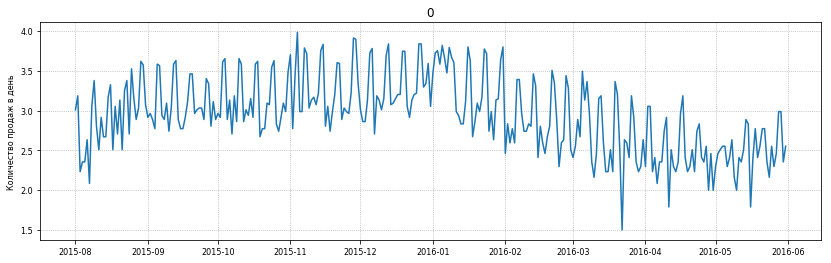

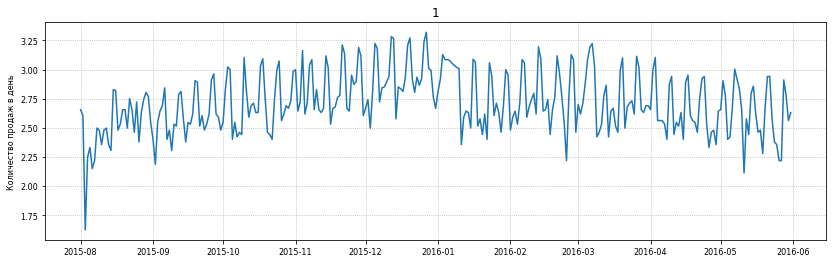

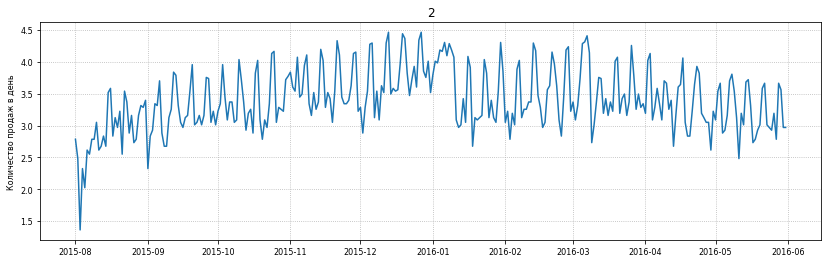

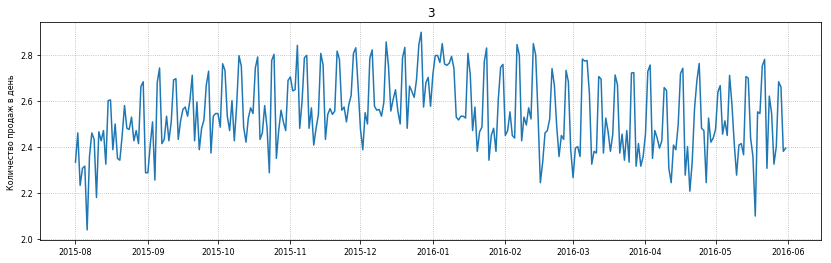

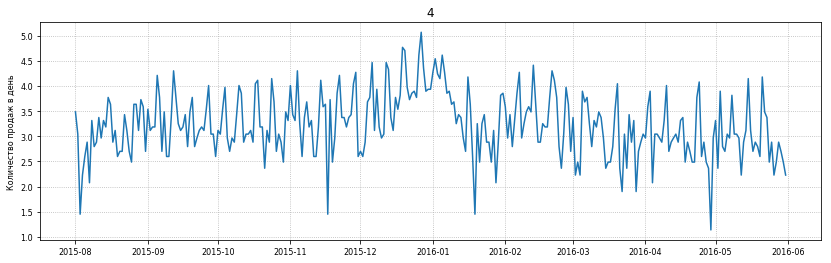

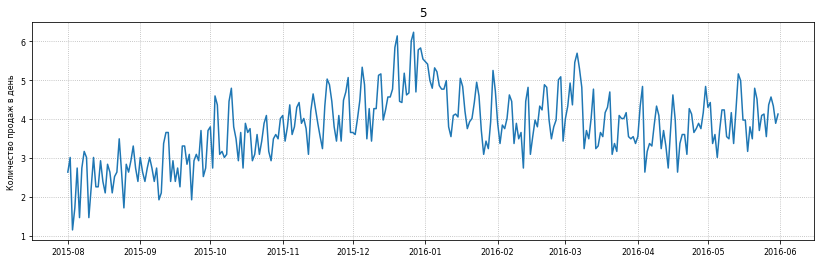

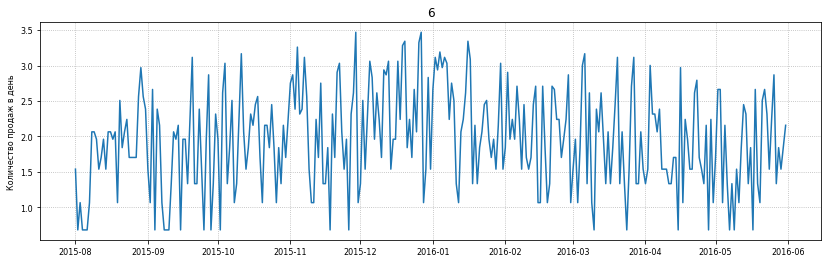

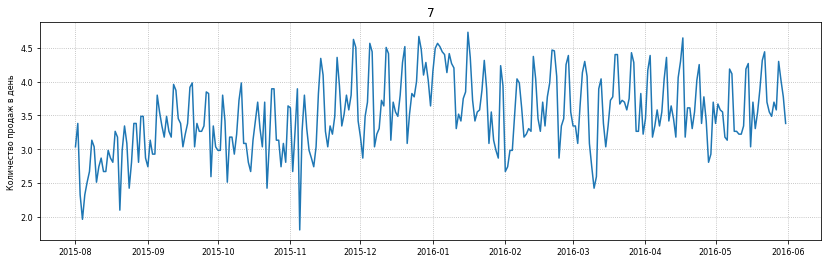

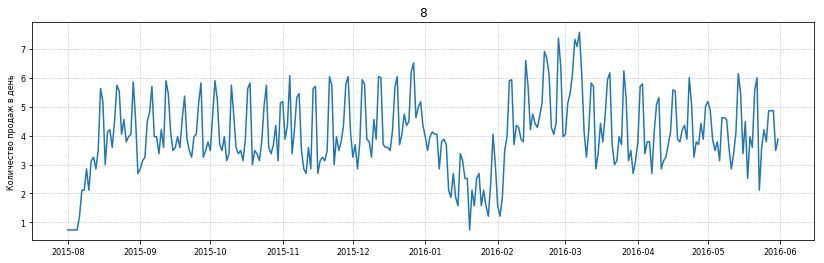

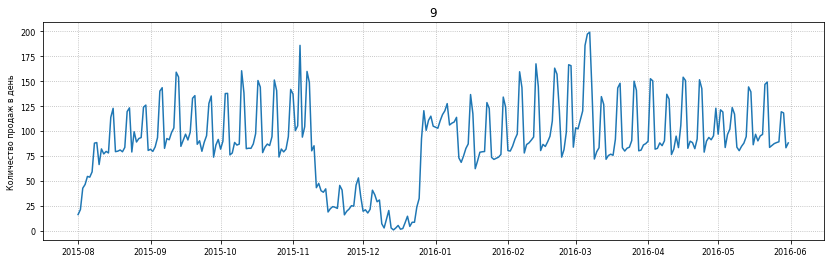

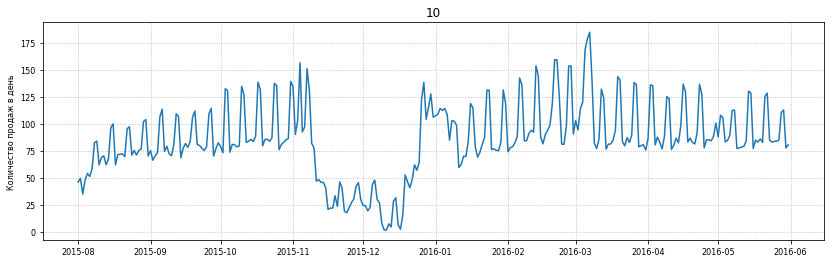

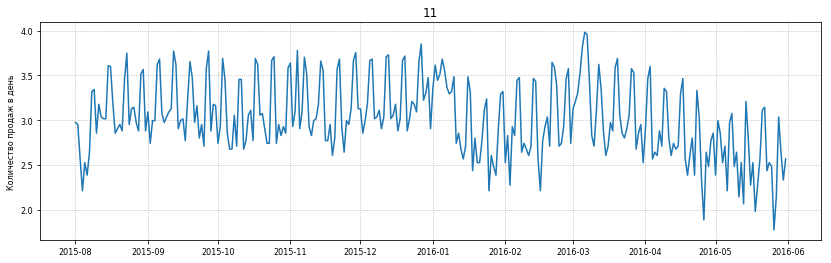

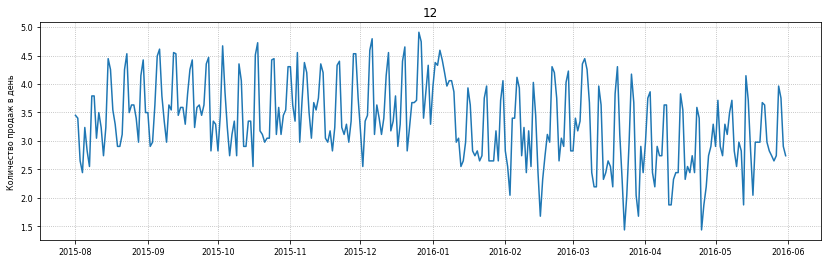

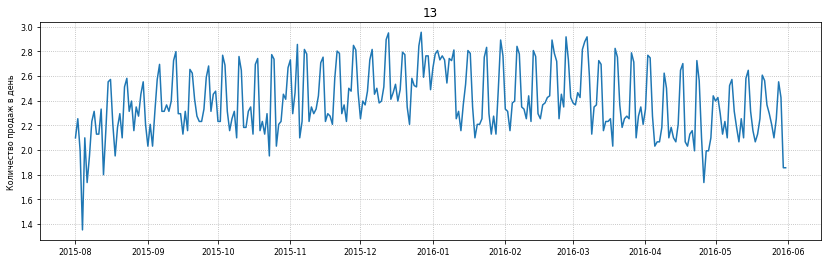

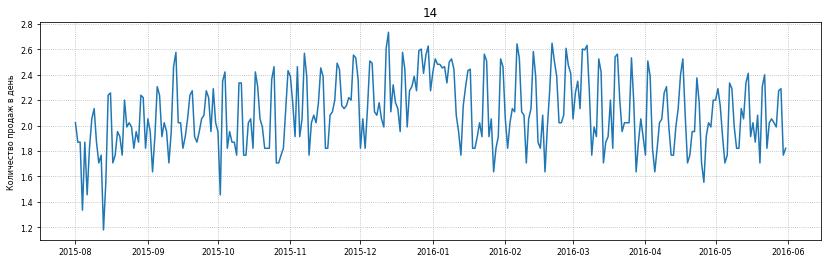

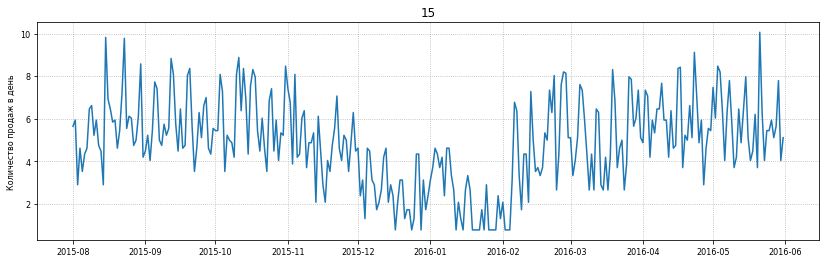

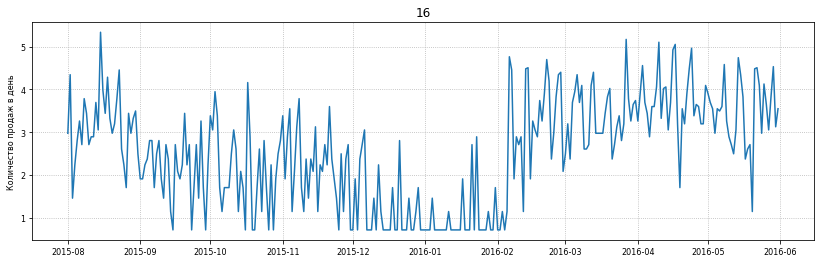

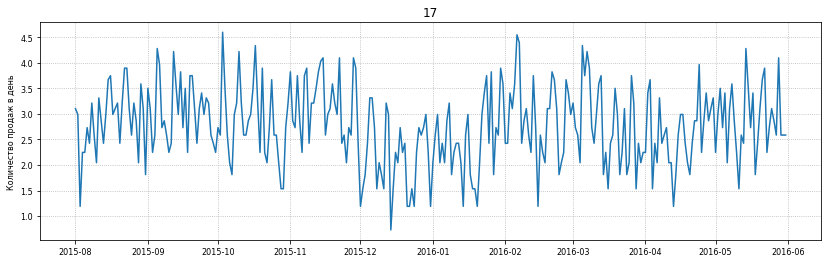

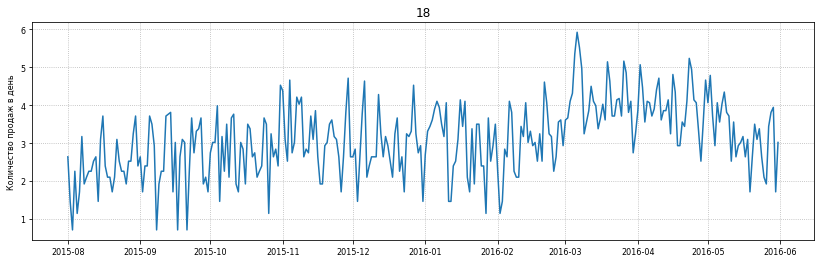

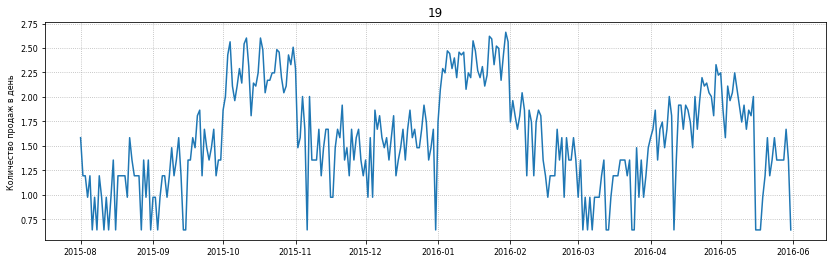

In [490]:
for i in range(20):
    plt.figure(figsize=(14, 4))
    plt.plot(my_time, series[i])
    plt.grid(ls=':')
    plt.xticks(fontsize=8), plt.yticks(fontsize=8)
    plt.ylabel('Количество продаж в день', fontsize=8)
    plt.title('{}'.format(i))
    plt.show()

In [491]:
def dict_of_exog(indexes):
    exog = dict()
    
    #выходные / будни
    exog_1 = []
    for date in indexes:
        if date.weekday() > 4:
            exog_1.append(1)
        else:
            exog_1.append(0)
    exog['weekends'] = np.array(exog_1)
    
    #новогоднее время
    exog_2 = []
    for date in indexes:
        if date.month == 12 and date.day >= 25:
            exog_2.append(1)
        else:
            exog_2.append(0)
    exog['new_year'] = np.array(exog_2)
    
    #первые дни нового года
    exog_3 = []
    for date in indexes:
        if date.month == 1 and date.day <= 4:
            exog_3.append(1)
        else:
            exog_3.append(0)
    exog['first_days_new_year'] = np.array(exog_3)
    
    #дни после нового года
    exog_4 = []
    for date in indexes:
        if date.month == 1 and date.day <= 25:
            exog_4.append(1)
        else:
            exog_4.append(0)
    exog['after_new_year'] = np.array(exog_4)
    
    #дни перед новым годом
    exog_5 = []
    for date in indexes:
        if date.month == 12:
            exog_5.append(1)
        else:
            exog_5.append(0)
    exog['before_new_year'] = np.array(exog_5)
    
    #8 марта
    exog_6 = []
    for date in indexes:
        if date.month == 3 and date.day >= 5 and date.day <= 8:
            exog_6.append(1)
        else:
            exog_6.append(0)
    exog['8_of_march'] = np.array(exog_6)
    
    #для 19ого товара
    exog_7 = []
    for date in indexes:
        if date.month == 10 or date.month == 1 or (date.month == 4) or (date.month == 5 and date.day <= 15):
            exog_7.append(1)
        else:
            exog_7.append(0)
    exog['19_product'] = np.array(exog_7)
    
    #для 9 и 10 товаров
    exog_8 = []
    for date in indexes:
        if (date.month == 11 and date.day >= 8) or (date.month == 12 and date.day <=25):
            exog_8.append(1)
        else:
            exog_8.append(0)
    exog['9_10_product'] = np.array(exog_8)
    
    #для 16 товара
    exog_9 = []
    for date in indexes:
        if date.month >= 2 and date.month <= 8:
            exog_9.append(1)
        else:
            exog_9.append(0)
    exog['16_product'] = np.array(exog_9)
    
    #для 0го товара
    exog_10 = []
    for date in indexes:
        if (date.month >= 2 and date.month <= 8):
            exog_10.append(0)
        else:
            exog_10.append(1)
    exog['0_product'] = np.array(exog_10)
    
    #для 1го товара
    exog_11 = []
    for date in indexes:
        if (date.month == 9 and date.day >=10) or (date.month >= 10 and date.month <= 12):
            exog_11.append(1)
        else:
            exog_11.append(0)
    exog['1_product'] = np.array(exog_11)
    
    #для 5го товара
    exog_12 = []
    for date in indexes:
        if (date.month >= 7 and date.month <= 10):
            exog_12.append(1)
        else:
            exog_12.append(0)
    exog['5_product'] = np.array(exog_12)
    
    #для 7го товара
    exog_13 = []
    for date in indexes:
        if date.month >= 8 and date.month <= 10:
            exog_13.append(1)
        else:
            exog_13.append(0)
    exog['7_product'] = np.array(exog_13)
    
    #для 8го товара
    exog_14 = []
    for date in indexes:
        if date.month == 1 or (date.month == 7 and date.day >= 15) or (date.month == 8 and date.day <= 10):
            exog_14.append(1)
        else:
            exog_14.append(0)
    exog['8_product'] = np.array(exog_14)
    
    #для 11го товара
    exog_15 = []
    for date in indexes:
        if (date.month >= 9 and date.month <= 12) or (date.month == 8 and date.day >= 7):
            exog_15.append(0)
        else:
            exog_15.append(1)
    exog['11_product'] = np.array(exog_15)
    
    #для 12го товара
    exog_16 = []
    for date in indexes:
        if (date.month >= 2 and date.month <= 6) or (date.month == 1 and date.day >= 10) or (date.month == 7 and date.day < 10):
            exog_16.append(0)
        else:
            exog_16.append(1)
    exog['12_product'] = np.array(exog_16)
    
    #для 15го товара
    exog_17 = []
    for date in indexes:
        if date.month == 12 or date.month == 1:
            exog_17.append(0)
        else:
            exog_17.append(1)
    exog['15_product'] = np.array(exog_17)
                                                      
    #для 4го товара
    exog_18 = []
    for date in indexes:
        if date.month >= 9 and date.month <= 12:
            exog_18.append(0)
        else:
            exog_18.append(1)
    exog['4_product'] = np.array(exog_18)

    
    #для 17го товара
    exog_19 = []
    for date in indexes:
        if date.month == 12 or (date.month == 1 and date.day <= 20):
            exog_19.append(0)
        else:
            exog_19.append(1)
    exog['17_product'] = np.array(exog_19)
    
    #для 18го товара
    exog_20 = []
    for date in indexes:
        if date.month == 3 or date.month == 4 or (date.month == 5 and date.day <= 10):
            exog_20.append(0)
        else:
            exog_20.append(1)
    exog['18_product'] = np.array(exog_20)
    
    #номер месяца
    exog_21 = []
    for date in indexes:
        exog_21.append(date.month)
    exog['number_month'] = np.array(exog_21)
    
            
    #годовая сезонность 
    exog['yearly_season'] = np.sin(np.arange(len(indexes)) * 2*np.pi / (365))
    
    return exog
    



каждому продукту добавляем экзогенные факторы

In [492]:
exogs_for_products = []
all_exogs = dict()
# для предсказания на последний месяц из train
# all_exogs = dict_of_exog(my_time[:-30])
all_exogs = dict_of_exog(my_time)
for i in range(20):
    product_i = []
    if i in [3, 10, 11, 12, 14, 17]:
        product_i.append(all_exogs['new_year'])
    if i in [4, 9, 12, 16, 18]:
        product_i.append(all_exogs['weekends'])
    if i in [2, 9]:
        product_i.append(all_exogs['number_month'])
    if i in [0, 4, 6, 7, 9, 11, 12, 17]:
        product_i.append(all_exogs['yearly_season'])
    if i in [1, 2, 3, 4, 13]:
        product_i.append(all_exogs['first_days_new_year'])
    if i in [1, 2, 3,4, 8, 17]:
        product_i.append(all_exogs['after_new_year'])
    if i in [1, 2, 3, 4]:
        product_i.append(all_exogs['before_new_year'])
    if i in [8, 9, 10, 11, 14, 17, 18, 6]:
        product_i.append(all_exogs['8_of_march'])
    if i == 19:
        product_i.append(all_exogs['19_product'])
    if i in [9, 10]:
        product_i.append(all_exogs['9_10_product'])
    if i == 16:
        product_i.append(all_exogs['16_product'])
    if i == 0:
        product_i.append(all_exogs['0_product'])
    if i == 1:
        product_i.append(all_exogs['1_product'])
    if i == 4:
        product_i.append(all_exogs['4_product'])
    if i == 5:
        product_i.append(all_exogs['5_product'])
    if i == 7:
        product_i.append(all_exogs['7_product'])
    if i == 8:
        product_i.append(all_exogs['8_product'])
    if i == 11:
        product_i.append(all_exogs['11_product'])
    if i == 12:
        product_i.append(all_exogs['12_product'])
    if i == 15:
        product_i.append(all_exogs['15_product'])
    if i == 17:
        product_i.append(all_exogs['17_product'])
    if i == 18:
        product_i.append(all_exogs['18_product'])
    exogs_for_products.append(np.array(product_i).T)
    

времена для нового предсказания

In [493]:
new_time = [timeseries.index[-1] + i for i in range(1, 31)]

то же самое для нового времени

In [494]:
exogs_for_products_new = []
all_exogs = dict()
all_exogs = dict_of_exog(new_time)
# all_exogs = dict_of_exog(my_time[-30:])
for i in range(20):
    product_i = []
    if i in [3, 10, 11, 12, 14, 17]:
        product_i.append(all_exogs['new_year'])
    if i in [4, 9, 12, 16, 18]:
        product_i.append(all_exogs['weekends'])
    if i in [2, 9]:
        product_i.append(all_exogs['number_month'])
    if i in [0, 4, 6, 7, 9, 11, 12, 17]:
        product_i.append(all_exogs['yearly_season'])
    if i in [1, 2, 3, 4, 13]:
        product_i.append(all_exogs['first_days_new_year'])
    if i in [1, 2, 3,4, 8, 17]:
        product_i.append(all_exogs['after_new_year'])
    if i in [1, 2, 3, 4]:
        product_i.append(all_exogs['before_new_year'])
    if i in [8, 9, 10, 11, 14, 17, 18, 6]:
        product_i.append(all_exogs['8_of_march'])
    if i == 19:
        product_i.append(all_exogs['19_product'])
    if i in [9, 10]:
        product_i.append(all_exogs['9_10_product'])
    if i == 16:
        product_i.append(all_exogs['16_product'])
    if i == 0:
        product_i.append(all_exogs['0_product'])
    if i == 1:
        product_i.append(all_exogs['1_product'])
    if i == 4:
        product_i.append(all_exogs['4_product'])
    if i == 5:
        product_i.append(all_exogs['5_product'])
    if i == 7:
        product_i.append(all_exogs['7_product'])
    if i == 8:
        product_i.append(all_exogs['8_product'])
    if i == 11:
        product_i.append(all_exogs['11_product'])
    if i == 12:
        product_i.append(all_exogs['12_product'])
    if i == 15:
        product_i.append(all_exogs['15_product'])
    if i == 17:
        product_i.append(all_exogs['17_product'])
    if i == 18:
        product_i.append(all_exogs['18_product'])
    exogs_for_products_new.append(np.array(product_i).T)

Метрика качества SMAPE. Нужна для проверки предсказаний последнего месяца из train (май)

In [510]:
def SMAPE(y_pred, y_true):
    return np.sum(np.abs((y_pred - y_true) / (y_pred + y_true))) * 200 / len(y_pred)

предсказываем

In [495]:
forecast_len = 30  # горизонт прогнозирования
predicted = np.zeros((20, forecast_len))  # тут будут прогнозы

# цикл по товарам
for i in tqdm_notebook(range(20)):
    # временной ряд
    y = series[i]
    # подобранные оптимальные параметры
    p, d, q, P, Q = optim_params[i]
    
    # Задаем модель.
    # Нужно ручное преобразование из numpy.in32 в int, иначе будет ошибка.
    model = sm.tsa.statespace.SARIMAX(y, exog=exogs_for_products[i],
                                      order=(int(p), int(d), int(q)), 
                                      seasonal_order=(int(P), 1, int(Q), 7), 
                                      enforce_stationarity=False, enforce_invertibility=False)
    # Обучаем модель
    model = model.fit()
    # Считаем прогнозы
    predicted[i] = boxcox_inverted(model.get_forecast(steps=forecast_len, exog=exogs_for_products_new[i]).predicted_mean, lambdas[i])

Сдвигаем предсказания обратно вниз на 2 и убираем отрицательные числа из прогнозов.

In [496]:
predicted -= 2
predicted[predicted < 0] = 0

Посмотрим на полученные предсказания визуально.

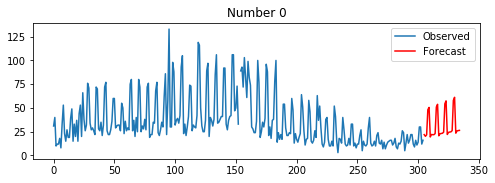

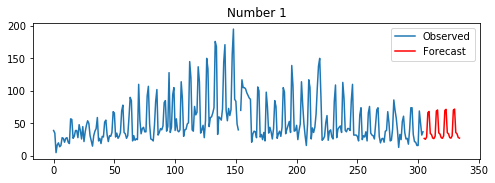

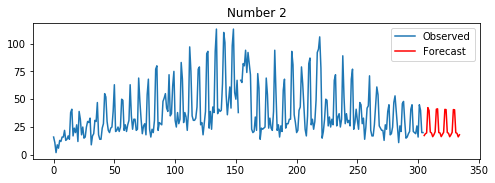

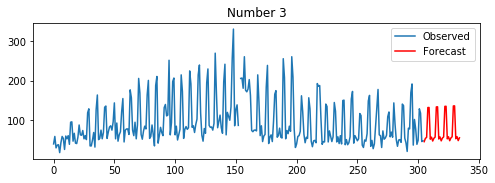

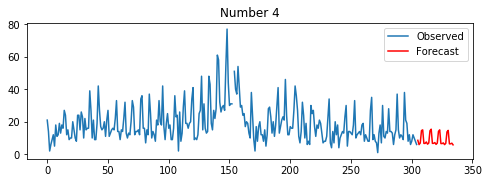

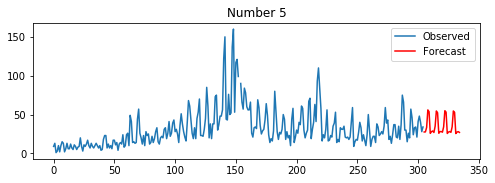

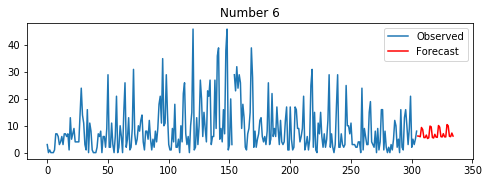

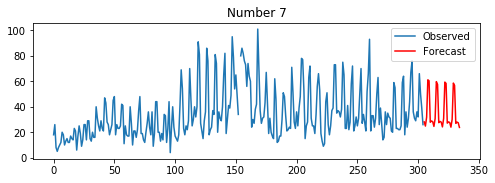

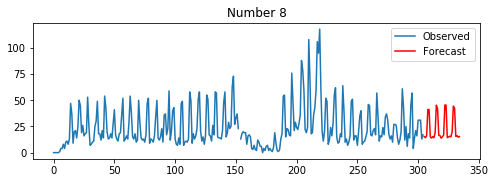

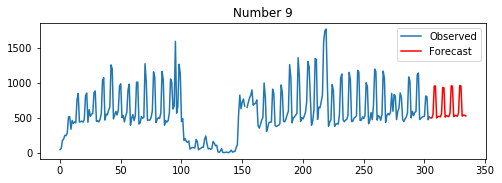

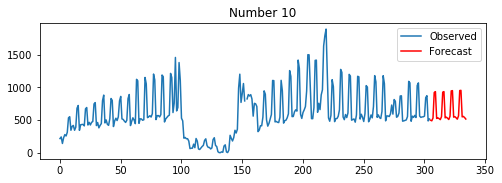

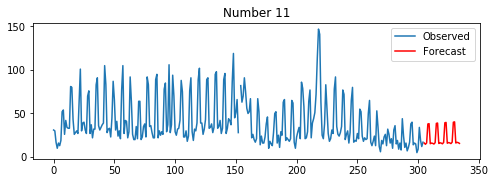

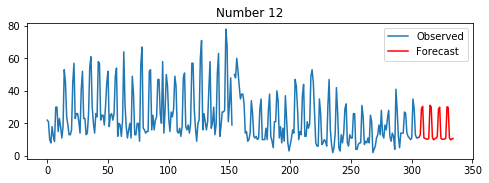

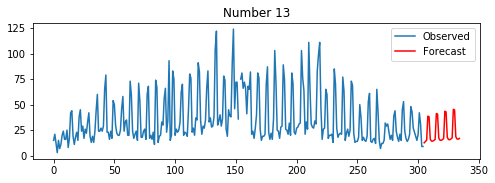

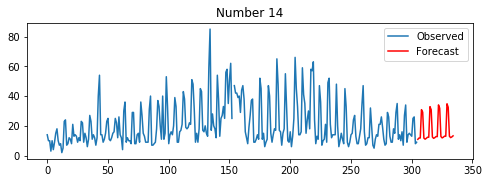

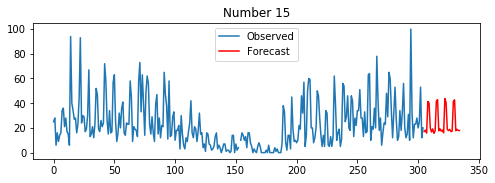

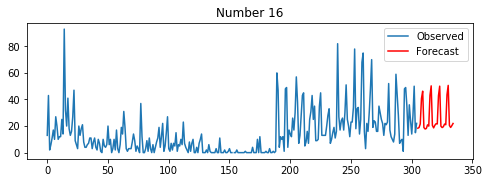

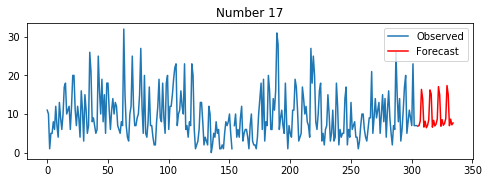

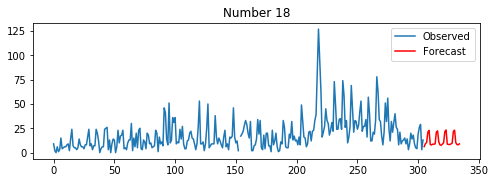

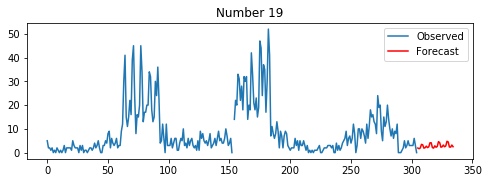

In [505]:
for i in range(20):
    plt.figure(figsize=(8, 2.5))
    plt.plot(np.arange(len(my_time)), np.array(timeseries.iloc[:,i]), label='Observed')
    plt.plot(np.arange(len(my_time), len(my_time) + len(new_time)) , predicted[i], color='red', label='Forecast')
    plt.legend()
    plt.title('Number {}'.format(i))
    plt.show()

Результат записываем в файл

In [506]:
t = pd.DataFrame(predicted.ravel())
t.columns = ['Count']
t.index.name = 'Id'
t.to_csv('result7.csv')